In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import types
import datetime
import random
import math
from typing import Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, distributions
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Function
from torch.distributions import RelaxedOneHotCategorical, Normal, Categorical
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

In [ ]:
def set_seeds(seed=42, fully_deterministic=False):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if fully_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds()

print(f"CUDA={torch.cuda.is_available()}", os.environ.get("CUDA_VISIBLE_DEVICES"))
z = np.random.rand(5, 5)
plt.imshow(z)

### MNIST Dataloader

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ]
)
batch_size = 512
ds_train = MNIST('/tmp/mnist', download=True, transform=transform)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)

ds_test = MNIST('/tmp/mnist_test_', download=True, train=False, transform=transform)
dl_test = DataLoader(ds_test, batch_size=batch_size, num_workers=4)
test_x, _ = next(iter(dl_test))
test_x = test_x.to(device)

### Utils

In [4]:
def show_image(im_data, scale=1):
    dpi = matplotlib.rcParams['figure.dpi']
    height, width = im_data.shape
    figsize = scale * width / float(dpi), scale * height / float(dpi)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(im_data, vmin=0, vmax=1, cmap='gray')
    plt.show();
    ax.set(xlim=[0, width], ylim=[height, 0], aspect=1)


class RAdam(Optimizer):
    def __init__(
        self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if "betas" in param and (
                    param["betas"][0] != betas[0] or param["betas"][1] != betas[1]
                ):
                    param["buffer"] = [[None, None, None] for _ in range(10)]
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            buffer=[[None, None, None] for _ in range(10)],
        )
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError("RAdam does not support sparse gradients")

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p_data_fp32)
                    state["exp_avg_sq"] = torch.zeros_like(p_data_fp32)
                else:
                    state["exp_avg"] = state["exp_avg"].type_as(p_data_fp32)
                    state["exp_avg_sq"] = state["exp_avg_sq"].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state["step"] += 1
                buffered = group["buffer"][int(state["step"] % 10)]
                if state["step"] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state["step"]
                    beta2_t = beta2 ** state["step"]
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state["step"] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t)
                            * (N_sma - 4)
                            / (N_sma_max - 4)
                            * (N_sma - 2)
                            / N_sma
                            * N_sma_max
                            / (N_sma_max - 2)
                        ) / (1 - beta1 ** state["step"])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state["step"])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group["eps"])
                    p_data_fp32.addcdiv_(-step_size * group["lr"], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    p_data_fp32.add_(-step_size * group["lr"], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


# Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
# https://arxiv.org/abs/1908.08681v1
# implemented for PyTorch / FastAI by lessw2020
# github: https://github.com/lessw2020/mish
def mish(x):
    return x * torch.tanh(F.softplus(x))


class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return mish(x)
    
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html
class FlatCA(_LRScheduler):
    def __init__(self, optimizer, steps, eta_min=0, last_epoch=-1):
        self.steps = steps
        self.eta_min = eta_min
        super(FlatCA, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        lr_list = []
        T_max = self.steps / 3
        for base_lr in self.base_lrs:
            # flat if first 2/3
            if 0 <= self._step_count < 2 * T_max:
                lr_list.append(base_lr)
            # annealed if last 1/3
            else:
                lr_list.append(
                    self.eta_min
                    + (base_lr - self.eta_min)
                    * (1 + math.cos(math.pi * (self._step_count - 2 * T_max) / T_max))
                    / 2
                )
            return lr_list

### Architecture

In [5]:
class Encoder(nn.Module):
    """ Downsamples by a fac of 2 """

    def __init__(self, in_feat_dim, codebook_dim, hidden_dim=128, num_res_blocks=0):
        super().__init__()
        blocks = [
            nn.Conv2d(in_feat_dim, hidden_dim // 2, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=3, padding=1),
            Mish(),
        ]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.append(nn.Conv2d(hidden_dim, codebook_dim, kernel_size=1))
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    """ Upsamples by a fac of 2 """

    def __init__(
        self, in_feat_dim, out_feat_dim, hidden_dim=128, num_res_blocks=0, very_bottom=False,
    ):
        super().__init__()
        self.very_bottom = very_bottom
        self.out_feat_dim = out_feat_dim # num channels on bottom layer

        blocks = [nn.Conv2d(in_feat_dim, hidden_dim, kernel_size=3, padding=1), Mish()]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.extend([
                Upsample(),
                nn.Conv2d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1),
                Mish(),
                nn.Conv2d(hidden_dim // 2, out_feat_dim, kernel_size=3, padding=1),
        ])

        if very_bottom is True:
            blocks.append(nn.Sigmoid())       
        
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Upsample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor)


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channel, channel, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(channel, in_channel, kernel_size=3, padding=1)

    def forward(self, inp):
        x = self.conv_1(inp)
        x = mish(x)
        x = self.conv_2(x)
        x = x + inp
        return mish(x)

In [6]:
class VQCodebook(nn.Module):
    def __init__(self, codebook_slots, codebook_dim, temperature=0.5):
        super().__init__()
        self.codebook_slots = codebook_slots
        self.codebook_dim = codebook_dim
        self.temperature = temperature
        self.codebook = nn.Parameter(torch.randn(codebook_slots, codebook_dim))
        self.log_slots_const = np.log(self.codebook_slots)

    def z_e_to_z_q(self, z_e, soft=True):
        bs, feat_dim, w, h = z_e.shape
        assert feat_dim == self.codebook_dim
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_flat = z_e.view(bs * w * h, feat_dim)
        codebook_sqr = torch.sum(self.codebook ** 2, dim=1)
        z_e_flat_sqr = torch.sum(z_e_flat ** 2, dim=1, keepdim=True)

        distances = torch.addmm(
            codebook_sqr + z_e_flat_sqr, z_e_flat, self.codebook.t(), alpha=-2.0, beta=1.0
        )

        if soft is True:
            dist = RelaxedOneHotCategorical(self.temperature, logits=-distances)
            soft_onehot = dist.rsample()
            hard_indices = torch.argmax(soft_onehot, dim=1).view(bs, w, h)
            z_q = (soft_onehot @ self.codebook).view(bs, w, h, feat_dim)
            
            # entropy loss
            KL = dist.probs * (dist.probs.add(1e-9).log() + self.log_slots_const)
            KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()
            
            # probability-weighted commitment loss    
            commit_loss = (dist.probs.view(bs, w, h, self.codebook_slots) * distances.view(bs, w, h, self.codebook_slots)).sum(dim=(1,2,3)).mean()
        else:
            with torch.no_grad():
                dist = Categorical(logits=-distances)
                hard_indices = dist.sample().view(bs, w, h)
                hard_onehot = (
                    F.one_hot(hard_indices, num_classes=self.codebook_slots)
                    .type_as(self.codebook)
                    .view(bs * w * h, self.codebook_slots)
                )
                z_q = (hard_onehot @ self.codebook).view(bs, w, h, feat_dim)
                
                # entropy loss
                KL = dist.probs * (dist.probs.add(1e-9).log() + np.log(self.codebook_slots))
                KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()

                commit_loss = 0.0

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, hard_indices, KL, commit_loss

    def lookup(self, ids: torch.Tensor):
        return F.embedding(ids, self.codebook).permute(0, 3, 1, 2)

    def quantize(self, z_e, soft=False):
        with torch.no_grad():
            z_q, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return z_q, indices

    def quantize_indices(self, z_e, soft=False):
        with torch.no_grad():
            _, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return indices

    def forward(self, z_e):
        z_q, indices, kl, commit_loss = self.z_e_to_z_q(z_e, soft=True)
        return z_q, indices, kl, commit_loss

In [7]:
class GlobalNormalization(torch.nn.Module):
    """
    nn.Module to track and normalize input variables, calculates running estimates of data
    statistics during training time.
    Optional scale parameter to fix standard deviation of inputs to 1
    Normalization atlassian page:
    https://speechmatics.atlassian.net/wiki/spaces/INB/pages/905314814/Normalization+Module
    Implementation details:
    "https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Welford's_online_algorithm"
    """

    def __init__(self, feature_dim, scale=False):
        super().__init__()
        self.feature_dim = feature_dim
        self.register_buffer("running_ave", torch.zeros(1, self.feature_dim, 1, 1))
        self.register_buffer("total_frames_seen", torch.Tensor([0]))
        self.scale = scale
        if self.scale:
            self.register_buffer("running_sq_diff", torch.zeros(1, self.feature_dim, 1, 1))

    def forward(self, inputs):

        if self.training:
            # Update running estimates of statistics
            frames_in_input = inputs.shape[0] * inputs.shape[2] * inputs.shape[3]
            updated_running_ave = (
                self.running_ave * self.total_frames_seen + inputs.sum(dim=(0, 2, 3), keepdim=True)
            ) / (self.total_frames_seen + frames_in_input)

            if self.scale:
                # Update the sum of the squared differences between inputs and mean
                self.running_sq_diff = self.running_sq_diff + (
                    (inputs - self.running_ave) * (inputs - updated_running_ave)
                ).sum(dim=(0, 2, 3), keepdim=True)

            self.running_ave = updated_running_ave
            self.total_frames_seen = self.total_frames_seen + frames_in_input

        if self.scale:
            std = torch.sqrt(self.running_sq_diff / self.total_frames_seen)
            inputs = (inputs - self.running_ave) / std
        else:
            inputs = inputs - self.running_ave

        return inputs

    def unnorm(self, inputs):
        if self.scale:
            std = torch.sqrt(self.running_sq_diff / self.total_frames_seen)
            inputs = inputs*std + self.running_ave
        else:
            inputs = inputs + self.running_ave

        return inputs

In [8]:
class HQA(nn.Module):
    def __init__(
        self,
        prev_model,
        input_feat_dim,
        codebook_slots=256,
        codebook_dim=64,
        enc_hidden_dim=16,
        dec_hidden_dim=32,
        gs_temp=0.667,
    ):
        super().__init__()
        self.prev_model = prev_model
        self.encoder = Encoder(input_feat_dim, codebook_dim, enc_hidden_dim)
        self.codebook = VQCodebook(codebook_slots, codebook_dim, gs_temp)
        self.decoder = Decoder(
            codebook_dim,
            input_feat_dim,
            dec_hidden_dim,
            very_bottom=prev_model is None,
        )
        self.normalize = GlobalNormalization(codebook_dim, scale=True)

    def parameters(self, prefix="", recurse=True):
        for module in [self.encoder, self.codebook, self.decoder]:
            for name, param in module.named_parameters(recurse=recurse):
                yield param

    @classmethod
    def init_higher(cls, prev_model, **kwargs):
        model = HQA(prev_model, prev_model.codebook.codebook_dim, **kwargs)
        model.prev_model.eval()
        return model
    
    @classmethod
    def init_bottom(cls, input_feat_dim, **kwargs):
        model = HQA(None, input_feat_dim, **kwargs)
        return model
        
    def forward(self, img):
        z_e_lower = self.encode_lower(img)
        z_e = self.encoder(z_e_lower)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        z_e_lower_tilde = self.decoder(z_q)
        return z_e_lower_tilde, z_e_lower, z_q, z_e, indices, kl, commit_loss
   
    def forward_full_stack(self, img):
        z_e = self.encode(img)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        img_recon_dist = self.decode(z_q)
        return img_recon_dist, img, z_q, z_e, indices, kl, commit_loss

    def encode_lower(self, x):
        if self.prev_model is None:
            return x
        else:
            with torch.no_grad():
                z_e_lower = self.prev_model.encode(x)
                z_e_lower = self.normalize(z_e_lower)
            return z_e_lower

    def encode(self, x):
        with torch.no_grad():
            z_e_lower = self.encode_lower(x)
            z_e = self.encoder(z_e_lower)
        return z_e
        
    def decode_lower(self, z_q_lower):
        with torch.no_grad():
            recon = self.prev_model.decode(z_q_lower)           
        return recon

    def decode(self, z_q):
        with torch.no_grad():
            if self.prev_model is not None:
                z_e_u = self.normalize.unnorm(self.decoder(z_q))
                z_q_lower_tilde = self.prev_model.quantize(z_e_u)
                recon = self.decode_lower(z_q_lower_tilde)
            else:
                recon = self.decoder(z_q)
        return recon

    def quantize(self, z_e):
        z_q, _ = self.codebook.quantize(z_e)
        return z_q

    def reconstruct_average(self, x, num_samples=10):
        """Average over stochastic edecodes"""
        b, c, h, w = x.shape
        result = torch.empty((num_samples, b, c, h, w)).to(device)

        for i in range(num_samples):
            result[i] = self.decode(self.quantize(self.encode(x)))
        return result.mean(0)

    def reconstruct(self, x):
        return self.decode(self.quantize(self.encode(x)))
    
    def reconstruct_from_codes(self, codes):
        return self.decode(self.codebook.lookup(codes))
    
    def reconstruct_from_z_e(self, z_e):
        return self.decode(self.quantize(z_e))
    
    def recon_loss(self, orig, recon):
        return F.mse_loss(orig, recon, reduction='none').sum(dim=(1,2,3)).mean()

    def __len__(self):
        i = 1
        layer = self
        while layer.prev_model is not None:
            i += 1
            layer = layer.prev_model
        return i

    def __getitem__(self, idx):
        max_layer = len(self) - 1
        if idx > max_layer:
            raise IndexError("layer does not exist")

        layer = self
        for _ in range(max_layer - idx):
            layer = layer.prev_model
        return layer

### Training

In [9]:
def show_recon(img, *models):
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(10 * len(models), 5))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i, model in enumerate(models):
        model.eval()
        img_ = img.unsqueeze(0).unsqueeze(0)
        recon = model.reconstruct(img_).squeeze()
        output = np.hstack([img.cpu(), np.ones([img.shape[0], 1]), recon.cpu(), np.ones([img.shape[0], 1]), np.abs((img-recon).cpu())])
        axes[i].imshow(output, vmin=0, vmax=1, cmap='gray')
        model.train()


def get_bit_usage(indices):
    """ Calculate bits used by latent space vs max possible """
    num_latents = indices.shape[0] * indices.shape[1] * indices.shape[2]
    avg_probs = F.one_hot(indices).float().mean(dim=(0, 1, 2))
    highest_prob = torch.max(avg_probs)
    bits = (-(avg_probs * torch.log2(avg_probs + 1e-10)).sum()) * num_latents
    max_bits = math.log2(256) * num_latents
    return bits, max_bits, highest_prob


def decay_temp_linear(step, total_steps, temp_base, temp_min=0.001):
    factor = 1.0 - (step/total_steps)
    return temp_min + (temp_base - temp_min) * factor

In [10]:
def get_loss_hqa(img, model, epoch, step, commit_threshold=0.6, log=None):
    recon, orig, z_q, z_e, indices, KL, commit_loss = model(img)
    recon_loss = model.recon_loss(orig, recon)
    
    # calculate loss
    dims = np.prod(recon.shape[1:]) # orig_w * orig_h * num_channels
    loss = recon_loss/dims + 0.001*KL/dims + 0.001*(commit_loss)/dims
    
    # logging    
    if step % 20 == 0:
        nll = recon_loss
        elbo = -(nll + KL)  
        distortion_bpd = nll / dims / np.log(2)
        rate_bpd = KL / dims / np.log(2)
        
        bits, max_bits, highest_prob = get_bit_usage(indices)
        bit_usage_frac = bits / max_bits
        
        time = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log_line = f"{time}, epoch={epoch}, step={step}, loss={loss:.5f}, distortion={distortion_bpd:.3f}, rate={rate_bpd:.3f}, -elbo={-elbo:.5f}, nll={nll:.5f}, KL={KL:.5f}, commit_loss={commit_loss:.5f}, bit_usage={bit_usage_frac:.5f}, highest_prob={highest_prob:.3f}, temp={model.codebook.temperature:.5f}"
        print(log_line)

        if log is not None:
            with open(log, "a") as logfile:
                logfile.write(log_line + "\n")
                
    return loss, indices


def train(model, optimizer, scheduler, epochs, decay=True, log=None):
    step = 0
    model.train()
    temp_base = model.codebook.temperature
    code_count = torch.zeros(model.codebook.codebook_slots).to(device)
    total_steps = len(dl_train)*epochs
    
    for epoch in range(epochs):
        for x, _ in dl_train:
            x = x.to(device)
            
            # anneal temperature
            if decay is True:
                model.codebook.temperature = decay_temp_linear(step+1, total_steps, temp_base, temp_min=0.001) 
            
            loss, indices = get_loss_hqa(x, model, epoch, step, log=log)
                
            # take training step    
            model.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if scheduler is not None:
                scheduler.step()     
                
            # code reset every 20 steps
            indices_onehot = F.one_hot(indices, num_classes=model.codebook.codebook_slots).float()
            code_count = code_count + indices_onehot.sum(dim=(0, 1, 2))
            if step % 20 == 0:
                with torch.no_grad():
                    max_count, most_used_code = torch.max(code_count, dim=0)
                    frac_usage = code_count / max_count
                    z_q_most_used = model.codebook.lookup(most_used_code.view(1, 1, 1)).squeeze()

                    min_frac_usage, min_used_code = torch.min(frac_usage, dim=0)
                    if min_frac_usage < 0.03:
                        print(f'reset code {min_used_code}')
                        moved_code = z_q_most_used + torch.randn_like(z_q_most_used) / 100
                        model.codebook.codebook[min_used_code] = moved_code
                    code_count = torch.zeros_like(code_count)

            step += 1
        if epoch % 5 == 0:
            for n in range(0, 5):
                show_recon(test_x[n, 0], model)
                plt.show();

In [11]:
def train_full_stack(root, exp_name, epochs=150, lr=4e-4):
    
    enc_hidden_sizes = [16, 16, 32, 64, 128]
    dec_hidden_sizes = [16, 64, 256, 512, 1024]
    
    os.makedirs(root + "/log", exist_ok=True)
    
    for i in range(5):
        print(f"training layer{i}")
        if i == 0:
            hqa = HQA.init_bottom(
                input_feat_dim=1,
                enc_hidden_dim=enc_hidden_sizes[i],
                dec_hidden_dim=dec_hidden_sizes[i],
            ).to(device)
        else:
            hqa = HQA.init_higher(
                hqa_prev,
                enc_hidden_dim=enc_hidden_sizes[i],
                dec_hidden_dim=dec_hidden_sizes[i],
            ).to(device)
        
        print(f"layer{i} param count {sum(x.numel() for x in hqa.parameters()):,}")
        
        log_file = f"{root}/log/{exp_name}_l{i}.log"
        opt = RAdam(hqa.parameters(), lr=lr)
        scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
        train(hqa, opt, scheduler, epochs, log=log_file)
        hqa_prev = hqa
    
    torch.save(hqa, f"{root}/{exp_name}.pt")
    
    return hqa

### Train HQA Stack

training layer0
layer0 param count 29,185
04/06/2020 11:08:32, epoch=0, step=0, loss=0.22823, distortion=0.312, rate=1.519, -elbo=1299.30554, nll=221.29855, KL=1078.00696, commit_loss=11328.48633, bit_usage=0.24337, highest_prob=0.418, temp=0.66696
reset code 16
04/06/2020 11:08:34, epoch=0, step=20, loss=0.21944, distortion=0.299, rate=1.443, -elbo=1236.72070, nll=212.37967, KL=1024.34106, commit_loss=11299.25977, bit_usage=0.28019, highest_prob=0.336, temp=0.66621
reset code 32
04/06/2020 11:08:36, epoch=0, step=40, loss=0.19980, distortion=0.271, rate=1.412, -elbo=1194.58228, nll=192.38910, KL=1002.19324, commit_loss=11199.53223, bit_usage=0.29547, highest_prob=0.287, temp=0.66546
reset code 48
04/06/2020 11:08:39, epoch=0, step=60, loss=0.16737, distortion=0.224, rate=1.393, -elbo=1147.96777, nll=159.33574, KL=988.63208, commit_loss=11064.30273, bit_usage=0.30427, highest_prob=0.250, temp=0.66470
reset code 64
04/06/2020 11:08:41, epoch=0, step=80, loss=0.12533, distortion=0.164, r

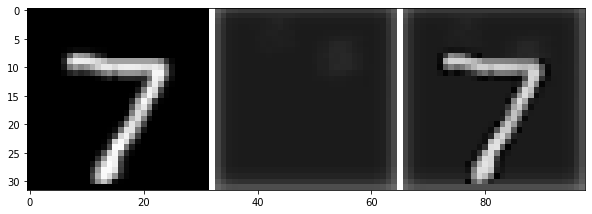

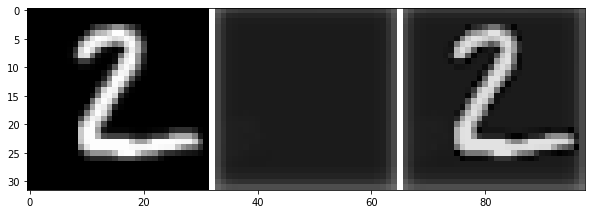

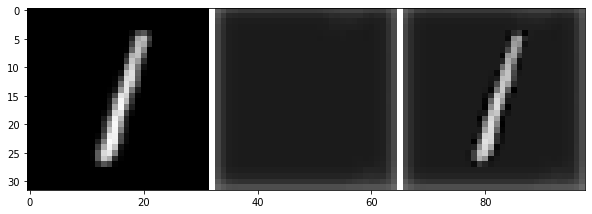

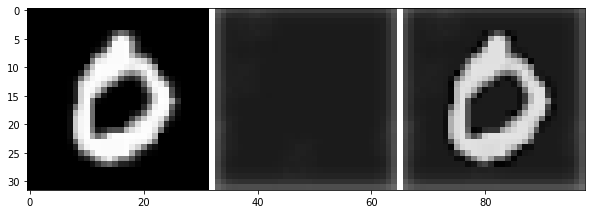

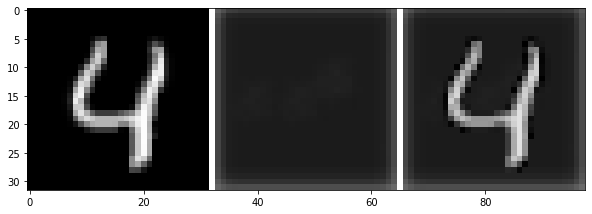

04/06/2020 11:08:47, epoch=1, step=120, loss=0.10388, distortion=0.133, rate=1.285, -elbo=1006.96155, nll=94.72752, KL=912.23401, commit_loss=10728.77148, bit_usage=0.35732, highest_prob=0.184, temp=0.66245
reset code 0
04/06/2020 11:08:49, epoch=1, step=140, loss=0.10663, distortion=0.138, rate=1.249, -elbo=984.44983, nll=97.63486, KL=886.81500, commit_loss=10667.34180, bit_usage=0.37519, highest_prob=0.181, temp=0.66169
reset code 112
04/06/2020 11:08:51, epoch=1, step=160, loss=0.10435, distortion=0.134, rate=1.233, -elbo=970.25208, nll=95.41518, KL=874.83691, commit_loss=10568.82812, bit_usage=0.38372, highest_prob=0.206, temp=0.66094
reset code 144
04/06/2020 11:08:54, epoch=1, step=180, loss=0.10474, distortion=0.135, rate=1.226, -elbo=966.00970, nll=95.93036, KL=870.07935, commit_loss=10450.91211, bit_usage=0.38702, highest_prob=0.203, temp=0.66019
reset code 160
04/06/2020 11:08:56, epoch=1, step=200, loss=0.10501, distortion=0.136, rate=1.226, -elbo=966.87378, nll=96.34846, KL

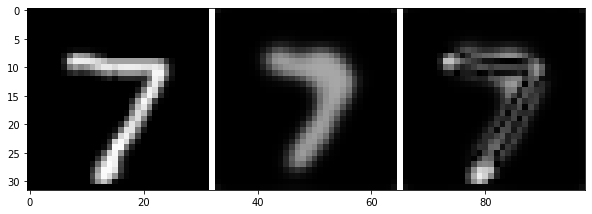

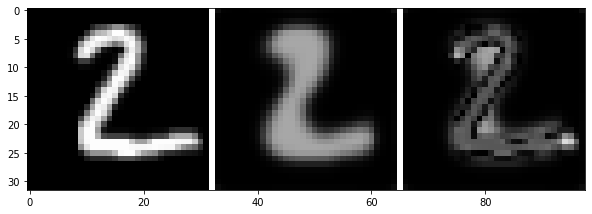

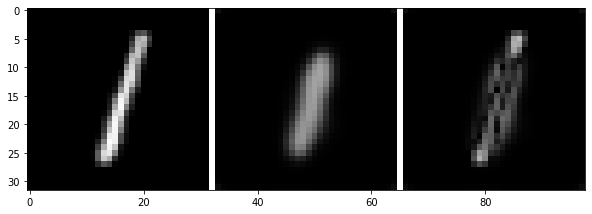

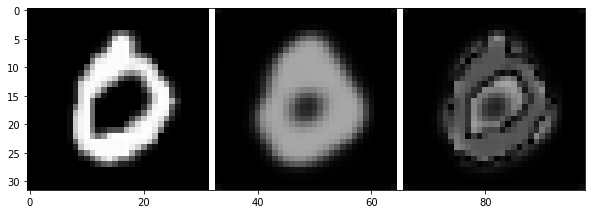

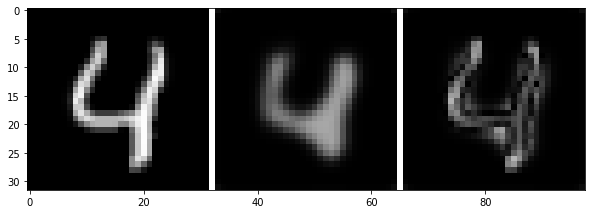

04/06/2020 11:09:59, epoch=6, step=720, loss=0.02881, distortion=0.036, rate=1.182, -elbo=864.79126, nll=25.47471, KL=839.31653, commit_loss=3189.51831, bit_usage=0.50033, highest_prob=0.125, temp=0.63987
reset code 68
04/06/2020 11:10:01, epoch=6, step=740, loss=0.02846, distortion=0.036, rate=1.189, -elbo=869.23969, nll=25.32125, KL=843.91846, commit_loss=2980.43848, bit_usage=0.49764, highest_prob=0.137, temp=0.63912
reset code 84
04/06/2020 11:10:03, epoch=6, step=760, loss=0.02711, distortion=0.034, rate=1.182, -elbo=863.41211, nll=24.13895, KL=839.27319, commit_loss=2777.45801, bit_usage=0.50289, highest_prob=0.139, temp=0.63837
reset code 100
04/06/2020 11:10:06, epoch=6, step=780, loss=0.02623, distortion=0.033, rate=1.169, -elbo=852.85437, nll=23.40849, KL=829.44586, commit_loss=2616.82422, bit_usage=0.51093, highest_prob=0.131, temp=0.63761
reset code 116
04/06/2020 11:10:08, epoch=6, step=800, loss=0.02555, distortion=0.032, rate=1.155, -elbo=842.37518, nll=22.88444, KL=819.

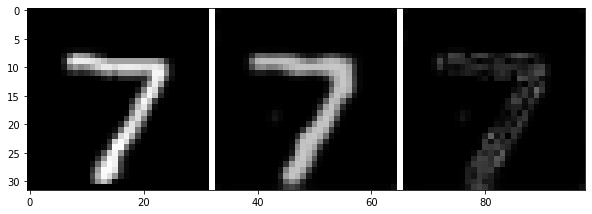

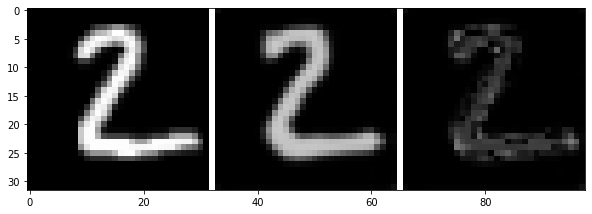

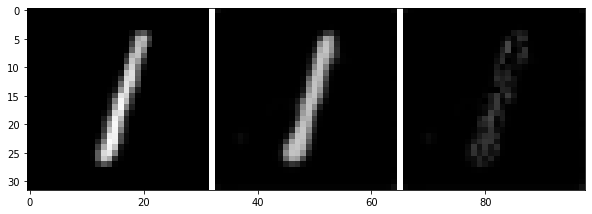

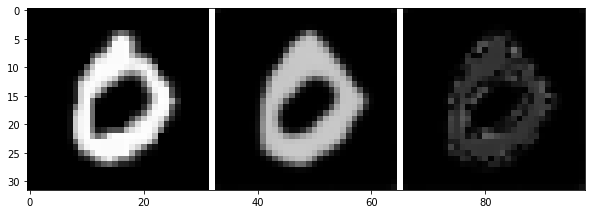

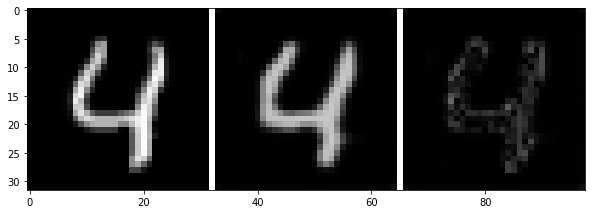

04/06/2020 11:11:07, epoch=11, step=1300, loss=0.00710, distortion=0.009, rate=0.928, -elbo=664.99695, nll=6.03990, KL=658.95703, commit_loss=574.60004, bit_usage=0.66342, highest_prob=0.056, temp=0.61805
reset code 18
04/06/2020 11:11:10, epoch=11, step=1320, loss=0.00690, distortion=0.008, rate=0.921, -elbo=659.40302, nll=5.86144, KL=653.54156, commit_loss=547.25122, bit_usage=0.66885, highest_prob=0.051, temp=0.61729
reset code 34
04/06/2020 11:11:12, epoch=11, step=1340, loss=0.00673, distortion=0.008, rate=0.912, -elbo=653.17822, nll=5.70813, KL=647.47009, commit_loss=538.54095, bit_usage=0.67485, highest_prob=0.050, temp=0.61654
reset code 50
04/06/2020 11:11:14, epoch=11, step=1360, loss=0.00657, distortion=0.008, rate=0.903, -elbo=646.14398, nll=5.56470, KL=640.57928, commit_loss=518.55542, bit_usage=0.68040, highest_prob=0.046, temp=0.61579
reset code 66
04/06/2020 11:11:17, epoch=11, step=1380, loss=0.00634, distortion=0.008, rate=0.896, -elbo=641.55322, nll=5.35389, KL=636.1

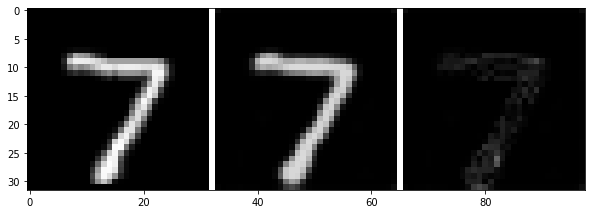

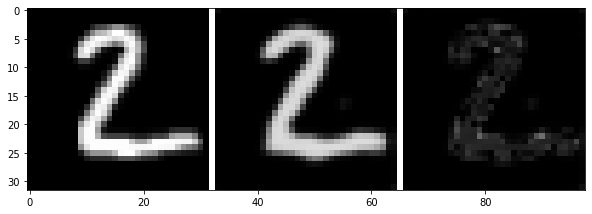

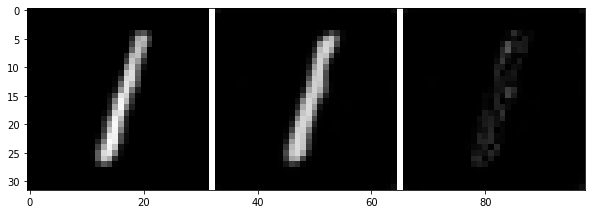

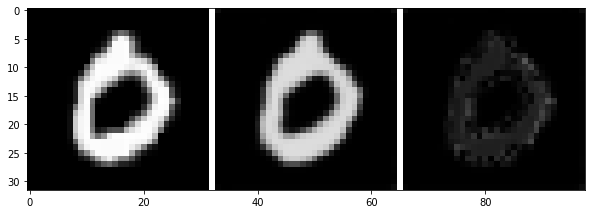

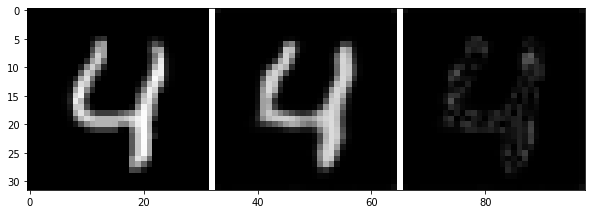

04/06/2020 11:12:18, epoch=16, step=1900, loss=0.00390, distortion=0.004, rate=0.753, -elbo=537.98035, nll=3.16909, KL=534.81128, commit_loss=288.38306, bit_usage=0.77631, highest_prob=0.022, temp=0.59547
reset code 250
04/06/2020 11:12:20, epoch=16, step=1920, loss=0.00376, distortion=0.004, rate=0.748, -elbo=533.74829, nll=3.04140, KL=530.70691, commit_loss=281.23886, bit_usage=0.77775, highest_prob=0.021, temp=0.59472
reset code 6
04/06/2020 11:12:23, epoch=16, step=1940, loss=0.00381, distortion=0.004, rate=0.745, -elbo=531.64807, nll=3.09125, KL=528.55682, commit_loss=279.38098, bit_usage=0.78114, highest_prob=0.020, temp=0.59397
reset code 22
04/06/2020 11:12:25, epoch=16, step=1960, loss=0.00370, distortion=0.004, rate=0.739, -elbo=527.46710, nll=2.99445, KL=524.47266, commit_loss=274.92947, bit_usage=0.78396, highest_prob=0.019, temp=0.59321
reset code 38
04/06/2020 11:12:27, epoch=16, step=1980, loss=0.00361, distortion=0.004, rate=0.732, -elbo=522.70569, nll=2.90373, KL=519.8

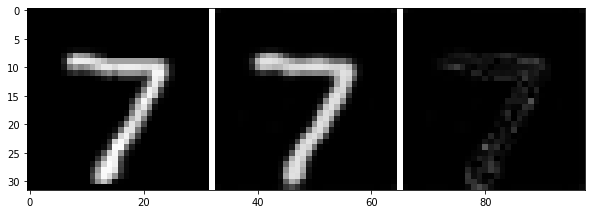

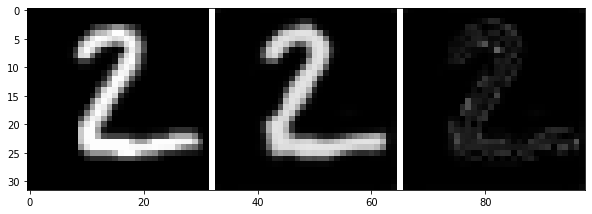

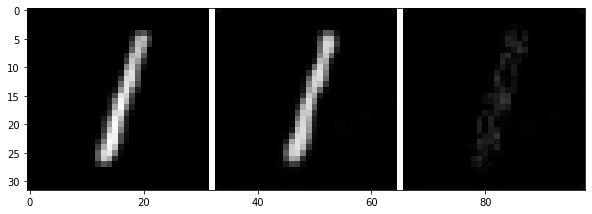

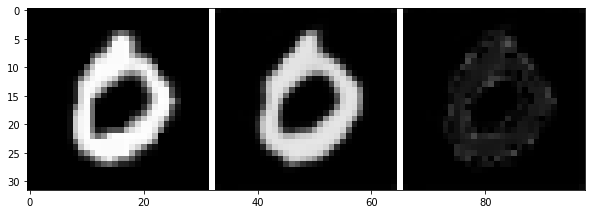

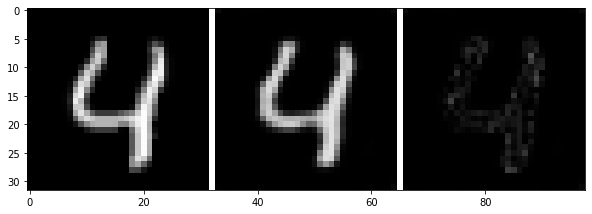

04/06/2020 11:13:28, epoch=21, step=2480, loss=0.00280, distortion=0.003, rate=0.634, -elbo=451.96411, nll=2.21118, KL=449.75293, commit_loss=205.20564, bit_usage=0.83934, highest_prob=0.013, temp=0.57365
reset code 206
04/06/2020 11:13:30, epoch=21, step=2500, loss=0.00285, distortion=0.003, rate=0.632, -elbo=450.85654, nll=2.26637, KL=448.59015, commit_loss=205.19568, bit_usage=0.84136, highest_prob=0.012, temp=0.57289
reset code 222
04/06/2020 11:13:33, epoch=21, step=2520, loss=0.00282, distortion=0.003, rate=0.627, -elbo=447.51392, nll=2.24170, KL=445.27222, commit_loss=204.44675, bit_usage=0.84335, highest_prob=0.012, temp=0.57214
reset code 238
04/06/2020 11:13:35, epoch=21, step=2540, loss=0.00281, distortion=0.003, rate=0.626, -elbo=446.70132, nll=2.23276, KL=444.46857, commit_loss=201.88275, bit_usage=0.84524, highest_prob=0.012, temp=0.57139
reset code 254
04/06/2020 11:13:37, epoch=21, step=2560, loss=0.00282, distortion=0.003, rate=0.624, -elbo=445.08792, nll=2.24675, KL=4

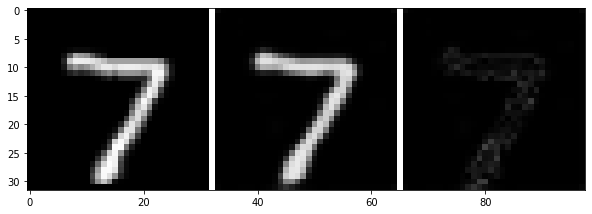

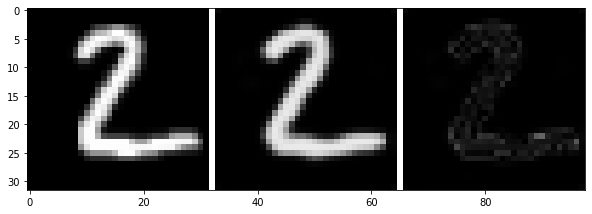

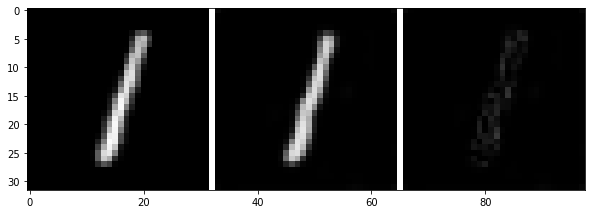

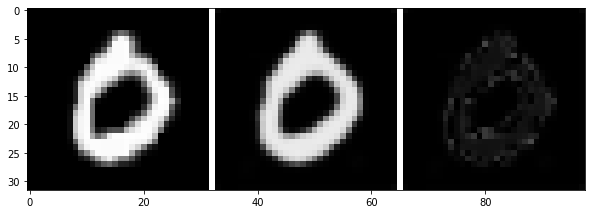

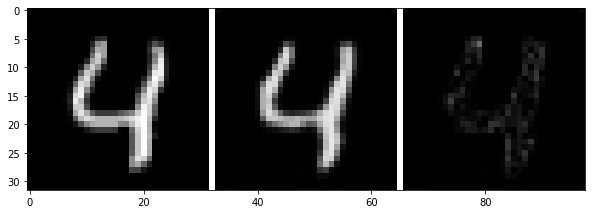

04/06/2020 11:14:41, epoch=26, step=3080, loss=0.00238, distortion=0.003, rate=0.546, -elbo=389.13791, nll=1.88436, KL=387.25354, commit_loss=162.84875, bit_usage=0.88733, highest_prob=0.009, temp=0.55107
reset code 185
04/06/2020 11:14:43, epoch=26, step=3100, loss=0.00237, distortion=0.003, rate=0.544, -elbo=387.90750, nll=1.87520, KL=386.03229, commit_loss=161.85506, bit_usage=0.88859, highest_prob=0.009, temp=0.55032
reset code 201
04/06/2020 11:14:46, epoch=26, step=3120, loss=0.00234, distortion=0.003, rate=0.540, -elbo=385.48544, nll=1.85512, KL=383.63031, commit_loss=159.56241, bit_usage=0.88987, highest_prob=0.009, temp=0.54957
reset code 217
04/06/2020 11:14:48, epoch=26, step=3140, loss=0.00243, distortion=0.003, rate=0.542, -elbo=386.72531, nll=1.94410, KL=384.78122, commit_loss=159.98734, bit_usage=0.89159, highest_prob=0.009, temp=0.54881
reset code 233
04/06/2020 11:14:50, epoch=26, step=3160, loss=0.00232, distortion=0.003, rate=0.538, -elbo=383.70343, nll=1.84059, KL=3

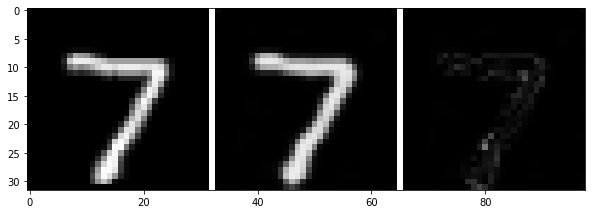

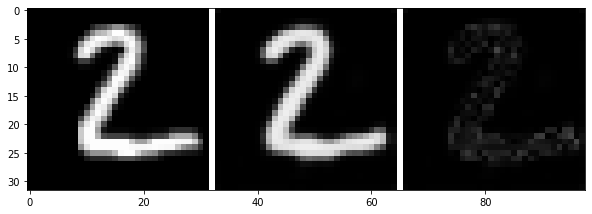

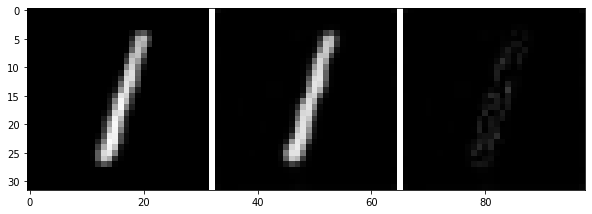

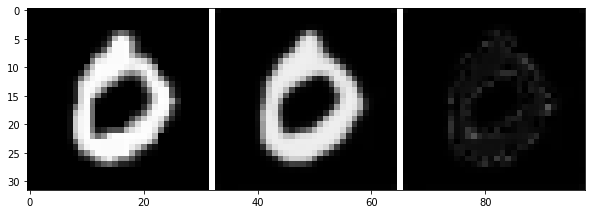

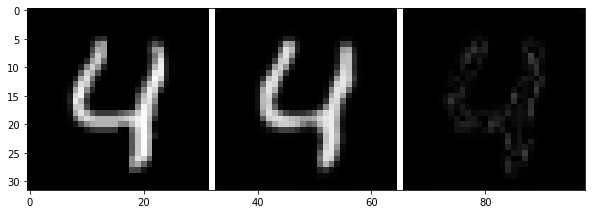

04/06/2020 11:15:51, epoch=31, step=3660, loss=0.00211, distortion=0.002, rate=0.479, -elbo=341.57455, nll=1.68626, KL=339.88831, commit_loss=134.01627, bit_usage=0.92352, highest_prob=0.007, temp=0.52925
reset code 141
04/06/2020 11:15:53, epoch=31, step=3680, loss=0.00210, distortion=0.002, rate=0.480, -elbo=342.59677, nll=1.67204, KL=340.92471, commit_loss=134.67438, bit_usage=0.92468, highest_prob=0.008, temp=0.52849
reset code 157
04/06/2020 11:15:55, epoch=31, step=3700, loss=0.00206, distortion=0.002, rate=0.476, -elbo=339.44348, nll=1.64174, KL=337.80176, commit_loss=133.45096, bit_usage=0.92577, highest_prob=0.007, temp=0.52774
reset code 173
04/06/2020 11:15:58, epoch=31, step=3720, loss=0.00205, distortion=0.002, rate=0.473, -elbo=337.02460, nll=1.63616, KL=335.38843, commit_loss=131.19040, bit_usage=0.92676, highest_prob=0.007, temp=0.52699
reset code 189
04/06/2020 11:16:00, epoch=31, step=3740, loss=0.00203, distortion=0.002, rate=0.471, -elbo=335.59448, nll=1.61840, KL=3

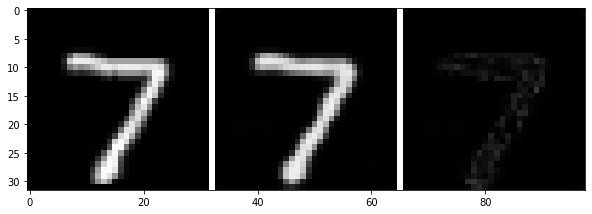

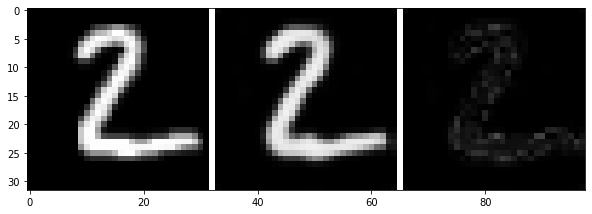

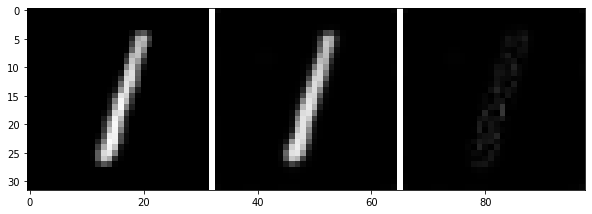

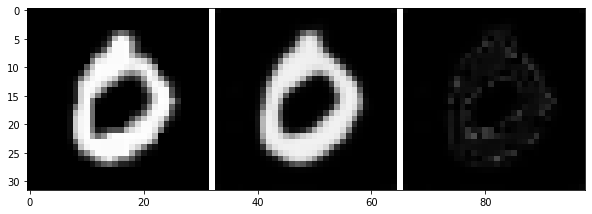

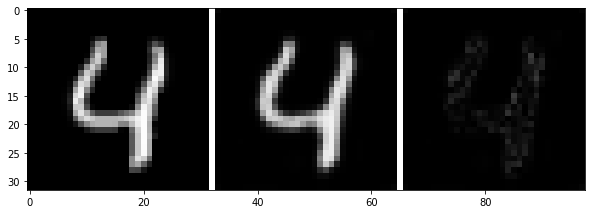

04/06/2020 11:17:01, epoch=36, step=4260, loss=0.00189, distortion=0.002, rate=0.425, -elbo=302.87921, nll=1.51975, KL=301.35947, commit_loss=115.16739, bit_usage=0.95433, highest_prob=0.006, temp=0.50667
reset code 107
04/06/2020 11:17:04, epoch=36, step=4280, loss=0.00191, distortion=0.002, rate=0.422, -elbo=301.02481, nll=1.53604, KL=299.48877, commit_loss=115.29163, bit_usage=0.95523, highest_prob=0.006, temp=0.50592
reset code 123
04/06/2020 11:17:06, epoch=36, step=4300, loss=0.00189, distortion=0.002, rate=0.416, -elbo=296.98831, nll=1.52481, KL=295.46350, commit_loss=113.22097, bit_usage=0.95603, highest_prob=0.006, temp=0.50517
reset code 139
04/06/2020 11:17:08, epoch=36, step=4320, loss=0.00189, distortion=0.002, rate=0.416, -elbo=296.60303, nll=1.52564, KL=295.07739, commit_loss=112.29002, bit_usage=0.95707, highest_prob=0.006, temp=0.50441
reset code 155
04/06/2020 11:17:11, epoch=36, step=4340, loss=0.00184, distortion=0.002, rate=0.410, -elbo=292.54660, nll=1.47858, KL=2

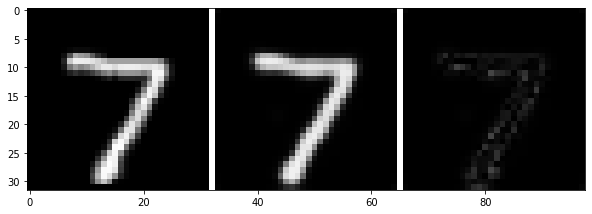

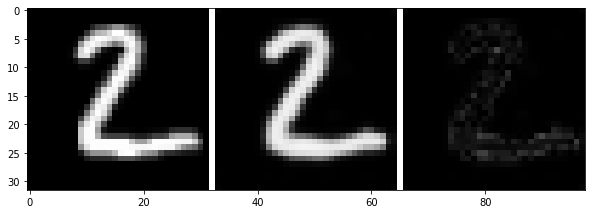

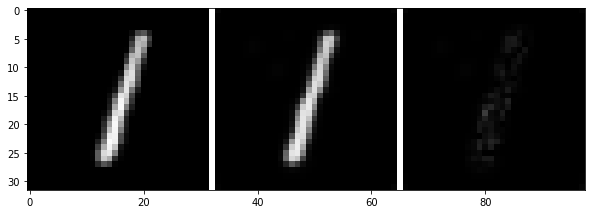

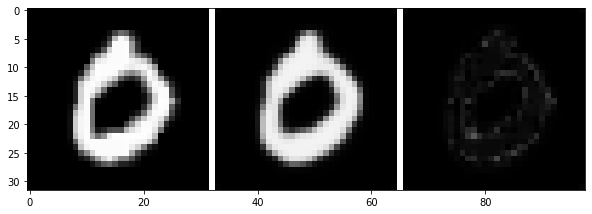

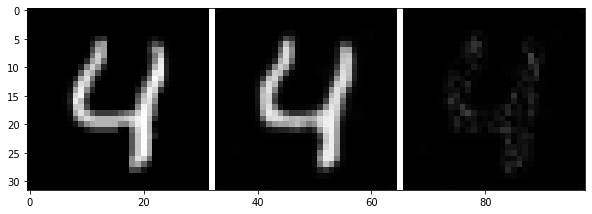

04/06/2020 11:18:10, epoch=41, step=4840, loss=0.00191, distortion=0.002, rate=0.372, -elbo=265.42288, nll=1.59434, KL=263.82855, commit_loss=101.41498, bit_usage=0.97968, highest_prob=0.005, temp=0.48485
reset code 63
04/06/2020 11:18:12, epoch=41, step=4860, loss=0.00172, distortion=0.002, rate=0.368, -elbo=262.26086, nll=1.40215, KL=260.85870, commit_loss=98.49947, bit_usage=0.98007, highest_prob=0.005, temp=0.48409
reset code 79
04/06/2020 11:18:14, epoch=41, step=4880, loss=0.00170, distortion=0.002, rate=0.367, -elbo=261.52768, nll=1.38307, KL=260.14459, commit_loss=99.42801, bit_usage=0.98095, highest_prob=0.005, temp=0.48334
reset code 95
04/06/2020 11:18:16, epoch=41, step=4900, loss=0.00173, distortion=0.002, rate=0.365, -elbo=260.23923, nll=1.41843, KL=258.82080, commit_loss=98.48474, bit_usage=0.98170, highest_prob=0.005, temp=0.48259
reset code 111
04/06/2020 11:18:19, epoch=41, step=4920, loss=0.00178, distortion=0.002, rate=0.367, -elbo=261.68375, nll=1.46511, KL=260.218

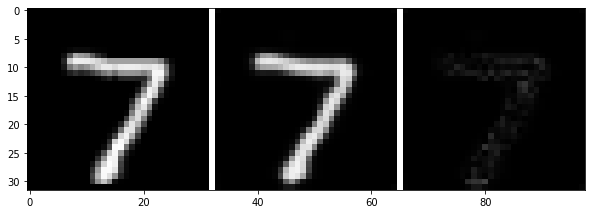

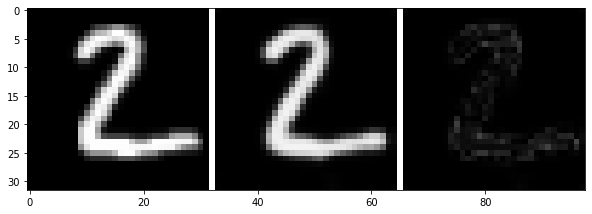

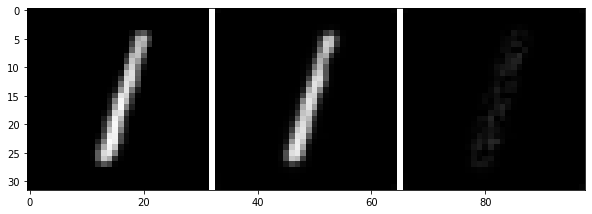

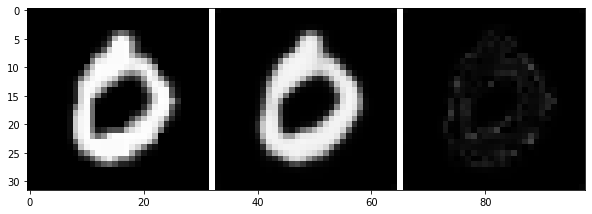

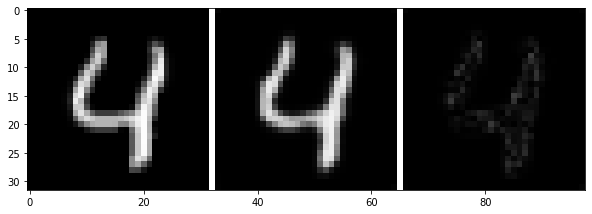

04/06/2020 11:19:21, epoch=46, step=5440, loss=0.00168, distortion=0.002, rate=0.354, -elbo=252.73154, nll=1.38349, KL=251.34805, commit_loss=89.79120, bit_usage=0.98910, highest_prob=0.005, temp=0.46227
04/06/2020 11:19:23, epoch=46, step=5460, loss=0.00167, distortion=0.002, rate=0.356, -elbo=254.28674, nll=1.37140, KL=252.91534, commit_loss=90.45346, bit_usage=0.98930, highest_prob=0.005, temp=0.46152
04/06/2020 11:19:25, epoch=46, step=5480, loss=0.00159, distortion=0.002, rate=0.351, -elbo=250.19148, nll=1.29246, KL=248.89902, commit_loss=88.97957, bit_usage=0.98914, highest_prob=0.005, temp=0.46077
04/06/2020 11:19:28, epoch=46, step=5500, loss=0.00165, distortion=0.002, rate=0.353, -elbo=252.15868, nll=1.35055, KL=250.80814, commit_loss=89.89634, bit_usage=0.98908, highest_prob=0.005, temp=0.46001
04/06/2020 11:19:30, epoch=46, step=5520, loss=0.00159, distortion=0.002, rate=0.350, -elbo=249.70990, nll=1.29424, KL=248.41566, commit_loss=87.87599, bit_usage=0.98872, highest_prob=

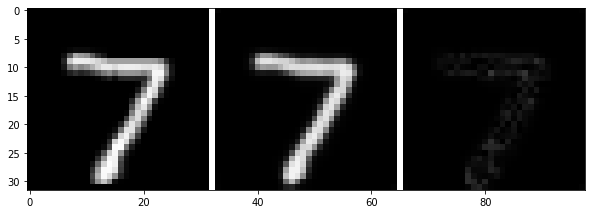

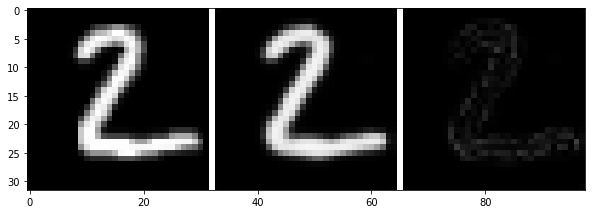

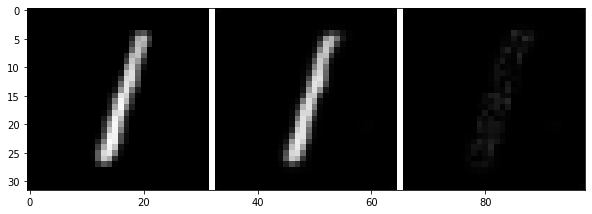

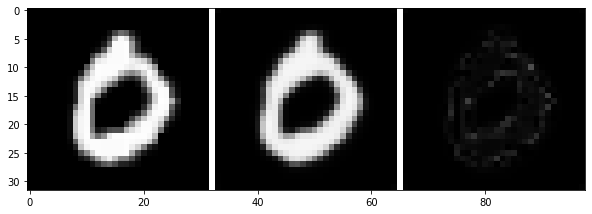

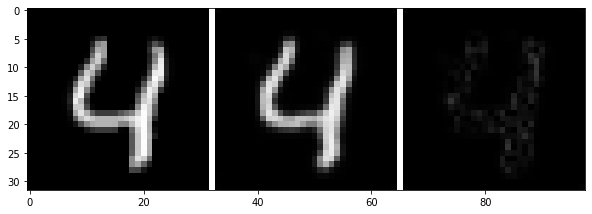

04/06/2020 11:20:31, epoch=51, step=6020, loss=0.00155, distortion=0.002, rate=0.354, -elbo=252.68430, nll=1.25848, KL=251.42581, commit_loss=82.22217, bit_usage=0.98885, highest_prob=0.005, temp=0.44045
04/06/2020 11:20:33, epoch=51, step=6040, loss=0.00162, distortion=0.002, rate=0.359, -elbo=256.11786, nll=1.31679, KL=254.80106, commit_loss=82.76784, bit_usage=0.98887, highest_prob=0.005, temp=0.43969
04/06/2020 11:20:36, epoch=51, step=6060, loss=0.00169, distortion=0.002, rate=0.356, -elbo=254.25764, nll=1.39306, KL=252.86459, commit_loss=82.30331, bit_usage=0.98902, highest_prob=0.005, temp=0.43894
04/06/2020 11:20:38, epoch=51, step=6080, loss=0.00162, distortion=0.002, rate=0.358, -elbo=255.41827, nll=1.31782, KL=254.10046, commit_loss=82.79451, bit_usage=0.98904, highest_prob=0.006, temp=0.43819
04/06/2020 11:20:40, epoch=51, step=6100, loss=0.00155, distortion=0.002, rate=0.355, -elbo=252.91263, nll=1.25266, KL=251.65996, commit_loss=81.45425, bit_usage=0.98867, highest_prob=

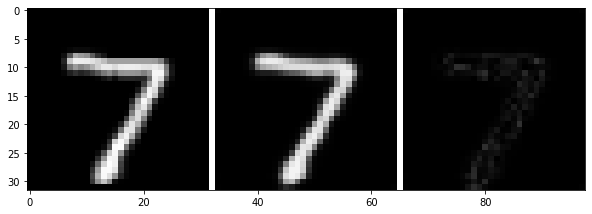

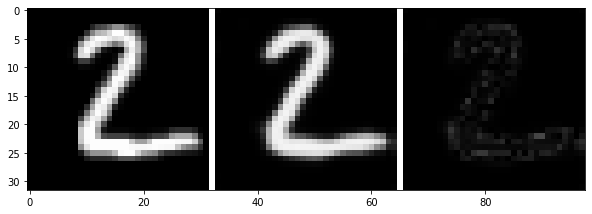

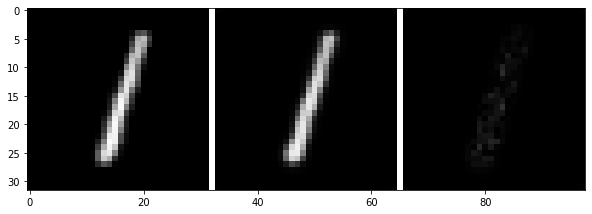

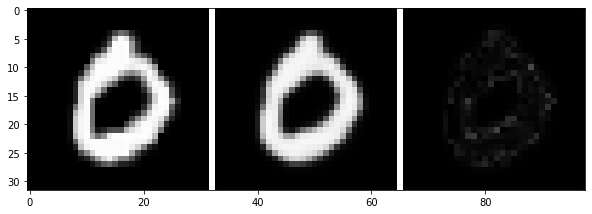

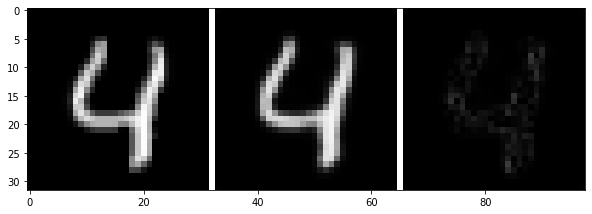

04/06/2020 11:21:43, epoch=56, step=6620, loss=0.00160, distortion=0.002, rate=0.359, -elbo=256.46942, nll=1.30676, KL=255.16267, commit_loss=77.66426, bit_usage=0.98968, highest_prob=0.006, temp=0.41787
04/06/2020 11:21:46, epoch=56, step=6640, loss=0.00153, distortion=0.002, rate=0.355, -elbo=252.90977, nll=1.24210, KL=251.66766, commit_loss=75.87970, bit_usage=0.98920, highest_prob=0.006, temp=0.41712
04/06/2020 11:21:48, epoch=56, step=6660, loss=0.00155, distortion=0.002, rate=0.359, -elbo=255.87389, nll=1.25915, KL=254.61473, commit_loss=76.69504, bit_usage=0.98964, highest_prob=0.005, temp=0.41637
04/06/2020 11:21:50, epoch=56, step=6680, loss=0.00151, distortion=0.002, rate=0.355, -elbo=252.97028, nll=1.21841, KL=251.75188, commit_loss=74.83434, bit_usage=0.98916, highest_prob=0.005, temp=0.41561
04/06/2020 11:21:53, epoch=56, step=6700, loss=0.00156, distortion=0.002, rate=0.359, -elbo=256.11002, nll=1.27087, KL=254.83916, commit_loss=76.35706, bit_usage=0.98936, highest_prob=

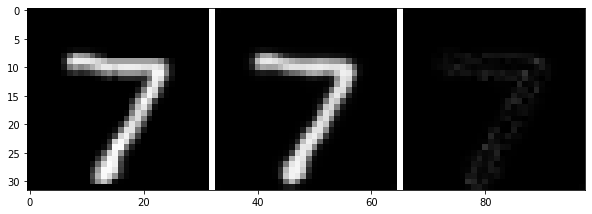

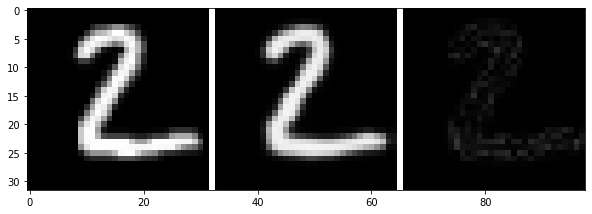

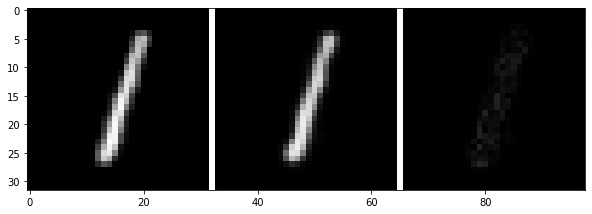

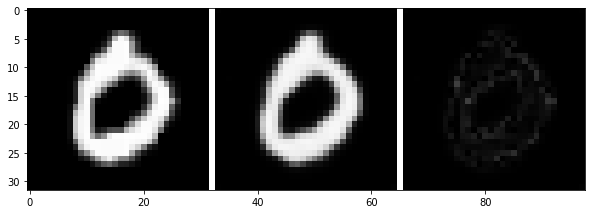

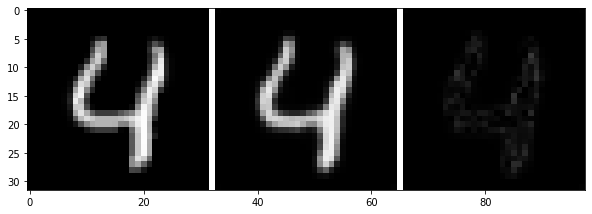

04/06/2020 11:22:51, epoch=61, step=7200, loss=0.00147, distortion=0.002, rate=0.355, -elbo=252.96332, nll=1.18026, KL=251.78305, commit_loss=70.81771, bit_usage=0.98983, highest_prob=0.005, temp=0.39605
04/06/2020 11:22:54, epoch=61, step=7220, loss=0.00161, distortion=0.002, rate=0.361, -elbo=257.86029, nll=1.32393, KL=256.53638, commit_loss=72.22523, bit_usage=0.99007, highest_prob=0.005, temp=0.39529
04/06/2020 11:22:56, epoch=61, step=7240, loss=0.00153, distortion=0.002, rate=0.359, -elbo=255.89545, nll=1.24457, KL=254.65088, commit_loss=71.89709, bit_usage=0.99010, highest_prob=0.005, temp=0.39454
04/06/2020 11:22:58, epoch=61, step=7260, loss=0.00156, distortion=0.002, rate=0.356, -elbo=253.62389, nll=1.27430, KL=252.34958, commit_loss=71.12915, bit_usage=0.99012, highest_prob=0.005, temp=0.39379
04/06/2020 11:23:01, epoch=61, step=7280, loss=0.00147, distortion=0.002, rate=0.356, -elbo=253.59210, nll=1.17727, KL=252.41484, commit_loss=71.11501, bit_usage=0.99001, highest_prob=

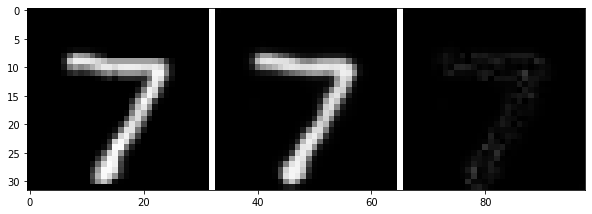

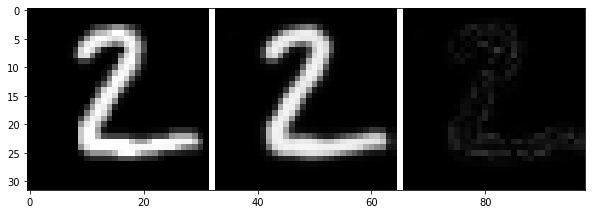

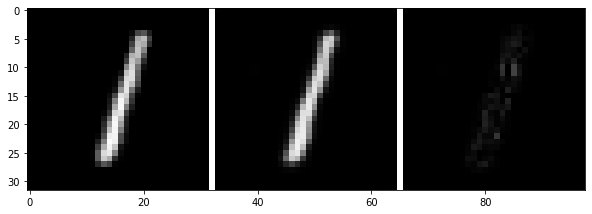

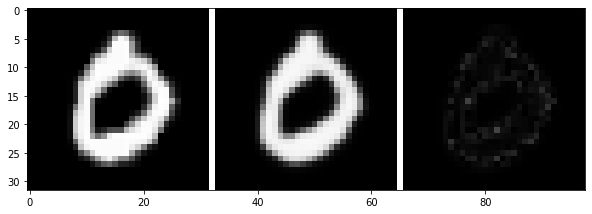

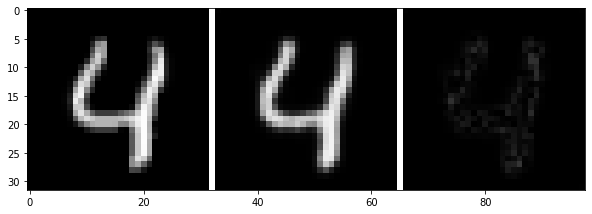

04/06/2020 11:24:03, epoch=66, step=7800, loss=0.00145, distortion=0.002, rate=0.355, -elbo=253.28938, nll=1.16428, KL=252.12511, commit_loss=67.68932, bit_usage=0.98985, highest_prob=0.005, temp=0.37347
04/06/2020 11:24:05, epoch=66, step=7820, loss=0.00144, distortion=0.002, rate=0.357, -elbo=254.22981, nll=1.15768, KL=253.07214, commit_loss=67.77879, bit_usage=0.98977, highest_prob=0.005, temp=0.37272
04/06/2020 11:24:07, epoch=66, step=7840, loss=0.00152, distortion=0.002, rate=0.359, -elbo=256.25381, nll=1.23569, KL=255.01814, commit_loss=68.08961, bit_usage=0.98998, highest_prob=0.006, temp=0.37197
04/06/2020 11:24:09, epoch=66, step=7860, loss=0.00152, distortion=0.002, rate=0.362, -elbo=258.42474, nll=1.23320, KL=257.19153, commit_loss=68.49052, bit_usage=0.98998, highest_prob=0.006, temp=0.37121
reset code 32
04/06/2020 11:24:12, epoch=66, step=7880, loss=0.00151, distortion=0.002, rate=0.356, -elbo=253.93491, nll=1.22376, KL=252.71115, commit_loss=67.25498, bit_usage=0.99046,

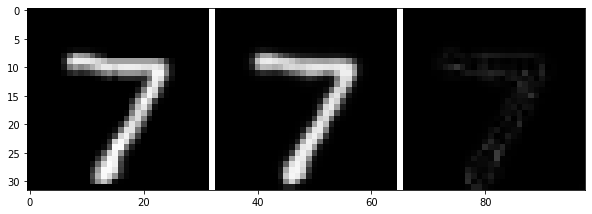

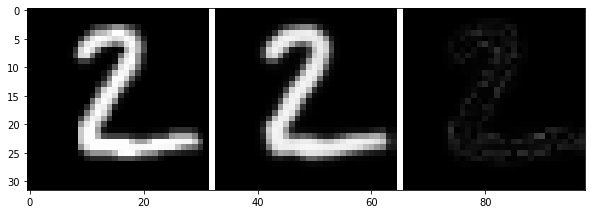

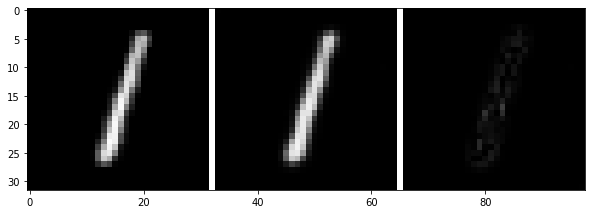

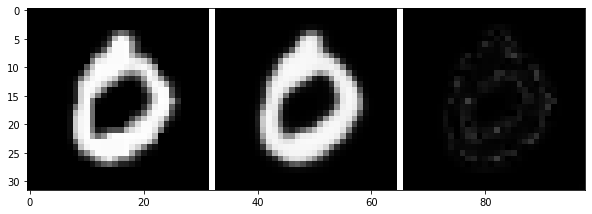

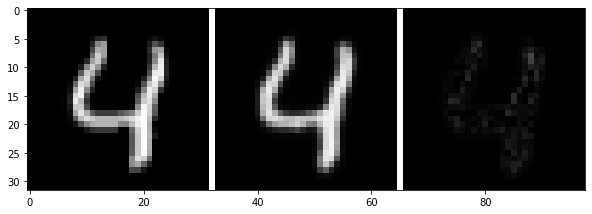

04/06/2020 11:25:11, epoch=71, step=8380, loss=0.00161, distortion=0.002, rate=0.359, -elbo=256.42920, nll=1.32954, KL=255.09967, commit_loss=65.76405, bit_usage=0.99017, highest_prob=0.006, temp=0.35165
04/06/2020 11:25:13, epoch=71, step=8400, loss=0.00147, distortion=0.002, rate=0.361, -elbo=257.12473, nll=1.17981, KL=255.94492, commit_loss=66.04552, bit_usage=0.99048, highest_prob=0.006, temp=0.35089
04/06/2020 11:25:16, epoch=71, step=8420, loss=0.00143, distortion=0.002, rate=0.357, -elbo=254.69276, nll=1.14657, KL=253.54620, commit_loss=65.09164, bit_usage=0.99032, highest_prob=0.006, temp=0.35014
04/06/2020 11:25:18, epoch=71, step=8440, loss=0.00142, distortion=0.002, rate=0.356, -elbo=254.02684, nll=1.13936, KL=252.88748, commit_loss=65.19678, bit_usage=0.99035, highest_prob=0.006, temp=0.34939
04/06/2020 11:25:20, epoch=71, step=8460, loss=0.00150, distortion=0.002, rate=0.359, -elbo=255.94289, nll=1.21813, KL=254.72476, commit_loss=65.55056, bit_usage=0.99054, highest_prob=

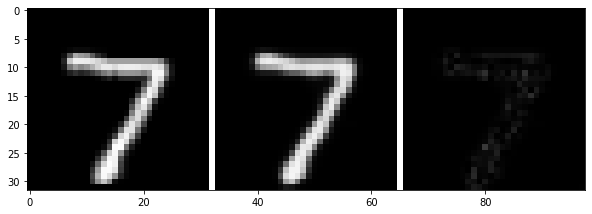

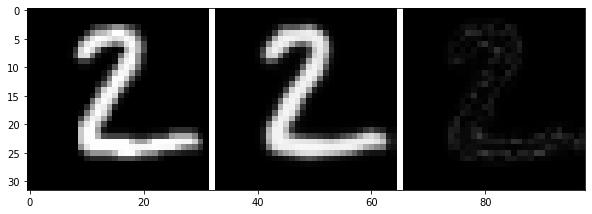

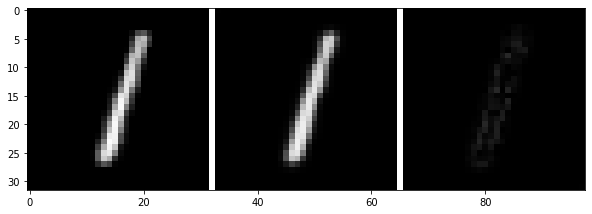

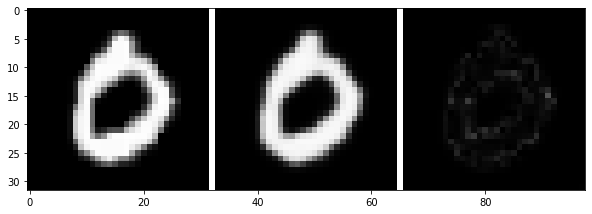

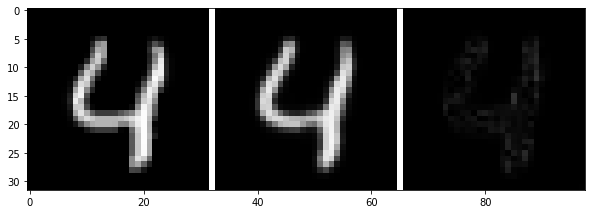

04/06/2020 11:26:22, epoch=76, step=8980, loss=0.00143, distortion=0.002, rate=0.354, -elbo=252.38260, nll=1.14737, KL=251.23523, commit_loss=62.62200, bit_usage=0.99090, highest_prob=0.005, temp=0.32907
04/06/2020 11:26:24, epoch=76, step=9000, loss=0.00143, distortion=0.002, rate=0.355, -elbo=253.23709, nll=1.14475, KL=252.09235, commit_loss=62.55667, bit_usage=0.99072, highest_prob=0.006, temp=0.32832
04/06/2020 11:26:26, epoch=76, step=9020, loss=0.00139, distortion=0.002, rate=0.361, -elbo=257.54761, nll=1.10175, KL=256.44586, commit_loss=64.14055, bit_usage=0.99121, highest_prob=0.006, temp=0.32757
04/06/2020 11:26:29, epoch=76, step=9040, loss=0.00141, distortion=0.002, rate=0.365, -elbo=260.24774, nll=1.12170, KL=259.12604, commit_loss=64.78259, bit_usage=0.99138, highest_prob=0.006, temp=0.32681
04/06/2020 11:26:31, epoch=76, step=9060, loss=0.00142, distortion=0.002, rate=0.359, -elbo=255.74811, nll=1.13690, KL=254.61121, commit_loss=63.11170, bit_usage=0.99098, highest_prob=

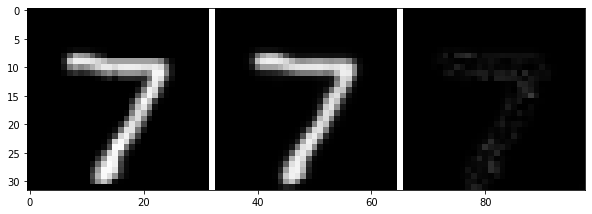

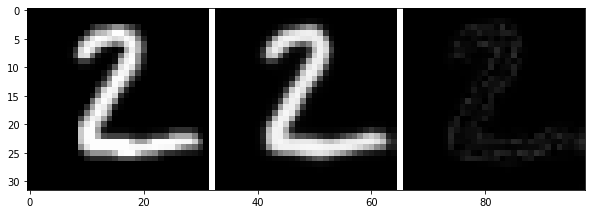

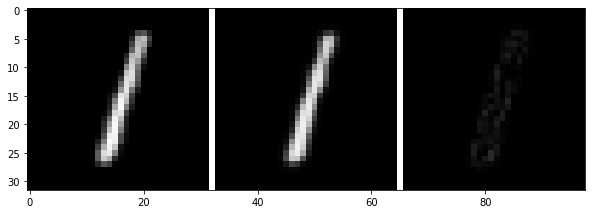

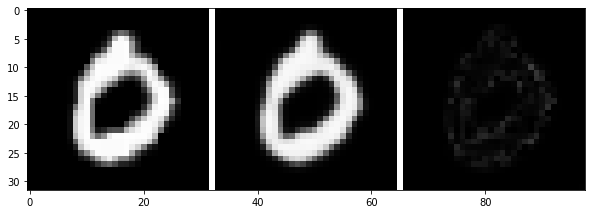

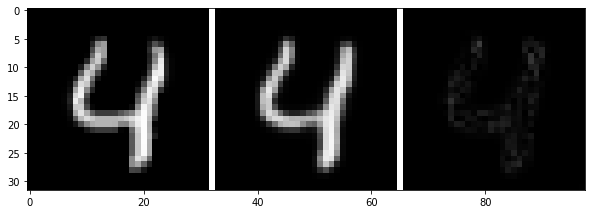

04/06/2020 11:27:32, epoch=81, step=9560, loss=0.00142, distortion=0.002, rate=0.365, -elbo=260.54037, nll=1.12677, KL=259.41360, commit_loss=63.54781, bit_usage=0.99114, highest_prob=0.007, temp=0.30725
04/06/2020 11:27:34, epoch=81, step=9580, loss=0.00136, distortion=0.002, rate=0.361, -elbo=257.22159, nll=1.07755, KL=256.14404, commit_loss=62.62888, bit_usage=0.99088, highest_prob=0.006, temp=0.30649
04/06/2020 11:27:37, epoch=81, step=9600, loss=0.00144, distortion=0.002, rate=0.363, -elbo=258.53922, nll=1.15688, KL=257.38232, commit_loss=62.96226, bit_usage=0.99122, highest_prob=0.006, temp=0.30574
04/06/2020 11:27:39, epoch=81, step=9620, loss=0.00143, distortion=0.002, rate=0.361, -elbo=257.56595, nll=1.14232, KL=256.42361, commit_loss=62.45099, bit_usage=0.99092, highest_prob=0.006, temp=0.30499
04/06/2020 11:27:41, epoch=81, step=9640, loss=0.00143, distortion=0.002, rate=0.366, -elbo=260.88892, nll=1.13819, KL=259.75073, commit_loss=63.83872, bit_usage=0.99147, highest_prob=

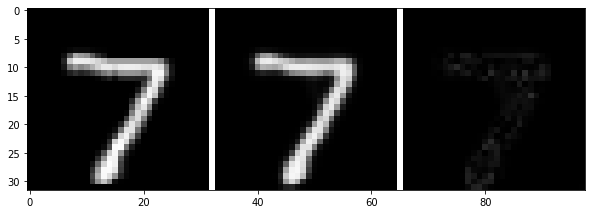

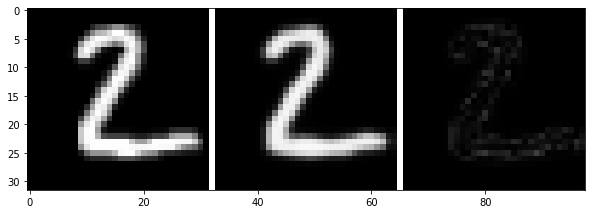

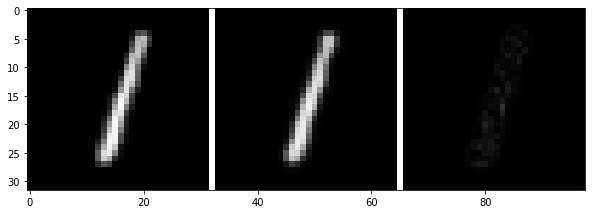

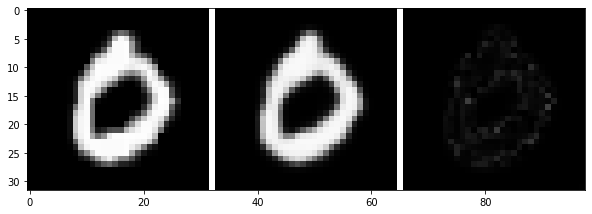

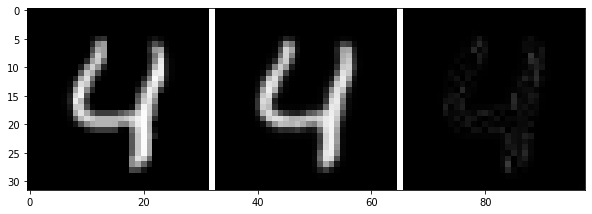

04/06/2020 11:28:45, epoch=86, step=10160, loss=0.00141, distortion=0.002, rate=0.359, -elbo=255.86319, nll=1.13297, KL=254.73022, commit_loss=60.56998, bit_usage=0.99077, highest_prob=0.006, temp=0.28467
04/06/2020 11:28:47, epoch=86, step=10180, loss=0.00139, distortion=0.002, rate=0.364, -elbo=259.45020, nll=1.10521, KL=258.34497, commit_loss=61.78781, bit_usage=0.99099, highest_prob=0.007, temp=0.28392
04/06/2020 11:28:49, epoch=86, step=10200, loss=0.00141, distortion=0.002, rate=0.363, -elbo=258.81430, nll=1.12564, KL=257.68866, commit_loss=61.98609, bit_usage=0.99070, highest_prob=0.007, temp=0.28317
04/06/2020 11:28:52, epoch=86, step=10220, loss=0.00137, distortion=0.002, rate=0.362, -elbo=258.33786, nll=1.08255, KL=257.25531, commit_loss=61.26041, bit_usage=0.99061, highest_prob=0.007, temp=0.28241
04/06/2020 11:28:54, epoch=86, step=10240, loss=0.00137, distortion=0.002, rate=0.364, -elbo=259.66132, nll=1.08204, KL=258.57928, commit_loss=61.79828, bit_usage=0.99097, highest_

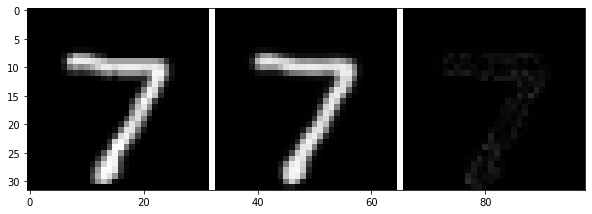

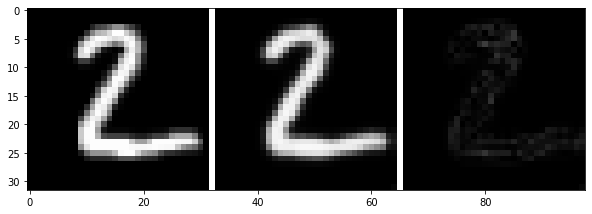

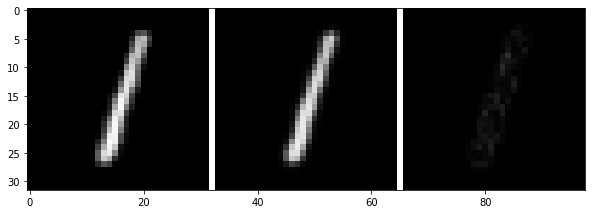

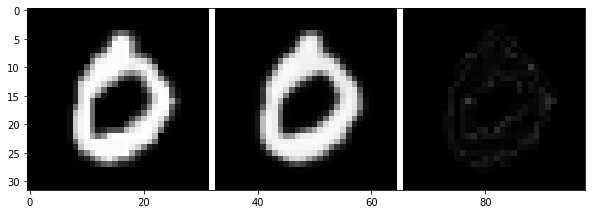

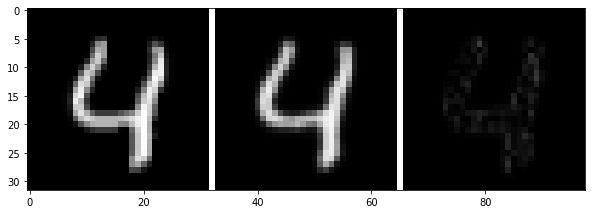

04/06/2020 11:29:53, epoch=91, step=10740, loss=0.00137, distortion=0.002, rate=0.364, -elbo=259.43640, nll=1.08820, KL=258.34821, commit_loss=60.30448, bit_usage=0.99070, highest_prob=0.007, temp=0.26285
04/06/2020 11:29:55, epoch=91, step=10760, loss=0.00138, distortion=0.002, rate=0.367, -elbo=261.46042, nll=1.08858, KL=260.37183, commit_loss=61.29774, bit_usage=0.99090, highest_prob=0.007, temp=0.26209
04/06/2020 11:29:58, epoch=91, step=10780, loss=0.00137, distortion=0.002, rate=0.362, -elbo=258.07162, nll=1.08454, KL=256.98709, commit_loss=60.15854, bit_usage=0.99081, highest_prob=0.007, temp=0.26134
04/06/2020 11:30:00, epoch=91, step=10800, loss=0.00135, distortion=0.001, rate=0.365, -elbo=260.19418, nll=1.06161, KL=259.13257, commit_loss=60.48824, bit_usage=0.99085, highest_prob=0.007, temp=0.26059
04/06/2020 11:30:02, epoch=91, step=10820, loss=0.00142, distortion=0.002, rate=0.364, -elbo=259.78958, nll=1.13320, KL=258.65637, commit_loss=60.52116, bit_usage=0.99084, highest_

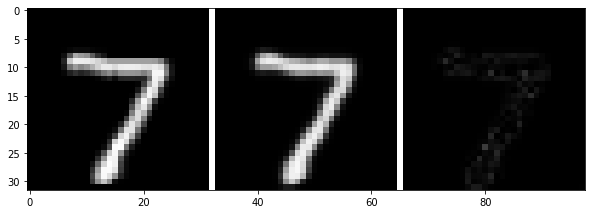

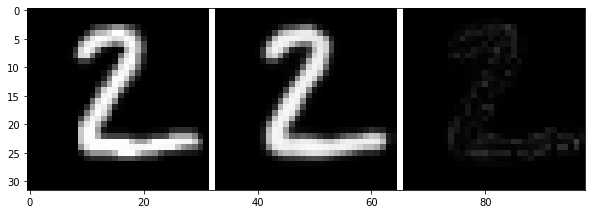

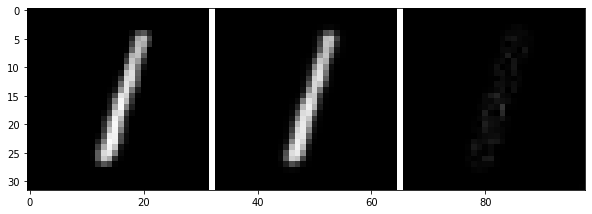

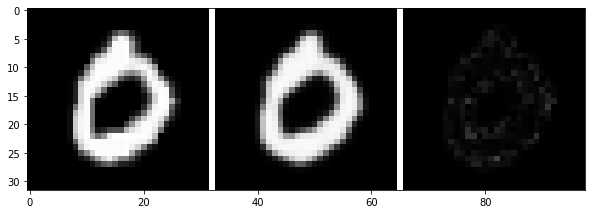

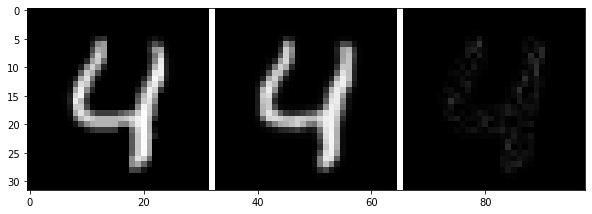

04/06/2020 11:31:04, epoch=96, step=11340, loss=0.00136, distortion=0.002, rate=0.368, -elbo=262.48627, nll=1.07498, KL=261.41129, commit_loss=60.40440, bit_usage=0.99047, highest_prob=0.008, temp=0.24027
04/06/2020 11:31:06, epoch=96, step=11360, loss=0.00136, distortion=0.002, rate=0.368, -elbo=261.94299, nll=1.07023, KL=260.87277, commit_loss=60.02694, bit_usage=0.99054, highest_prob=0.008, temp=0.23952
04/06/2020 11:31:09, epoch=96, step=11380, loss=0.00146, distortion=0.002, rate=0.368, -elbo=262.15671, nll=1.17494, KL=260.98175, commit_loss=60.45938, bit_usage=0.99080, highest_prob=0.007, temp=0.23877
04/06/2020 11:31:11, epoch=96, step=11400, loss=0.00134, distortion=0.001, rate=0.366, -elbo=260.74869, nll=1.05520, KL=259.69348, commit_loss=59.39309, bit_usage=0.99016, highest_prob=0.008, temp=0.23801
04/06/2020 11:31:13, epoch=96, step=11420, loss=0.00131, distortion=0.001, rate=0.363, -elbo=258.95978, nll=1.02546, KL=257.93433, commit_loss=58.88133, bit_usage=0.99024, highest_

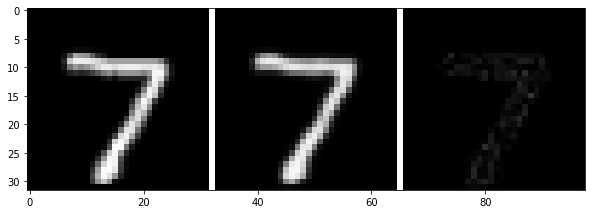

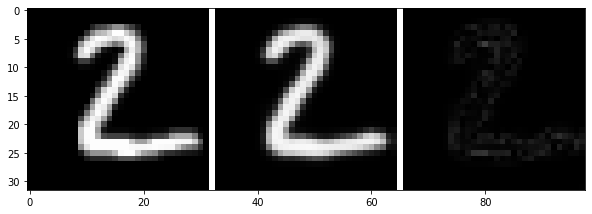

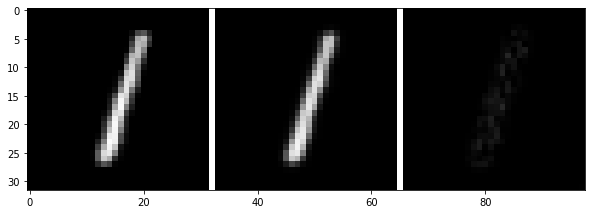

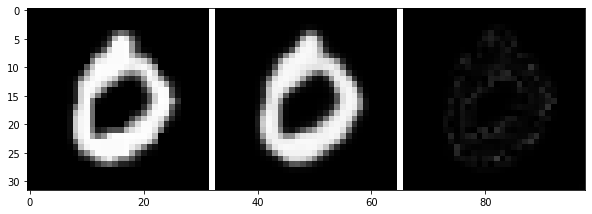

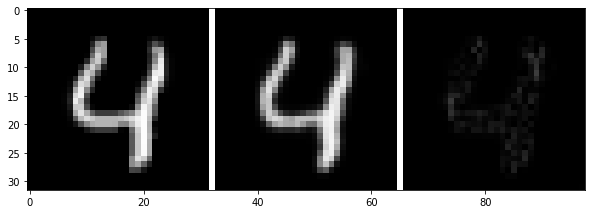

04/06/2020 11:32:12, epoch=101, step=11920, loss=0.00142, distortion=0.002, rate=0.373, -elbo=266.20956, nll=1.12978, KL=265.07977, commit_loss=60.32568, bit_usage=0.99034, highest_prob=0.008, temp=0.21845
04/06/2020 11:32:14, epoch=101, step=11940, loss=0.00135, distortion=0.001, rate=0.370, -elbo=263.76129, nll=1.05662, KL=262.70468, commit_loss=59.58453, bit_usage=0.99036, highest_prob=0.008, temp=0.21769
04/06/2020 11:32:17, epoch=101, step=11960, loss=0.00134, distortion=0.001, rate=0.366, -elbo=260.85739, nll=1.05253, KL=259.80487, commit_loss=58.54486, bit_usage=0.99023, highest_prob=0.008, temp=0.21694
04/06/2020 11:32:19, epoch=101, step=11980, loss=0.00138, distortion=0.002, rate=0.373, -elbo=265.74030, nll=1.08355, KL=264.65674, commit_loss=60.03754, bit_usage=0.99027, highest_prob=0.008, temp=0.21619
04/06/2020 11:32:21, epoch=101, step=12000, loss=0.00143, distortion=0.002, rate=0.372, -elbo=265.48621, nll=1.14435, KL=264.34186, commit_loss=59.78200, bit_usage=0.99026, hig

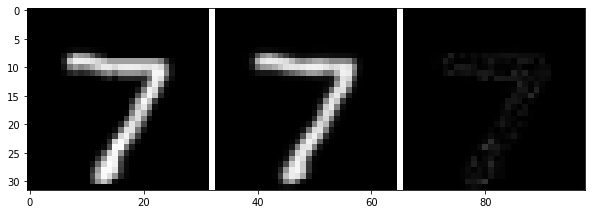

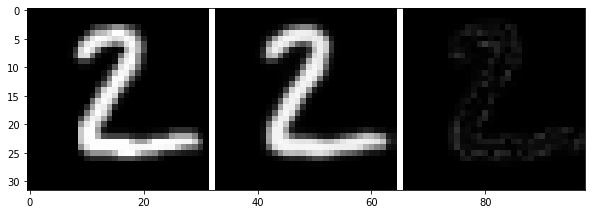

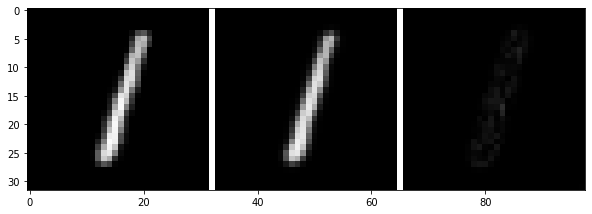

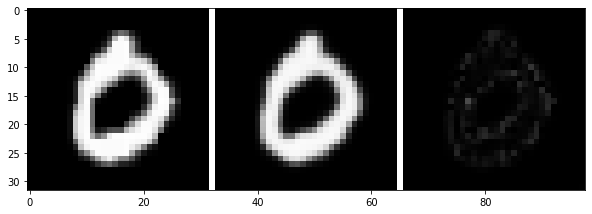

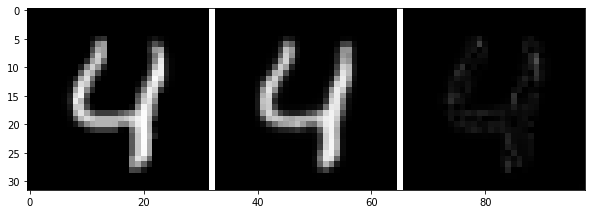

04/06/2020 11:33:24, epoch=106, step=12520, loss=0.00133, distortion=0.001, rate=0.375, -elbo=267.10397, nll=1.03624, KL=266.06775, commit_loss=59.08810, bit_usage=0.98950, highest_prob=0.009, temp=0.19587
04/06/2020 11:33:26, epoch=106, step=12540, loss=0.00139, distortion=0.002, rate=0.377, -elbo=268.37326, nll=1.09224, KL=267.28101, commit_loss=60.16544, bit_usage=0.99004, highest_prob=0.009, temp=0.19512
04/06/2020 11:33:28, epoch=106, step=12560, loss=0.00131, distortion=0.001, rate=0.371, -elbo=264.13849, nll=1.02212, KL=263.11636, commit_loss=58.82515, bit_usage=0.99007, highest_prob=0.008, temp=0.19437
04/06/2020 11:33:31, epoch=106, step=12580, loss=0.00133, distortion=0.001, rate=0.374, -elbo=266.51385, nll=1.03883, KL=265.47504, commit_loss=59.34162, bit_usage=0.98977, highest_prob=0.009, temp=0.19361
04/06/2020 11:33:33, epoch=106, step=12600, loss=0.00137, distortion=0.002, rate=0.375, -elbo=267.02591, nll=1.07499, KL=265.95093, commit_loss=59.17612, bit_usage=0.98959, hig

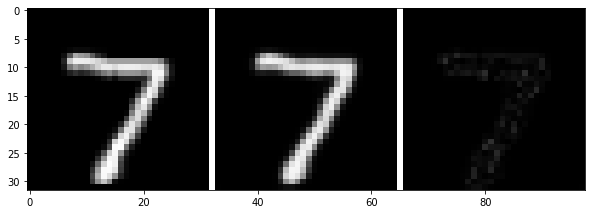

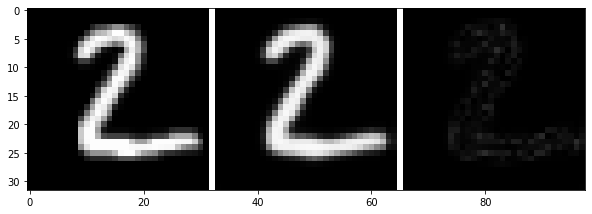

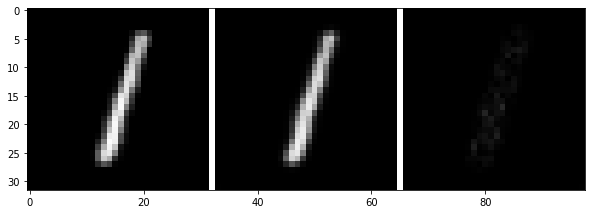

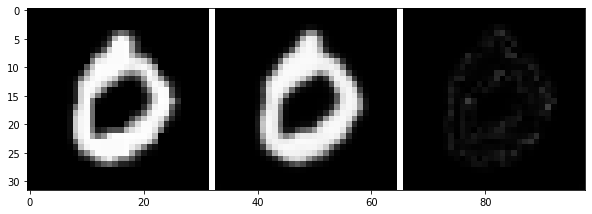

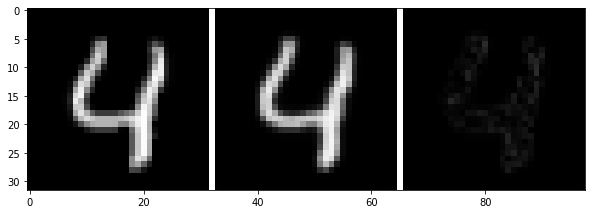

04/06/2020 11:34:35, epoch=111, step=13100, loss=0.00132, distortion=0.001, rate=0.376, -elbo=267.82697, nll=1.02509, KL=266.80188, commit_loss=58.63420, bit_usage=0.98947, highest_prob=0.009, temp=0.17405
04/06/2020 11:34:37, epoch=111, step=13120, loss=0.00132, distortion=0.001, rate=0.377, -elbo=268.31250, nll=1.02086, KL=267.29163, commit_loss=58.79770, bit_usage=0.98938, highest_prob=0.010, temp=0.17329
04/06/2020 11:34:40, epoch=111, step=13140, loss=0.00133, distortion=0.001, rate=0.379, -elbo=269.81781, nll=1.03500, KL=268.78281, commit_loss=59.18826, bit_usage=0.98961, highest_prob=0.010, temp=0.17254
04/06/2020 11:34:42, epoch=111, step=13160, loss=0.00130, distortion=0.001, rate=0.376, -elbo=268.18140, nll=1.00384, KL=267.17755, commit_loss=58.30990, bit_usage=0.98933, highest_prob=0.010, temp=0.17179
04/06/2020 11:34:44, epoch=111, step=13180, loss=0.00131, distortion=0.001, rate=0.379, -elbo=270.23239, nll=1.01469, KL=269.21771, commit_loss=59.48342, bit_usage=0.98939, hig

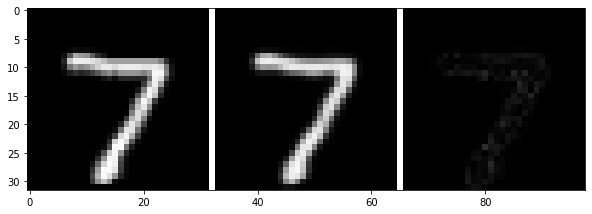

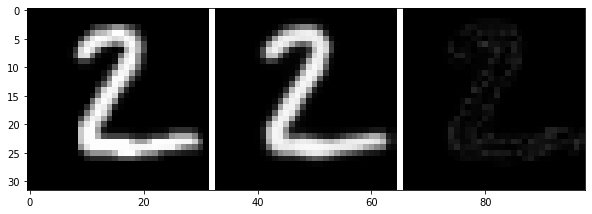

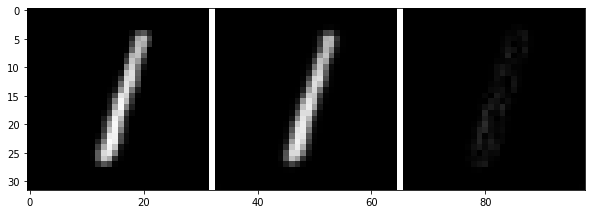

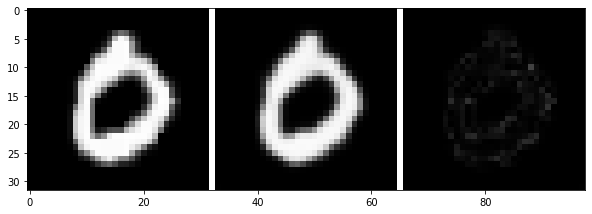

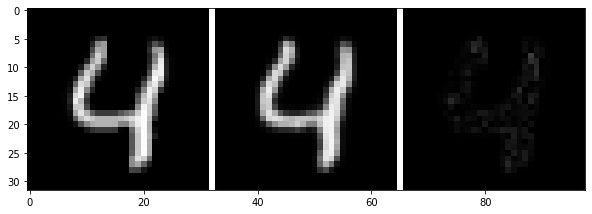

04/06/2020 11:35:47, epoch=116, step=13700, loss=0.00130, distortion=0.001, rate=0.375, -elbo=267.11191, nll=1.00595, KL=266.10596, commit_loss=57.94907, bit_usage=0.98941, highest_prob=0.009, temp=0.15147
04/06/2020 11:35:49, epoch=116, step=13720, loss=0.00130, distortion=0.001, rate=0.377, -elbo=268.69373, nll=1.00579, KL=267.68793, commit_loss=57.98017, bit_usage=0.98918, highest_prob=0.011, temp=0.15072
04/06/2020 11:35:51, epoch=116, step=13740, loss=0.00130, distortion=0.001, rate=0.380, -elbo=270.45065, nll=1.00734, KL=269.44330, commit_loss=58.47983, bit_usage=0.98921, highest_prob=0.011, temp=0.14997
04/06/2020 11:35:54, epoch=116, step=13760, loss=0.00131, distortion=0.001, rate=0.377, -elbo=268.82022, nll=1.01343, KL=267.80679, commit_loss=58.35772, bit_usage=0.98960, highest_prob=0.010, temp=0.14921
04/06/2020 11:35:56, epoch=116, step=13780, loss=0.00130, distortion=0.001, rate=0.378, -elbo=269.24423, nll=1.00373, KL=268.24051, commit_loss=58.20874, bit_usage=0.98943, hig

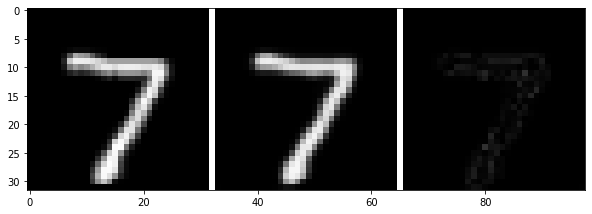

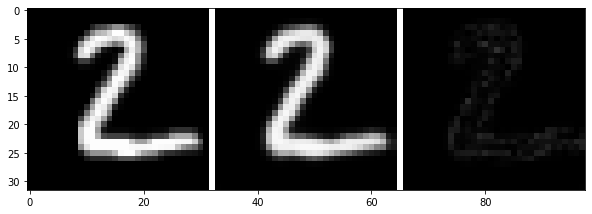

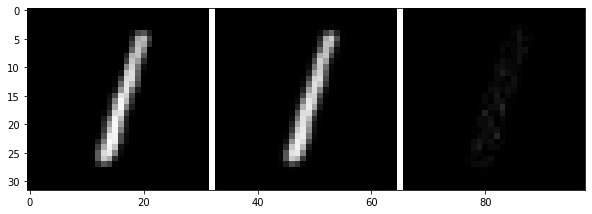

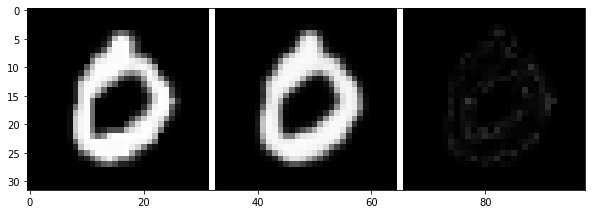

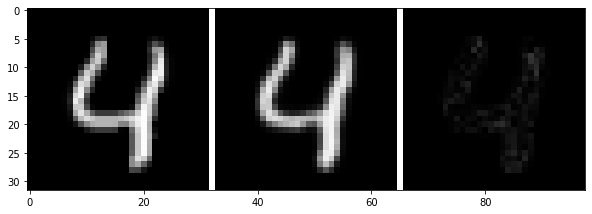

04/06/2020 11:36:56, epoch=121, step=14280, loss=0.00127, distortion=0.001, rate=0.380, -elbo=271.04080, nll=0.97671, KL=270.06409, commit_loss=57.80842, bit_usage=0.98869, highest_prob=0.011, temp=0.12965
04/06/2020 11:36:58, epoch=121, step=14300, loss=0.00128, distortion=0.001, rate=0.375, -elbo=267.50558, nll=0.99100, KL=266.51459, commit_loss=57.28386, bit_usage=0.98926, highest_prob=0.010, temp=0.12889
04/06/2020 11:37:00, epoch=121, step=14320, loss=0.00132, distortion=0.001, rate=0.383, -elbo=272.72751, nll=1.02402, KL=271.70349, commit_loss=58.68343, bit_usage=0.98935, highest_prob=0.011, temp=0.12814
04/06/2020 11:37:02, epoch=121, step=14340, loss=0.00128, distortion=0.001, rate=0.374, -elbo=266.13992, nll=0.98472, KL=265.15521, commit_loss=56.59898, bit_usage=0.98880, highest_prob=0.010, temp=0.12739
04/06/2020 11:37:05, epoch=121, step=14360, loss=0.00128, distortion=0.001, rate=0.377, -elbo=268.64993, nll=0.98863, KL=267.66132, commit_loss=57.27473, bit_usage=0.98893, hig

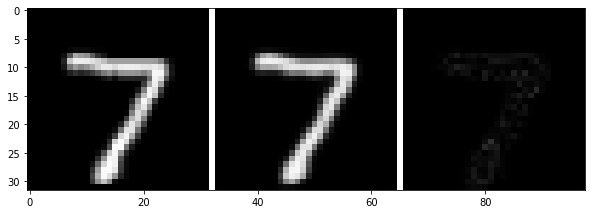

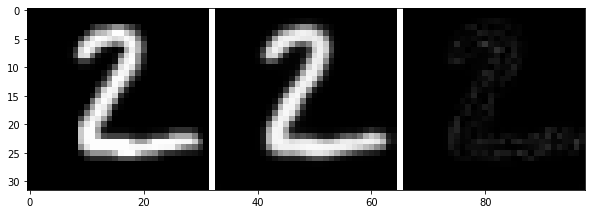

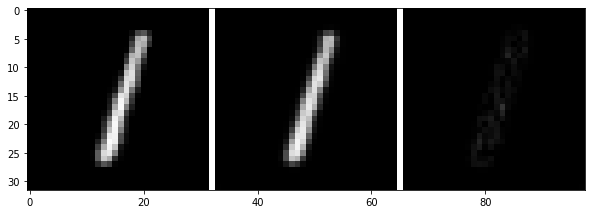

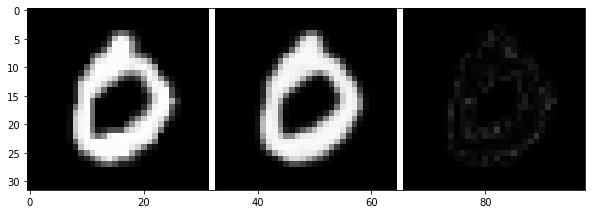

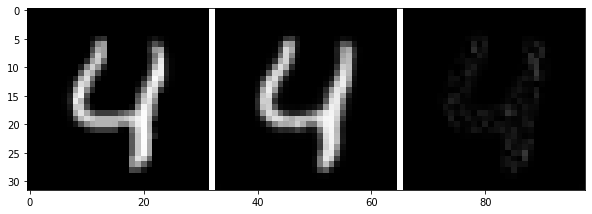

04/06/2020 11:38:07, epoch=126, step=14880, loss=0.00127, distortion=0.001, rate=0.377, -elbo=268.85684, nll=0.97320, KL=267.88364, commit_loss=56.70312, bit_usage=0.98901, highest_prob=0.011, temp=0.10707
04/06/2020 11:38:09, epoch=126, step=14900, loss=0.00130, distortion=0.001, rate=0.383, -elbo=272.85815, nll=0.99761, KL=271.86053, commit_loss=58.01181, bit_usage=0.98900, highest_prob=0.011, temp=0.10632
04/06/2020 11:38:11, epoch=126, step=14920, loss=0.00128, distortion=0.001, rate=0.379, -elbo=269.96545, nll=0.98689, KL=268.97858, commit_loss=57.12002, bit_usage=0.98902, highest_prob=0.011, temp=0.10557
04/06/2020 11:38:14, epoch=126, step=14940, loss=0.00127, distortion=0.001, rate=0.379, -elbo=269.69641, nll=0.97640, KL=268.72000, commit_loss=57.01847, bit_usage=0.98923, highest_prob=0.011, temp=0.10481
04/06/2020 11:38:16, epoch=126, step=14960, loss=0.00129, distortion=0.001, rate=0.381, -elbo=271.77698, nll=0.99732, KL=270.77966, commit_loss=57.53320, bit_usage=0.98914, hig

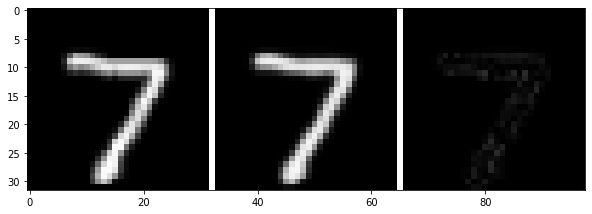

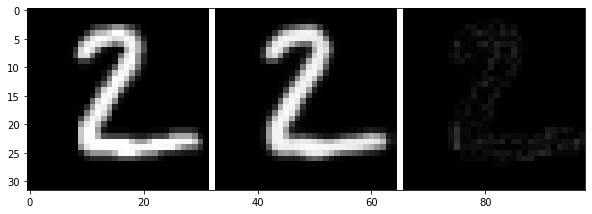

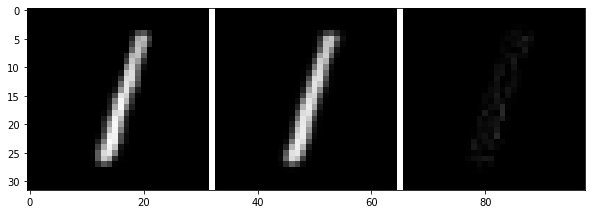

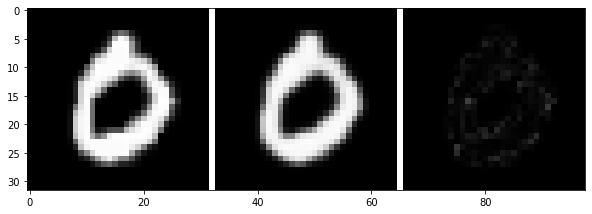

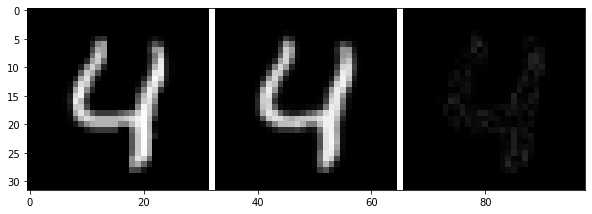

04/06/2020 11:39:15, epoch=131, step=15460, loss=0.00126, distortion=0.001, rate=0.382, -elbo=272.02377, nll=0.96614, KL=271.05765, commit_loss=56.76702, bit_usage=0.98825, highest_prob=0.012, temp=0.08525
04/06/2020 11:39:17, epoch=131, step=15480, loss=0.00128, distortion=0.001, rate=0.383, -elbo=272.77411, nll=0.98433, KL=271.78979, commit_loss=57.19516, bit_usage=0.98837, highest_prob=0.012, temp=0.08449
04/06/2020 11:39:20, epoch=131, step=15500, loss=0.00127, distortion=0.001, rate=0.380, -elbo=270.94534, nll=0.97766, KL=269.96768, commit_loss=56.60826, bit_usage=0.98856, highest_prob=0.012, temp=0.08374
04/06/2020 11:39:22, epoch=131, step=15520, loss=0.00131, distortion=0.001, rate=0.387, -elbo=275.33868, nll=1.00701, KL=274.33167, commit_loss=57.94027, bit_usage=0.98855, highest_prob=0.013, temp=0.08299
04/06/2020 11:39:24, epoch=131, step=15540, loss=0.00128, distortion=0.001, rate=0.385, -elbo=274.29892, nll=0.97714, KL=273.32178, commit_loss=57.44152, bit_usage=0.98871, hig

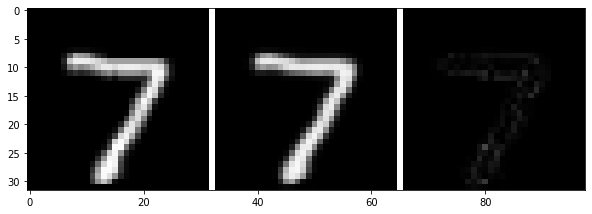

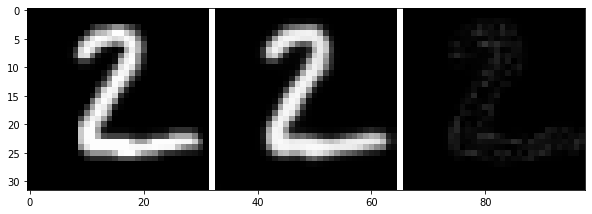

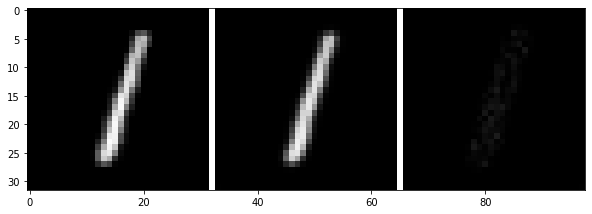

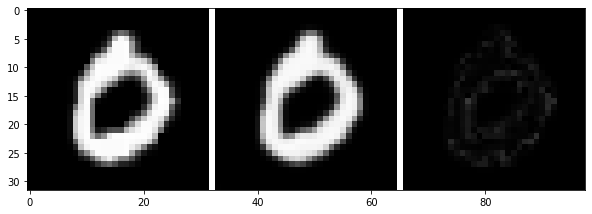

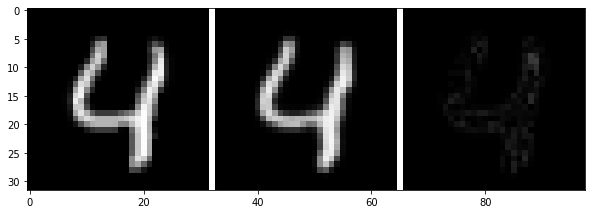

04/06/2020 11:40:27, epoch=136, step=16060, loss=0.00127, distortion=0.001, rate=0.385, -elbo=274.26373, nll=0.96891, KL=273.29483, commit_loss=57.12305, bit_usage=0.98831, highest_prob=0.013, temp=0.06267
04/06/2020 11:40:29, epoch=136, step=16080, loss=0.00128, distortion=0.001, rate=0.383, -elbo=272.81207, nll=0.98468, KL=271.82739, commit_loss=57.40012, bit_usage=0.98875, highest_prob=0.012, temp=0.06192
04/06/2020 11:40:31, epoch=136, step=16100, loss=0.00130, distortion=0.001, rate=0.387, -elbo=275.76535, nll=0.99681, KL=274.76855, commit_loss=57.50578, bit_usage=0.98834, highest_prob=0.012, temp=0.06117
04/06/2020 11:40:34, epoch=136, step=16120, loss=0.00125, distortion=0.001, rate=0.383, -elbo=272.92966, nll=0.95558, KL=271.97406, commit_loss=56.43569, bit_usage=0.98768, highest_prob=0.013, temp=0.06041
04/06/2020 11:40:36, epoch=136, step=16140, loss=0.00127, distortion=0.001, rate=0.383, -elbo=273.11603, nll=0.97482, KL=272.14120, commit_loss=57.06797, bit_usage=0.98827, hig

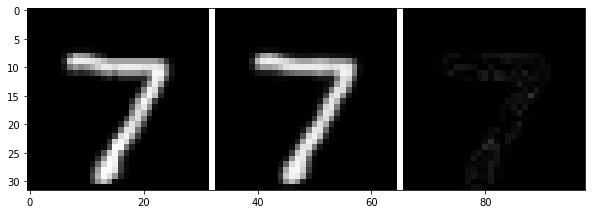

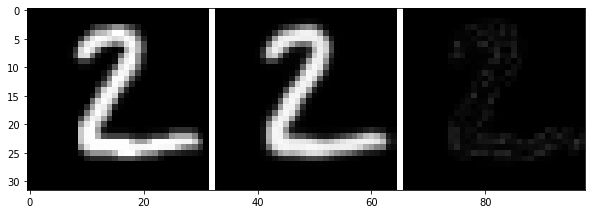

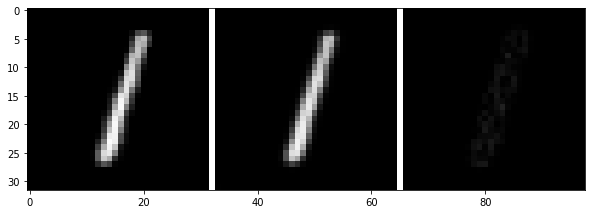

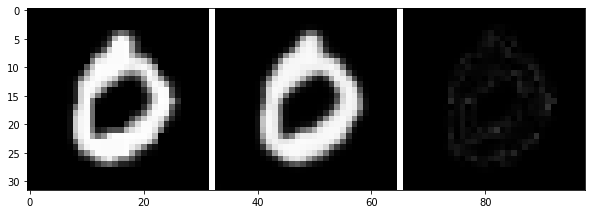

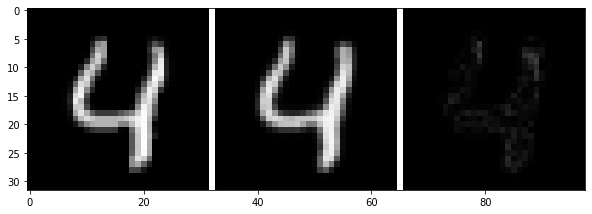

04/06/2020 11:41:37, epoch=141, step=16640, loss=0.00129, distortion=0.001, rate=0.386, -elbo=274.93668, nll=0.98823, KL=273.94846, commit_loss=56.71983, bit_usage=0.98853, highest_prob=0.013, temp=0.04085
04/06/2020 11:41:39, epoch=141, step=16660, loss=0.00130, distortion=0.001, rate=0.389, -elbo=277.44937, nll=0.99359, KL=276.45578, commit_loss=57.98227, bit_usage=0.98820, highest_prob=0.013, temp=0.04009
04/06/2020 11:41:42, epoch=141, step=16680, loss=0.00126, distortion=0.001, rate=0.387, -elbo=275.30869, nll=0.96042, KL=274.34827, commit_loss=56.88983, bit_usage=0.98794, highest_prob=0.014, temp=0.03934
04/06/2020 11:41:44, epoch=141, step=16700, loss=0.00132, distortion=0.001, rate=0.391, -elbo=278.36371, nll=1.01409, KL=277.34961, commit_loss=58.13573, bit_usage=0.98789, highest_prob=0.013, temp=0.03859
04/06/2020 11:41:46, epoch=141, step=16720, loss=0.00128, distortion=0.001, rate=0.385, -elbo=274.16052, nll=0.98360, KL=273.17691, commit_loss=56.80461, bit_usage=0.98819, hig

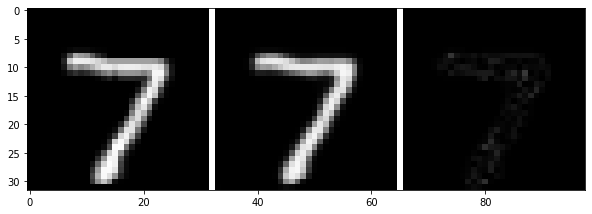

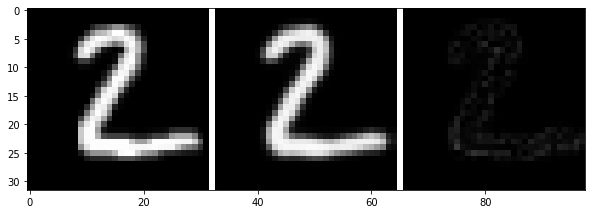

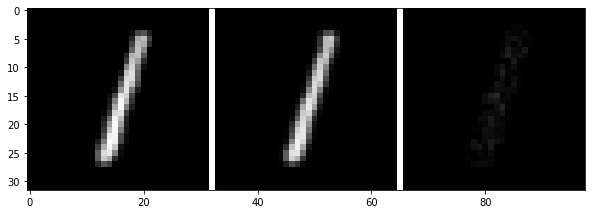

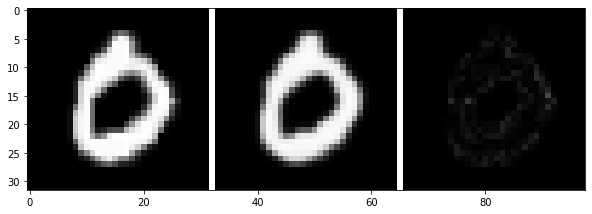

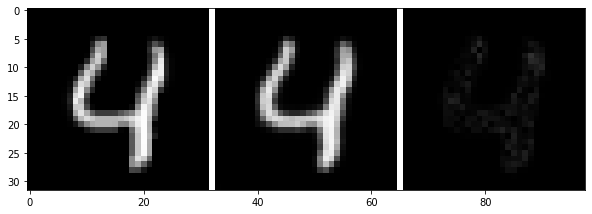

04/06/2020 11:42:48, epoch=146, step=17240, loss=0.00128, distortion=0.001, rate=0.391, -elbo=278.47803, nll=0.97962, KL=277.49841, commit_loss=57.99205, bit_usage=0.98789, highest_prob=0.014, temp=0.01827
04/06/2020 11:42:51, epoch=146, step=17260, loss=0.00127, distortion=0.001, rate=0.384, -elbo=273.84341, nll=0.97436, KL=272.86905, commit_loss=56.56365, bit_usage=0.98819, highest_prob=0.012, temp=0.01752
04/06/2020 11:42:53, epoch=146, step=17280, loss=0.00126, distortion=0.001, rate=0.385, -elbo=274.09497, nll=0.96501, KL=273.12997, commit_loss=56.63385, bit_usage=0.98794, highest_prob=0.013, temp=0.01677
04/06/2020 11:42:55, epoch=146, step=17300, loss=0.00127, distortion=0.001, rate=0.392, -elbo=279.48016, nll=0.96686, KL=278.51331, commit_loss=57.88754, bit_usage=0.98770, highest_prob=0.015, temp=0.01601
04/06/2020 11:42:58, epoch=146, step=17320, loss=0.00129, distortion=0.001, rate=0.390, -elbo=278.14133, nll=0.98292, KL=277.15842, commit_loss=57.49455, bit_usage=0.98811, hig

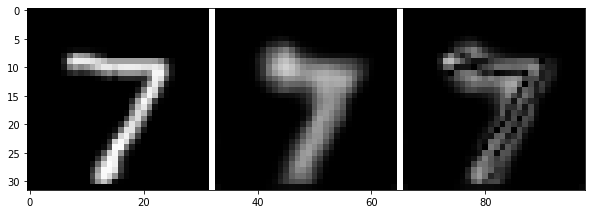

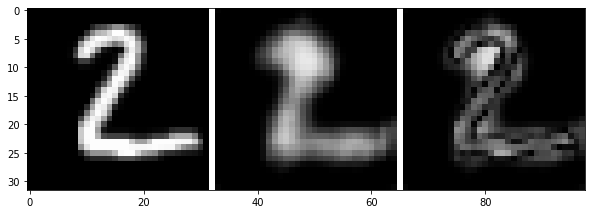

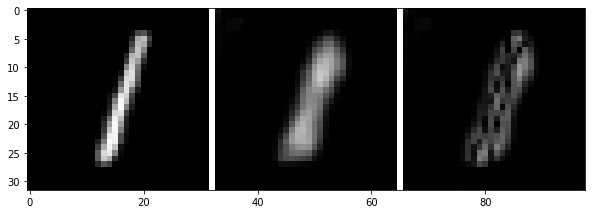

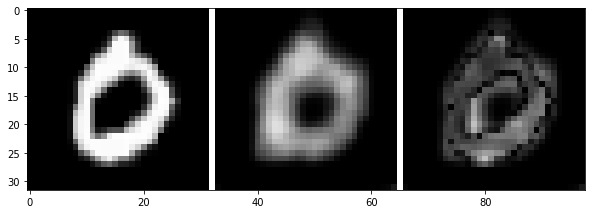

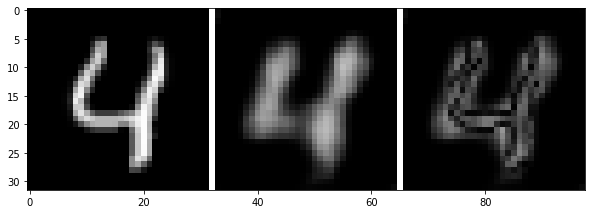

04/06/2020 11:43:49, epoch=1, step=120, loss=0.38556, distortion=0.556, rate=0.023, -elbo=6575.27588, nll=6314.30371, KL=260.97235, commit_loss=2449.09766, bit_usage=0.40929, highest_prob=0.135, temp=0.66245
reset code 96
04/06/2020 11:43:50, epoch=1, step=140, loss=0.35402, distortion=0.511, rate=0.022, -elbo=6052.31934, nll=5797.58984, KL=254.72945, commit_loss=2458.51562, bit_usage=0.43039, highest_prob=0.112, temp=0.66169
reset code 112
04/06/2020 11:43:51, epoch=1, step=160, loss=0.31542, distortion=0.455, rate=0.022, -elbo=5413.81201, nll=5165.16406, KL=248.64780, commit_loss=2507.72266, bit_usage=0.46032, highest_prob=0.098, temp=0.66094
reset code 128
04/06/2020 11:43:52, epoch=1, step=180, loss=0.27281, distortion=0.393, rate=0.022, -elbo=4711.28906, nll=4466.95508, KL=244.33423, commit_loss=2528.19189, bit_usage=0.47727, highest_prob=0.091, temp=0.66019
reset code 160
04/06/2020 11:43:53, epoch=1, step=200, loss=0.25180, distortion=0.363, rate=0.021, -elbo=4363.58105, nll=412

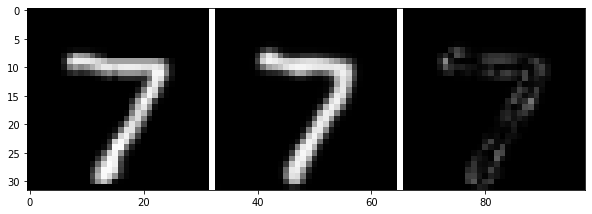

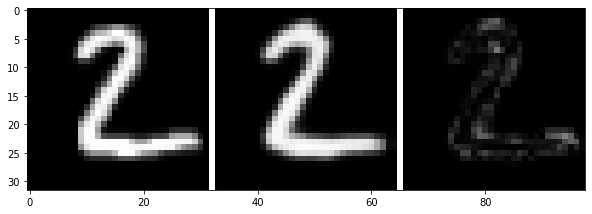

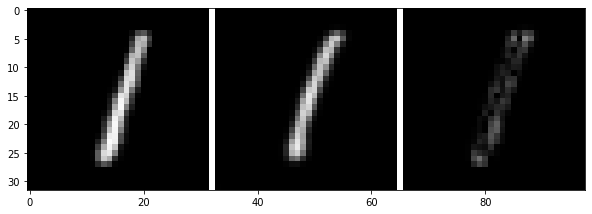

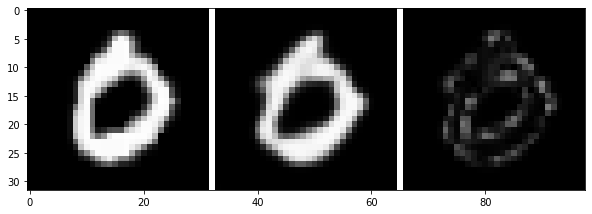

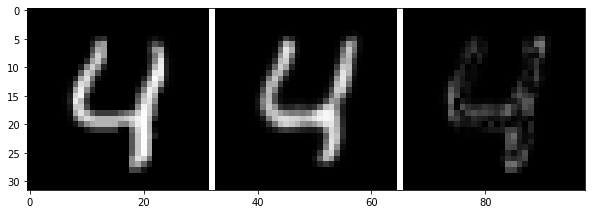

04/06/2020 11:44:20, epoch=6, step=720, loss=0.07591, distortion=0.109, rate=0.018, -elbo=1448.56995, nll=1240.25293, KL=208.31699, commit_loss=3265.82715, bit_usage=0.69949, highest_prob=0.039, temp=0.63987
reset code 116
04/06/2020 11:44:21, epoch=6, step=740, loss=0.07250, distortion=0.104, rate=0.018, -elbo=1392.65686, nll=1184.35413, KL=208.30276, commit_loss=3288.75342, bit_usage=0.70174, highest_prob=0.048, temp=0.63912
reset code 132
04/06/2020 11:44:22, epoch=6, step=760, loss=0.07315, distortion=0.105, rate=0.018, -elbo=1404.76526, nll=1194.95386, KL=209.81143, commit_loss=3378.19434, bit_usage=0.70675, highest_prob=0.053, temp=0.63837
reset code 180
04/06/2020 11:44:23, epoch=6, step=780, loss=0.06940, distortion=0.100, rate=0.018, -elbo=1339.81519, nll=1133.57666, KL=206.23849, commit_loss=3334.90869, bit_usage=0.71259, highest_prob=0.040, temp=0.63761
reset code 196
04/06/2020 11:44:24, epoch=6, step=800, loss=0.06945, distortion=0.100, rate=0.018, -elbo=1339.99060, nll=11

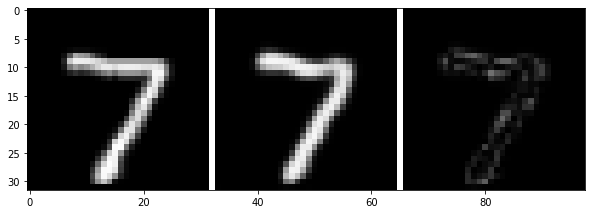

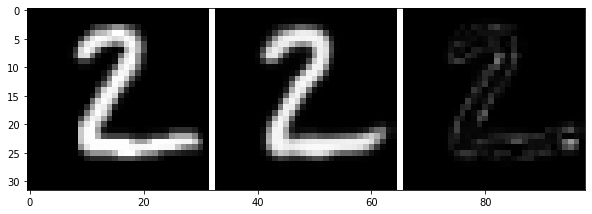

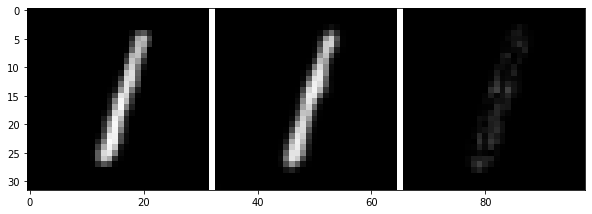

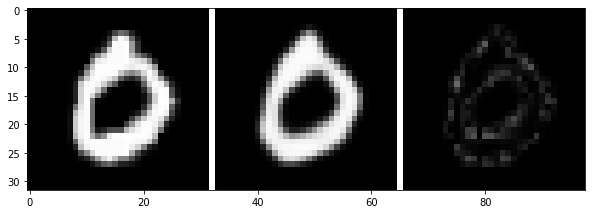

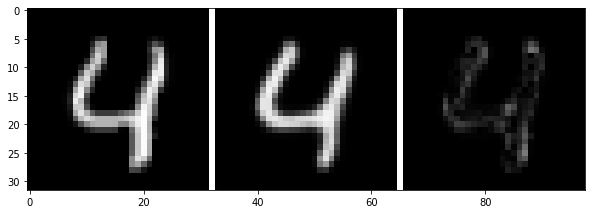

04/06/2020 11:44:50, epoch=11, step=1300, loss=0.04297, distortion=0.062, rate=0.018, -elbo=901.24139, nll=699.13171, KL=202.10970, commit_loss=4633.95264, bit_usage=0.77853, highest_prob=0.032, temp=0.61805
reset code 10
04/06/2020 11:44:51, epoch=11, step=1320, loss=0.04294, distortion=0.062, rate=0.018, -elbo=900.44714, nll=698.54163, KL=201.90555, commit_loss=4773.35840, bit_usage=0.78266, highest_prob=0.030, temp=0.61729
reset code 210
04/06/2020 11:44:52, epoch=11, step=1340, loss=0.04113, distortion=0.059, rate=0.018, -elbo=871.19666, nll=668.85974, KL=202.33694, commit_loss=4848.58398, bit_usage=0.78168, highest_prob=0.031, temp=0.61654
reset code 26
04/06/2020 11:44:53, epoch=11, step=1360, loss=0.04051, distortion=0.058, rate=0.018, -elbo=861.99292, nll=658.60974, KL=203.38321, commit_loss=4964.20898, bit_usage=0.78601, highest_prob=0.028, temp=0.61579
reset code 58
04/06/2020 11:44:54, epoch=11, step=1380, loss=0.03938, distortion=0.056, rate=0.018, -elbo=841.98547, nll=639.

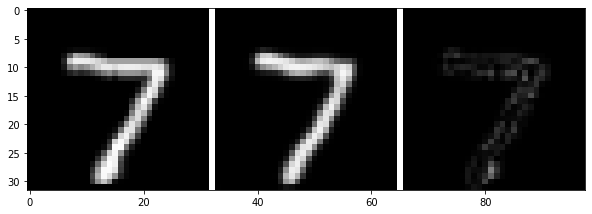

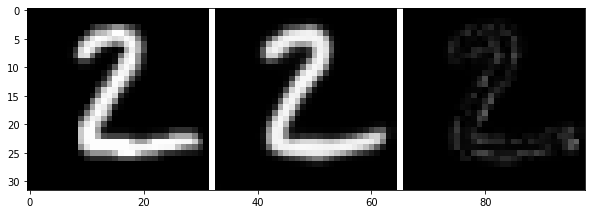

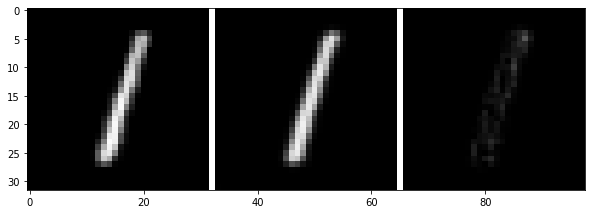

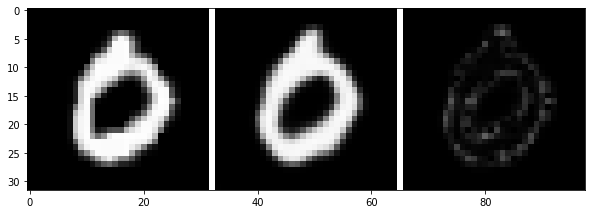

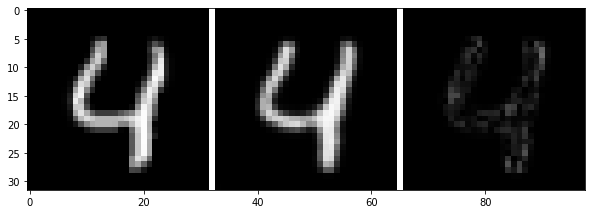

04/06/2020 11:45:21, epoch=16, step=1900, loss=0.03050, distortion=0.043, rate=0.018, -elbo=698.16833, nll=492.57733, KL=205.59097, commit_loss=7001.69141, bit_usage=0.81338, highest_prob=0.027, temp=0.59547
reset code 62
04/06/2020 11:45:22, epoch=16, step=1920, loss=0.02962, distortion=0.042, rate=0.018, -elbo=681.70770, nll=478.11911, KL=203.58861, commit_loss=6956.36328, bit_usage=0.81663, highest_prob=0.027, temp=0.59472
reset code 94
04/06/2020 11:45:23, epoch=16, step=1940, loss=0.02919, distortion=0.041, rate=0.018, -elbo=673.00995, nll=471.21829, KL=201.79164, commit_loss=6794.93066, bit_usage=0.82100, highest_prob=0.031, temp=0.59397
reset code 46
04/06/2020 11:45:24, epoch=16, step=1960, loss=0.02985, distortion=0.042, rate=0.018, -elbo=685.81500, nll=481.62726, KL=204.18773, commit_loss=7167.37549, bit_usage=0.82077, highest_prob=0.032, temp=0.59321
reset code 56
04/06/2020 11:45:25, epoch=16, step=1980, loss=0.02945, distortion=0.042, rate=0.018, -elbo=680.00494, nll=475.2

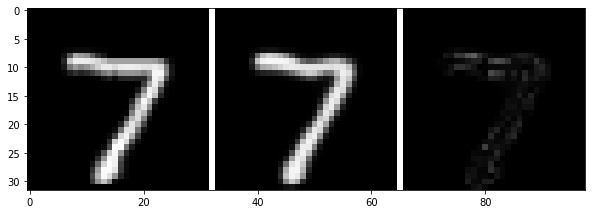

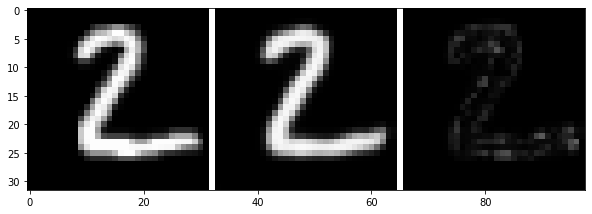

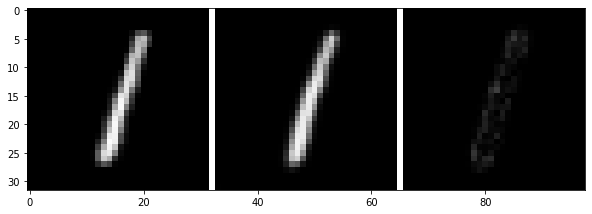

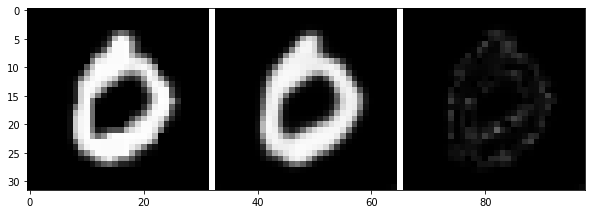

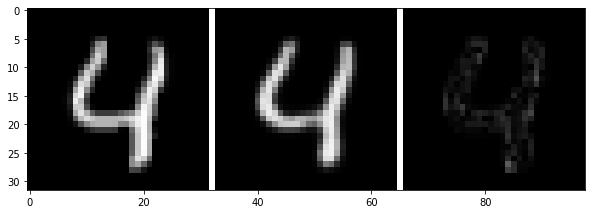

04/06/2020 11:45:51, epoch=21, step=2480, loss=0.02444, distortion=0.035, rate=0.017, -elbo=588.99139, nll=392.39017, KL=196.60121, commit_loss=7809.82861, bit_usage=0.86418, highest_prob=0.018, temp=0.57365
reset code 9
04/06/2020 11:45:52, epoch=21, step=2500, loss=0.02519, distortion=0.036, rate=0.018, -elbo=603.73486, nll=404.31558, KL=199.41928, commit_loss=8253.89453, bit_usage=0.86618, highest_prob=0.017, temp=0.57289
reset code 25
04/06/2020 11:45:53, epoch=21, step=2520, loss=0.02470, distortion=0.035, rate=0.017, -elbo=593.76111, nll=396.35126, KL=197.40988, commit_loss=8086.50195, bit_usage=0.86899, highest_prob=0.019, temp=0.57214
reset code 41
04/06/2020 11:45:54, epoch=21, step=2540, loss=0.02413, distortion=0.034, rate=0.017, -elbo=583.58344, nll=387.04553, KL=196.53790, commit_loss=8105.34082, bit_usage=0.87056, highest_prob=0.018, temp=0.57139
reset code 73
04/06/2020 11:45:55, epoch=21, step=2560, loss=0.02457, distortion=0.035, rate=0.017, -elbo=590.85815, nll=394.20

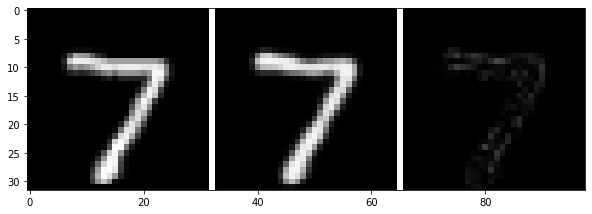

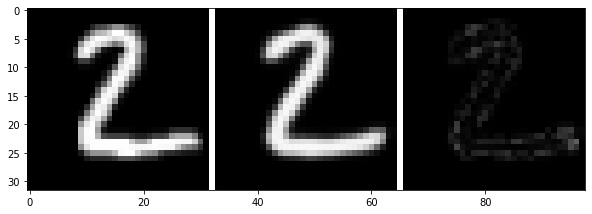

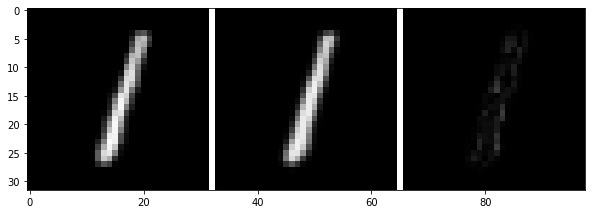

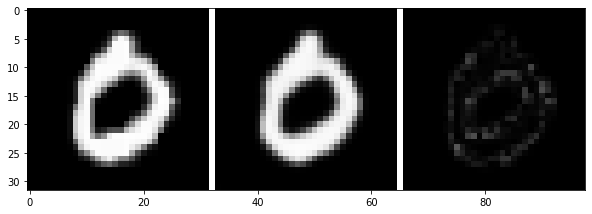

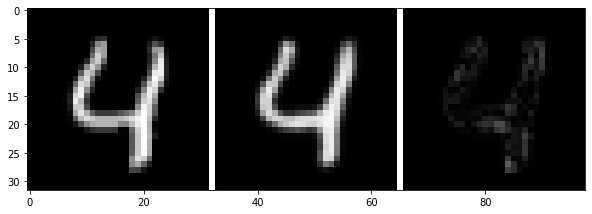

04/06/2020 11:46:24, epoch=26, step=3080, loss=0.02064, distortion=0.029, rate=0.017, -elbo=523.69342, nll=329.12903, KL=194.56439, commit_loss=8859.36523, bit_usage=0.90868, highest_prob=0.015, temp=0.55107
reset code 29
04/06/2020 11:46:25, epoch=26, step=3100, loss=0.02050, distortion=0.029, rate=0.017, -elbo=519.87000, nll=327.01843, KL=192.85159, commit_loss=8639.87695, bit_usage=0.91176, highest_prob=0.014, temp=0.55032
reset code 45
04/06/2020 11:46:26, epoch=26, step=3120, loss=0.02143, distortion=0.030, rate=0.017, -elbo=536.85364, nll=342.02252, KL=194.83109, commit_loss=8932.07031, bit_usage=0.91184, highest_prob=0.017, temp=0.54957
reset code 61
04/06/2020 11:46:27, epoch=26, step=3140, loss=0.02049, distortion=0.029, rate=0.017, -elbo=518.24585, nll=326.98566, KL=191.26019, commit_loss=8511.82031, bit_usage=0.91315, highest_prob=0.013, temp=0.54881
reset code 77
04/06/2020 11:46:28, epoch=26, step=3160, loss=0.02052, distortion=0.029, rate=0.017, -elbo=520.95508, nll=327.1

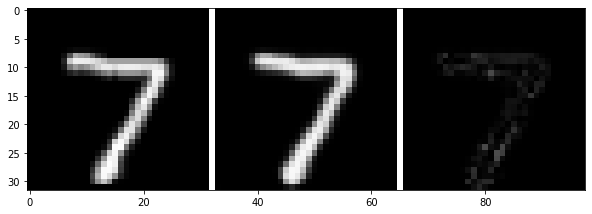

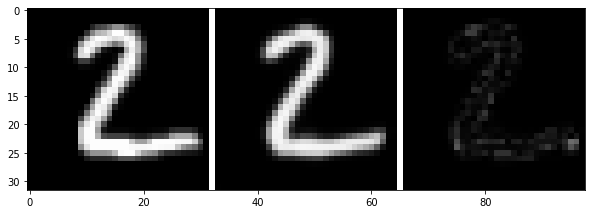

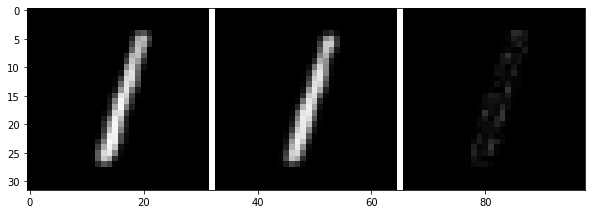

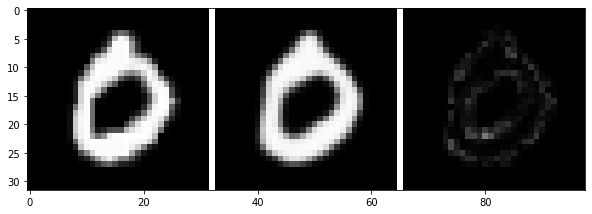

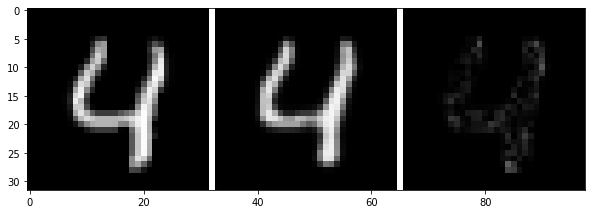

04/06/2020 11:46:54, epoch=31, step=3660, loss=0.01878, distortion=0.026, rate=0.017, -elbo=492.54193, nll=298.22137, KL=194.32057, commit_loss=9279.25586, bit_usage=0.93270, highest_prob=0.013, temp=0.52925
reset code 227
04/06/2020 11:46:55, epoch=31, step=3680, loss=0.01809, distortion=0.025, rate=0.017, -elbo=481.50082, nll=287.03815, KL=194.46268, commit_loss=9210.08594, bit_usage=0.93180, highest_prob=0.013, temp=0.52849
reset code 243
04/06/2020 11:46:56, epoch=31, step=3700, loss=0.01808, distortion=0.025, rate=0.017, -elbo=481.65524, nll=286.91339, KL=194.74185, commit_loss=9116.90234, bit_usage=0.92897, highest_prob=0.024, temp=0.52774
reset code 11
04/06/2020 11:46:57, epoch=31, step=3720, loss=0.01816, distortion=0.025, rate=0.017, -elbo=483.82666, nll=287.96075, KL=195.86591, commit_loss=9297.54395, bit_usage=0.92894, highest_prob=0.022, temp=0.52699
reset code 59
04/06/2020 11:46:58, epoch=31, step=3740, loss=0.01856, distortion=0.026, rate=0.017, -elbo=491.36279, nll=294

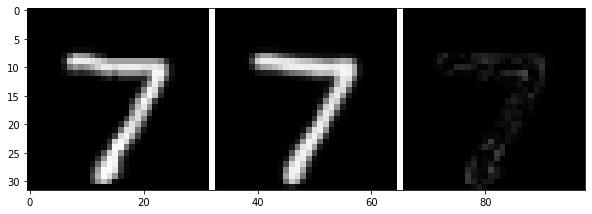

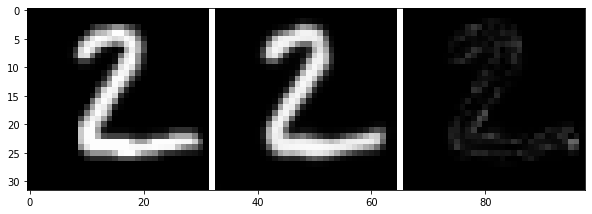

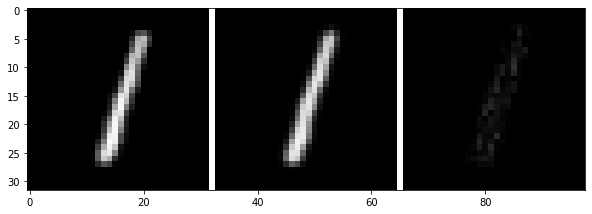

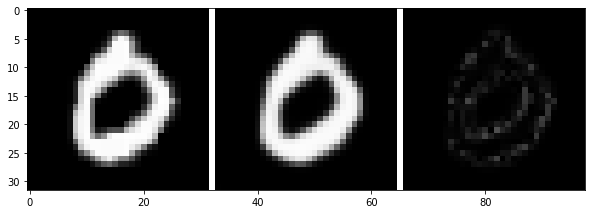

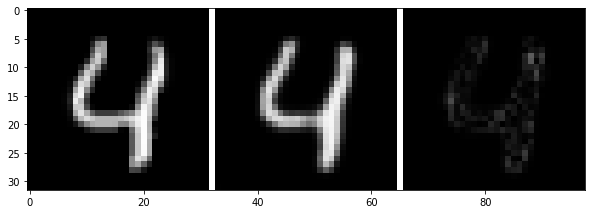

04/06/2020 11:47:27, epoch=36, step=4260, loss=0.01760, distortion=0.025, rate=0.018, -elbo=485.64008, nll=279.02304, KL=206.61703, commit_loss=9122.80371, bit_usage=0.91304, highest_prob=0.031, temp=0.50667
reset code 15
04/06/2020 11:47:28, epoch=36, step=4280, loss=0.01676, distortion=0.023, rate=0.018, -elbo=471.91797, nll=265.15091, KL=206.76707, commit_loss=9233.22852, bit_usage=0.91546, highest_prob=0.024, temp=0.50592
reset code 47
04/06/2020 11:47:29, epoch=36, step=4300, loss=0.01709, distortion=0.024, rate=0.018, -elbo=476.63388, nll=270.42499, KL=206.20889, commit_loss=9341.03125, bit_usage=0.91432, highest_prob=0.023, temp=0.50517
reset code 79
04/06/2020 11:47:30, epoch=36, step=4320, loss=0.01696, distortion=0.024, rate=0.018, -elbo=477.29510, nll=268.34863, KL=208.94649, commit_loss=9376.50586, bit_usage=0.91150, highest_prob=0.039, temp=0.50441
reset code 95
04/06/2020 11:47:31, epoch=36, step=4340, loss=0.01764, distortion=0.025, rate=0.018, -elbo=488.17673, nll=279.2

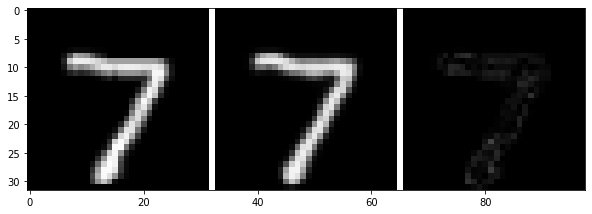

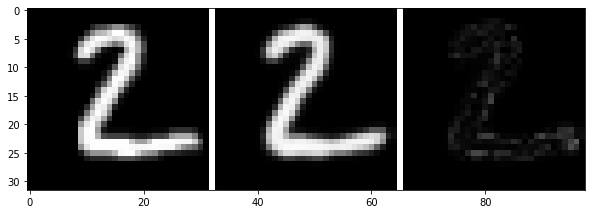

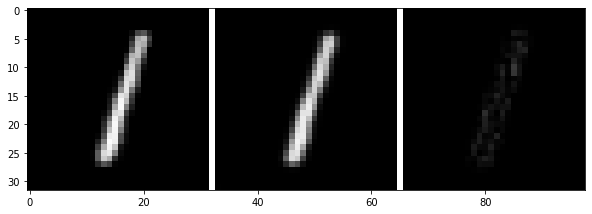

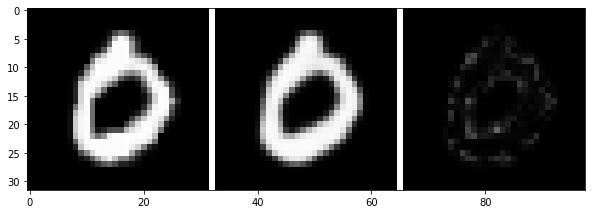

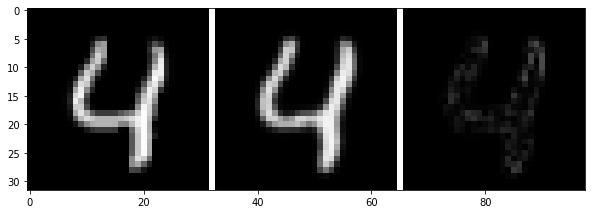

04/06/2020 11:47:58, epoch=41, step=4840, loss=0.01624, distortion=0.023, rate=0.019, -elbo=468.20016, nll=256.51465, KL=211.68552, commit_loss=9272.73828, bit_usage=0.91829, highest_prob=0.015, temp=0.48485
reset code 24
04/06/2020 11:47:59, epoch=41, step=4860, loss=0.01627, distortion=0.023, rate=0.019, -elbo=468.29730, nll=256.90735, KL=211.38994, commit_loss=9368.24805, bit_usage=0.91845, highest_prob=0.016, temp=0.48409
reset code 248
04/06/2020 11:48:00, epoch=41, step=4880, loss=0.01588, distortion=0.022, rate=0.019, -elbo=461.74902, nll=250.90562, KL=210.84340, commit_loss=9109.50098, bit_usage=0.91689, highest_prob=0.016, temp=0.48334
reset code 142
04/06/2020 11:48:01, epoch=41, step=4900, loss=0.01602, distortion=0.022, rate=0.019, -elbo=464.27911, nll=252.75430, KL=211.52481, commit_loss=9452.14258, bit_usage=0.91712, highest_prob=0.018, temp=0.48259
reset code 88
04/06/2020 11:48:02, epoch=41, step=4920, loss=0.01600, distortion=0.022, rate=0.019, -elbo=464.06610, nll=252

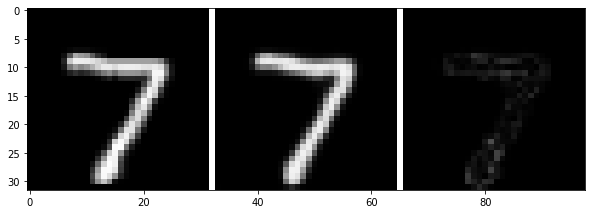

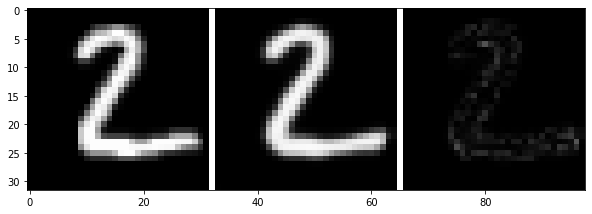

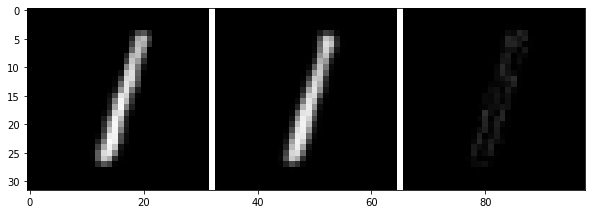

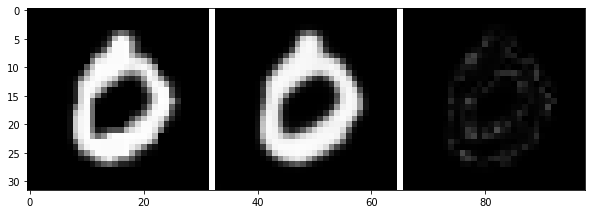

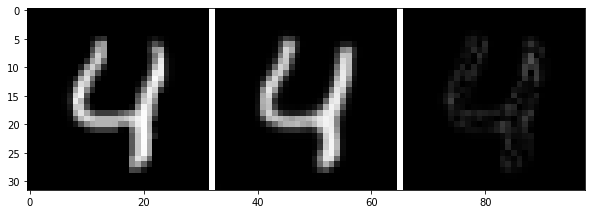

04/06/2020 11:48:30, epoch=46, step=5440, loss=0.01542, distortion=0.021, rate=0.018, -elbo=453.13950, nll=243.30255, KL=209.83694, commit_loss=9115.87305, bit_usage=0.93014, highest_prob=0.016, temp=0.46227
reset code 235
04/06/2020 11:48:31, epoch=46, step=5460, loss=0.01497, distortion=0.021, rate=0.018, -elbo=444.83783, nll=236.20399, KL=208.63382, commit_loss=8866.46191, bit_usage=0.93156, highest_prob=0.013, temp=0.46152
reset code 139
04/06/2020 11:48:32, epoch=46, step=5480, loss=0.01572, distortion=0.022, rate=0.019, -elbo=458.85532, nll=248.15047, KL=210.70485, commit_loss=9184.93945, bit_usage=0.93208, highest_prob=0.012, temp=0.46077
reset code 107
04/06/2020 11:48:33, epoch=46, step=5500, loss=0.01568, distortion=0.022, rate=0.019, -elbo=458.00516, nll=247.71130, KL=210.29385, commit_loss=9031.36133, bit_usage=0.93301, highest_prob=0.014, temp=0.46001
reset code 11
04/06/2020 11:48:34, epoch=46, step=5520, loss=0.01544, distortion=0.021, rate=0.018, -elbo=453.53644, nll=24

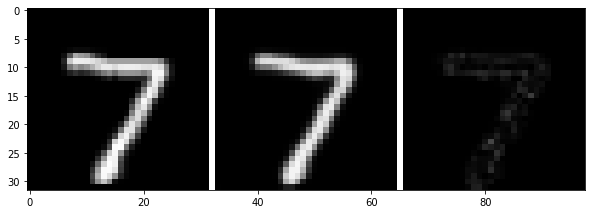

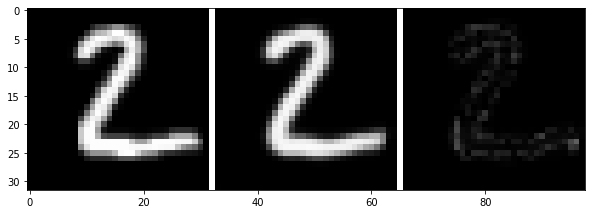

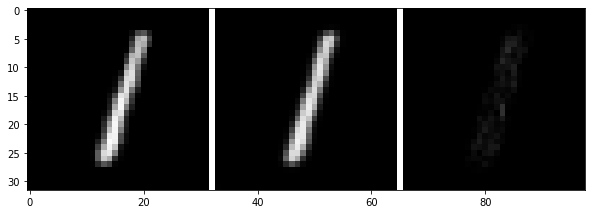

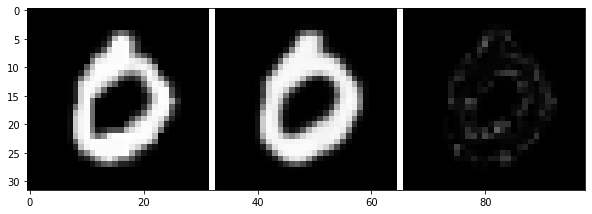

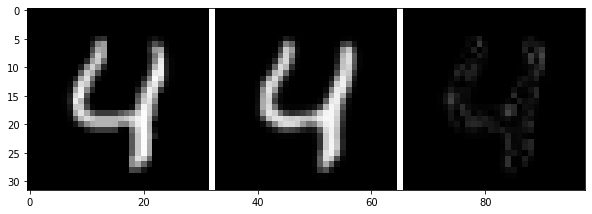

04/06/2020 11:48:59, epoch=51, step=6020, loss=0.01443, distortion=0.020, rate=0.019, -elbo=440.97754, nll=227.45697, KL=213.52058, commit_loss=8802.75781, bit_usage=0.92709, highest_prob=0.020, temp=0.44045
reset code 158
04/06/2020 11:49:00, epoch=51, step=6040, loss=0.01460, distortion=0.020, rate=0.019, -elbo=444.68982, nll=230.09947, KL=214.59033, commit_loss=8973.01172, bit_usage=0.92709, highest_prob=0.020, temp=0.43969
reset code 186
04/06/2020 11:49:01, epoch=51, step=6060, loss=0.01458, distortion=0.020, rate=0.019, -elbo=444.29001, nll=229.98268, KL=214.30733, commit_loss=8663.59668, bit_usage=0.92669, highest_prob=0.019, temp=0.43894
reset code 138
04/06/2020 11:49:02, epoch=51, step=6080, loss=0.01528, distortion=0.021, rate=0.019, -elbo=457.85153, nll=241.22635, KL=216.62518, commit_loss=8859.01758, bit_usage=0.92548, highest_prob=0.018, temp=0.43819
reset code 15
04/06/2020 11:49:03, epoch=51, step=6100, loss=0.01497, distortion=0.021, rate=0.019, -elbo=451.83960, nll=23

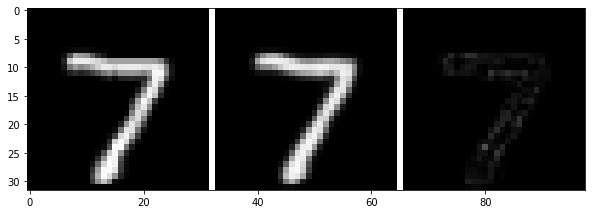

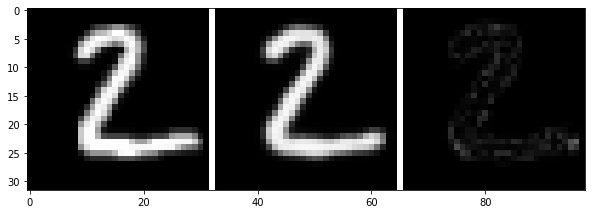

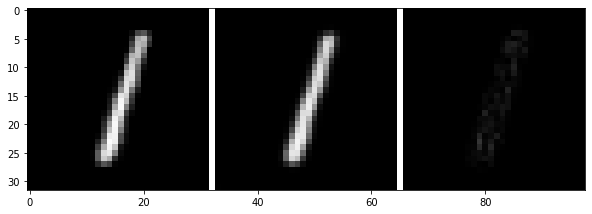

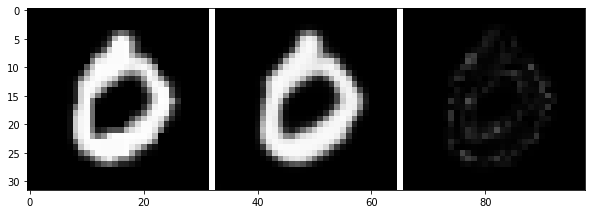

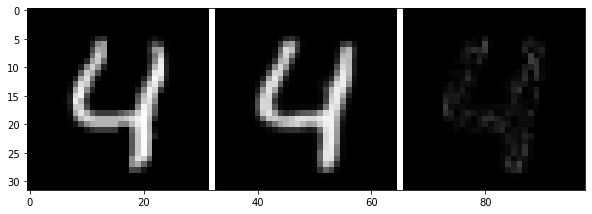

04/06/2020 11:49:30, epoch=56, step=6620, loss=0.01394, distortion=0.019, rate=0.019, -elbo=435.37848, nll=219.61877, KL=215.75969, commit_loss=8628.20117, bit_usage=0.93172, highest_prob=0.016, temp=0.41787
reset code 35
04/06/2020 11:49:32, epoch=56, step=6640, loss=0.01402, distortion=0.019, rate=0.019, -elbo=436.66833, nll=220.84085, KL=215.82748, commit_loss=8648.88379, bit_usage=0.93219, highest_prob=0.014, temp=0.41712
reset code 134
04/06/2020 11:49:33, epoch=56, step=6660, loss=0.01441, distortion=0.020, rate=0.019, -elbo=444.93024, nll=227.04492, KL=217.88533, commit_loss=8882.16699, bit_usage=0.93064, highest_prob=0.016, temp=0.41637
reset code 6
04/06/2020 11:49:34, epoch=56, step=6680, loss=0.01405, distortion=0.019, rate=0.019, -elbo=436.88040, nll=221.40588, KL=215.47452, commit_loss=8540.99219, bit_usage=0.93260, highest_prob=0.018, temp=0.41561
reset code 207
04/06/2020 11:49:35, epoch=56, step=6700, loss=0.01448, distortion=0.020, rate=0.019, -elbo=445.98492, nll=228.

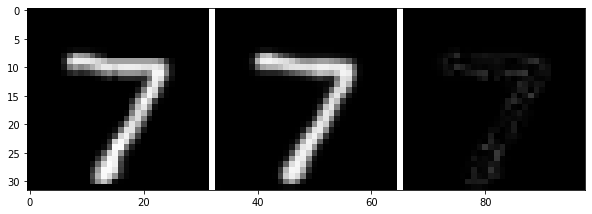

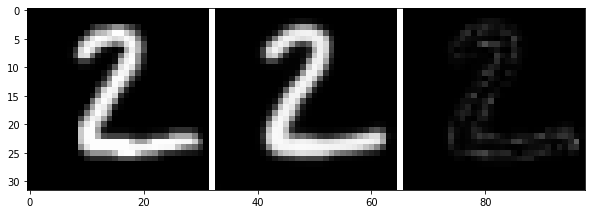

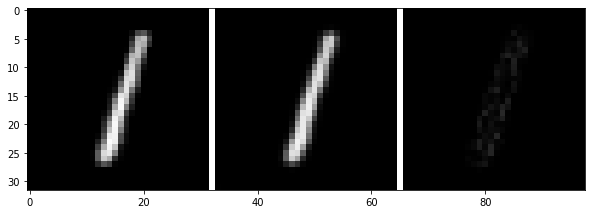

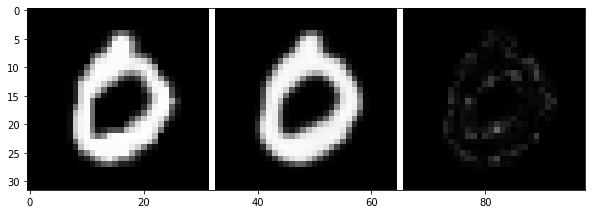

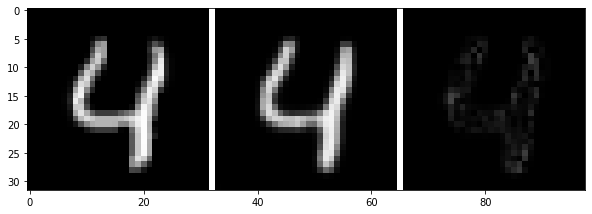

04/06/2020 11:50:02, epoch=61, step=7200, loss=0.01362, distortion=0.019, rate=0.019, -elbo=434.27380, nll=214.35724, KL=219.91656, commit_loss=8554.00195, bit_usage=0.93009, highest_prob=0.016, temp=0.39605
reset code 144
04/06/2020 11:50:03, epoch=61, step=7220, loss=0.01356, distortion=0.019, rate=0.019, -elbo=432.64569, nll=213.37823, KL=219.26746, commit_loss=8638.19922, bit_usage=0.93180, highest_prob=0.015, temp=0.39529
reset code 132
04/06/2020 11:50:03, epoch=61, step=7240, loss=0.01376, distortion=0.019, rate=0.019, -elbo=435.20459, nll=216.67834, KL=218.52623, commit_loss=8603.19043, bit_usage=0.93262, highest_prob=0.014, temp=0.39454
reset code 196
04/06/2020 11:50:04, epoch=61, step=7260, loss=0.01426, distortion=0.020, rate=0.020, -elbo=446.76642, nll=224.49799, KL=222.26843, commit_loss=8988.81055, bit_usage=0.93256, highest_prob=0.015, temp=0.39379
reset code 187
04/06/2020 11:50:05, epoch=61, step=7280, loss=0.01432, distortion=0.020, rate=0.019, -elbo=444.90112, nll=2

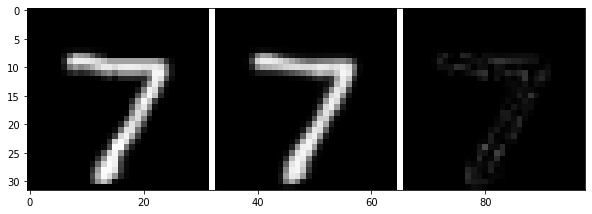

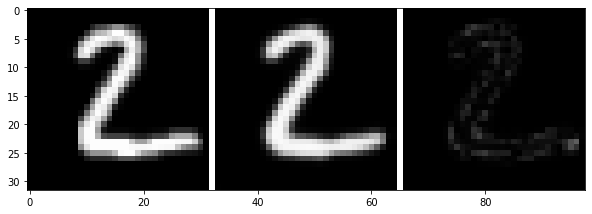

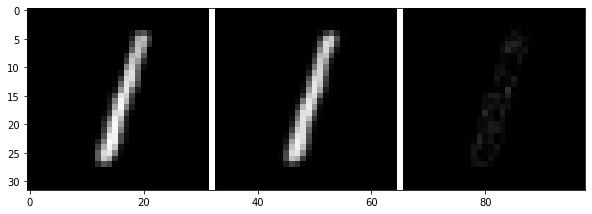

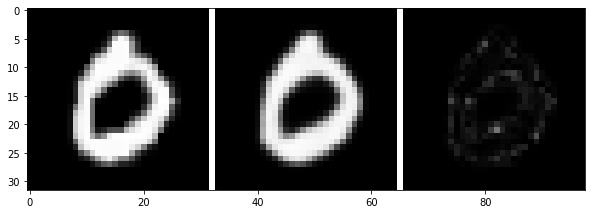

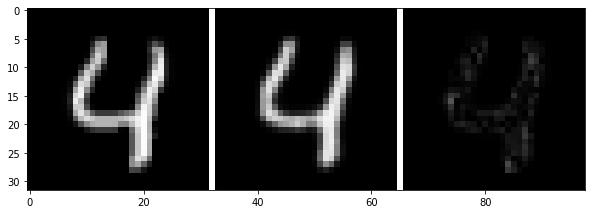

04/06/2020 11:50:33, epoch=66, step=7800, loss=0.01340, distortion=0.019, rate=0.019, -elbo=428.43826, nll=210.91116, KL=217.52710, commit_loss=8395.10156, bit_usage=0.93875, highest_prob=0.013, temp=0.37347
reset code 39
04/06/2020 11:50:34, epoch=66, step=7820, loss=0.01303, distortion=0.018, rate=0.019, -elbo=424.76440, nll=204.65308, KL=220.11133, commit_loss=8545.34473, bit_usage=0.93765, highest_prob=0.014, temp=0.37272
reset code 244
04/06/2020 11:50:35, epoch=66, step=7840, loss=0.01343, distortion=0.019, rate=0.019, -elbo=432.37418, nll=211.11703, KL=221.25714, commit_loss=8705.72656, bit_usage=0.93739, highest_prob=0.014, temp=0.37197
reset code 16
04/06/2020 11:50:36, epoch=66, step=7860, loss=0.01346, distortion=0.019, rate=0.019, -elbo=431.66083, nll=211.72032, KL=219.94049, commit_loss=8548.76855, bit_usage=0.93625, highest_prob=0.014, temp=0.37121
reset code 123
04/06/2020 11:50:37, epoch=66, step=7880, loss=0.01342, distortion=0.019, rate=0.019, -elbo=432.22736, nll=210

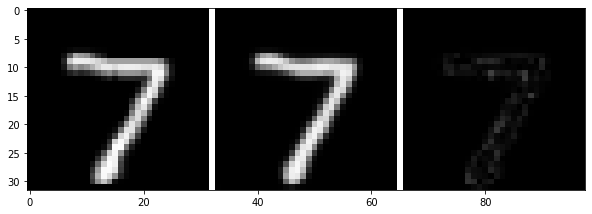

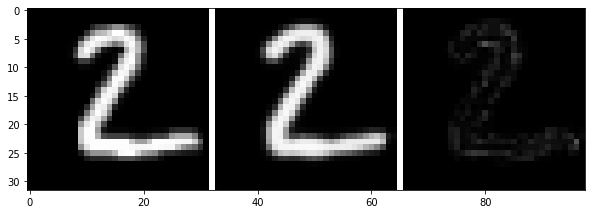

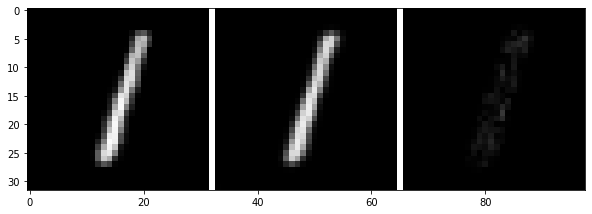

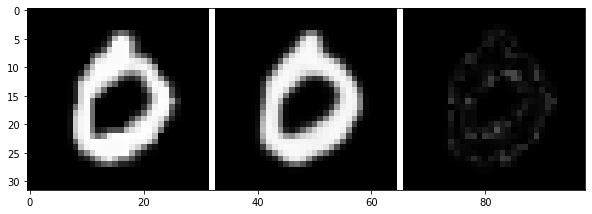

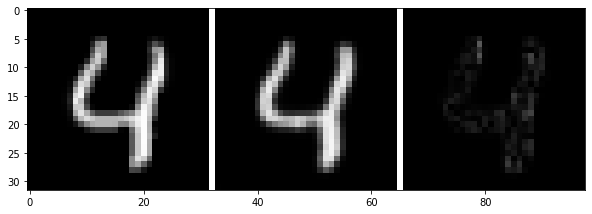

04/06/2020 11:51:04, epoch=71, step=8380, loss=0.01323, distortion=0.018, rate=0.020, -elbo=431.82648, nll=207.94009, KL=223.88637, commit_loss=8548.05273, bit_usage=0.93202, highest_prob=0.024, temp=0.35165
reset code 153
04/06/2020 11:51:05, epoch=71, step=8400, loss=0.01289, distortion=0.018, rate=0.020, -elbo=425.81195, nll=202.39690, KL=223.41504, commit_loss=8498.02539, bit_usage=0.93324, highest_prob=0.024, temp=0.35089
reset code 247
04/06/2020 11:51:06, epoch=71, step=8420, loss=0.01322, distortion=0.018, rate=0.020, -elbo=431.90601, nll=207.72374, KL=224.18228, commit_loss=8674.83887, bit_usage=0.93594, highest_prob=0.015, temp=0.35014
reset code 12
04/06/2020 11:51:07, epoch=71, step=8440, loss=0.01321, distortion=0.018, rate=0.020, -elbo=431.83148, nll=207.52029, KL=224.31120, commit_loss=8638.30273, bit_usage=0.93581, highest_prob=0.018, temp=0.34939
reset code 250
04/06/2020 11:51:08, epoch=71, step=8460, loss=0.01294, distortion=0.018, rate=0.020, -elbo=426.84210, nll=20

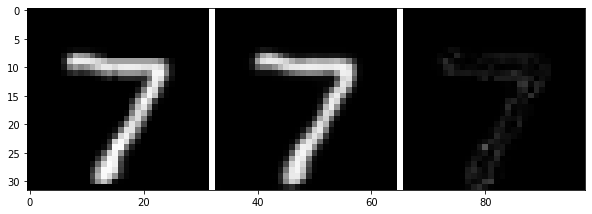

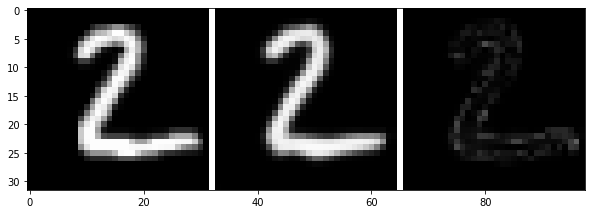

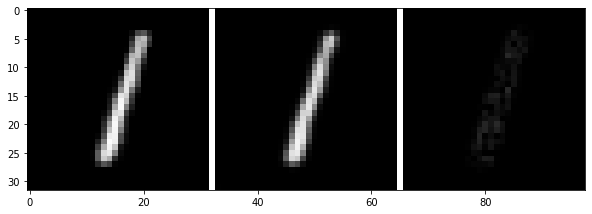

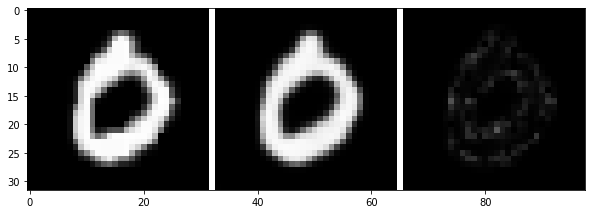

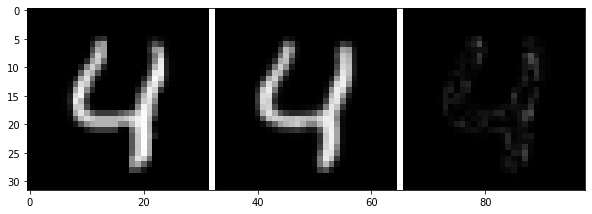

04/06/2020 11:51:35, epoch=76, step=8980, loss=0.01302, distortion=0.018, rate=0.020, -elbo=426.91696, nll=204.72662, KL=222.19034, commit_loss=8442.00098, bit_usage=0.94165, highest_prob=0.015, temp=0.32907
reset code 47
04/06/2020 11:51:36, epoch=76, step=9000, loss=0.01302, distortion=0.018, rate=0.020, -elbo=429.54639, nll=204.52322, KL=225.02315, commit_loss=8541.54297, bit_usage=0.94060, highest_prob=0.013, temp=0.32832
reset code 210
04/06/2020 11:51:37, epoch=76, step=9020, loss=0.01344, distortion=0.019, rate=0.020, -elbo=435.45087, nll=211.34021, KL=224.11066, commit_loss=8689.19922, bit_usage=0.94214, highest_prob=0.019, temp=0.32757
reset code 207
04/06/2020 11:51:38, epoch=76, step=9040, loss=0.01247, distortion=0.017, rate=0.020, -elbo=418.73666, nll=195.57779, KL=223.15887, commit_loss=8545.14844, bit_usage=0.93904, highest_prob=0.019, temp=0.32681
reset code 196
04/06/2020 11:51:39, epoch=76, step=9060, loss=0.01273, distortion=0.018, rate=0.020, -elbo=424.16107, nll=19

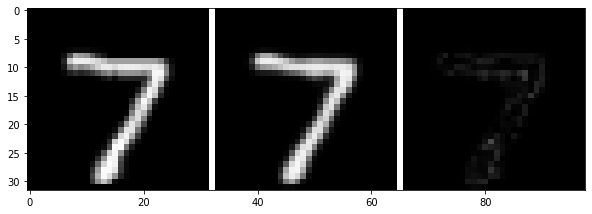

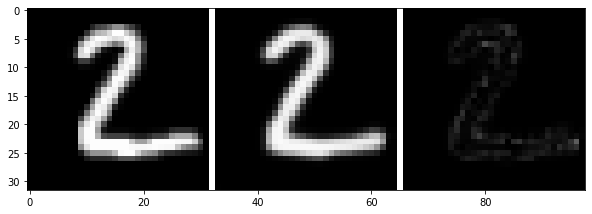

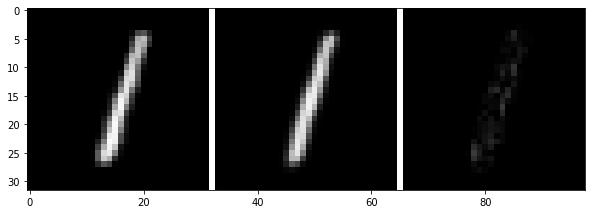

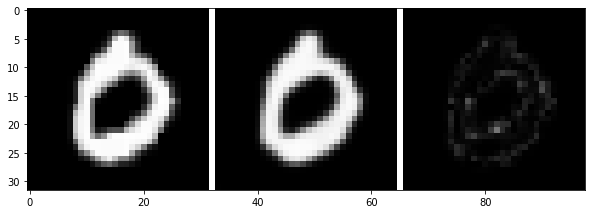

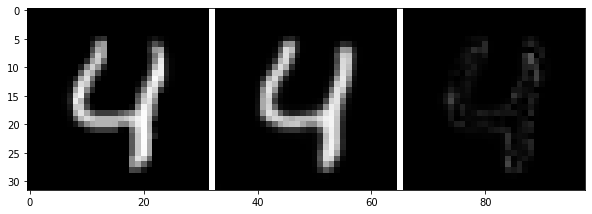

04/06/2020 11:52:05, epoch=81, step=9560, loss=0.01254, distortion=0.017, rate=0.020, -elbo=424.05203, nll=196.72092, KL=227.33112, commit_loss=8431.91504, bit_usage=0.93695, highest_prob=0.016, temp=0.30725
reset code 245
04/06/2020 11:52:06, epoch=81, step=9580, loss=0.01265, distortion=0.017, rate=0.020, -elbo=425.80417, nll=198.62405, KL=227.18011, commit_loss=8407.79492, bit_usage=0.93566, highest_prob=0.018, temp=0.30649
reset code 61
04/06/2020 11:52:07, epoch=81, step=9600, loss=0.01301, distortion=0.018, rate=0.020, -elbo=431.61288, nll=204.47498, KL=227.13791, commit_loss=8414.03613, bit_usage=0.93681, highest_prob=0.018, temp=0.30574
reset code 230
04/06/2020 11:52:08, epoch=81, step=9620, loss=0.01320, distortion=0.018, rate=0.020, -elbo=438.34903, nll=207.24448, KL=231.10455, commit_loss=8808.14648, bit_usage=0.93501, highest_prob=0.017, temp=0.30499
reset code 182
04/06/2020 11:52:09, epoch=81, step=9640, loss=0.01267, distortion=0.018, rate=0.020, -elbo=428.78140, nll=19

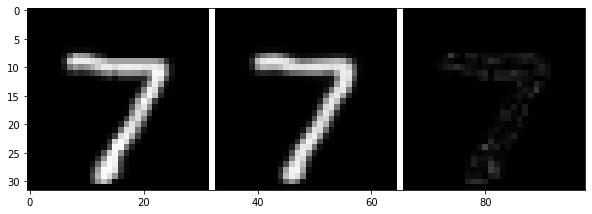

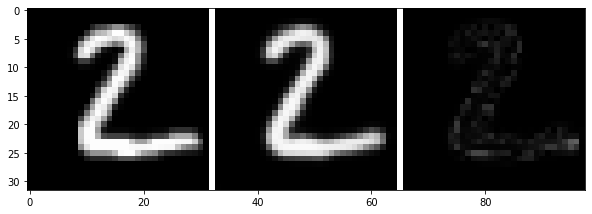

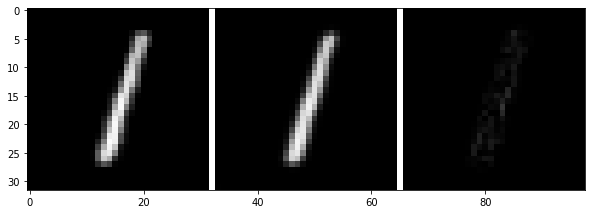

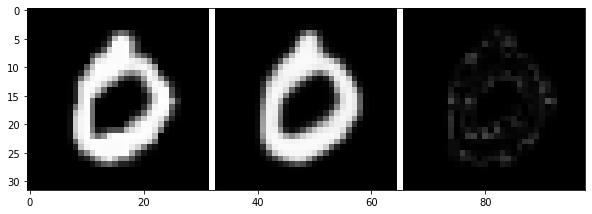

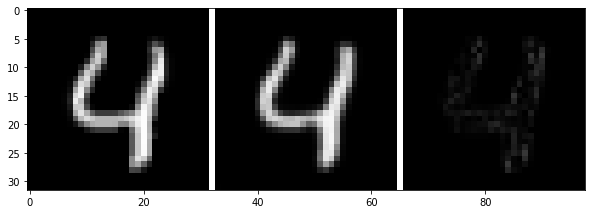

04/06/2020 11:52:36, epoch=86, step=10160, loss=0.01306, distortion=0.018, rate=0.020, -elbo=433.09460, nll=205.28770, KL=227.80688, commit_loss=8397.95312, bit_usage=0.94148, highest_prob=0.018, temp=0.28467
reset code 118
04/06/2020 11:52:37, epoch=86, step=10180, loss=0.01256, distortion=0.017, rate=0.020, -elbo=423.99564, nll=197.07739, KL=226.91824, commit_loss=8491.38281, bit_usage=0.94000, highest_prob=0.017, temp=0.28392
reset code 85
04/06/2020 11:52:38, epoch=86, step=10200, loss=0.01258, distortion=0.017, rate=0.020, -elbo=425.84485, nll=197.52391, KL=228.32092, commit_loss=8376.12500, bit_usage=0.93768, highest_prob=0.015, temp=0.28317
reset code 191
04/06/2020 11:52:39, epoch=86, step=10220, loss=0.01233, distortion=0.017, rate=0.020, -elbo=421.94809, nll=193.39816, KL=228.54993, commit_loss=8452.15039, bit_usage=0.93864, highest_prob=0.016, temp=0.28241
reset code 135
04/06/2020 11:52:40, epoch=86, step=10240, loss=0.01275, distortion=0.018, rate=0.020, -elbo=428.93530, n

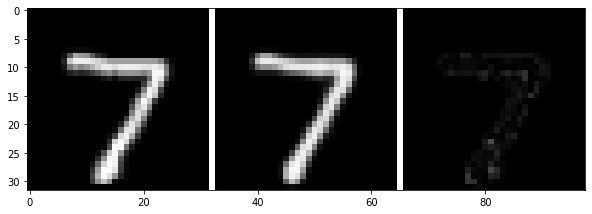

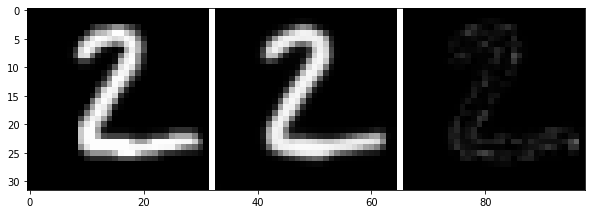

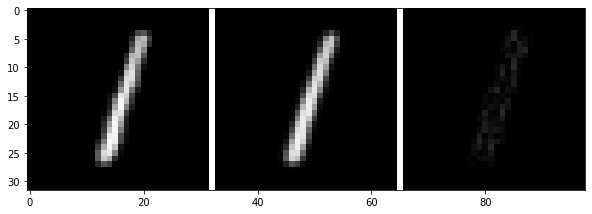

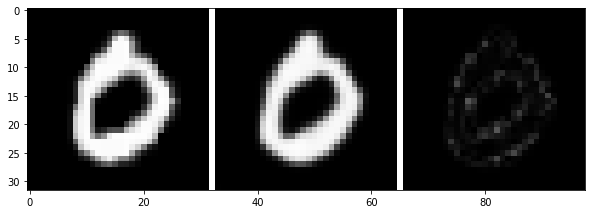

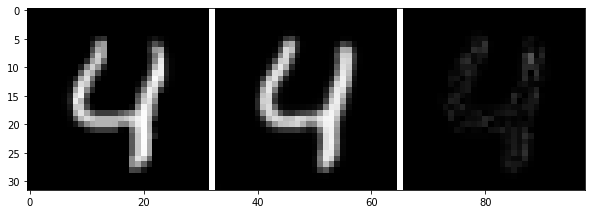

04/06/2020 11:53:07, epoch=91, step=10740, loss=0.01229, distortion=0.017, rate=0.020, -elbo=422.65350, nll=192.69296, KL=229.96054, commit_loss=8383.89844, bit_usage=0.93584, highest_prob=0.021, temp=0.26285
reset code 228
04/06/2020 11:53:08, epoch=91, step=10760, loss=0.01296, distortion=0.018, rate=0.020, -elbo=435.13000, nll=203.62901, KL=231.50098, commit_loss=8446.25195, bit_usage=0.93812, highest_prob=0.016, temp=0.26209
reset code 26
04/06/2020 11:53:09, epoch=91, step=10780, loss=0.01250, distortion=0.017, rate=0.020, -elbo=425.40363, nll=196.17499, KL=229.22864, commit_loss=8342.94336, bit_usage=0.93976, highest_prob=0.015, temp=0.26134
reset code 212
04/06/2020 11:53:10, epoch=91, step=10800, loss=0.01215, distortion=0.017, rate=0.020, -elbo=418.66611, nll=190.51978, KL=228.14633, commit_loss=8247.02637, bit_usage=0.93877, highest_prob=0.015, temp=0.26059
reset code 247
04/06/2020 11:53:11, epoch=91, step=10820, loss=0.01254, distortion=0.017, rate=0.020, -elbo=426.57007, n

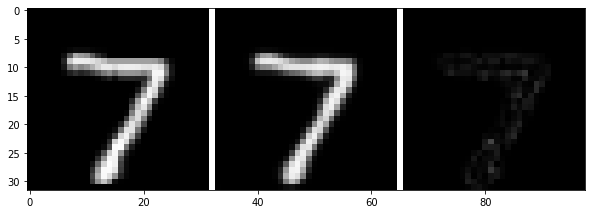

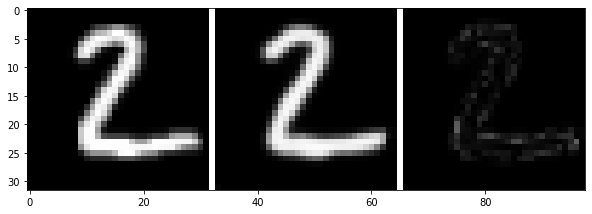

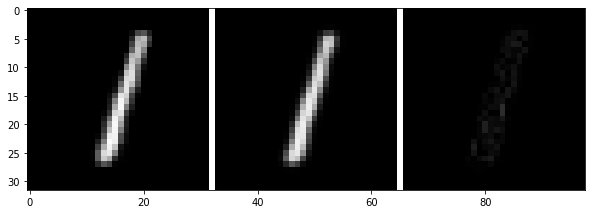

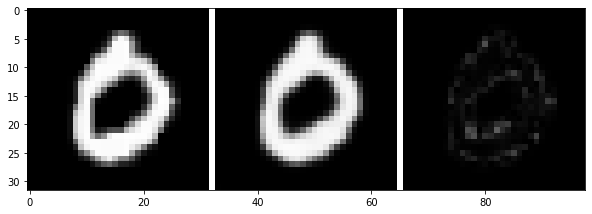

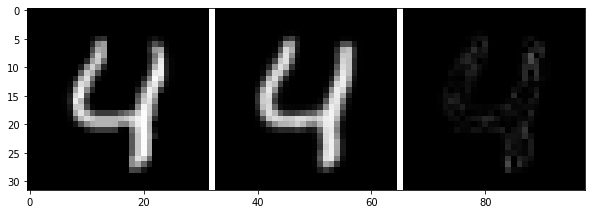

04/06/2020 11:53:39, epoch=96, step=11340, loss=0.01283, distortion=0.018, rate=0.020, -elbo=429.86987, nll=201.56093, KL=228.30893, commit_loss=8352.86133, bit_usage=0.94948, highest_prob=0.015, temp=0.24027
reset code 62
04/06/2020 11:53:40, epoch=96, step=11360, loss=0.01243, distortion=0.017, rate=0.020, -elbo=423.36664, nll=194.85461, KL=228.51201, commit_loss=8527.80469, bit_usage=0.94784, highest_prob=0.016, temp=0.23952
reset code 230
04/06/2020 11:53:41, epoch=96, step=11380, loss=0.01213, distortion=0.017, rate=0.020, -elbo=419.89114, nll=189.95844, KL=229.93271, commit_loss=8520.07227, bit_usage=0.94547, highest_prob=0.021, temp=0.23877
reset code 219
04/06/2020 11:53:42, epoch=96, step=11400, loss=0.01242, distortion=0.017, rate=0.020, -elbo=423.35181, nll=194.90366, KL=228.44815, commit_loss=8326.52539, bit_usage=0.94581, highest_prob=0.022, temp=0.23801
reset code 190
04/06/2020 11:53:43, epoch=96, step=11420, loss=0.01223, distortion=0.017, rate=0.020, -elbo=421.44092, n

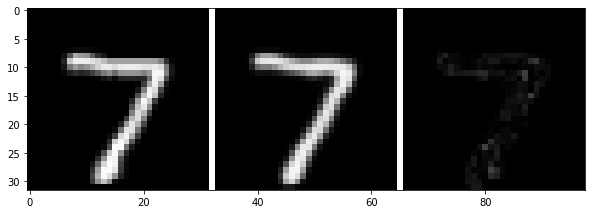

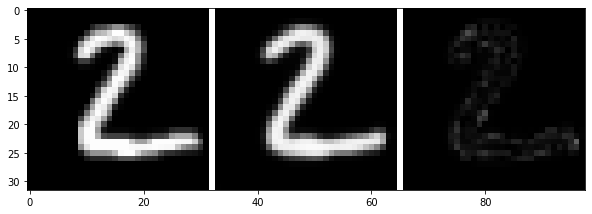

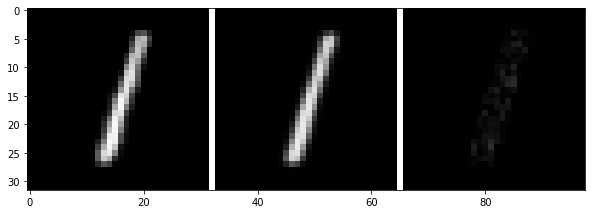

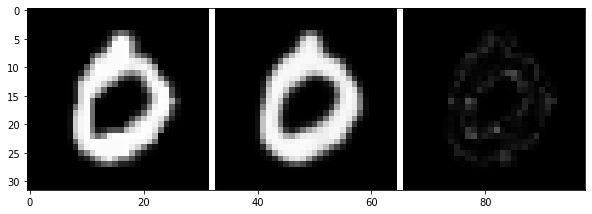

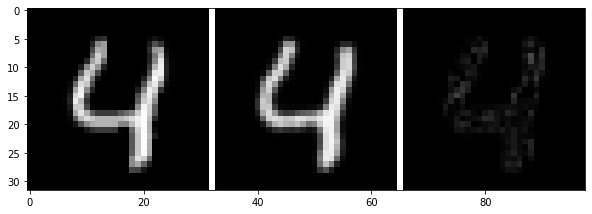

04/06/2020 11:54:09, epoch=101, step=11920, loss=0.01203, distortion=0.017, rate=0.020, -elbo=420.87155, nll=188.54053, KL=232.33102, commit_loss=8327.42188, bit_usage=0.93602, highest_prob=0.017, temp=0.21845
reset code 88
04/06/2020 11:54:10, epoch=101, step=11940, loss=0.01205, distortion=0.017, rate=0.021, -elbo=421.60391, nll=188.72064, KL=232.88327, commit_loss=8484.94531, bit_usage=0.93747, highest_prob=0.016, temp=0.21769
reset code 200
04/06/2020 11:54:11, epoch=101, step=11960, loss=0.01231, distortion=0.017, rate=0.021, -elbo=426.53015, nll=192.85538, KL=233.67477, commit_loss=8537.08008, bit_usage=0.94026, highest_prob=0.018, temp=0.21694
reset code 35
04/06/2020 11:54:12, epoch=101, step=11980, loss=0.01208, distortion=0.017, rate=0.020, -elbo=421.67914, nll=189.05400, KL=232.62514, commit_loss=8621.31738, bit_usage=0.94301, highest_prob=0.014, temp=0.21619
reset code 198
04/06/2020 11:54:13, epoch=101, step=12000, loss=0.01211, distortion=0.017, rate=0.020, -elbo=421.6035

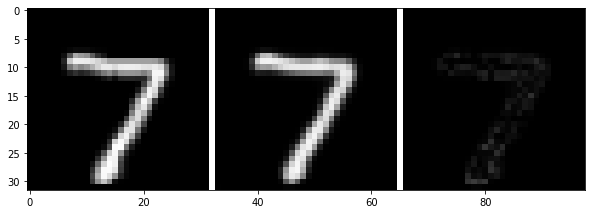

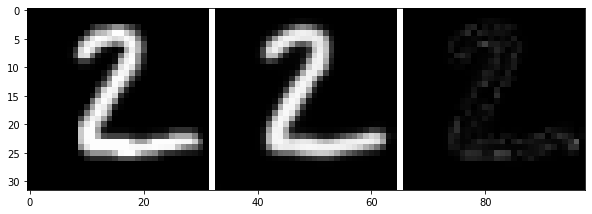

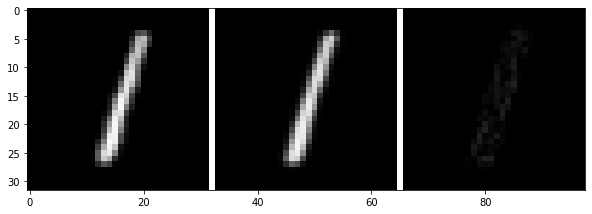

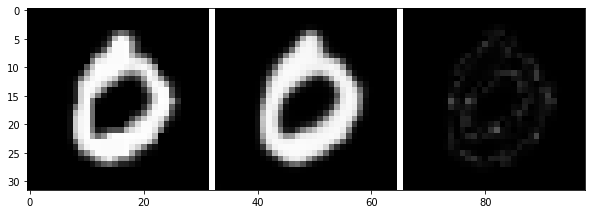

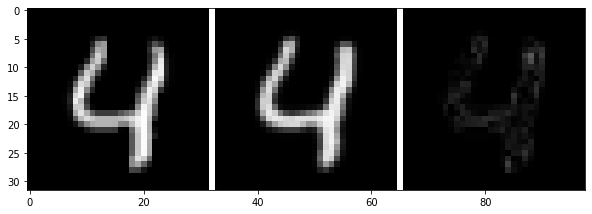

04/06/2020 11:54:41, epoch=106, step=12520, loss=0.01238, distortion=0.017, rate=0.021, -elbo=427.23798, nll=194.03171, KL=233.20627, commit_loss=8522.69531, bit_usage=0.94354, highest_prob=0.033, temp=0.19587
reset code 199
04/06/2020 11:54:42, epoch=106, step=12540, loss=0.01233, distortion=0.017, rate=0.021, -elbo=427.21283, nll=193.20914, KL=234.00368, commit_loss=8534.00000, bit_usage=0.94723, highest_prob=0.024, temp=0.19512
reset code 56
04/06/2020 11:54:43, epoch=106, step=12560, loss=0.01192, distortion=0.016, rate=0.021, -elbo=419.77539, nll=186.62973, KL=233.14566, commit_loss=8399.92480, bit_usage=0.94687, highest_prob=0.022, temp=0.19437
reset code 46
04/06/2020 11:54:45, epoch=106, step=12580, loss=0.01241, distortion=0.017, rate=0.021, -elbo=428.72455, nll=194.47821, KL=234.24634, commit_loss=8691.59570, bit_usage=0.94471, highest_prob=0.019, temp=0.19361
reset code 183
04/06/2020 11:54:46, epoch=106, step=12600, loss=0.01247, distortion=0.017, rate=0.021, -elbo=431.7095

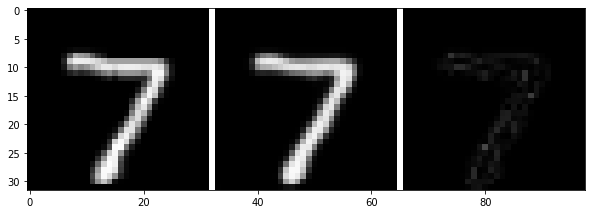

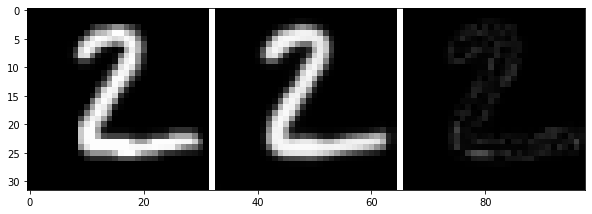

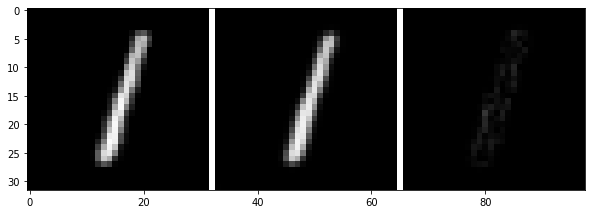

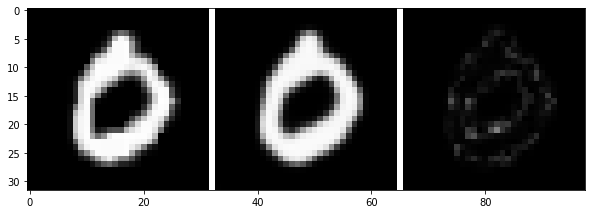

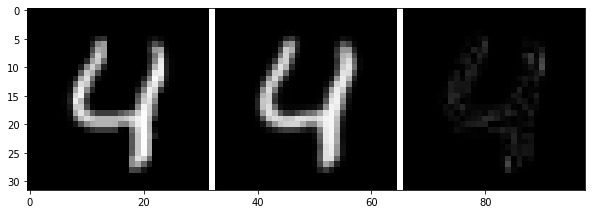

04/06/2020 11:55:13, epoch=111, step=13100, loss=0.01204, distortion=0.017, rate=0.021, -elbo=422.78870, nll=188.38544, KL=234.40326, commit_loss=8592.20801, bit_usage=0.94769, highest_prob=0.015, temp=0.17405
reset code 145
04/06/2020 11:55:14, epoch=111, step=13120, loss=0.01249, distortion=0.017, rate=0.021, -elbo=430.41818, nll=195.74808, KL=234.67010, commit_loss=8689.62109, bit_usage=0.95049, highest_prob=0.014, temp=0.17329
reset code 144
04/06/2020 11:55:15, epoch=111, step=13140, loss=0.01206, distortion=0.017, rate=0.020, -elbo=420.84473, nll=188.95102, KL=231.89372, commit_loss=8434.64844, bit_usage=0.94845, highest_prob=0.020, temp=0.17254
reset code 221
04/06/2020 11:55:16, epoch=111, step=13160, loss=0.01228, distortion=0.017, rate=0.021, -elbo=425.99701, nll=192.50571, KL=233.49132, commit_loss=8474.57031, bit_usage=0.94755, highest_prob=0.016, temp=0.17179
reset code 55
04/06/2020 11:55:17, epoch=111, step=13180, loss=0.01193, distortion=0.016, rate=0.021, -elbo=420.922

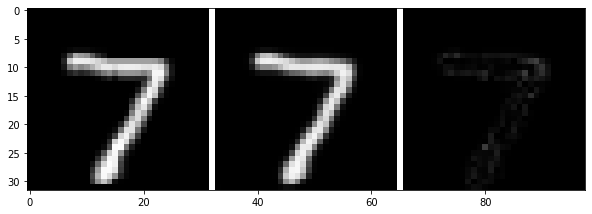

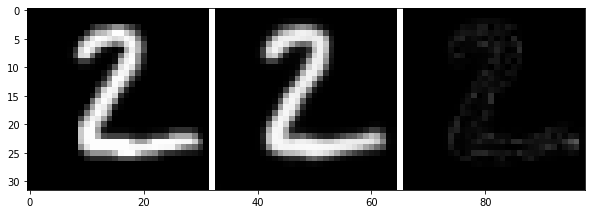

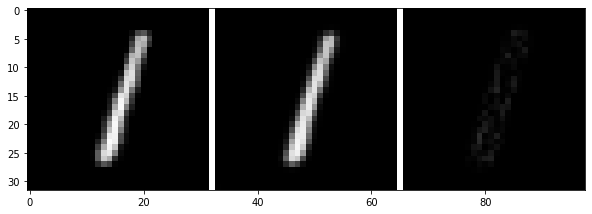

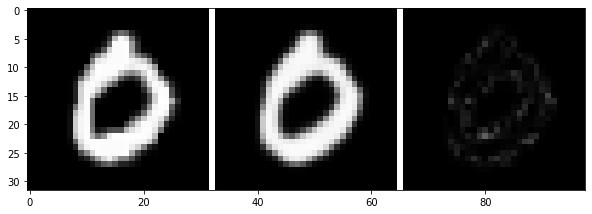

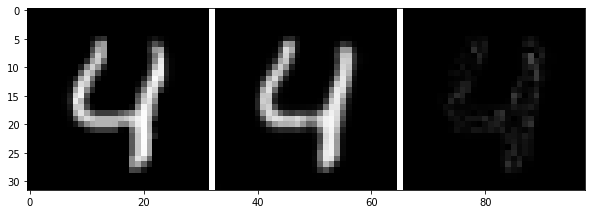

04/06/2020 11:55:44, epoch=116, step=13700, loss=0.01224, distortion=0.017, rate=0.021, -elbo=430.33783, nll=191.54947, KL=238.78838, commit_loss=8813.68848, bit_usage=0.94309, highest_prob=0.016, temp=0.15147
reset code 231
04/06/2020 11:55:45, epoch=116, step=13720, loss=0.01217, distortion=0.017, rate=0.021, -elbo=429.66260, nll=190.36549, KL=239.29709, commit_loss=8797.35742, bit_usage=0.94460, highest_prob=0.014, temp=0.15072
reset code 174
04/06/2020 11:55:46, epoch=116, step=13740, loss=0.01232, distortion=0.017, rate=0.021, -elbo=430.96014, nll=192.84029, KL=238.11986, commit_loss=8731.36230, bit_usage=0.94478, highest_prob=0.015, temp=0.14997
reset code 198
04/06/2020 11:55:47, epoch=116, step=13760, loss=0.01176, distortion=0.016, rate=0.021, -elbo=419.85742, nll=183.65292, KL=236.20450, commit_loss=8761.40820, bit_usage=0.94457, highest_prob=0.014, temp=0.14921
reset code 95
04/06/2020 11:55:48, epoch=116, step=13780, loss=0.01230, distortion=0.017, rate=0.021, -elbo=429.441

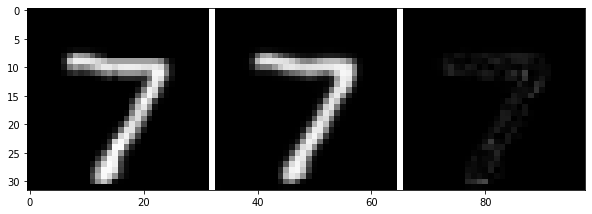

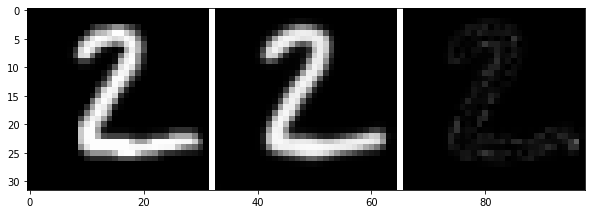

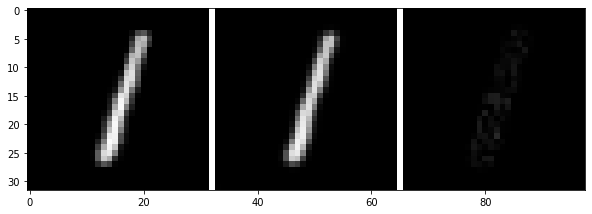

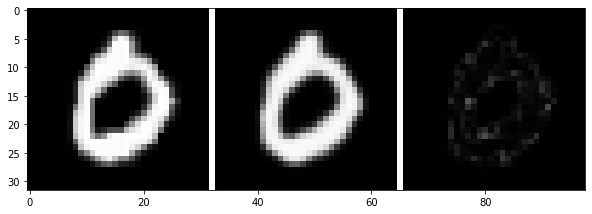

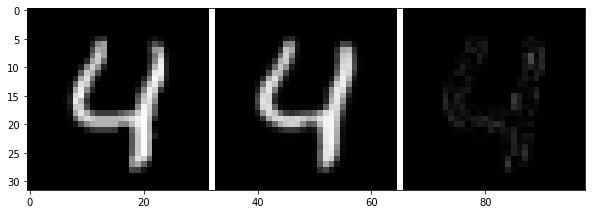

04/06/2020 11:56:15, epoch=121, step=14280, loss=0.01164, distortion=0.016, rate=0.021, -elbo=416.31967, nll=181.62488, KL=234.69479, commit_loss=8778.83594, bit_usage=0.95172, highest_prob=0.015, temp=0.12965
reset code 131
04/06/2020 11:56:16, epoch=121, step=14300, loss=0.01182, distortion=0.016, rate=0.021, -elbo=418.69440, nll=184.62024, KL=234.07414, commit_loss=8813.24512, bit_usage=0.95353, highest_prob=0.013, temp=0.12889
reset code 89
04/06/2020 11:56:17, epoch=121, step=14320, loss=0.01236, distortion=0.017, rate=0.021, -elbo=430.01703, nll=193.62967, KL=236.38736, commit_loss=8631.17188, bit_usage=0.95351, highest_prob=0.012, temp=0.12814
reset code 88
04/06/2020 11:56:18, epoch=121, step=14340, loss=0.01212, distortion=0.017, rate=0.021, -elbo=424.26654, nll=189.59109, KL=234.67543, commit_loss=8801.28125, bit_usage=0.95416, highest_prob=0.012, temp=0.12739
reset code 108
04/06/2020 11:56:19, epoch=121, step=14360, loss=0.01166, distortion=0.016, rate=0.021, -elbo=416.5805

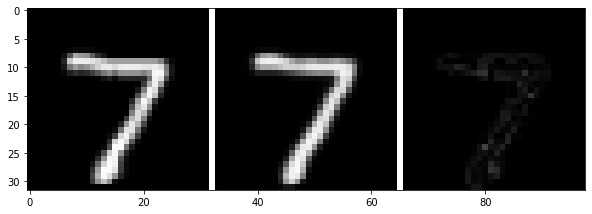

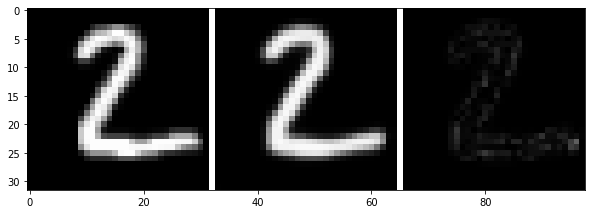

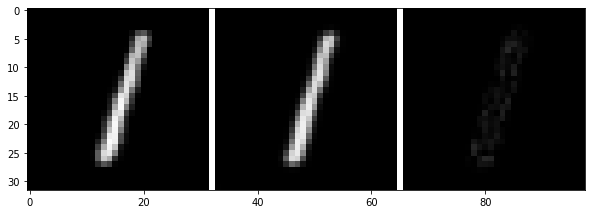

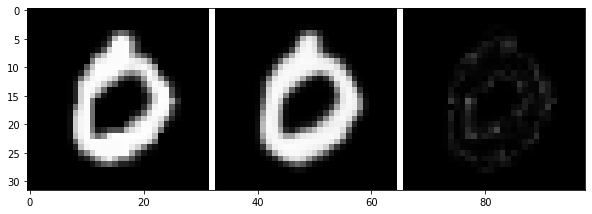

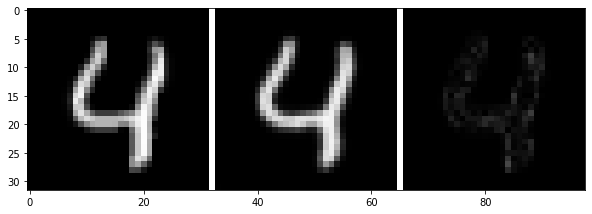

04/06/2020 11:56:46, epoch=126, step=14880, loss=0.01168, distortion=0.016, rate=0.020, -elbo=415.01892, nll=182.51199, KL=232.50693, commit_loss=8686.62109, bit_usage=0.96017, highest_prob=0.010, temp=0.10707
04/06/2020 11:56:47, epoch=126, step=14900, loss=0.01184, distortion=0.016, rate=0.020, -elbo=417.62094, nll=185.15454, KL=232.46640, commit_loss=8678.53125, bit_usage=0.95944, highest_prob=0.011, temp=0.10632
reset code 135
04/06/2020 11:56:48, epoch=126, step=14920, loss=0.01204, distortion=0.017, rate=0.020, -elbo=420.18848, nll=188.46741, KL=231.72108, commit_loss=8634.20312, bit_usage=0.96106, highest_prob=0.011, temp=0.10557
reset code 150
04/06/2020 11:56:49, epoch=126, step=14940, loss=0.01207, distortion=0.017, rate=0.021, -elbo=422.51636, nll=188.74931, KL=233.76706, commit_loss=8850.97363, bit_usage=0.95965, highest_prob=0.013, temp=0.10481
reset code 47
04/06/2020 11:56:50, epoch=126, step=14960, loss=0.01208, distortion=0.017, rate=0.021, -elbo=423.09052, nll=188.772

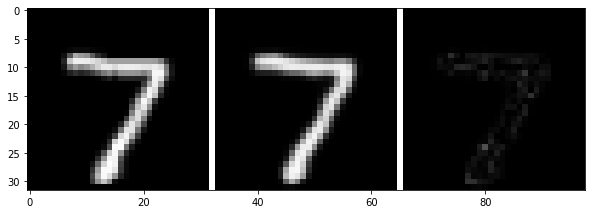

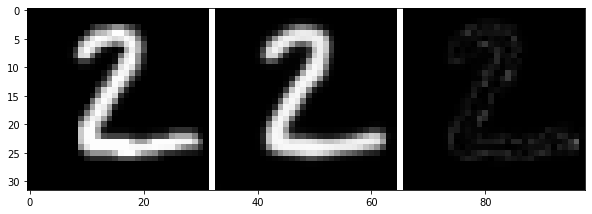

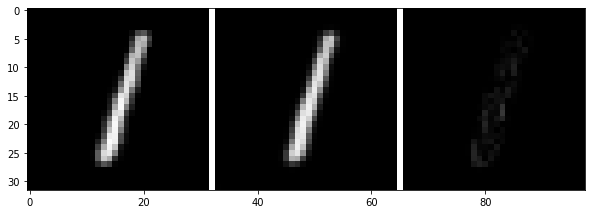

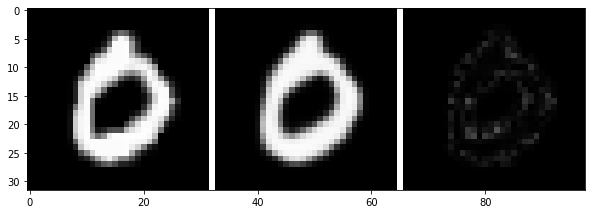

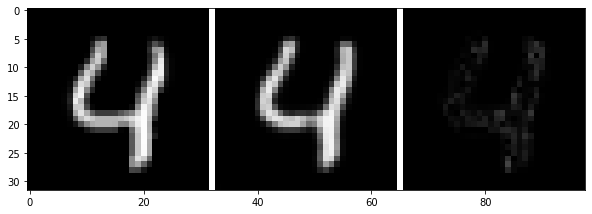

04/06/2020 11:57:16, epoch=131, step=15460, loss=0.01223, distortion=0.017, rate=0.021, -elbo=426.01254, nll=191.21207, KL=234.80048, commit_loss=8955.07031, bit_usage=0.95821, highest_prob=0.012, temp=0.08525
reset code 3
04/06/2020 11:57:17, epoch=131, step=15480, loss=0.01222, distortion=0.017, rate=0.021, -elbo=426.19696, nll=190.95834, KL=235.23862, commit_loss=8962.29004, bit_usage=0.96017, highest_prob=0.011, temp=0.08449
04/06/2020 11:57:18, epoch=131, step=15500, loss=0.01229, distortion=0.017, rate=0.021, -elbo=427.19333, nll=192.05727, KL=235.13606, commit_loss=9103.50195, bit_usage=0.96093, highest_prob=0.011, temp=0.08374
04/06/2020 11:57:19, epoch=131, step=15520, loss=0.01164, distortion=0.016, rate=0.020, -elbo=413.65619, nll=181.64288, KL=232.01331, commit_loss=8843.66406, bit_usage=0.96172, highest_prob=0.010, temp=0.08299
04/06/2020 11:57:20, epoch=131, step=15540, loss=0.01191, distortion=0.016, rate=0.021, -elbo=421.05023, nll=185.98636, KL=235.06387, commit_loss=8

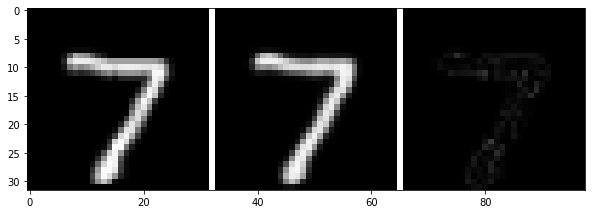

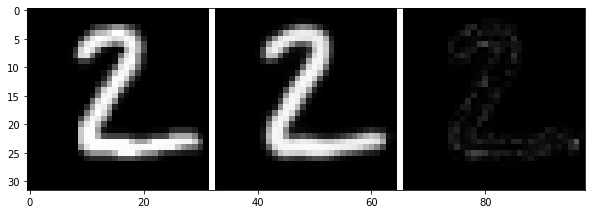

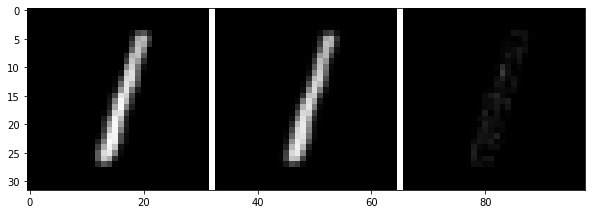

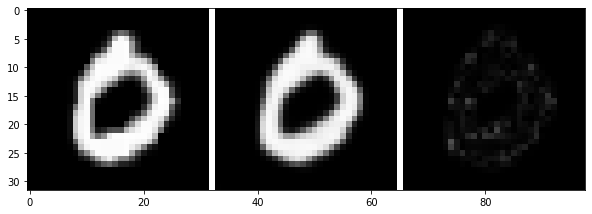

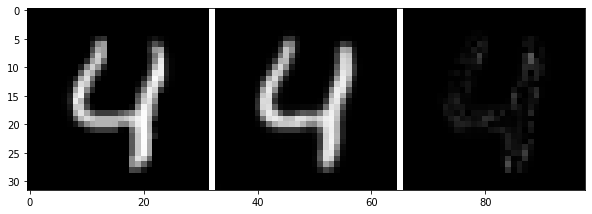

04/06/2020 11:57:47, epoch=136, step=16060, loss=0.01224, distortion=0.017, rate=0.021, -elbo=425.69373, nll=191.06274, KL=234.63098, commit_loss=9273.90625, bit_usage=0.96349, highest_prob=0.014, temp=0.06267
04/06/2020 11:57:48, epoch=136, step=16080, loss=0.01160, distortion=0.016, rate=0.021, -elbo=414.54602, nll=180.64868, KL=233.89732, commit_loss=9126.66895, bit_usage=0.96182, highest_prob=0.011, temp=0.06192
04/06/2020 11:57:49, epoch=136, step=16100, loss=0.01197, distortion=0.016, rate=0.020, -elbo=419.40234, nll=186.87846, KL=232.52388, commit_loss=9006.88477, bit_usage=0.96324, highest_prob=0.012, temp=0.06117
04/06/2020 11:57:50, epoch=136, step=16120, loss=0.01156, distortion=0.016, rate=0.021, -elbo=413.84406, nll=180.19431, KL=233.64975, commit_loss=9035.59375, bit_usage=0.96276, highest_prob=0.011, temp=0.06041
04/06/2020 11:57:51, epoch=136, step=16140, loss=0.01194, distortion=0.016, rate=0.021, -elbo=420.57825, nll=186.44501, KL=234.13322, commit_loss=8986.84570, bi

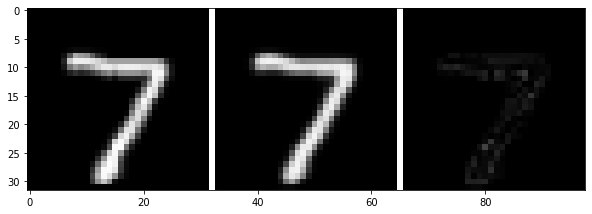

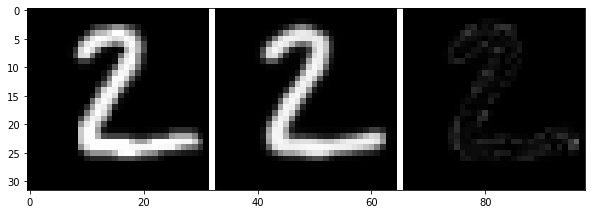

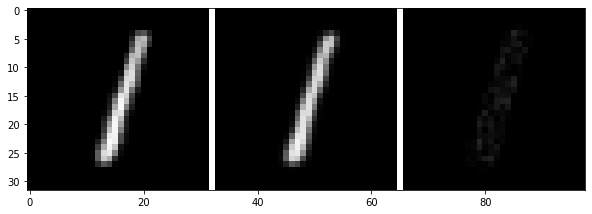

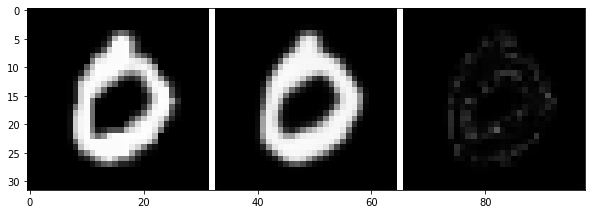

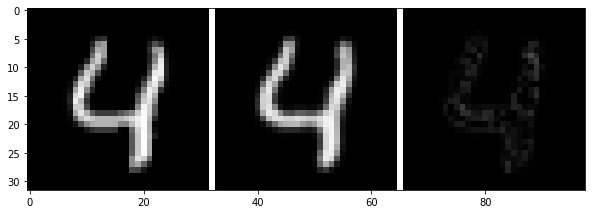

04/06/2020 11:58:17, epoch=141, step=16640, loss=0.01172, distortion=0.016, rate=0.021, -elbo=416.41223, nll=182.77440, KL=233.63785, commit_loss=8971.34863, bit_usage=0.96396, highest_prob=0.011, temp=0.04085
reset code 7
04/06/2020 11:58:18, epoch=141, step=16660, loss=0.01213, distortion=0.017, rate=0.021, -elbo=424.45929, nll=189.46504, KL=234.99425, commit_loss=9034.25781, bit_usage=0.96542, highest_prob=0.009, temp=0.04009
04/06/2020 11:58:18, epoch=141, step=16680, loss=0.01190, distortion=0.016, rate=0.020, -elbo=418.08057, nll=185.74339, KL=232.33719, commit_loss=8949.33008, bit_usage=0.96459, highest_prob=0.009, temp=0.03934
04/06/2020 11:58:19, epoch=141, step=16700, loss=0.01169, distortion=0.016, rate=0.020, -elbo=414.87631, nll=182.51007, KL=232.36624, commit_loss=8844.82520, bit_usage=0.96501, highest_prob=0.009, temp=0.03859
04/06/2020 11:58:20, epoch=141, step=16720, loss=0.01195, distortion=0.016, rate=0.021, -elbo=420.95245, nll=186.49521, KL=234.45723, commit_loss=8

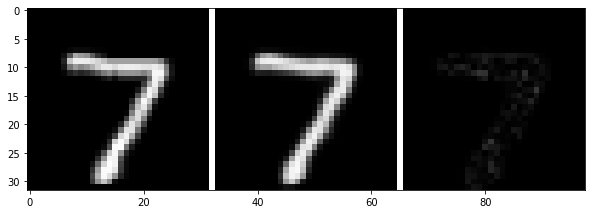

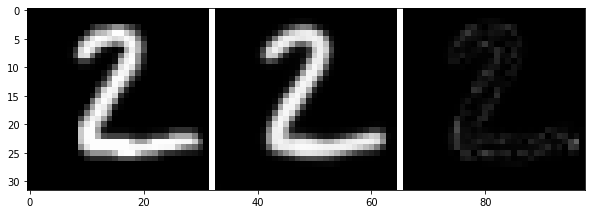

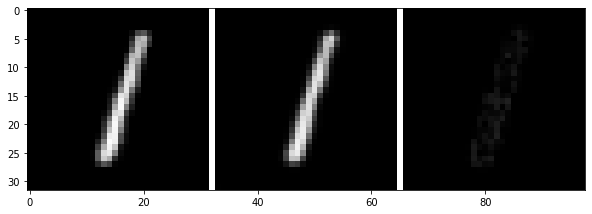

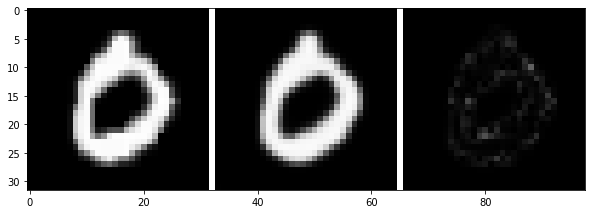

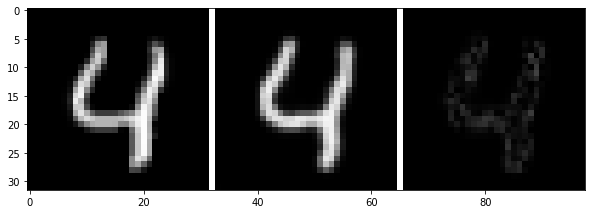

04/06/2020 11:58:49, epoch=146, step=17240, loss=0.01223, distortion=0.017, rate=0.021, -elbo=424.71338, nll=190.85205, KL=233.86134, commit_loss=9244.74805, bit_usage=0.96636, highest_prob=0.009, temp=0.01827
04/06/2020 11:58:50, epoch=146, step=17260, loss=0.01189, distortion=0.016, rate=0.021, -elbo=419.01538, nll=185.38321, KL=233.63217, commit_loss=9238.29492, bit_usage=0.96516, highest_prob=0.010, temp=0.01752
04/06/2020 11:58:51, epoch=146, step=17280, loss=0.01188, distortion=0.016, rate=0.021, -elbo=418.66476, nll=185.08350, KL=233.58127, commit_loss=9249.56641, bit_usage=0.96594, highest_prob=0.009, temp=0.01677
04/06/2020 11:58:52, epoch=146, step=17300, loss=0.01220, distortion=0.017, rate=0.021, -elbo=425.63782, nll=190.26355, KL=235.37427, commit_loss=9343.62012, bit_usage=0.96618, highest_prob=0.010, temp=0.01601
04/06/2020 11:58:53, epoch=146, step=17320, loss=0.01218, distortion=0.017, rate=0.021, -elbo=425.07394, nll=190.03635, KL=235.03760, commit_loss=9315.58496, bi

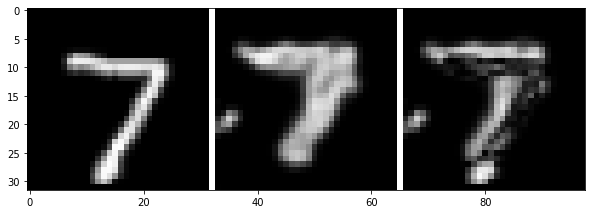

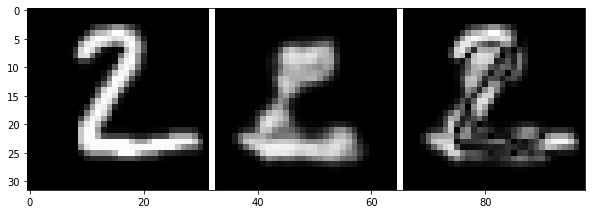

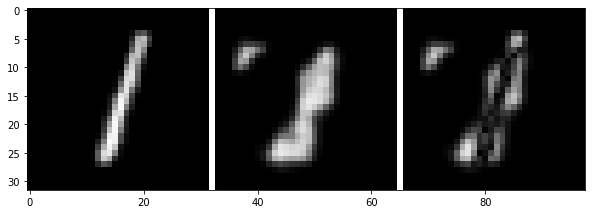

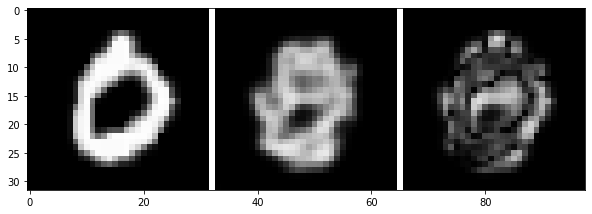

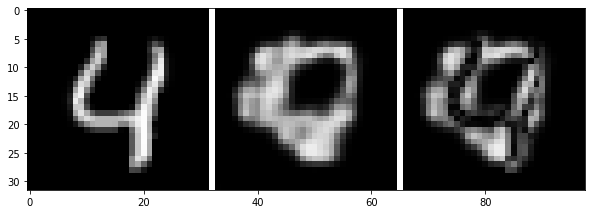

04/06/2020 11:59:18, epoch=1, step=120, loss=0.74266, distortion=1.071, rate=0.022, -elbo=3105.00049, nll=3041.26074, KL=63.73975, commit_loss=591.45428, bit_usage=0.40016, highest_prob=0.187, temp=0.66245
reset code 96
04/06/2020 11:59:19, epoch=1, step=140, loss=0.70842, distortion=1.022, rate=0.023, -elbo=2965.36987, nll=2901.03906, KL=64.33087, commit_loss=587.49261, bit_usage=0.40949, highest_prob=0.262, temp=0.66169
reset code 112
04/06/2020 11:59:20, epoch=1, step=160, loss=0.68866, distortion=0.993, rate=0.022, -elbo=2882.56250, nll=2820.11450, KL=62.44812, commit_loss=584.69543, bit_usage=0.44166, highest_prob=0.151, temp=0.66094
reset code 128
04/06/2020 11:59:21, epoch=1, step=180, loss=0.65890, distortion=0.950, rate=0.022, -elbo=2759.92432, nll=2698.20068, KL=61.72359, commit_loss=584.88708, bit_usage=0.46751, highest_prob=0.113, temp=0.66019
reset code 144
04/06/2020 11:59:21, epoch=1, step=200, loss=0.61947, distortion=0.893, rate=0.022, -elbo=2598.18701, nll=2536.71631,

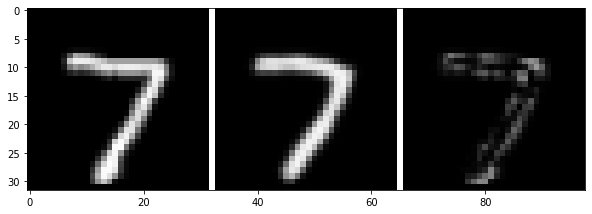

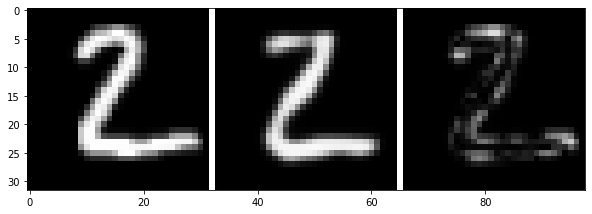

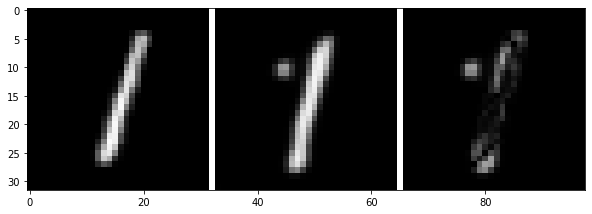

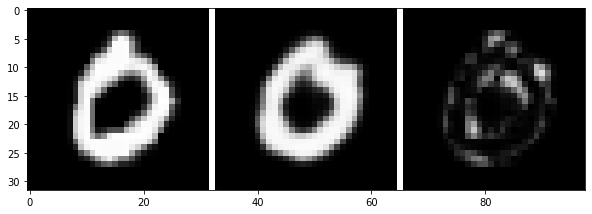

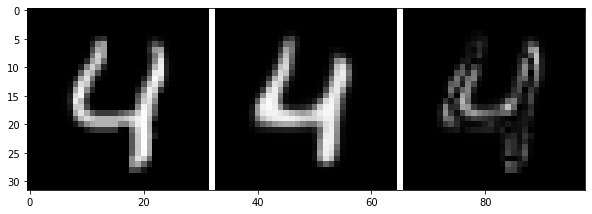

04/06/2020 11:59:43, epoch=6, step=720, loss=0.31141, distortion=0.449, rate=0.019, -elbo=1329.56165, nll=1274.85303, KL=54.70859, commit_loss=611.09528, bit_usage=0.68237, highest_prob=0.037, temp=0.63987
reset code 100
04/06/2020 11:59:44, epoch=6, step=740, loss=0.30341, distortion=0.437, rate=0.020, -elbo=1297.47534, nll=1242.08911, KL=55.38629, commit_loss=614.96942, bit_usage=0.68198, highest_prob=0.052, temp=0.63912
reset code 116
04/06/2020 11:59:44, epoch=6, step=760, loss=0.29713, distortion=0.428, rate=0.020, -elbo=1272.67810, nll=1216.38513, KL=56.29301, commit_loss=613.15540, bit_usage=0.67917, highest_prob=0.054, temp=0.63837
reset code 132
04/06/2020 11:59:45, epoch=6, step=780, loss=0.30389, distortion=0.438, rate=0.020, -elbo=1301.34509, nll=1244.07336, KL=57.27174, commit_loss=615.80859, bit_usage=0.67626, highest_prob=0.064, temp=0.63761
reset code 148
04/06/2020 11:59:46, epoch=6, step=800, loss=0.28821, distortion=0.416, rate=0.020, -elbo=1237.80249, nll=1179.84033

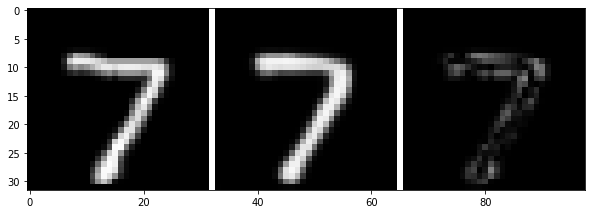

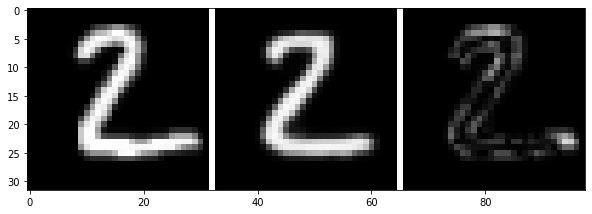

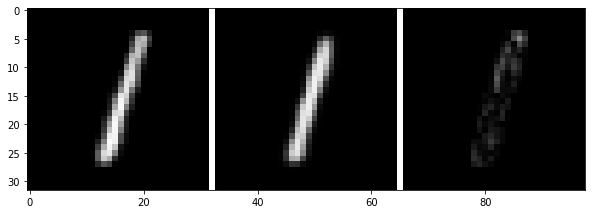

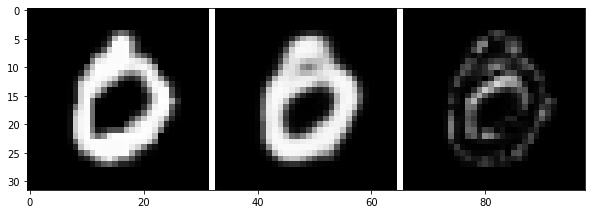

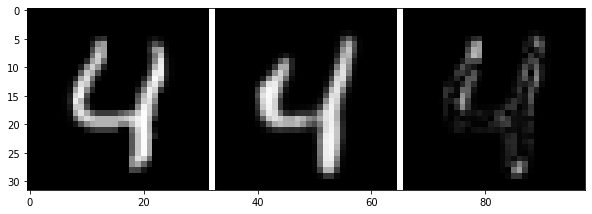

04/06/2020 12:00:05, epoch=11, step=1300, loss=0.20714, distortion=0.299, rate=0.022, -elbo=911.22113, nll=847.59644, KL=63.62468, commit_loss=769.79224, bit_usage=0.72999, highest_prob=0.041, temp=0.61805
reset code 82
04/06/2020 12:00:05, epoch=11, step=1320, loss=0.19892, distortion=0.287, rate=0.022, -elbo=877.10474, nll=813.93384, KL=63.17088, commit_loss=770.03320, bit_usage=0.73117, highest_prob=0.037, temp=0.61729
reset code 98
04/06/2020 12:00:06, epoch=11, step=1340, loss=0.20624, distortion=0.297, rate=0.023, -elbo=907.77490, nll=843.87311, KL=63.90182, commit_loss=808.24597, bit_usage=0.73195, highest_prob=0.040, temp=0.61654
reset code 114
04/06/2020 12:00:07, epoch=11, step=1360, loss=0.20410, distortion=0.294, rate=0.022, -elbo=898.90594, nll=835.09222, KL=63.81374, commit_loss=820.66772, bit_usage=0.73841, highest_prob=0.035, temp=0.61579
reset code 130
04/06/2020 12:00:07, epoch=11, step=1380, loss=0.19536, distortion=0.282, rate=0.022, -elbo=863.01501, nll=799.33337, 

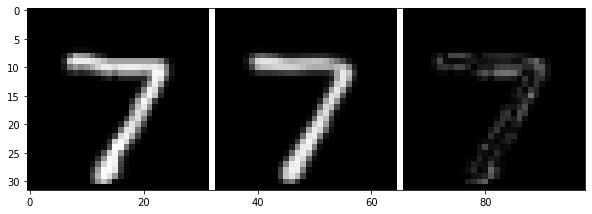

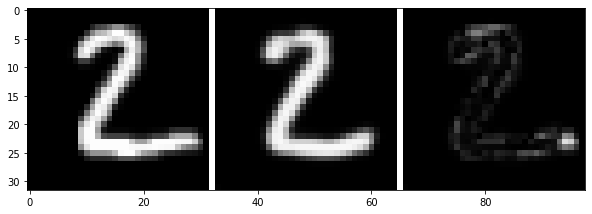

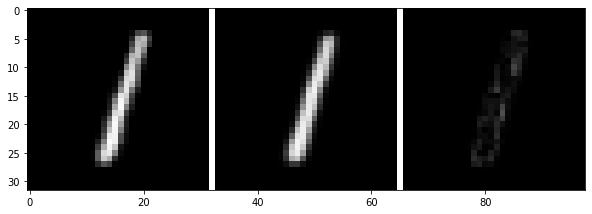

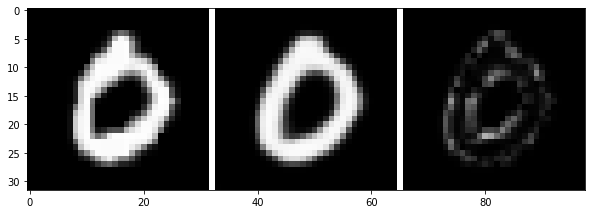

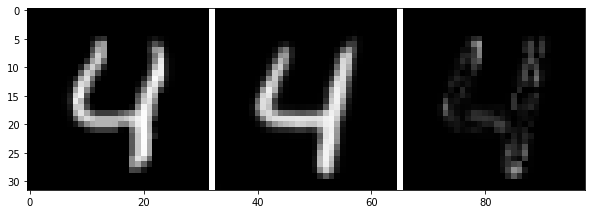

04/06/2020 12:00:27, epoch=16, step=1900, loss=0.15540, distortion=0.224, rate=0.024, -elbo=701.82922, nll=635.02173, KL=66.80749, commit_loss=1429.90674, bit_usage=0.79758, highest_prob=0.021, temp=0.59547
reset code 54
04/06/2020 12:00:28, epoch=16, step=1920, loss=0.15978, distortion=0.230, rate=0.023, -elbo=719.48572, nll=652.97778, KL=66.50792, commit_loss=1399.98950, bit_usage=0.79908, highest_prob=0.025, temp=0.59472
reset code 70
04/06/2020 12:00:29, epoch=16, step=1940, loss=0.15549, distortion=0.224, rate=0.024, -elbo=702.18347, nll=635.35883, KL=66.82464, commit_loss=1455.93298, bit_usage=0.80161, highest_prob=0.026, temp=0.59397
reset code 86
04/06/2020 12:00:29, epoch=16, step=1960, loss=0.15563, distortion=0.224, rate=0.024, -elbo=702.82520, nll=635.91730, KL=66.90792, commit_loss=1492.16553, bit_usage=0.80161, highest_prob=0.025, temp=0.59321
reset code 102
04/06/2020 12:00:30, epoch=16, step=1980, loss=0.15495, distortion=0.223, rate=0.024, -elbo=699.83185, nll=633.1046

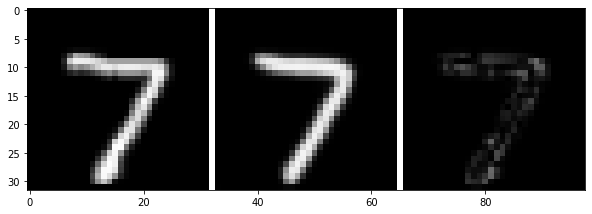

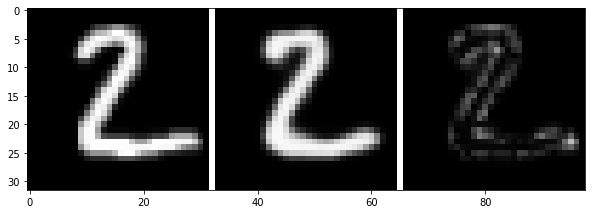

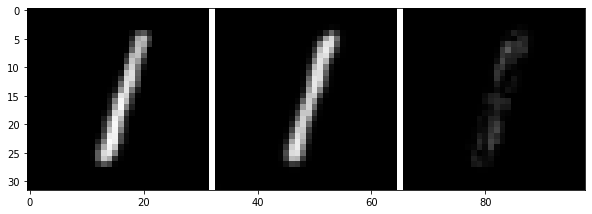

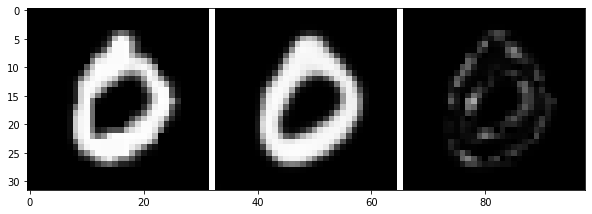

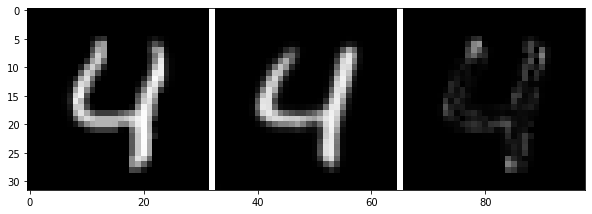

04/06/2020 12:00:49, epoch=21, step=2480, loss=0.13661, distortion=0.196, rate=0.024, -elbo=624.15198, nll=557.12939, KL=67.02257, commit_loss=2338.50098, bit_usage=0.85299, highest_prob=0.015, temp=0.57365
reset code 33
04/06/2020 12:00:50, epoch=21, step=2500, loss=0.13852, distortion=0.199, rate=0.024, -elbo=632.42236, nll=564.88617, KL=67.53621, commit_loss=2419.60742, bit_usage=0.84932, highest_prob=0.016, temp=0.57289
reset code 49
04/06/2020 12:00:51, epoch=21, step=2520, loss=0.13135, distortion=0.189, rate=0.024, -elbo=602.90009, nll=535.48682, KL=67.41326, commit_loss=2457.75391, bit_usage=0.85481, highest_prob=0.016, temp=0.57214
reset code 224
04/06/2020 12:00:52, epoch=21, step=2540, loss=0.13541, distortion=0.194, rate=0.024, -elbo=619.36359, nll=552.05420, KL=67.30937, commit_loss=2498.18555, bit_usage=0.85628, highest_prob=0.015, temp=0.57139
reset code 65
04/06/2020 12:00:53, epoch=21, step=2560, loss=0.13878, distortion=0.199, rate=0.024, -elbo=633.30310, nll=565.8013

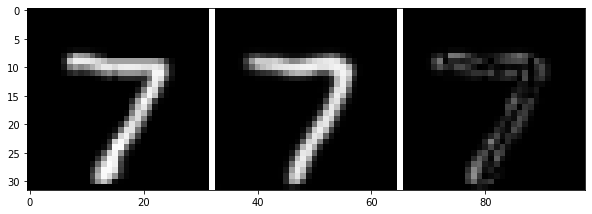

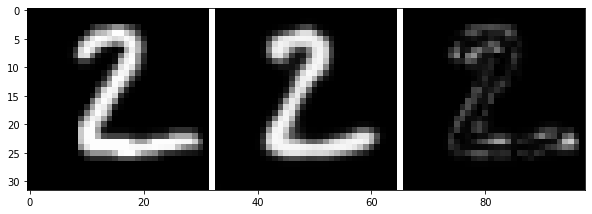

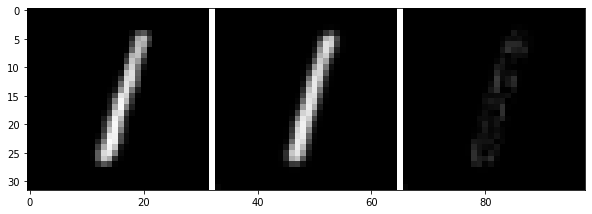

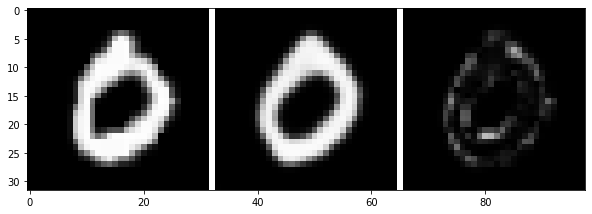

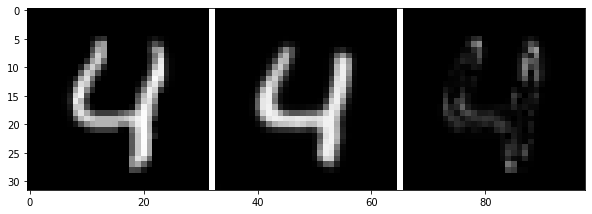

04/06/2020 12:01:14, epoch=26, step=3080, loss=0.11985, distortion=0.172, rate=0.024, -elbo=554.97949, nll=487.28308, KL=67.69643, commit_loss=3543.84961, bit_usage=0.88971, highest_prob=0.013, temp=0.55107
reset code 249
04/06/2020 12:01:15, epoch=26, step=3100, loss=0.12577, distortion=0.180, rate=0.024, -elbo=579.54547, nll=511.45657, KL=68.08891, commit_loss=3629.12061, bit_usage=0.88943, highest_prob=0.015, temp=0.55032
reset code 5
04/06/2020 12:01:16, epoch=26, step=3120, loss=0.12174, distortion=0.174, rate=0.024, -elbo=562.90070, nll=494.90161, KL=67.99910, commit_loss=3690.77881, bit_usage=0.89059, highest_prob=0.013, temp=0.54957
reset code 21
04/06/2020 12:01:16, epoch=26, step=3140, loss=0.12225, distortion=0.175, rate=0.024, -elbo=565.02112, nll=496.95990, KL=68.06122, commit_loss=3717.80762, bit_usage=0.89221, highest_prob=0.013, temp=0.54881
reset code 37
04/06/2020 12:01:17, epoch=26, step=3160, loss=0.12193, distortion=0.175, rate=0.024, -elbo=564.02106, nll=495.64041

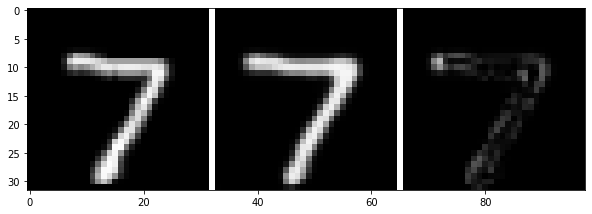

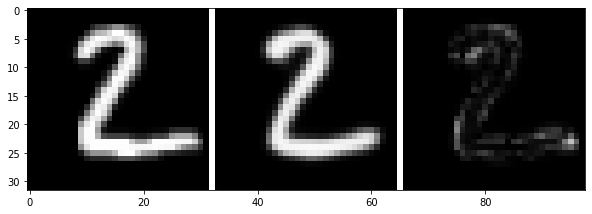

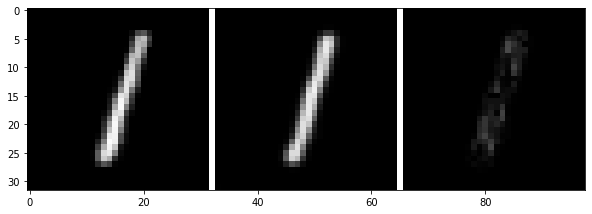

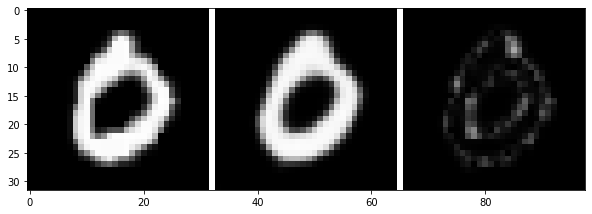

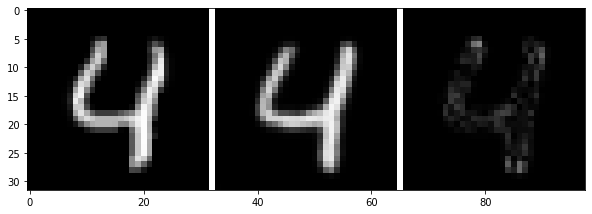

04/06/2020 12:01:39, epoch=31, step=3660, loss=0.10935, distortion=0.156, rate=0.024, -elbo=511.89062, nll=443.22626, KL=68.66437, commit_loss=4612.09277, bit_usage=0.91405, highest_prob=0.015, temp=0.52925
reset code 205
04/06/2020 12:01:39, epoch=31, step=3680, loss=0.10903, distortion=0.156, rate=0.024, -elbo=510.50424, nll=441.94141, KL=68.56284, commit_loss=4588.52344, bit_usage=0.91690, highest_prob=0.010, temp=0.52849
reset code 221
04/06/2020 12:01:40, epoch=31, step=3700, loss=0.11070, distortion=0.158, rate=0.024, -elbo=517.53638, nll=448.68451, KL=68.85188, commit_loss=4675.27051, bit_usage=0.91761, highest_prob=0.011, temp=0.52774
reset code 237
04/06/2020 12:01:41, epoch=31, step=3720, loss=0.11096, distortion=0.158, rate=0.024, -elbo=518.52747, nll=449.64709, KL=68.88040, commit_loss=4779.09668, bit_usage=0.91764, highest_prob=0.011, temp=0.52699
reset code 253
04/06/2020 12:01:42, epoch=31, step=3740, loss=0.10689, distortion=0.152, rate=0.024, -elbo=501.57974, nll=432.9

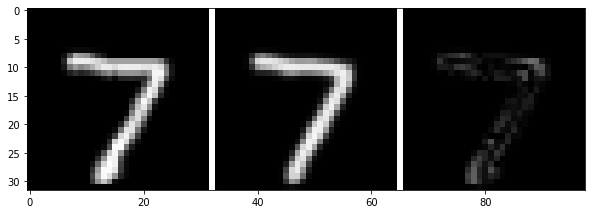

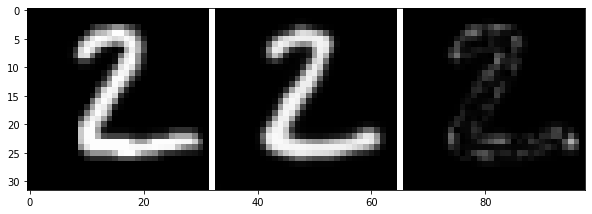

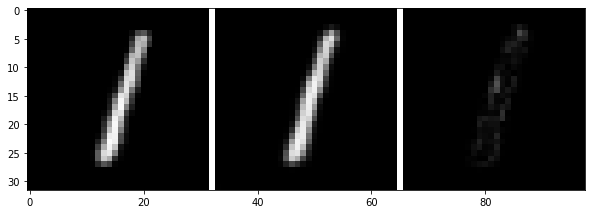

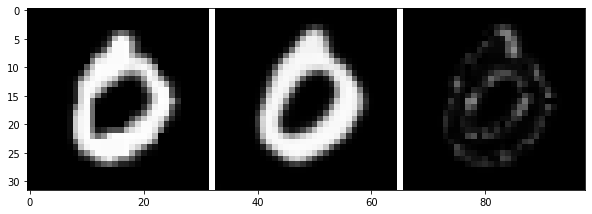

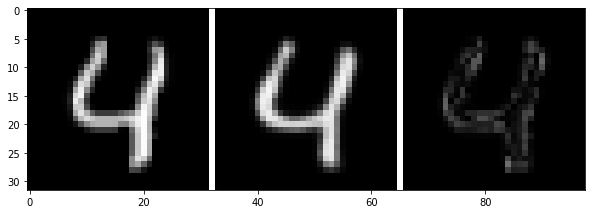

04/06/2020 12:02:05, epoch=36, step=4260, loss=0.10637, distortion=0.151, rate=0.024, -elbo=499.23114, nll=430.04587, KL=69.18529, commit_loss=5596.26758, bit_usage=0.93798, highest_prob=0.013, temp=0.50667
reset code 155
04/06/2020 12:02:05, epoch=36, step=4280, loss=0.10375, distortion=0.148, rate=0.024, -elbo=488.22656, nll=419.42456, KL=68.80200, commit_loss=5463.60059, bit_usage=0.93863, highest_prob=0.010, temp=0.50592
reset code 171
04/06/2020 12:02:06, epoch=36, step=4300, loss=0.10562, distortion=0.150, rate=0.024, -elbo=495.80942, nll=426.98456, KL=68.82487, commit_loss=5561.84814, bit_usage=0.94123, highest_prob=0.010, temp=0.50517
reset code 139
04/06/2020 12:02:07, epoch=36, step=4320, loss=0.10856, distortion=0.155, rate=0.024, -elbo=508.05426, nll=438.78918, KL=69.26509, commit_loss=5792.40479, bit_usage=0.94099, highest_prob=0.010, temp=0.50441
reset code 203
04/06/2020 12:02:07, epoch=36, step=4340, loss=0.10698, distortion=0.152, rate=0.024, -elbo=501.35883, nll=432.3

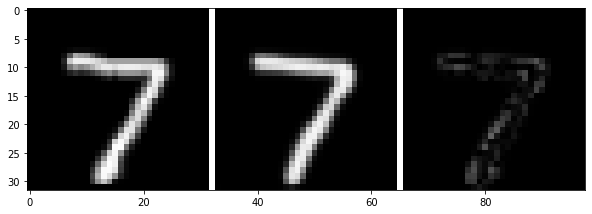

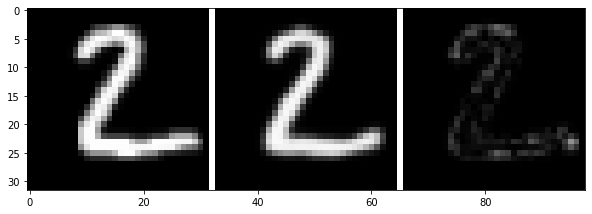

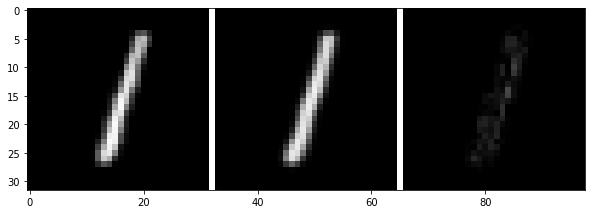

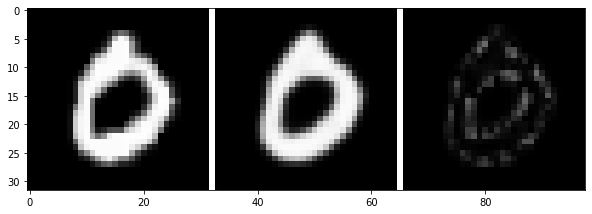

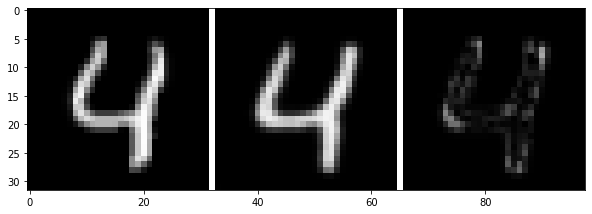

04/06/2020 12:02:26, epoch=41, step=4840, loss=0.09618, distortion=0.137, rate=0.024, -elbo=456.74918, nll=387.64526, KL=69.10391, commit_loss=6228.43799, bit_usage=0.95538, highest_prob=0.011, temp=0.48485
reset code 143
04/06/2020 12:02:27, epoch=41, step=4860, loss=0.10437, distortion=0.148, rate=0.024, -elbo=490.23834, nll=420.98737, KL=69.25096, commit_loss=6434.58398, bit_usage=0.95797, highest_prob=0.010, temp=0.48409
reset code 159
04/06/2020 12:02:28, epoch=41, step=4880, loss=0.10308, distortion=0.146, rate=0.024, -elbo=485.10199, nll=415.81863, KL=69.28334, commit_loss=6323.09863, bit_usage=0.95883, highest_prob=0.010, temp=0.48334
reset code 175
04/06/2020 12:02:28, epoch=41, step=4900, loss=0.10232, distortion=0.145, rate=0.024, -elbo=481.54163, nll=412.52362, KL=69.01802, commit_loss=6506.51855, bit_usage=0.95966, highest_prob=0.009, temp=0.48259
reset code 191
04/06/2020 12:02:29, epoch=41, step=4920, loss=0.09957, distortion=0.141, rate=0.024, -elbo=470.23761, nll=401.3

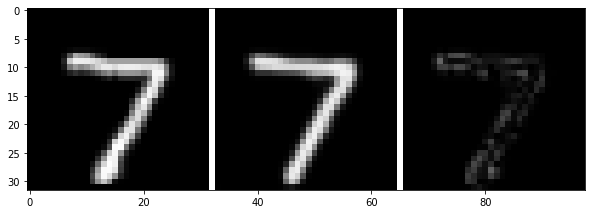

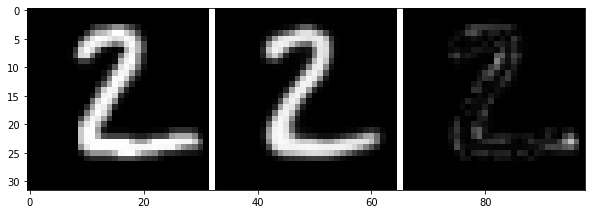

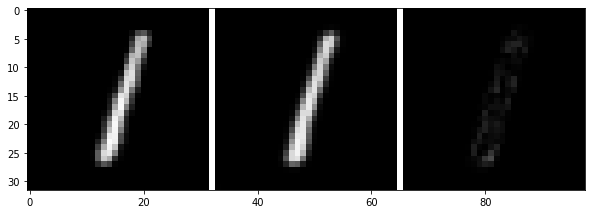

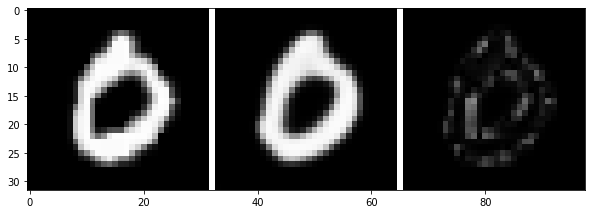

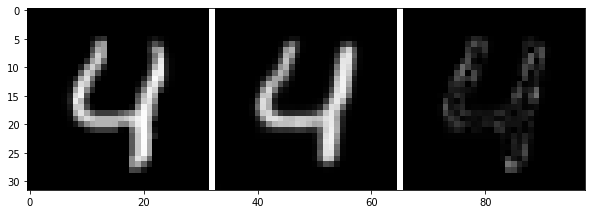

04/06/2020 12:02:49, epoch=46, step=5440, loss=0.09494, distortion=0.135, rate=0.024, -elbo=451.09149, nll=381.97626, KL=69.11523, commit_loss=6848.19385, bit_usage=0.97459, highest_prob=0.009, temp=0.46227
reset code 129
04/06/2020 12:02:50, epoch=46, step=5460, loss=0.09931, distortion=0.141, rate=0.024, -elbo=468.98029, nll=399.80853, KL=69.17175, commit_loss=6882.71484, bit_usage=0.97419, highest_prob=0.009, temp=0.46152
04/06/2020 12:02:50, epoch=46, step=5480, loss=0.09606, distortion=0.136, rate=0.024, -elbo=455.53021, nll=386.60278, KL=68.92741, commit_loss=6808.48535, bit_usage=0.97521, highest_prob=0.008, temp=0.46077
04/06/2020 12:02:51, epoch=46, step=5500, loss=0.09544, distortion=0.135, rate=0.024, -elbo=452.79404, nll=383.78854, KL=69.00549, commit_loss=7064.55566, bit_usage=0.97647, highest_prob=0.010, temp=0.46001
04/06/2020 12:02:52, epoch=46, step=5520, loss=0.10219, distortion=0.145, rate=0.024, -elbo=480.96222, nll=411.60916, KL=69.35307, commit_loss=6905.89551, bi

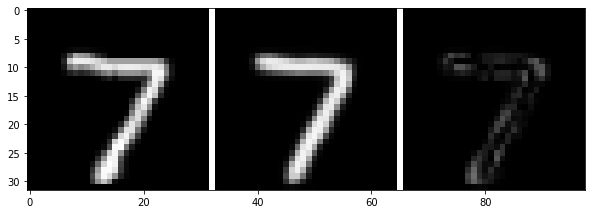

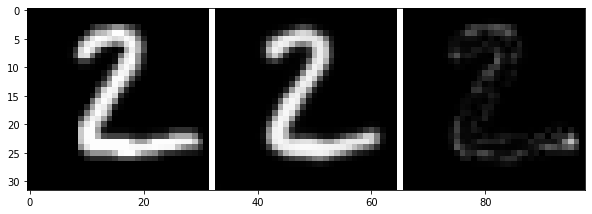

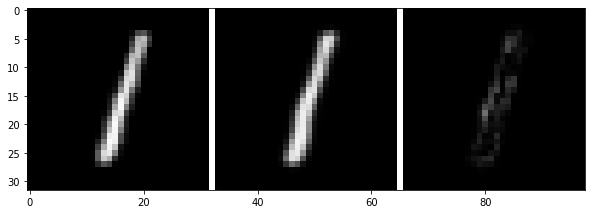

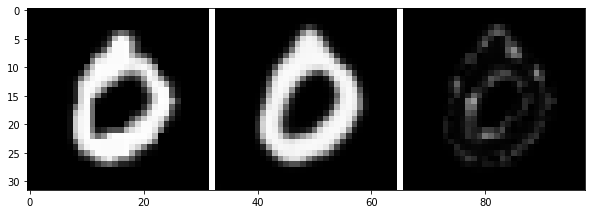

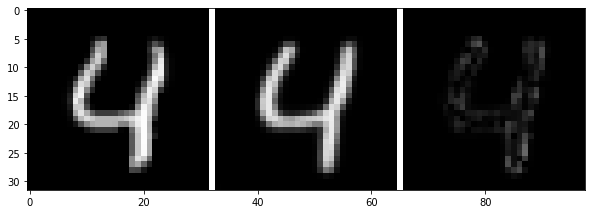

04/06/2020 12:03:11, epoch=51, step=6020, loss=0.09509, distortion=0.134, rate=0.025, -elbo=452.03259, nll=381.83417, KL=70.19843, commit_loss=7581.56152, bit_usage=0.97751, highest_prob=0.009, temp=0.44045
04/06/2020 12:03:12, epoch=51, step=6040, loss=0.09598, distortion=0.136, rate=0.025, -elbo=455.63962, nll=385.68976, KL=69.94986, commit_loss=7386.93555, bit_usage=0.97732, highest_prob=0.009, temp=0.43969
04/06/2020 12:03:12, epoch=51, step=6060, loss=0.09203, distortion=0.130, rate=0.025, -elbo=439.46991, nll=369.41891, KL=70.05099, commit_loss=7477.65967, bit_usage=0.97758, highest_prob=0.008, temp=0.43894
reset code 39
04/06/2020 12:03:13, epoch=51, step=6080, loss=0.09155, distortion=0.130, rate=0.025, -elbo=437.63602, nll=367.67056, KL=69.96545, commit_loss=7261.34570, bit_usage=0.97840, highest_prob=0.009, temp=0.43819
04/06/2020 12:03:14, epoch=51, step=6100, loss=0.08887, distortion=0.126, rate=0.025, -elbo=426.32114, nll=356.66412, KL=69.65701, commit_loss=7286.70020, bit

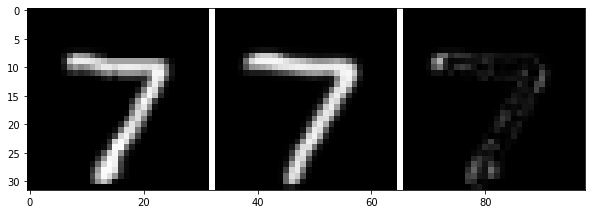

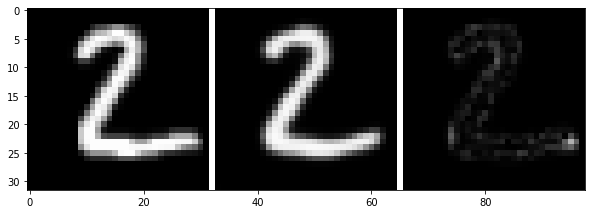

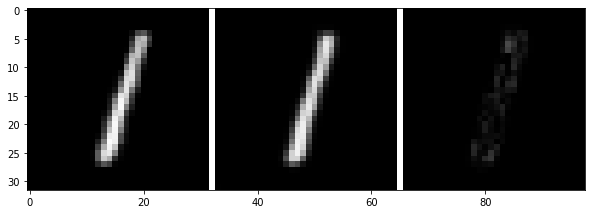

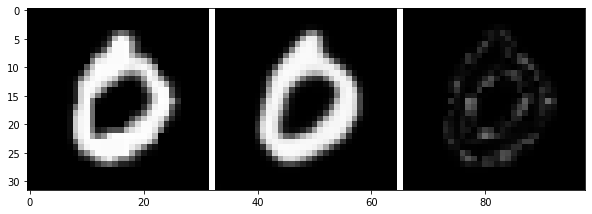

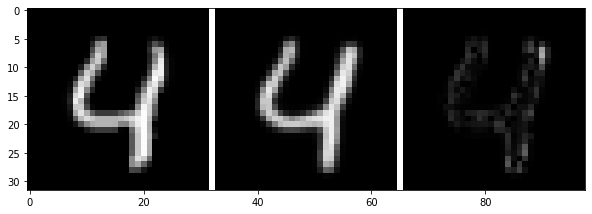

04/06/2020 12:03:34, epoch=56, step=6620, loss=0.09194, distortion=0.130, rate=0.025, -elbo=439.39746, nll=368.66864, KL=70.72882, commit_loss=7841.84668, bit_usage=0.97978, highest_prob=0.009, temp=0.41787
04/06/2020 12:03:34, epoch=56, step=6640, loss=0.08888, distortion=0.126, rate=0.025, -elbo=427.19592, nll=356.31436, KL=70.88155, commit_loss=7670.85156, bit_usage=0.97926, highest_prob=0.010, temp=0.41712
reset code 234
04/06/2020 12:03:35, epoch=56, step=6660, loss=0.09343, distortion=0.132, rate=0.025, -elbo=445.84262, nll=374.98785, KL=70.85477, commit_loss=7638.29004, bit_usage=0.98123, highest_prob=0.009, temp=0.41637
04/06/2020 12:03:36, epoch=56, step=6680, loss=0.09213, distortion=0.130, rate=0.025, -elbo=440.40875, nll=369.44208, KL=70.96668, commit_loss=7850.74463, bit_usage=0.97825, highest_prob=0.010, temp=0.41561
04/06/2020 12:03:36, epoch=56, step=6700, loss=0.09206, distortion=0.130, rate=0.025, -elbo=440.24536, nll=369.35922, KL=70.88612, commit_loss=7660.28809, bi

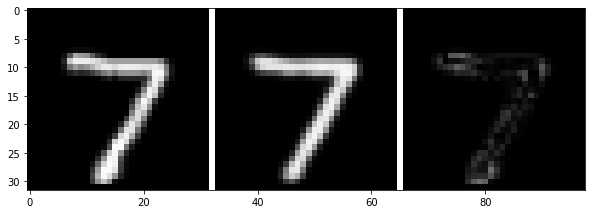

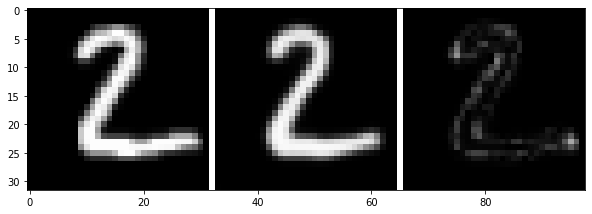

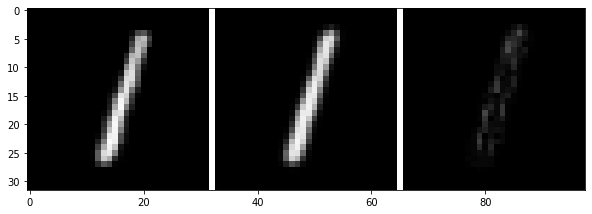

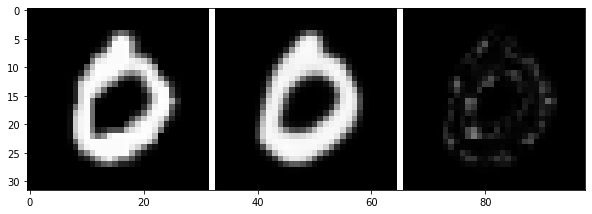

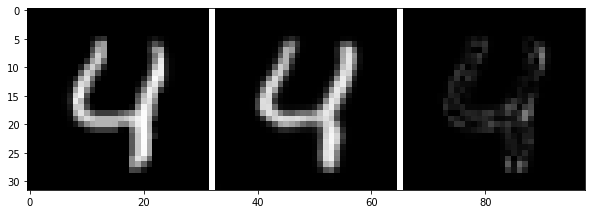

04/06/2020 12:03:56, epoch=61, step=7200, loss=0.09391, distortion=0.133, rate=0.025, -elbo=448.08014, nll=376.43152, KL=71.64864, commit_loss=8165.78906, bit_usage=0.98089, highest_prob=0.010, temp=0.39605
04/06/2020 12:03:56, epoch=61, step=7220, loss=0.09137, distortion=0.129, rate=0.025, -elbo=437.89029, nll=366.07666, KL=71.81363, commit_loss=8121.83838, bit_usage=0.98071, highest_prob=0.008, temp=0.39529
04/06/2020 12:03:57, epoch=61, step=7240, loss=0.08603, distortion=0.121, rate=0.025, -elbo=415.94675, nll=344.27136, KL=71.67538, commit_loss=8044.47217, bit_usage=0.98111, highest_prob=0.008, temp=0.39454
04/06/2020 12:03:58, epoch=61, step=7260, loss=0.09283, distortion=0.131, rate=0.025, -elbo=443.78619, nll=372.06406, KL=71.72212, commit_loss=8104.12598, bit_usage=0.98191, highest_prob=0.009, temp=0.39379
04/06/2020 12:03:58, epoch=61, step=7280, loss=0.08750, distortion=0.123, rate=0.025, -elbo=421.49307, nll=350.11700, KL=71.37607, commit_loss=8195.02344, bit_usage=0.98196

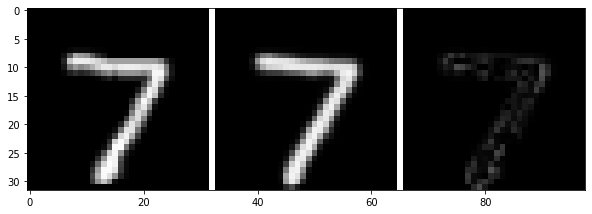

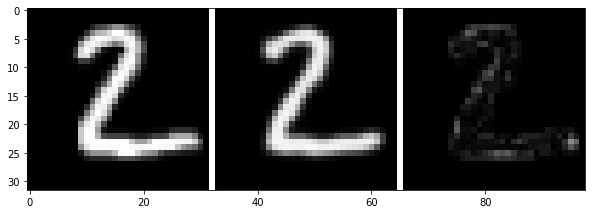

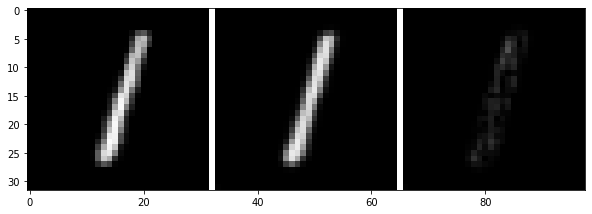

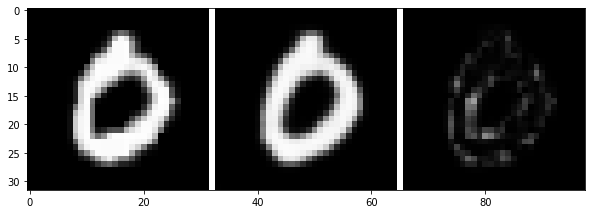

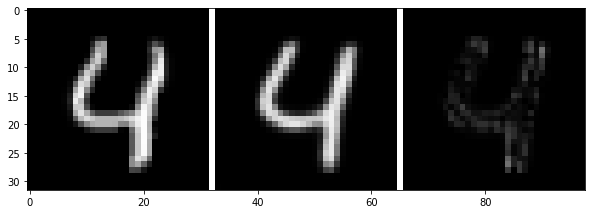

04/06/2020 12:04:20, epoch=66, step=7800, loss=0.08797, distortion=0.124, rate=0.025, -elbo=423.99023, nll=351.69629, KL=72.29395, commit_loss=8559.57812, bit_usage=0.98124, highest_prob=0.008, temp=0.37347
04/06/2020 12:04:20, epoch=66, step=7820, loss=0.08873, distortion=0.125, rate=0.025, -elbo=427.19757, nll=354.97595, KL=72.22162, commit_loss=8406.83203, bit_usage=0.98375, highest_prob=0.008, temp=0.37272
reset code 108
04/06/2020 12:04:21, epoch=66, step=7840, loss=0.08624, distortion=0.121, rate=0.025, -elbo=416.81891, nll=344.73300, KL=72.08589, commit_loss=8420.65234, bit_usage=0.98373, highest_prob=0.007, temp=0.37197
04/06/2020 12:04:22, epoch=66, step=7860, loss=0.08845, distortion=0.125, rate=0.025, -elbo=426.11807, nll=353.82092, KL=72.29714, commit_loss=8383.47363, bit_usage=0.98130, highest_prob=0.008, temp=0.37121
reset code 142
04/06/2020 12:04:23, epoch=66, step=7880, loss=0.08683, distortion=0.122, rate=0.025, -elbo=419.28702, nll=347.11349, KL=72.17352, commit_loss

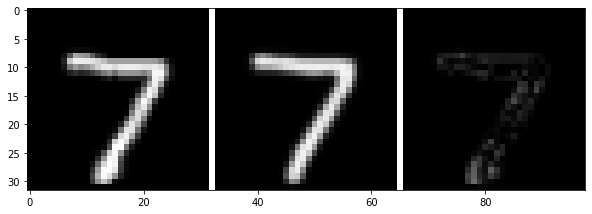

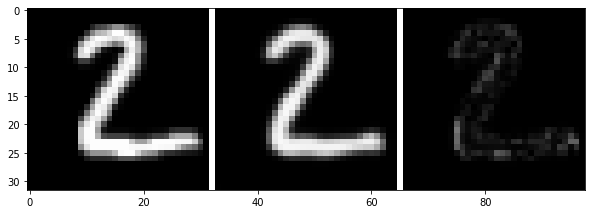

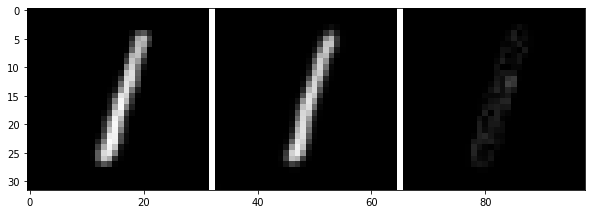

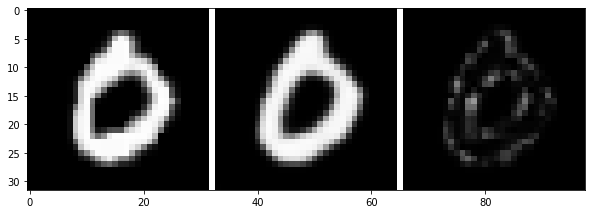

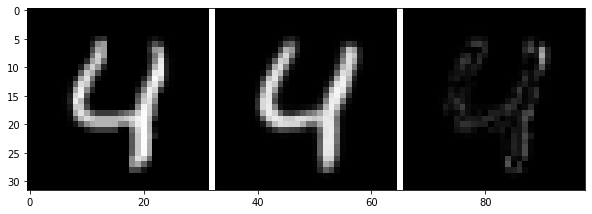

04/06/2020 12:04:43, epoch=71, step=8380, loss=0.08550, distortion=0.120, rate=0.026, -elbo=414.12286, nll=341.53574, KL=72.58714, commit_loss=8587.71387, bit_usage=0.98503, highest_prob=0.008, temp=0.35165
04/06/2020 12:04:43, epoch=71, step=8400, loss=0.09013, distortion=0.127, rate=0.026, -elbo=433.27225, nll=360.41632, KL=72.85593, commit_loss=8695.64844, bit_usage=0.98391, highest_prob=0.009, temp=0.35089
04/06/2020 12:04:44, epoch=71, step=8420, loss=0.08307, distortion=0.117, rate=0.026, -elbo=404.22217, nll=331.54633, KL=72.67583, commit_loss=8627.76953, bit_usage=0.98221, highest_prob=0.009, temp=0.35014
04/06/2020 12:04:45, epoch=71, step=8440, loss=0.08315, distortion=0.117, rate=0.026, -elbo=404.70004, nll=332.02567, KL=72.67437, commit_loss=8464.52734, bit_usage=0.98329, highest_prob=0.008, temp=0.34939
04/06/2020 12:04:46, epoch=71, step=8460, loss=0.08819, distortion=0.124, rate=0.026, -elbo=425.27209, nll=352.67676, KL=72.59534, commit_loss=8458.18359, bit_usage=0.98335

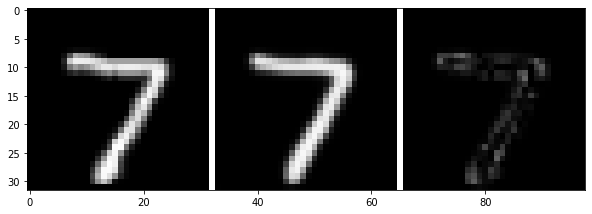

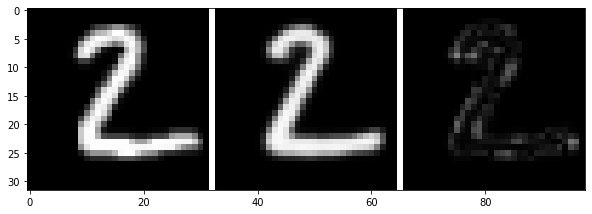

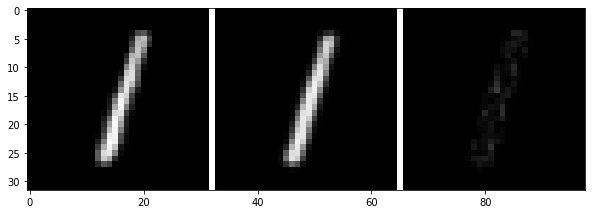

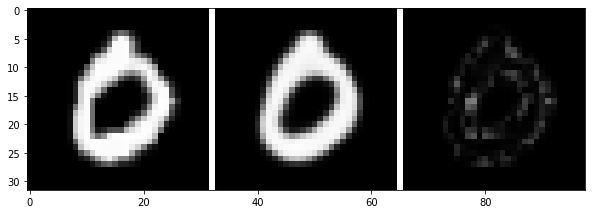

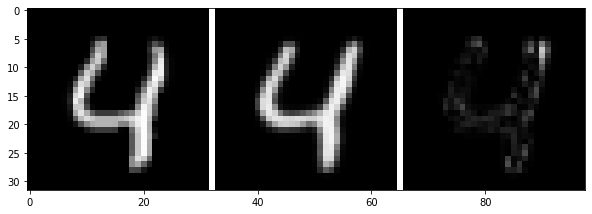

04/06/2020 12:05:06, epoch=76, step=8980, loss=0.08495, distortion=0.119, rate=0.026, -elbo=412.42383, nll=338.96124, KL=73.46257, commit_loss=8909.18066, bit_usage=0.98434, highest_prob=0.008, temp=0.32907
04/06/2020 12:05:07, epoch=76, step=9000, loss=0.08536, distortion=0.120, rate=0.026, -elbo=413.91068, nll=340.77228, KL=73.13839, commit_loss=8790.03125, bit_usage=0.98466, highest_prob=0.008, temp=0.32832
04/06/2020 12:05:08, epoch=76, step=9020, loss=0.08639, distortion=0.121, rate=0.026, -elbo=418.07492, nll=344.90286, KL=73.17206, commit_loss=8875.49121, bit_usage=0.98500, highest_prob=0.009, temp=0.32757
04/06/2020 12:05:08, epoch=76, step=9040, loss=0.08515, distortion=0.120, rate=0.026, -elbo=412.97855, nll=339.76202, KL=73.21651, commit_loss=8952.63867, bit_usage=0.98478, highest_prob=0.008, temp=0.32681
04/06/2020 12:05:09, epoch=76, step=9060, loss=0.08525, distortion=0.120, rate=0.026, -elbo=413.42520, nll=340.39417, KL=73.03103, commit_loss=8735.43262, bit_usage=0.98607

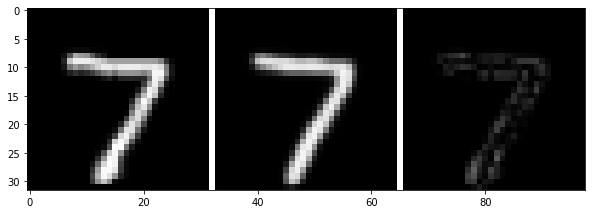

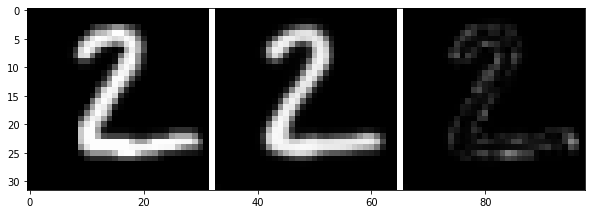

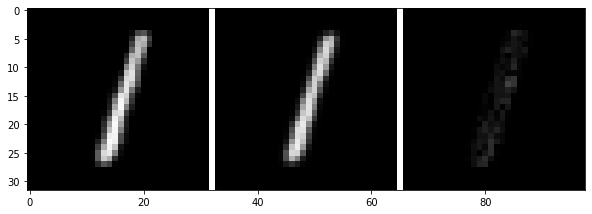

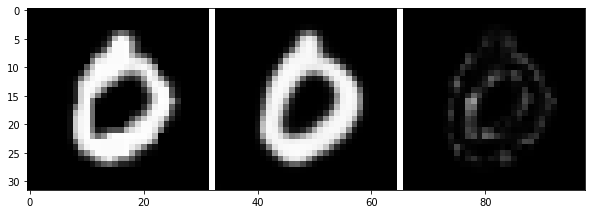

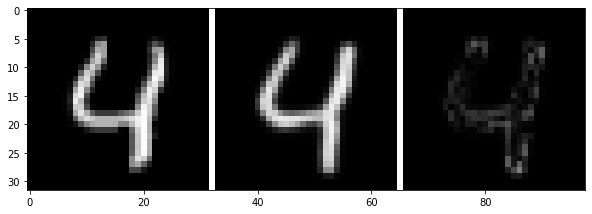

04/06/2020 12:05:29, epoch=81, step=9560, loss=0.08544, distortion=0.120, rate=0.026, -elbo=414.43918, nll=340.94418, KL=73.49500, commit_loss=8926.66602, bit_usage=0.98592, highest_prob=0.010, temp=0.30725
04/06/2020 12:05:29, epoch=81, step=9580, loss=0.08350, distortion=0.117, rate=0.026, -elbo=406.41513, nll=333.04846, KL=73.36667, commit_loss=8887.46484, bit_usage=0.98699, highest_prob=0.008, temp=0.30649
04/06/2020 12:05:30, epoch=81, step=9600, loss=0.08341, distortion=0.117, rate=0.026, -elbo=406.18054, nll=332.77112, KL=73.40942, commit_loss=8805.69238, bit_usage=0.98745, highest_prob=0.008, temp=0.30574
04/06/2020 12:05:31, epoch=81, step=9620, loss=0.08430, distortion=0.118, rate=0.026, -elbo=409.55383, nll=336.33835, KL=73.21548, commit_loss=8863.25195, bit_usage=0.98703, highest_prob=0.008, temp=0.30499
04/06/2020 12:05:31, epoch=81, step=9640, loss=0.08777, distortion=0.123, rate=0.026, -elbo=423.85510, nll=350.32983, KL=73.52528, commit_loss=9106.30371, bit_usage=0.98613

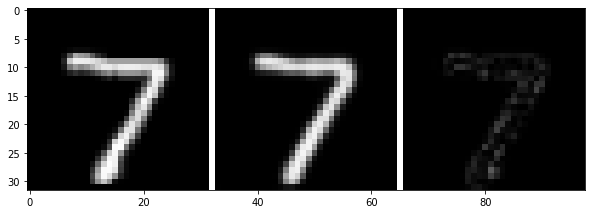

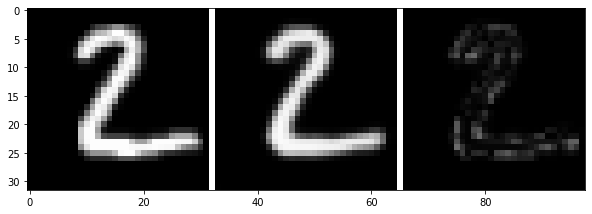

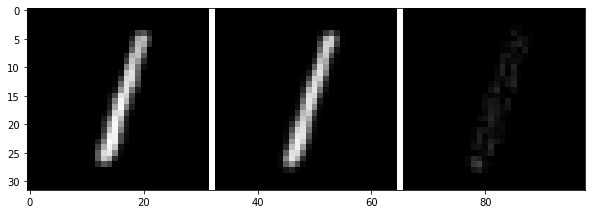

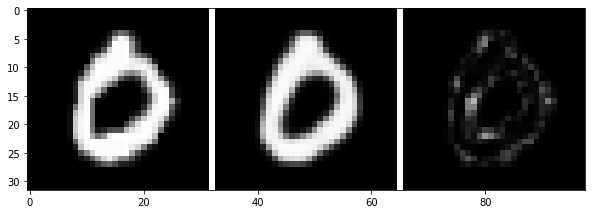

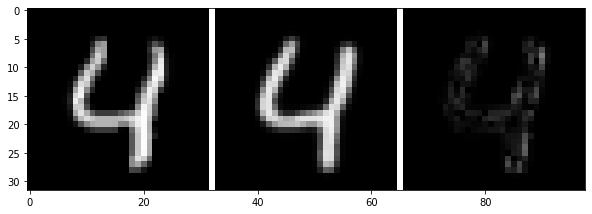

04/06/2020 12:05:53, epoch=86, step=10160, loss=0.08421, distortion=0.118, rate=0.026, -elbo=409.69135, nll=335.58109, KL=74.11024, commit_loss=9272.01367, bit_usage=0.98577, highest_prob=0.008, temp=0.28467
04/06/2020 12:05:53, epoch=86, step=10180, loss=0.08095, distortion=0.114, rate=0.026, -elbo=396.62650, nll=322.45624, KL=74.17027, commit_loss=9057.47656, bit_usage=0.98467, highest_prob=0.008, temp=0.28392
reset code 184
04/06/2020 12:05:54, epoch=86, step=10200, loss=0.08399, distortion=0.118, rate=0.026, -elbo=408.87723, nll=334.70230, KL=74.17493, commit_loss=9231.82031, bit_usage=0.98566, highest_prob=0.009, temp=0.28317
04/06/2020 12:05:55, epoch=86, step=10220, loss=0.08592, distortion=0.121, rate=0.026, -elbo=416.77576, nll=342.70682, KL=74.06894, commit_loss=9149.19727, bit_usage=0.98686, highest_prob=0.007, temp=0.28241
04/06/2020 12:05:56, epoch=86, step=10240, loss=0.08337, distortion=0.117, rate=0.026, -elbo=406.39716, nll=332.33411, KL=74.06303, commit_loss=9092.3300

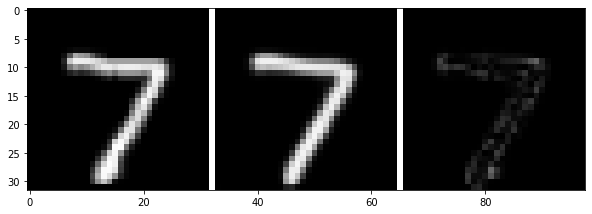

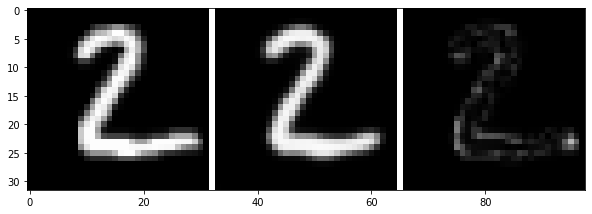

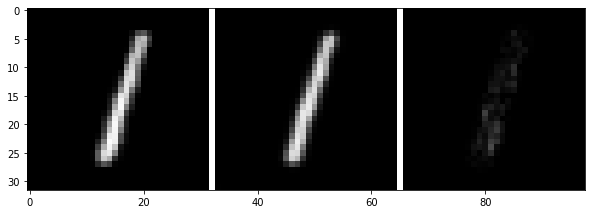

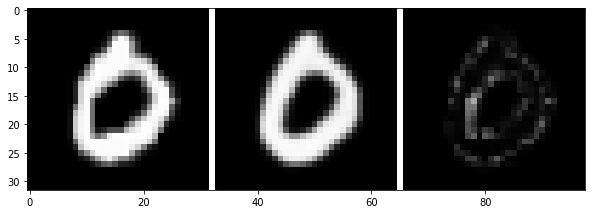

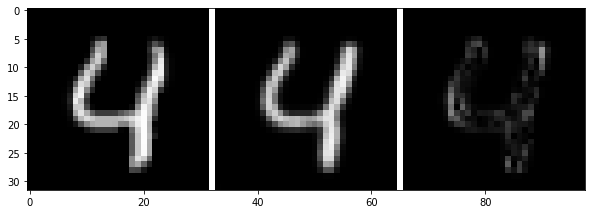

04/06/2020 12:06:15, epoch=91, step=10740, loss=0.08063, distortion=0.113, rate=0.026, -elbo=395.24393, nll=320.93402, KL=74.30991, commit_loss=9238.97949, bit_usage=0.98665, highest_prob=0.008, temp=0.26285
04/06/2020 12:06:16, epoch=91, step=10760, loss=0.08251, distortion=0.116, rate=0.026, -elbo=403.29276, nll=328.56592, KL=74.72684, commit_loss=9334.51660, bit_usage=0.98534, highest_prob=0.010, temp=0.26209
04/06/2020 12:06:16, epoch=91, step=10780, loss=0.08269, distortion=0.116, rate=0.026, -elbo=403.69794, nll=329.25842, KL=74.43950, commit_loss=9361.75879, bit_usage=0.98742, highest_prob=0.008, temp=0.26134
04/06/2020 12:06:17, epoch=91, step=10800, loss=0.08317, distortion=0.117, rate=0.026, -elbo=405.89545, nll=331.32394, KL=74.57152, commit_loss=9276.79004, bit_usage=0.98786, highest_prob=0.008, temp=0.26059
04/06/2020 12:06:18, epoch=91, step=10820, loss=0.08295, distortion=0.116, rate=0.026, -elbo=404.89294, nll=330.48746, KL=74.40548, commit_loss=9191.69434, bit_usage=0.

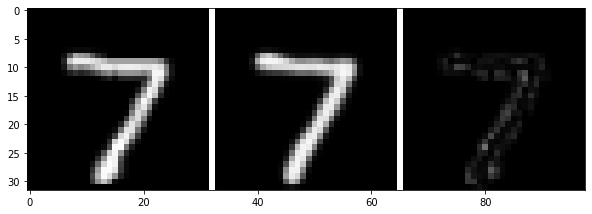

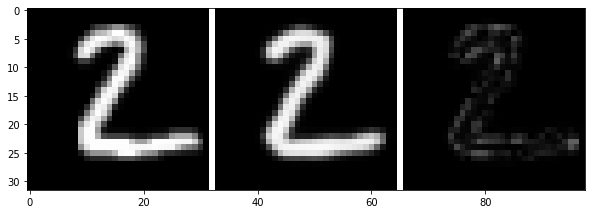

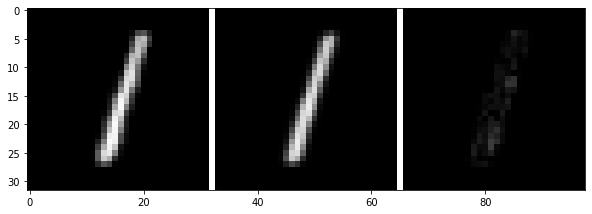

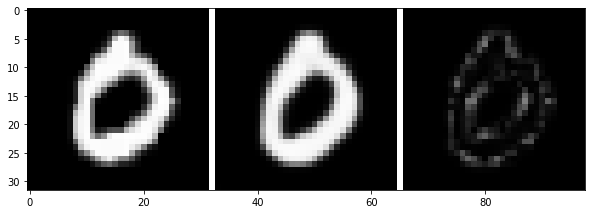

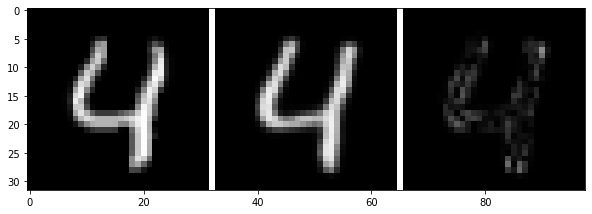

04/06/2020 12:06:38, epoch=96, step=11340, loss=0.08335, distortion=0.117, rate=0.026, -elbo=406.94681, nll=332.03268, KL=74.91413, commit_loss=9296.58398, bit_usage=0.98598, highest_prob=0.008, temp=0.24027
04/06/2020 12:06:38, epoch=96, step=11360, loss=0.08010, distortion=0.112, rate=0.026, -elbo=393.41885, nll=318.60516, KL=74.81369, commit_loss=9410.14062, bit_usage=0.98664, highest_prob=0.009, temp=0.23952
04/06/2020 12:06:39, epoch=96, step=11380, loss=0.08244, distortion=0.116, rate=0.026, -elbo=403.05798, nll=328.25519, KL=74.80281, commit_loss=9352.62695, bit_usage=0.98621, highest_prob=0.008, temp=0.23877
04/06/2020 12:06:40, epoch=96, step=11400, loss=0.08304, distortion=0.116, rate=0.026, -elbo=405.65900, nll=330.64017, KL=75.01884, commit_loss=9404.97266, bit_usage=0.98637, highest_prob=0.009, temp=0.23801
04/06/2020 12:06:40, epoch=96, step=11420, loss=0.08272, distortion=0.116, rate=0.026, -elbo=404.18231, nll=329.34793, KL=74.83440, commit_loss=9401.14453, bit_usage=0.

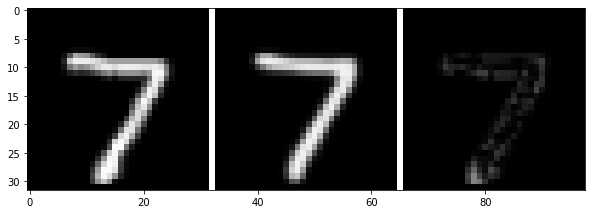

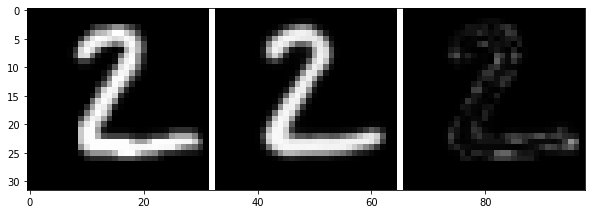

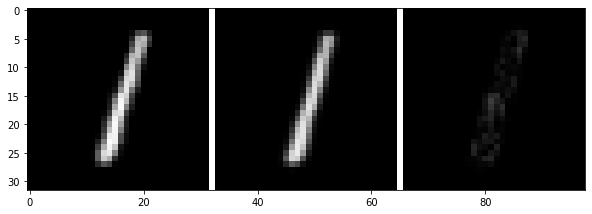

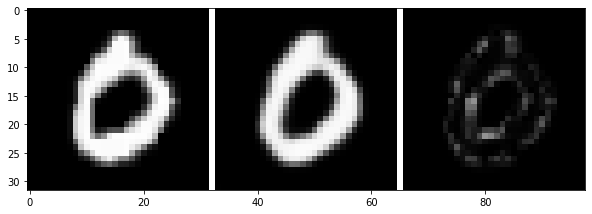

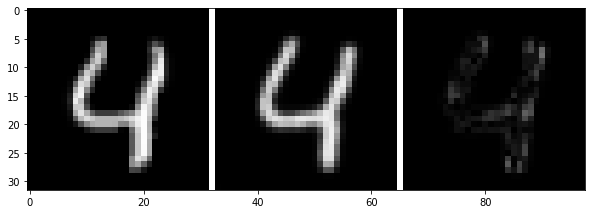

04/06/2020 12:07:01, epoch=101, step=11920, loss=0.08098, distortion=0.113, rate=0.027, -elbo=397.41797, nll=322.03311, KL=75.38485, commit_loss=9592.89844, bit_usage=0.98628, highest_prob=0.007, temp=0.21845
04/06/2020 12:07:01, epoch=101, step=11940, loss=0.08313, distortion=0.117, rate=0.027, -elbo=406.36469, nll=330.78186, KL=75.58283, commit_loss=9630.50586, bit_usage=0.98439, highest_prob=0.010, temp=0.21769
04/06/2020 12:07:02, epoch=101, step=11960, loss=0.07892, distortion=0.110, rate=0.027, -elbo=388.89365, nll=313.49597, KL=75.39768, commit_loss=9683.93848, bit_usage=0.98691, highest_prob=0.008, temp=0.21694
04/06/2020 12:07:03, epoch=101, step=11980, loss=0.07802, distortion=0.109, rate=0.027, -elbo=385.08575, nll=309.83646, KL=75.24928, commit_loss=9646.95508, bit_usage=0.98589, highest_prob=0.010, temp=0.21619
04/06/2020 12:07:04, epoch=101, step=12000, loss=0.08087, distortion=0.113, rate=0.026, -elbo=396.63336, nll=321.40057, KL=75.23279, commit_loss=9781.34766, bit_usa

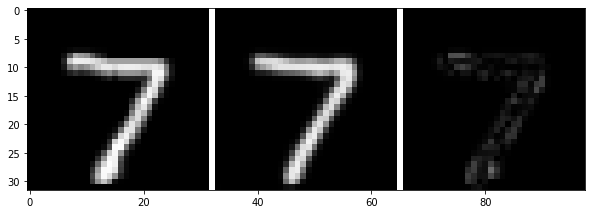

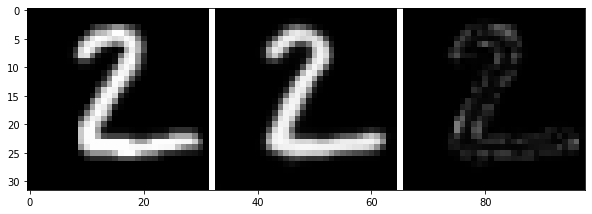

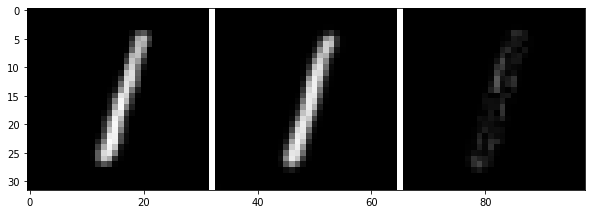

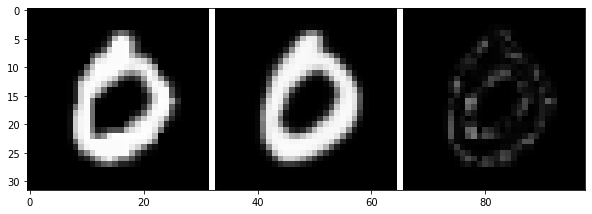

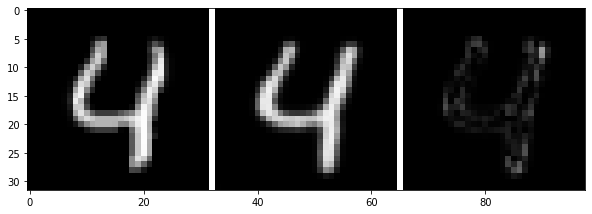

04/06/2020 12:07:24, epoch=106, step=12520, loss=0.08192, distortion=0.115, rate=0.027, -elbo=401.34210, nll=325.76038, KL=75.58173, commit_loss=9706.63672, bit_usage=0.98620, highest_prob=0.008, temp=0.19587
04/06/2020 12:07:25, epoch=106, step=12540, loss=0.08206, distortion=0.115, rate=0.027, -elbo=401.99060, nll=326.30588, KL=75.68474, commit_loss=9731.28320, bit_usage=0.98571, highest_prob=0.009, temp=0.19512
reset code 72
04/06/2020 12:07:26, epoch=106, step=12560, loss=0.08335, distortion=0.117, rate=0.027, -elbo=407.07819, nll=331.45013, KL=75.62807, commit_loss=9861.02051, bit_usage=0.98624, highest_prob=0.008, temp=0.19437
reset code 220
04/06/2020 12:07:27, epoch=106, step=12580, loss=0.08104, distortion=0.113, rate=0.027, -elbo=397.65161, nll=322.11481, KL=75.53681, commit_loss=9764.05859, bit_usage=0.98641, highest_prob=0.009, temp=0.19361
04/06/2020 12:07:27, epoch=106, step=12600, loss=0.07880, distortion=0.110, rate=0.026, -elbo=388.40878, nll=313.29724, KL=75.11155, co

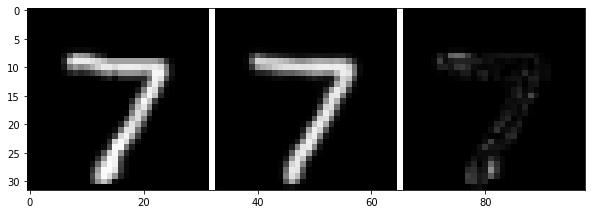

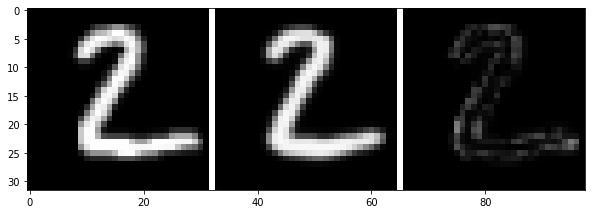

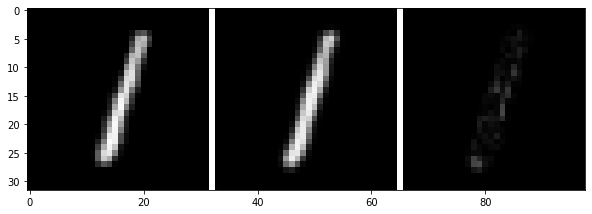

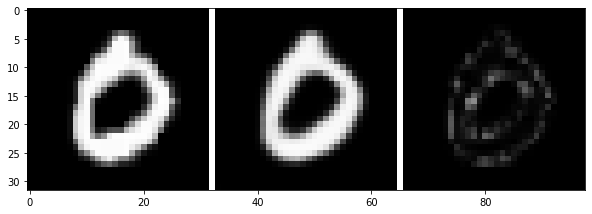

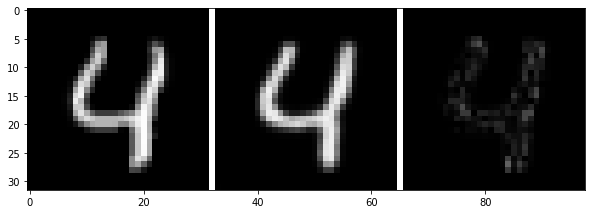

04/06/2020 12:07:47, epoch=111, step=13100, loss=0.08023, distortion=0.112, rate=0.027, -elbo=394.37244, nll=318.73999, KL=75.63243, commit_loss=9812.30469, bit_usage=0.98850, highest_prob=0.008, temp=0.17405
04/06/2020 12:07:47, epoch=111, step=13120, loss=0.07879, distortion=0.110, rate=0.027, -elbo=388.71503, nll=313.00446, KL=75.71059, commit_loss=9650.85938, bit_usage=0.98820, highest_prob=0.009, temp=0.17329
04/06/2020 12:07:48, epoch=111, step=13140, loss=0.08376, distortion=0.117, rate=0.027, -elbo=408.91882, nll=333.04822, KL=75.87059, commit_loss=9975.33203, bit_usage=0.98819, highest_prob=0.009, temp=0.17254
reset code 145
04/06/2020 12:07:49, epoch=111, step=13160, loss=0.07868, distortion=0.110, rate=0.027, -elbo=388.14255, nll=312.41199, KL=75.73057, commit_loss=9804.82422, bit_usage=0.98735, highest_prob=0.008, temp=0.17179
04/06/2020 12:07:49, epoch=111, step=13180, loss=0.08155, distortion=0.114, rate=0.027, -elbo=400.20459, nll=324.19366, KL=76.01093, commit_loss=9779

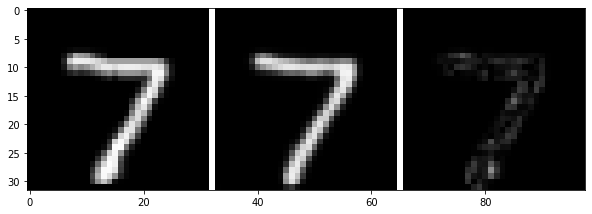

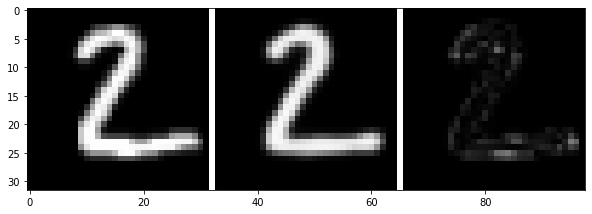

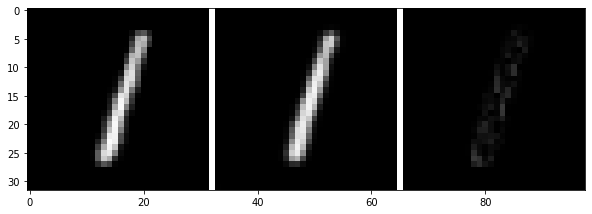

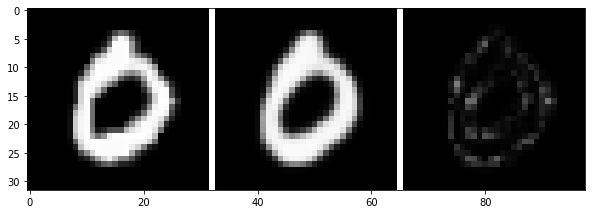

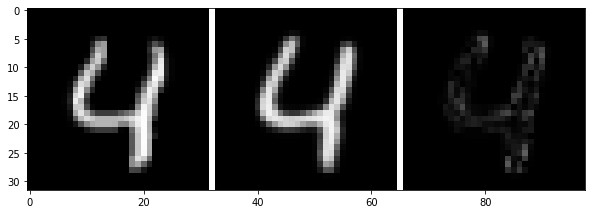

04/06/2020 12:08:10, epoch=116, step=13700, loss=0.07807, distortion=0.109, rate=0.027, -elbo=385.84570, nll=309.84619, KL=75.99952, commit_loss=9834.71094, bit_usage=0.98838, highest_prob=0.007, temp=0.15147
04/06/2020 12:08:12, epoch=116, step=13720, loss=0.07937, distortion=0.111, rate=0.027, -elbo=391.06732, nll=315.08264, KL=75.98470, commit_loss=9947.94922, bit_usage=0.98766, highest_prob=0.009, temp=0.15072
04/06/2020 12:08:13, epoch=116, step=13740, loss=0.07907, distortion=0.111, rate=0.027, -elbo=389.66476, nll=313.77484, KL=75.88993, commit_loss=10014.26172, bit_usage=0.98746, highest_prob=0.008, temp=0.14997
04/06/2020 12:08:14, epoch=116, step=13760, loss=0.08287, distortion=0.116, rate=0.027, -elbo=405.50330, nll=329.34827, KL=76.15501, commit_loss=10028.26270, bit_usage=0.98777, highest_prob=0.008, temp=0.14921
04/06/2020 12:08:15, epoch=116, step=13780, loss=0.08073, distortion=0.113, rate=0.027, -elbo=396.48264, nll=320.63992, KL=75.84270, commit_loss=9948.98047, bit_u

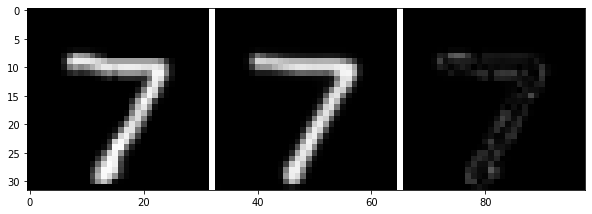

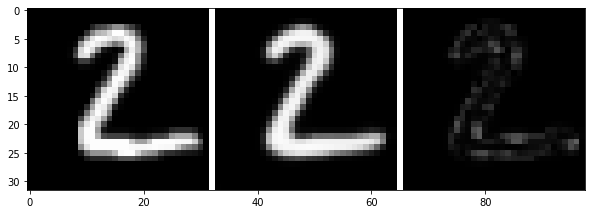

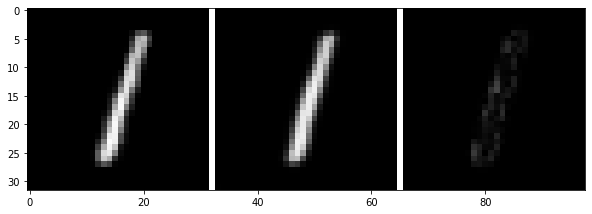

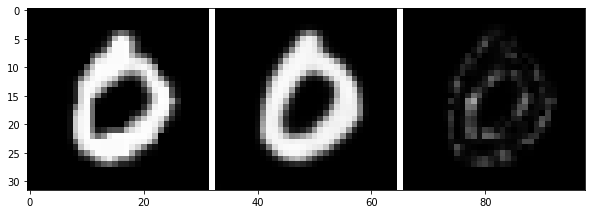

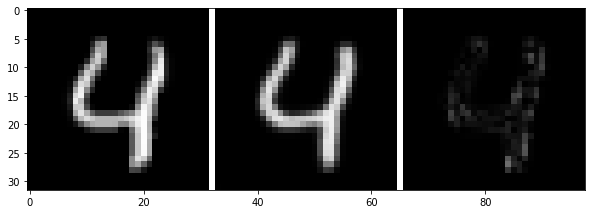

04/06/2020 12:08:35, epoch=121, step=14280, loss=0.08086, distortion=0.113, rate=0.027, -elbo=397.31366, nll=321.05103, KL=76.26263, commit_loss=10091.42188, bit_usage=0.98658, highest_prob=0.009, temp=0.12965
04/06/2020 12:08:35, epoch=121, step=14300, loss=0.07564, distortion=0.106, rate=0.027, -elbo=375.98505, nll=299.67291, KL=76.31215, commit_loss=10071.89160, bit_usage=0.98940, highest_prob=0.008, temp=0.12889
04/06/2020 12:08:36, epoch=121, step=14320, loss=0.08136, distortion=0.114, rate=0.027, -elbo=399.20715, nll=323.13135, KL=76.07579, commit_loss=10059.64648, bit_usage=0.98744, highest_prob=0.008, temp=0.12814
04/06/2020 12:08:37, epoch=121, step=14340, loss=0.07852, distortion=0.110, rate=0.027, -elbo=387.63895, nll=311.27734, KL=76.36161, commit_loss=10244.54395, bit_usage=0.98802, highest_prob=0.008, temp=0.12739
04/06/2020 12:08:38, epoch=121, step=14360, loss=0.07816, distortion=0.109, rate=0.027, -elbo=386.10254, nll=309.94934, KL=76.15321, commit_loss=10124.75781, bi

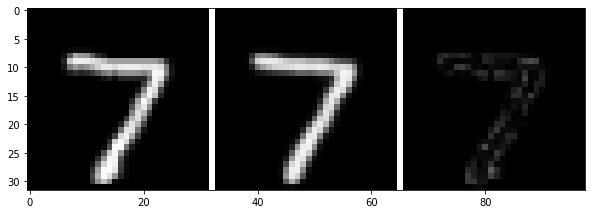

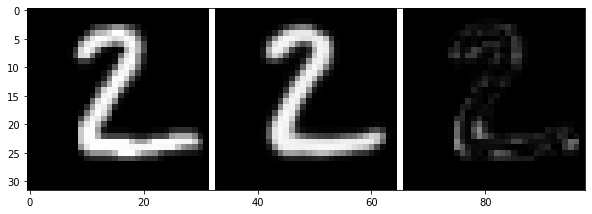

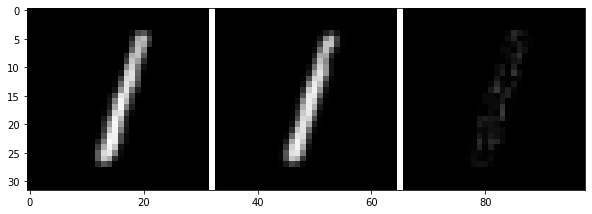

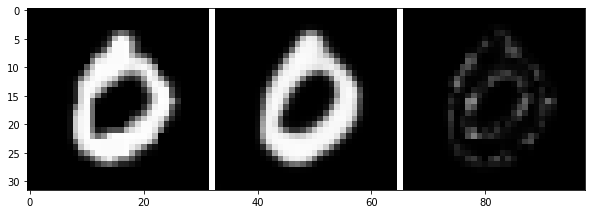

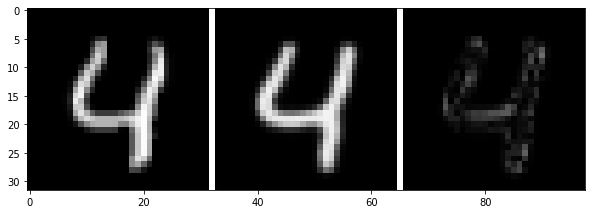

04/06/2020 12:08:59, epoch=126, step=14880, loss=0.07679, distortion=0.107, rate=0.027, -elbo=380.53424, nll=304.30927, KL=76.22496, commit_loss=10155.23438, bit_usage=0.98806, highest_prob=0.008, temp=0.10707
04/06/2020 12:08:59, epoch=126, step=14900, loss=0.07575, distortion=0.106, rate=0.027, -elbo=376.32394, nll=300.19940, KL=76.12454, commit_loss=9977.24609, bit_usage=0.98806, highest_prob=0.009, temp=0.10632
04/06/2020 12:09:00, epoch=126, step=14920, loss=0.07932, distortion=0.111, rate=0.027, -elbo=391.14874, nll=314.60004, KL=76.54872, commit_loss=10210.70508, bit_usage=0.98836, highest_prob=0.008, temp=0.10557
04/06/2020 12:09:01, epoch=126, step=14940, loss=0.07729, distortion=0.108, rate=0.027, -elbo=382.55310, nll=306.19861, KL=76.35451, commit_loss=10292.43066, bit_usage=0.98807, highest_prob=0.007, temp=0.10481
04/06/2020 12:09:01, epoch=126, step=14960, loss=0.07626, distortion=0.106, rate=0.027, -elbo=378.53271, nll=302.26013, KL=76.27257, commit_loss=10042.52441, bit

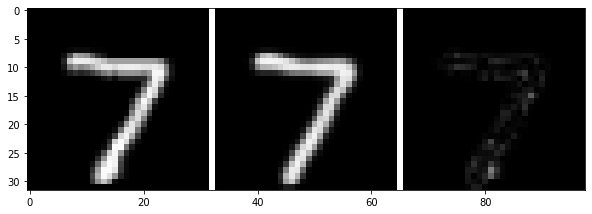

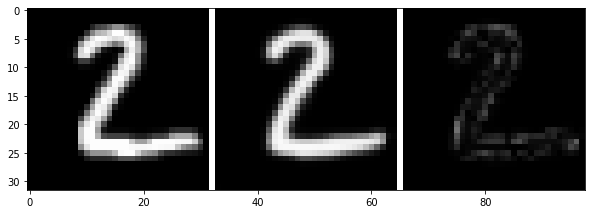

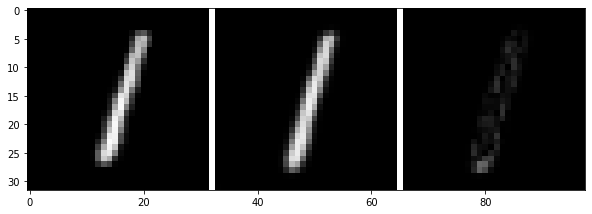

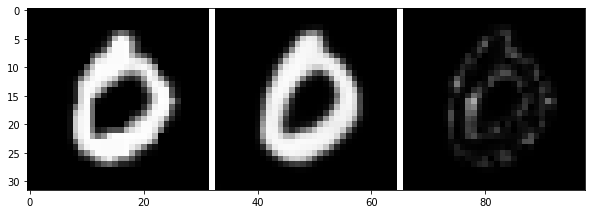

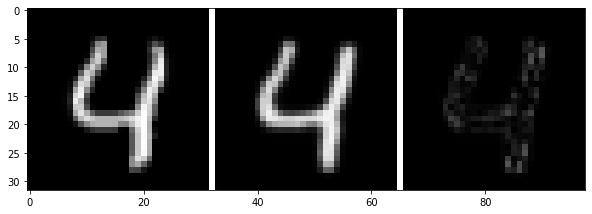

04/06/2020 12:09:20, epoch=131, step=15460, loss=0.08064, distortion=0.113, rate=0.027, -elbo=396.53061, nll=319.90753, KL=76.62308, commit_loss=10300.49121, bit_usage=0.98904, highest_prob=0.007, temp=0.08525
04/06/2020 12:09:21, epoch=131, step=15480, loss=0.07867, distortion=0.110, rate=0.027, -elbo=388.31940, nll=311.96503, KL=76.35435, commit_loss=10205.81445, bit_usage=0.98906, highest_prob=0.007, temp=0.08449
04/06/2020 12:09:22, epoch=131, step=15500, loss=0.07683, distortion=0.107, rate=0.027, -elbo=380.67792, nll=304.29346, KL=76.38445, commit_loss=10318.56445, bit_usage=0.98935, highest_prob=0.007, temp=0.08374
04/06/2020 12:09:22, epoch=131, step=15520, loss=0.07694, distortion=0.107, rate=0.027, -elbo=381.22638, nll=304.67889, KL=76.54747, commit_loss=10399.63477, bit_usage=0.98935, highest_prob=0.007, temp=0.08299
04/06/2020 12:09:23, epoch=131, step=15540, loss=0.07963, distortion=0.111, rate=0.027, -elbo=392.28098, nll=315.95093, KL=76.33004, commit_loss=10156.57129, bi

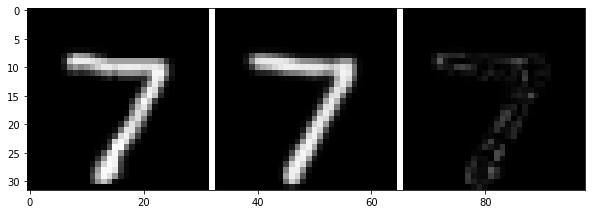

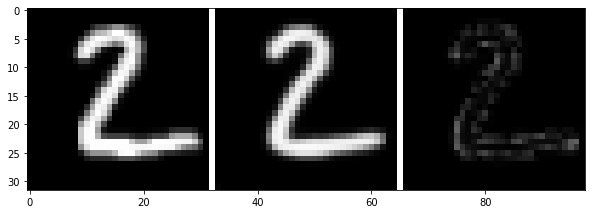

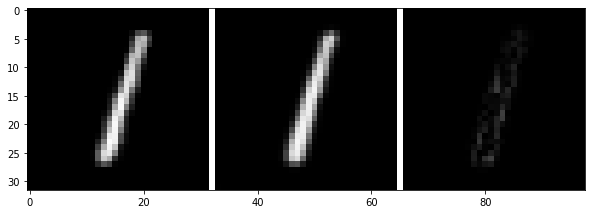

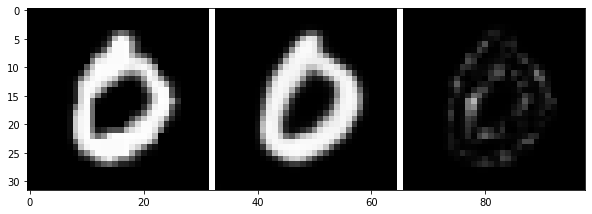

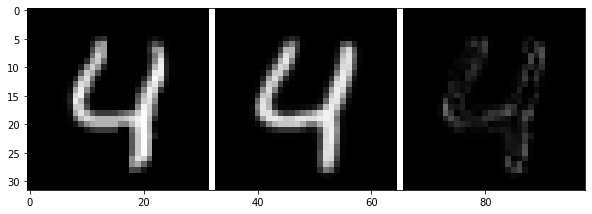

04/06/2020 12:09:43, epoch=136, step=16060, loss=0.07808, distortion=0.109, rate=0.027, -elbo=386.05173, nll=309.52478, KL=76.52695, commit_loss=10219.80859, bit_usage=0.98951, highest_prob=0.007, temp=0.06267
04/06/2020 12:09:44, epoch=136, step=16080, loss=0.07654, distortion=0.107, rate=0.027, -elbo=379.59958, nll=303.09503, KL=76.50455, commit_loss=10350.89551, bit_usage=0.98916, highest_prob=0.008, temp=0.06192
04/06/2020 12:09:44, epoch=136, step=16100, loss=0.07681, distortion=0.107, rate=0.027, -elbo=380.76642, nll=304.00595, KL=76.76048, commit_loss=10541.34766, bit_usage=0.98954, highest_prob=0.008, temp=0.06117
04/06/2020 12:09:45, epoch=136, step=16120, loss=0.07802, distortion=0.109, rate=0.027, -elbo=385.55878, nll=309.04407, KL=76.51469, commit_loss=10450.66016, bit_usage=0.99044, highest_prob=0.007, temp=0.06041
04/06/2020 12:09:46, epoch=136, step=16140, loss=0.07897, distortion=0.110, rate=0.027, -elbo=389.45856, nll=313.01105, KL=76.44749, commit_loss=10386.13867, bi

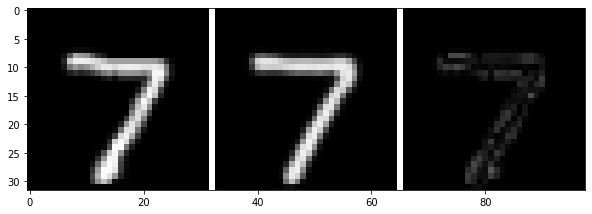

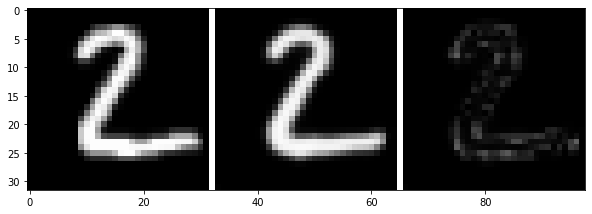

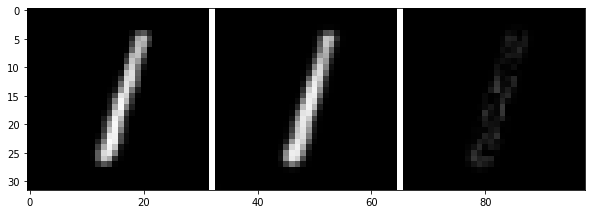

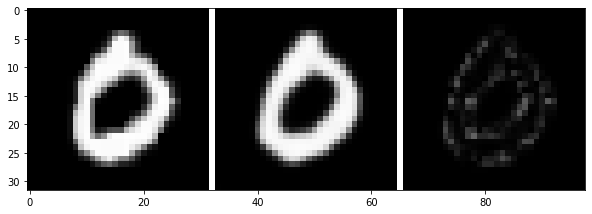

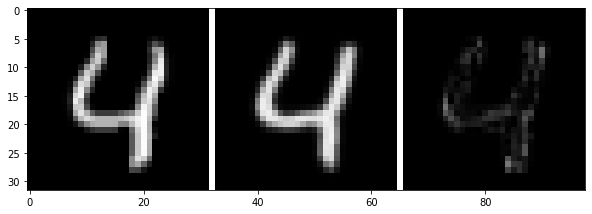

04/06/2020 12:10:06, epoch=141, step=16640, loss=0.07520, distortion=0.105, rate=0.027, -elbo=373.90237, nll=297.47430, KL=76.42807, commit_loss=10484.79102, bit_usage=0.98920, highest_prob=0.007, temp=0.04085
04/06/2020 12:10:07, epoch=141, step=16660, loss=0.07368, distortion=0.103, rate=0.027, -elbo=367.79526, nll=291.33707, KL=76.45819, commit_loss=10388.67090, bit_usage=0.99018, highest_prob=0.007, temp=0.04009
04/06/2020 12:10:08, epoch=141, step=16680, loss=0.07847, distortion=0.109, rate=0.027, -elbo=387.41226, nll=310.77600, KL=76.63627, commit_loss=10543.83887, bit_usage=0.98975, highest_prob=0.007, temp=0.03934
04/06/2020 12:10:08, epoch=141, step=16700, loss=0.07561, distortion=0.105, rate=0.027, -elbo=375.64478, nll=299.10809, KL=76.53668, commit_loss=10515.14551, bit_usage=0.98970, highest_prob=0.008, temp=0.03859
04/06/2020 12:10:09, epoch=141, step=16720, loss=0.07808, distortion=0.109, rate=0.027, -elbo=385.72415, nll=308.98654, KL=76.73761, commit_loss=10759.03516, bi

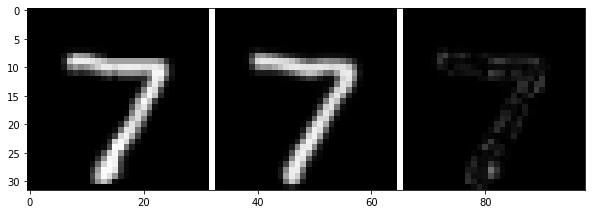

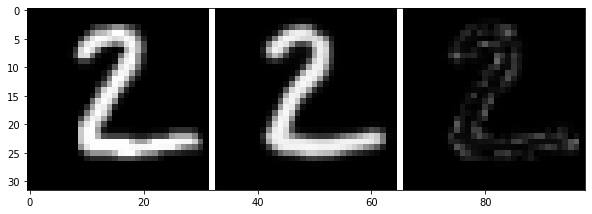

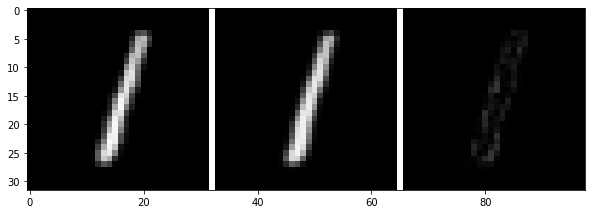

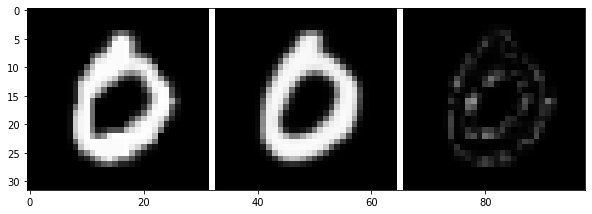

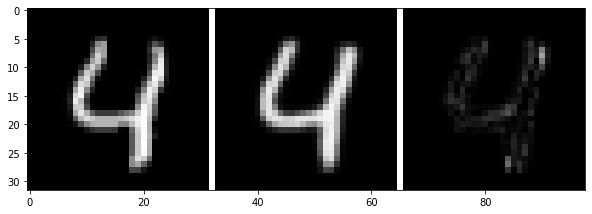

04/06/2020 12:10:29, epoch=146, step=17240, loss=0.07712, distortion=0.107, rate=0.027, -elbo=381.86191, nll=305.20007, KL=76.66183, commit_loss=10599.59668, bit_usage=0.98899, highest_prob=0.009, temp=0.01827
04/06/2020 12:10:30, epoch=146, step=17260, loss=0.07568, distortion=0.105, rate=0.027, -elbo=375.71899, nll=299.26270, KL=76.45630, commit_loss=10629.99219, bit_usage=0.98778, highest_prob=0.009, temp=0.01752
04/06/2020 12:10:30, epoch=146, step=17280, loss=0.07841, distortion=0.109, rate=0.027, -elbo=387.09296, nll=310.53192, KL=76.56104, commit_loss=10539.62109, bit_usage=0.98973, highest_prob=0.008, temp=0.01677
04/06/2020 12:10:31, epoch=146, step=17300, loss=0.07513, distortion=0.105, rate=0.027, -elbo=373.50717, nll=297.18759, KL=76.31958, commit_loss=10469.21191, bit_usage=0.98987, highest_prob=0.008, temp=0.01601
04/06/2020 12:10:32, epoch=146, step=17320, loss=0.08165, distortion=0.114, rate=0.027, -elbo=400.30692, nll=323.48218, KL=76.82474, commit_loss=10899.84766, bi

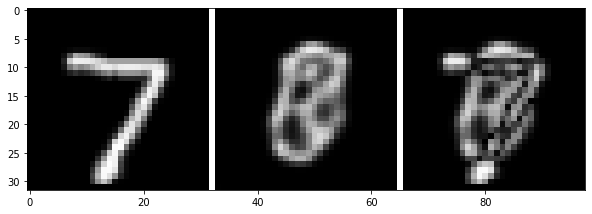

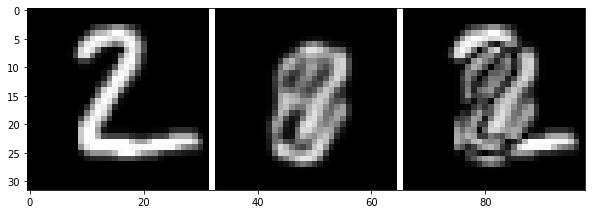

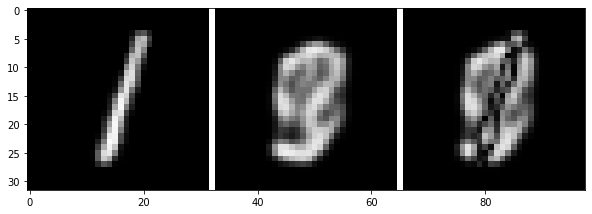

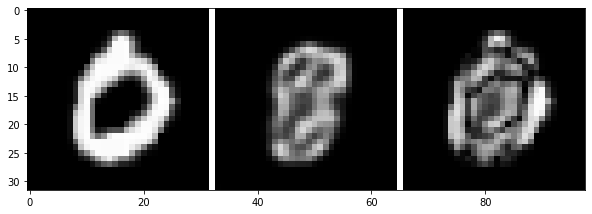

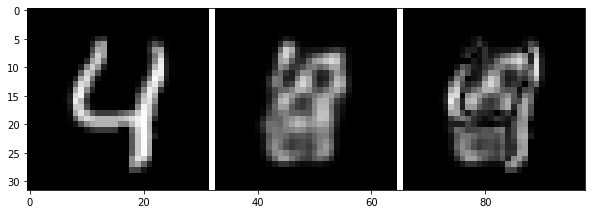

04/06/2020 12:10:50, epoch=1, step=120, loss=0.77157, distortion=1.113, rate=0.021, -elbo=804.79340, nll=789.93488, KL=14.85851, commit_loss=135.21910, bit_usage=0.37374, highest_prob=0.163, temp=0.66245
reset code 96
04/06/2020 12:10:51, epoch=1, step=140, loss=0.71361, distortion=1.029, rate=0.023, -elbo=746.74054, nll=730.58759, KL=16.15295, commit_loss=133.59402, bit_usage=0.36623, highest_prob=0.324, temp=0.66169
reset code 112
04/06/2020 12:10:51, epoch=1, step=160, loss=0.64563, distortion=0.931, rate=0.022, -elbo=676.81805, nll=660.98090, KL=15.83717, commit_loss=132.44765, bit_usage=0.38722, highest_prob=0.226, temp=0.66094
reset code 128
04/06/2020 12:10:52, epoch=1, step=180, loss=0.59200, distortion=0.854, rate=0.021, -elbo=621.22687, nll=606.05481, KL=15.17207, commit_loss=134.29602, bit_usage=0.41901, highest_prob=0.175, temp=0.66019
reset code 144
04/06/2020 12:10:53, epoch=1, step=200, loss=0.54740, distortion=0.790, rate=0.021, -elbo=575.00842, nll=560.38348, KL=14.624

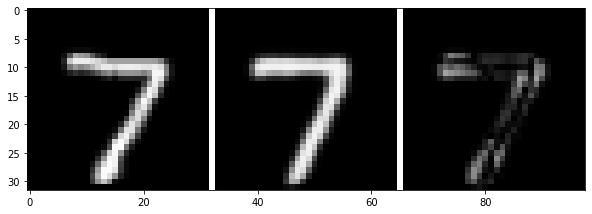

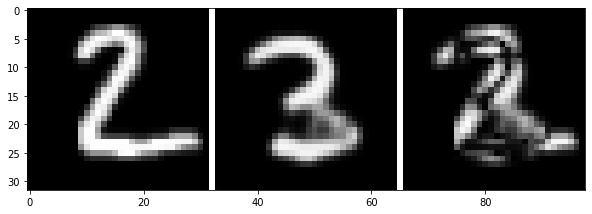

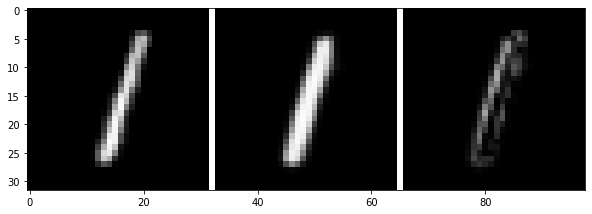

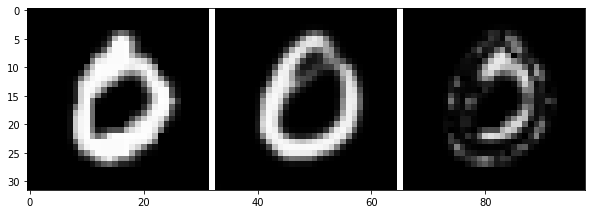

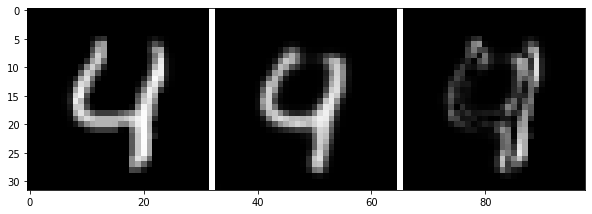

04/06/2020 12:11:10, epoch=6, step=720, loss=0.28506, distortion=0.411, rate=0.019, -elbo=304.88538, nll=291.75092, KL=13.13447, commit_loss=135.33871, bit_usage=0.67218, highest_prob=0.037, temp=0.63987
reset code 100
04/06/2020 12:11:10, epoch=6, step=740, loss=0.28225, distortion=0.407, rate=0.018, -elbo=301.99786, nll=288.88049, KL=13.11737, commit_loss=135.23227, bit_usage=0.67532, highest_prob=0.039, temp=0.63912
reset code 116
04/06/2020 12:11:11, epoch=6, step=760, loss=0.27972, distortion=0.403, rate=0.018, -elbo=299.33121, nll=286.28922, KL=13.04201, commit_loss=135.01797, bit_usage=0.68070, highest_prob=0.039, temp=0.63837
reset code 132
04/06/2020 12:11:12, epoch=6, step=780, loss=0.29135, distortion=0.420, rate=0.018, -elbo=311.19266, nll=298.19714, KL=12.99551, commit_loss=135.18942, bit_usage=0.68339, highest_prob=0.035, temp=0.63761
reset code 148
04/06/2020 12:11:12, epoch=6, step=800, loss=0.28349, distortion=0.409, rate=0.018, -elbo=303.16962, nll=290.14825, KL=13.02

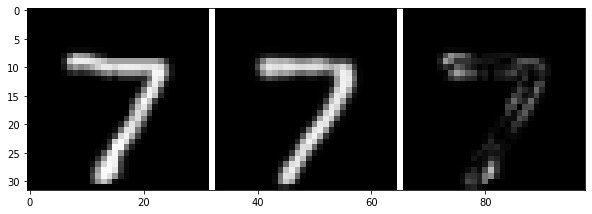

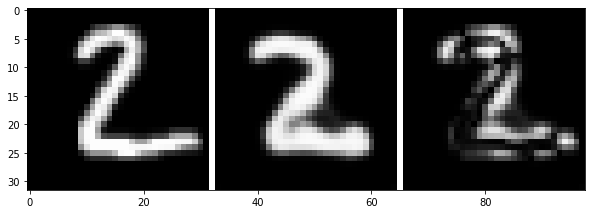

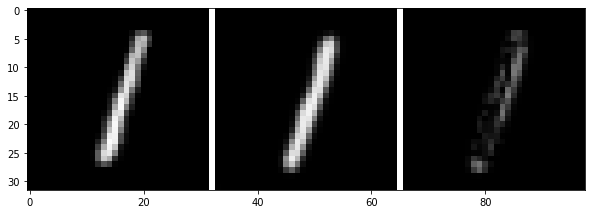

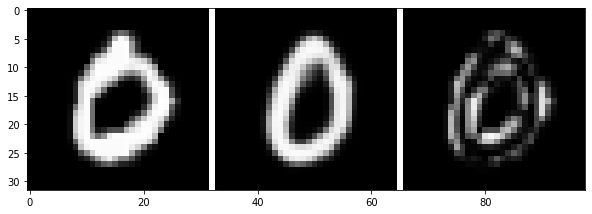

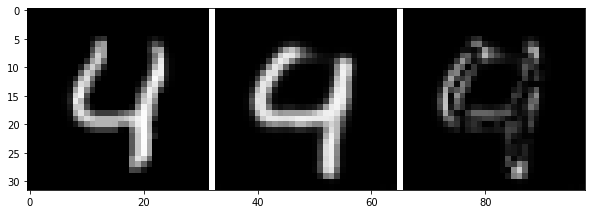

04/06/2020 12:11:30, epoch=11, step=1300, loss=0.21596, distortion=0.311, rate=0.020, -elbo=235.07735, nll=220.98715, KL=14.09019, commit_loss=141.55051, bit_usage=0.70745, highest_prob=0.057, temp=0.61805
reset code 82
04/06/2020 12:11:30, epoch=11, step=1320, loss=0.22198, distortion=0.320, rate=0.020, -elbo=241.43365, nll=227.15271, KL=14.28094, commit_loss=141.70813, bit_usage=0.70859, highest_prob=0.064, temp=0.61729
reset code 98
04/06/2020 12:11:31, epoch=11, step=1340, loss=0.21984, distortion=0.317, rate=0.020, -elbo=239.44484, nll=224.95403, KL=14.49081, commit_loss=143.82465, bit_usage=0.70943, highest_prob=0.063, temp=0.61654
reset code 114
04/06/2020 12:11:31, epoch=11, step=1360, loss=0.21281, distortion=0.307, rate=0.021, -elbo=232.35431, nll=217.75693, KL=14.59739, commit_loss=146.48965, bit_usage=0.71086, highest_prob=0.055, temp=0.61579
reset code 130
04/06/2020 12:11:32, epoch=11, step=1380, loss=0.21260, distortion=0.306, rate=0.021, -elbo=232.26126, nll=217.53937, 

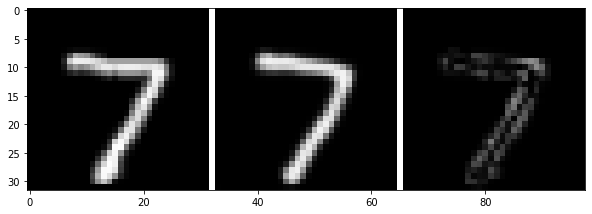

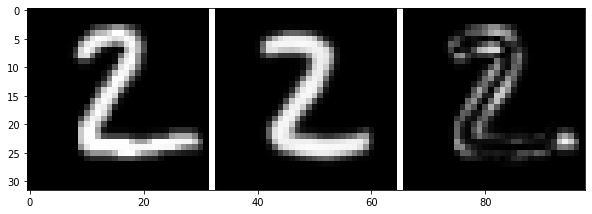

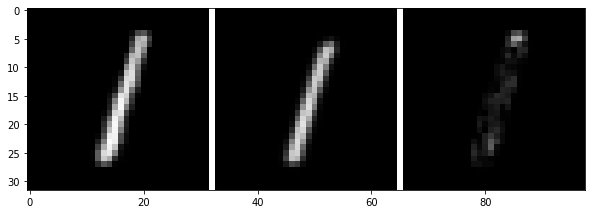

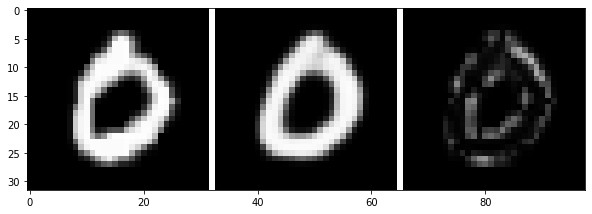

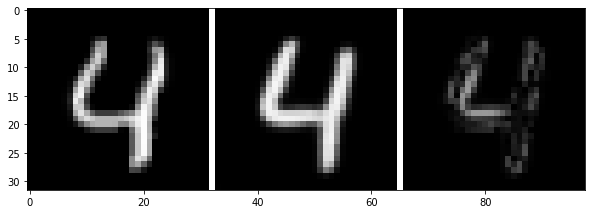

04/06/2020 12:11:49, epoch=16, step=1900, loss=0.17748, distortion=0.256, rate=0.022, -elbo=196.93132, nll=181.50665, KL=15.42466, commit_loss=213.58670, bit_usage=0.77623, highest_prob=0.033, temp=0.59547
reset code 54
04/06/2020 12:11:49, epoch=16, step=1920, loss=0.16392, distortion=0.236, rate=0.021, -elbo=182.87953, nll=167.62041, KL=15.25913, commit_loss=213.79204, bit_usage=0.78117, highest_prob=0.028, temp=0.59472
reset code 70
04/06/2020 12:11:50, epoch=16, step=1940, loss=0.17943, distortion=0.259, rate=0.022, -elbo=198.85611, nll=183.50607, KL=15.35004, commit_loss=214.72742, bit_usage=0.78372, highest_prob=0.032, temp=0.59397
reset code 86
04/06/2020 12:11:50, epoch=16, step=1960, loss=0.17087, distortion=0.246, rate=0.022, -elbo=190.10959, nll=174.74084, KL=15.36875, commit_loss=215.56133, bit_usage=0.78105, highest_prob=0.034, temp=0.59321
reset code 102
04/06/2020 12:11:51, epoch=16, step=1980, loss=0.17710, distortion=0.255, rate=0.022, -elbo=196.51340, nll=181.11743, K

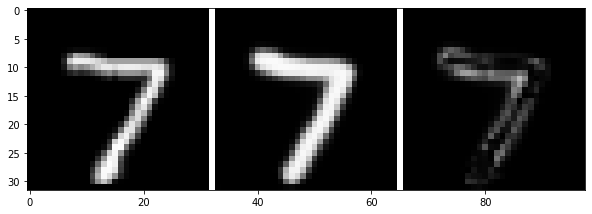

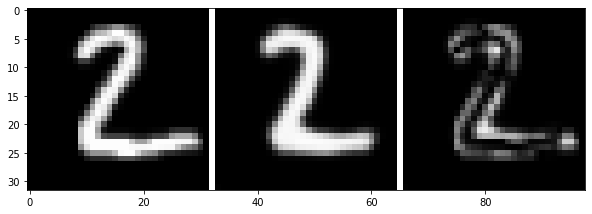

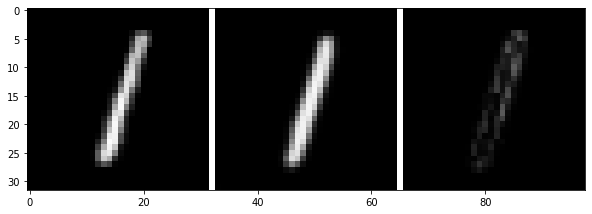

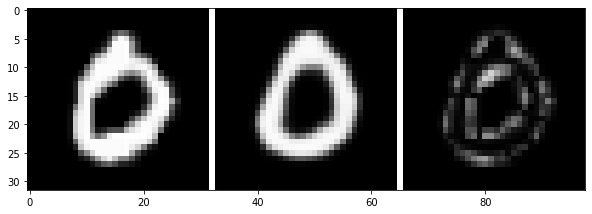

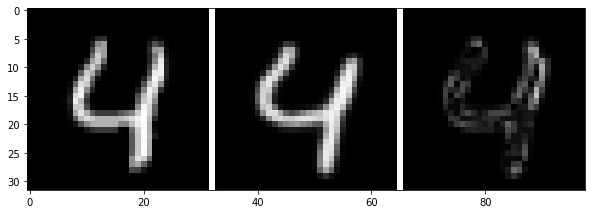

04/06/2020 12:12:09, epoch=21, step=2480, loss=0.14913, distortion=0.215, rate=0.022, -elbo=168.28882, nll=152.37836, KL=15.91047, commit_loss=313.24713, bit_usage=0.82254, highest_prob=0.023, temp=0.57365
reset code 254
04/06/2020 12:12:10, epoch=21, step=2500, loss=0.15339, distortion=0.221, rate=0.023, -elbo=172.76329, nll=156.73991, KL=16.02337, commit_loss=312.93655, bit_usage=0.82503, highest_prob=0.021, temp=0.57289
reset code 1
04/06/2020 12:12:11, epoch=21, step=2520, loss=0.14892, distortion=0.214, rate=0.023, -elbo=168.16351, nll=152.15956, KL=16.00395, commit_loss=316.57117, bit_usage=0.82352, highest_prob=0.024, temp=0.57214
reset code 17
04/06/2020 12:12:11, epoch=21, step=2540, loss=0.13915, distortion=0.200, rate=0.023, -elbo=158.17850, nll=142.14789, KL=16.03061, commit_loss=321.81708, bit_usage=0.82405, highest_prob=0.024, temp=0.57139
reset code 33
04/06/2020 12:12:12, epoch=21, step=2560, loss=0.14705, distortion=0.212, rate=0.023, -elbo=166.36540, nll=150.24149, KL

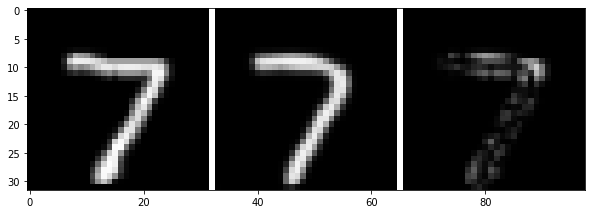

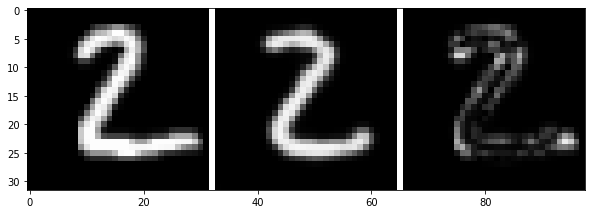

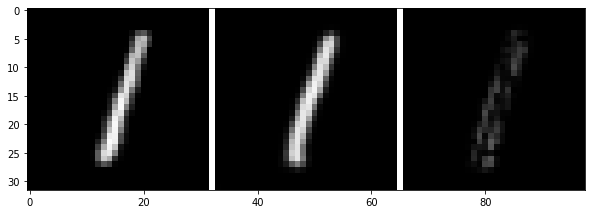

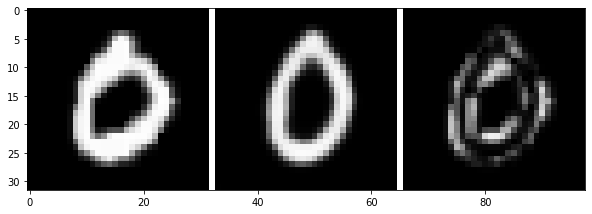

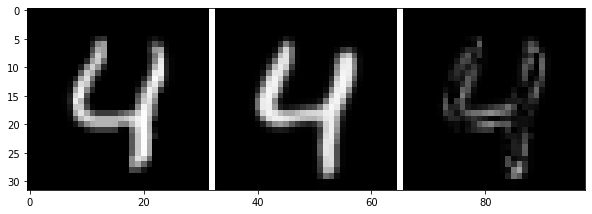

04/06/2020 12:12:33, epoch=26, step=3080, loss=0.13124, distortion=0.189, rate=0.023, -elbo=150.56734, nll=133.95117, KL=16.61617, commit_loss=419.76178, bit_usage=0.85548, highest_prob=0.019, temp=0.55107
reset code 201
04/06/2020 12:12:34, epoch=26, step=3100, loss=0.13249, distortion=0.191, rate=0.024, -elbo=151.93951, nll=135.23376, KL=16.70576, commit_loss=423.61734, bit_usage=0.85180, highest_prob=0.021, temp=0.55032
reset code 217
04/06/2020 12:12:35, epoch=26, step=3120, loss=0.13293, distortion=0.191, rate=0.023, -elbo=152.26324, nll=135.67610, KL=16.58714, commit_loss=422.90015, bit_usage=0.85530, highest_prob=0.020, temp=0.54957
reset code 233
04/06/2020 12:12:35, epoch=26, step=3140, loss=0.12657, distortion=0.182, rate=0.023, -elbo=145.72487, nll=129.16583, KL=16.55904, commit_loss=429.86053, bit_usage=0.86035, highest_prob=0.018, temp=0.54881
reset code 249
04/06/2020 12:12:36, epoch=26, step=3160, loss=0.13404, distortion=0.193, rate=0.023, -elbo=153.45792, nll=136.81648

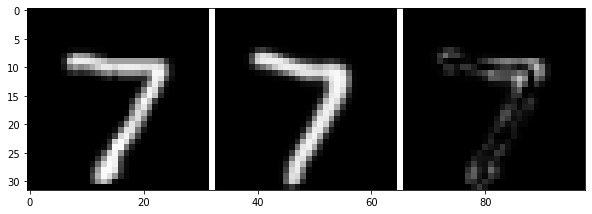

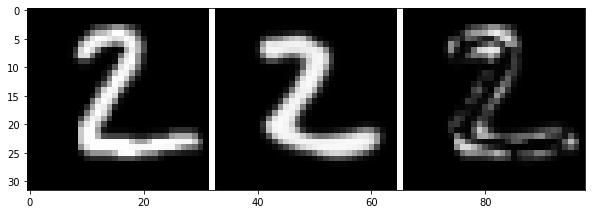

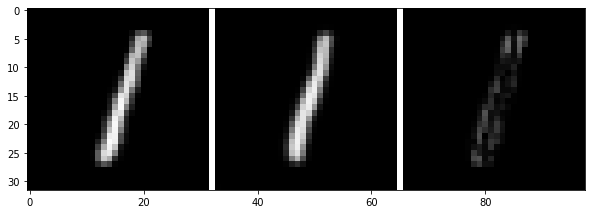

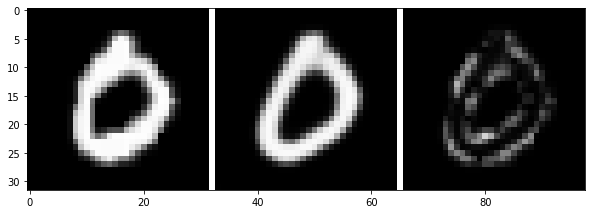

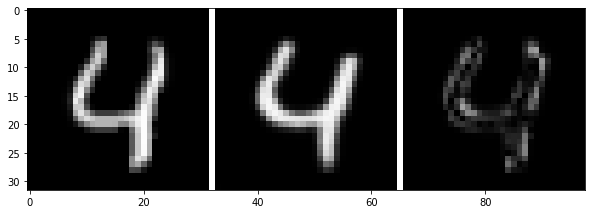

04/06/2020 12:12:52, epoch=31, step=3660, loss=0.12206, distortion=0.175, rate=0.024, -elbo=141.36295, nll=124.42419, KL=16.93875, commit_loss=547.14203, bit_usage=0.88547, highest_prob=0.017, temp=0.52925
reset code 205
04/06/2020 12:12:52, epoch=31, step=3680, loss=0.12579, distortion=0.181, rate=0.024, -elbo=145.24934, nll=128.24612, KL=17.00322, commit_loss=550.27332, bit_usage=0.88623, highest_prob=0.016, temp=0.52849
reset code 45
04/06/2020 12:12:53, epoch=31, step=3700, loss=0.11909, distortion=0.171, rate=0.024, -elbo=138.41052, nll=121.37615, KL=17.03437, commit_loss=557.37402, bit_usage=0.88654, highest_prob=0.016, temp=0.52774
reset code 249
04/06/2020 12:12:53, epoch=31, step=3720, loss=0.11698, distortion=0.168, rate=0.024, -elbo=136.07965, nll=119.20616, KL=16.87349, commit_loss=568.39209, bit_usage=0.88938, highest_prob=0.016, temp=0.52699
reset code 221
04/06/2020 12:12:54, epoch=31, step=3740, loss=0.11545, distortion=0.166, rate=0.024, -elbo=134.65678, nll=117.62999,

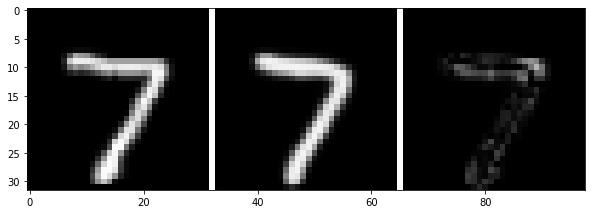

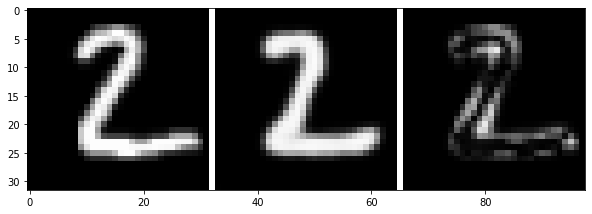

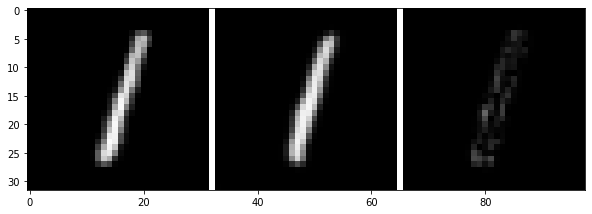

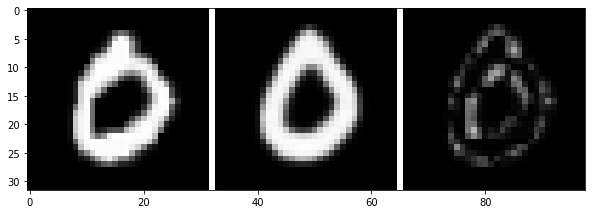

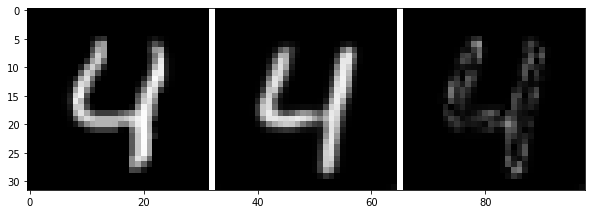

04/06/2020 12:13:12, epoch=36, step=4260, loss=0.11627, distortion=0.167, rate=0.024, -elbo=135.50075, nll=118.30579, KL=17.19496, commit_loss=732.65265, bit_usage=0.90864, highest_prob=0.015, temp=0.50667
reset code 200
04/06/2020 12:13:13, epoch=36, step=4280, loss=0.10925, distortion=0.157, rate=0.024, -elbo=128.12456, nll=111.12074, KL=17.00381, commit_loss=735.11945, bit_usage=0.91368, highest_prob=0.017, temp=0.50592
reset code 27
04/06/2020 12:13:14, epoch=36, step=4300, loss=0.11031, distortion=0.158, rate=0.024, -elbo=129.21997, nll=112.19876, KL=17.02121, commit_loss=737.79504, bit_usage=0.91589, highest_prob=0.016, temp=0.50517
reset code 43
04/06/2020 12:13:14, epoch=36, step=4320, loss=0.11831, distortion=0.170, rate=0.024, -elbo=137.62405, nll=120.38739, KL=17.23666, commit_loss=743.23529, bit_usage=0.91556, highest_prob=0.015, temp=0.50441
reset code 59
04/06/2020 12:13:15, epoch=36, step=4340, loss=0.11039, distortion=0.158, rate=0.024, -elbo=129.35770, nll=112.26968, K

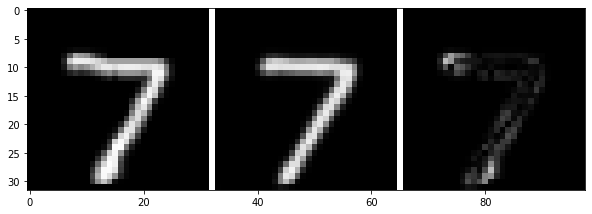

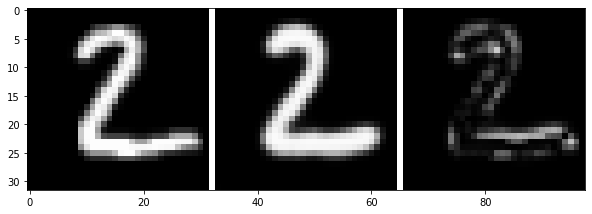

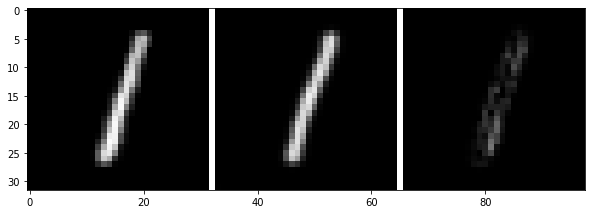

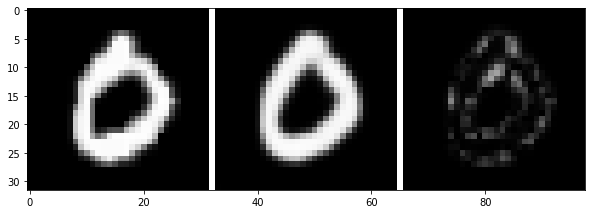

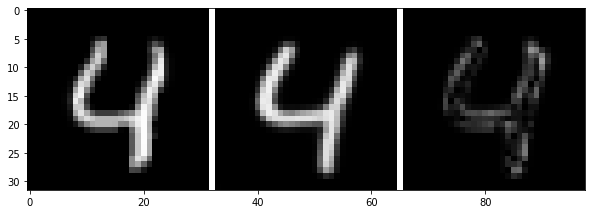

04/06/2020 12:13:33, epoch=41, step=4840, loss=0.10691, distortion=0.153, rate=0.024, -elbo=125.82066, nll=108.55032, KL=17.27034, commit_loss=903.64600, bit_usage=0.93747, highest_prob=0.013, temp=0.48485
reset code 199
04/06/2020 12:13:33, epoch=41, step=4860, loss=0.10712, distortion=0.153, rate=0.024, -elbo=126.02825, nll=108.78526, KL=17.24300, commit_loss=892.74542, bit_usage=0.93268, highest_prob=0.012, temp=0.48409
reset code 72
04/06/2020 12:13:34, epoch=41, step=4880, loss=0.10997, distortion=0.157, rate=0.024, -elbo=128.89523, nll=111.66864, KL=17.22660, commit_loss=924.52039, bit_usage=0.93221, highest_prob=0.016, temp=0.48334
reset code 215
04/06/2020 12:13:34, epoch=41, step=4900, loss=0.10951, distortion=0.157, rate=0.024, -elbo=128.50092, nll=111.19675, KL=17.30417, commit_loss=920.58264, bit_usage=0.93907, highest_prob=0.012, temp=0.48259
reset code 231
04/06/2020 12:13:35, epoch=41, step=4920, loss=0.10401, distortion=0.149, rate=0.024, -elbo=122.81602, nll=105.55974,

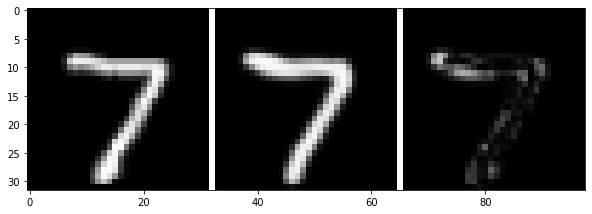

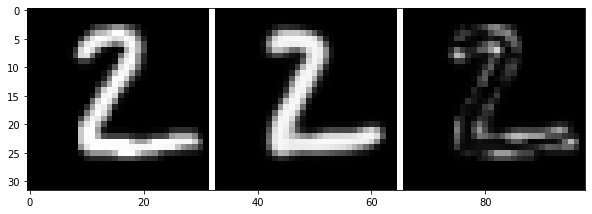

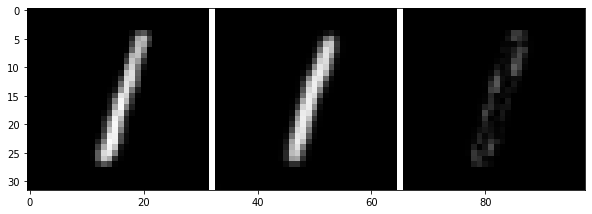

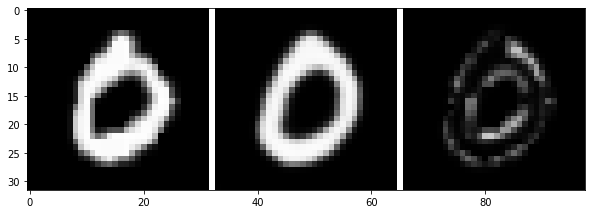

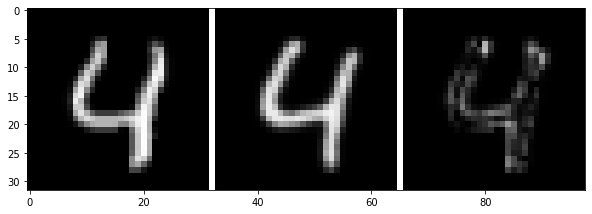

04/06/2020 12:13:52, epoch=46, step=5440, loss=0.09550, distortion=0.136, rate=0.025, -elbo=114.15387, nll=96.68385, KL=17.47003, commit_loss=1088.15393, bit_usage=0.94737, highest_prob=0.013, temp=0.46227
reset code 8
04/06/2020 12:13:53, epoch=46, step=5460, loss=0.10140, distortion=0.145, rate=0.025, -elbo=120.20528, nll=102.73213, KL=17.47315, commit_loss=1087.76624, bit_usage=0.94618, highest_prob=0.013, temp=0.46152
reset code 27
04/06/2020 12:13:53, epoch=46, step=5480, loss=0.10403, distortion=0.149, rate=0.025, -elbo=122.94028, nll=105.41528, KL=17.52499, commit_loss=1096.52563, bit_usage=0.95214, highest_prob=0.013, temp=0.46077
reset code 103
04/06/2020 12:13:54, epoch=46, step=5500, loss=0.10260, distortion=0.146, rate=0.025, -elbo=121.46851, nll=103.94742, KL=17.52109, commit_loss=1094.87646, bit_usage=0.94985, highest_prob=0.016, temp=0.46001
reset code 207
04/06/2020 12:13:54, epoch=46, step=5520, loss=0.10979, distortion=0.157, rate=0.025, -elbo=128.86528, nll=111.30177

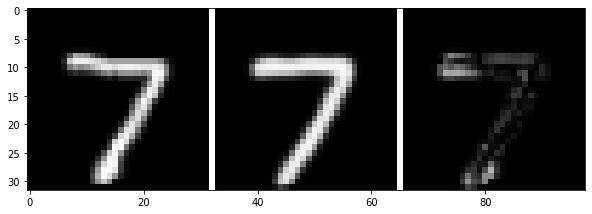

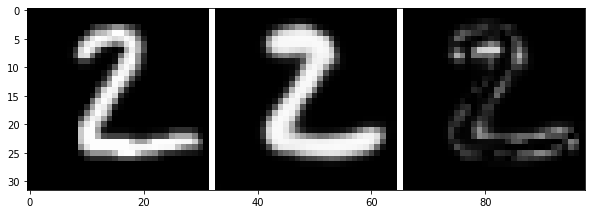

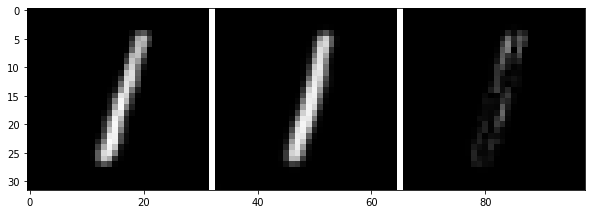

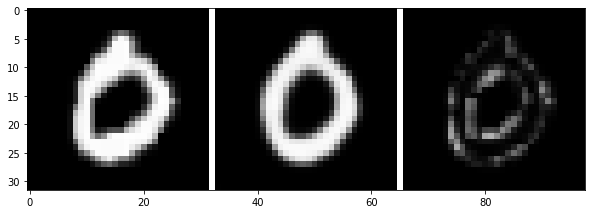

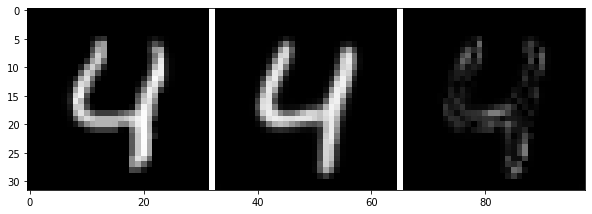

04/06/2020 12:14:11, epoch=51, step=6020, loss=0.10219, distortion=0.146, rate=0.025, -elbo=121.00518, nll=103.42030, KL=17.58488, commit_loss=1202.85242, bit_usage=0.96035, highest_prob=0.011, temp=0.44045
reset code 84
04/06/2020 12:14:11, epoch=51, step=6040, loss=0.09986, distortion=0.142, rate=0.025, -elbo=118.60369, nll=101.00025, KL=17.60344, commit_loss=1234.67212, bit_usage=0.96148, highest_prob=0.010, temp=0.43969
reset code 104
04/06/2020 12:14:12, epoch=51, step=6060, loss=0.10014, distortion=0.143, rate=0.025, -elbo=118.79543, nll=101.30791, KL=17.48751, commit_loss=1218.83350, bit_usage=0.96432, highest_prob=0.012, temp=0.43894
reset code 194
04/06/2020 12:14:12, epoch=51, step=6080, loss=0.09498, distortion=0.135, rate=0.025, -elbo=113.54297, nll=96.01433, KL=17.52864, commit_loss=1229.66382, bit_usage=0.96098, highest_prob=0.013, temp=0.43819
reset code 51
04/06/2020 12:14:13, epoch=51, step=6100, loss=0.09608, distortion=0.137, rate=0.025, -elbo=114.67970, nll=97.12923

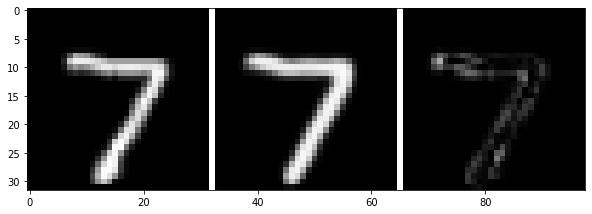

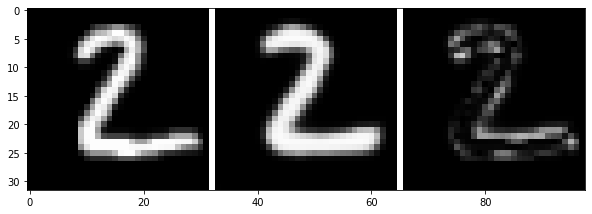

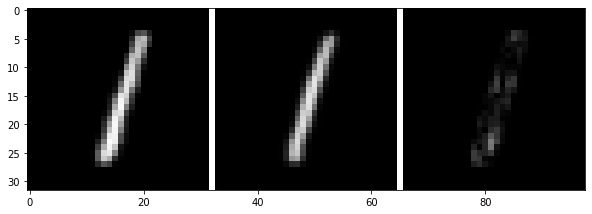

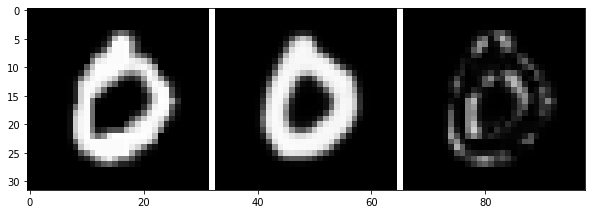

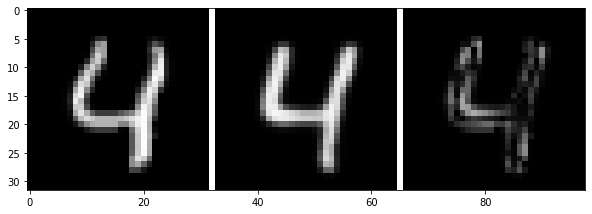

04/06/2020 12:14:30, epoch=56, step=6620, loss=0.09570, distortion=0.136, rate=0.025, -elbo=114.41154, nll=96.64887, KL=17.76266, commit_loss=1326.78491, bit_usage=0.96598, highest_prob=0.012, temp=0.41787
04/06/2020 12:14:31, epoch=56, step=6640, loss=0.09619, distortion=0.137, rate=0.025, -elbo=114.82857, nll=97.12367, KL=17.70489, commit_loss=1358.91333, bit_usage=0.96558, highest_prob=0.011, temp=0.41712
04/06/2020 12:14:32, epoch=56, step=6660, loss=0.09691, distortion=0.138, rate=0.025, -elbo=115.75032, nll=97.88418, KL=17.86615, commit_loss=1338.60071, bit_usage=0.96594, highest_prob=0.011, temp=0.41637
reset code 188
04/06/2020 12:14:32, epoch=56, step=6680, loss=0.09378, distortion=0.133, rate=0.025, -elbo=112.41570, nll=94.64908, KL=17.76662, commit_loss=1360.76880, bit_usage=0.96729, highest_prob=0.010, temp=0.41561
04/06/2020 12:14:35, epoch=56, step=6700, loss=0.09770, distortion=0.139, rate=0.025, -elbo=116.40535, nll=98.67313, KL=17.73222, commit_loss=1355.69482, bit_usa

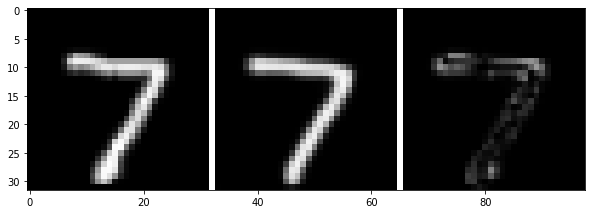

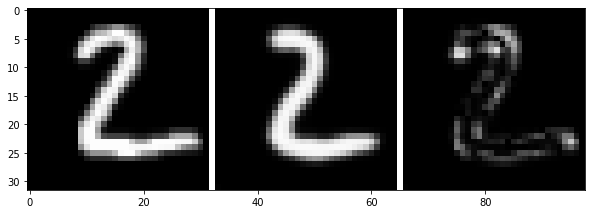

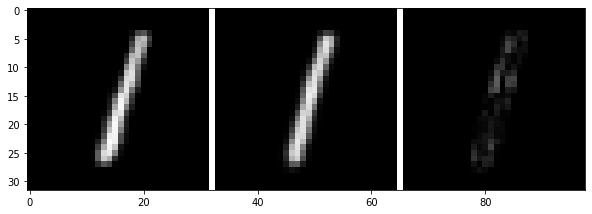

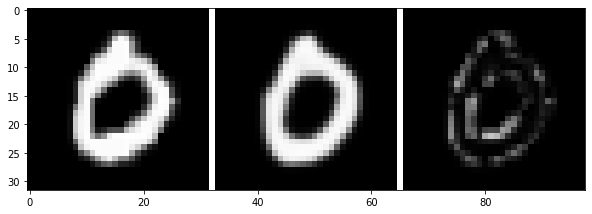

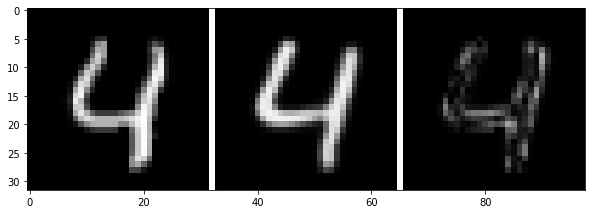

04/06/2020 12:14:54, epoch=61, step=7200, loss=0.09573, distortion=0.136, rate=0.025, -elbo=114.54175, nll=96.59175, KL=17.95000, commit_loss=1420.10486, bit_usage=0.97182, highest_prob=0.011, temp=0.39605
04/06/2020 12:14:55, epoch=61, step=7220, loss=0.09816, distortion=0.140, rate=0.025, -elbo=117.18219, nll=99.08891, KL=18.09328, commit_loss=1407.98035, bit_usage=0.96936, highest_prob=0.010, temp=0.39529
reset code 100
04/06/2020 12:14:55, epoch=61, step=7240, loss=0.09592, distortion=0.136, rate=0.025, -elbo=114.78875, nll=96.77571, KL=18.01304, commit_loss=1428.81873, bit_usage=0.96819, highest_prob=0.012, temp=0.39454
reset code 131
04/06/2020 12:14:56, epoch=61, step=7260, loss=0.09843, distortion=0.140, rate=0.025, -elbo=117.34722, nll=99.36157, KL=17.98565, commit_loss=1416.74121, bit_usage=0.96459, highest_prob=0.011, temp=0.39379
04/06/2020 12:14:56, epoch=61, step=7280, loss=0.09411, distortion=0.134, rate=0.025, -elbo=112.89734, nll=94.92813, KL=17.96921, commit_loss=1422

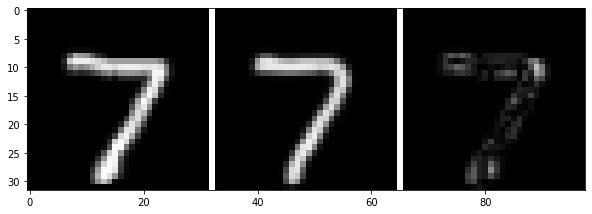

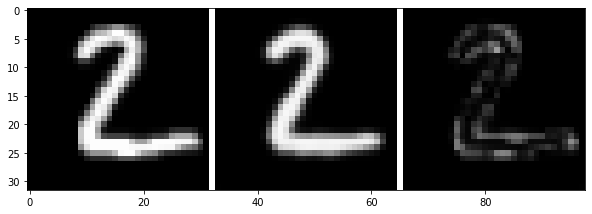

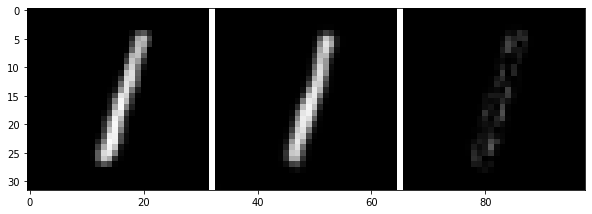

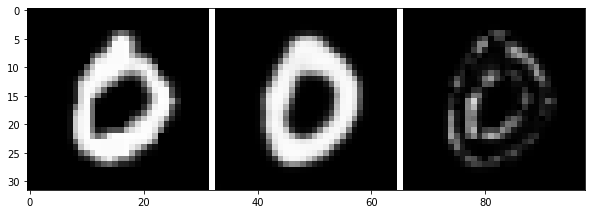

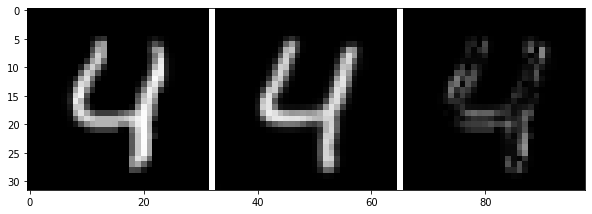

04/06/2020 12:15:14, epoch=66, step=7800, loss=0.09154, distortion=0.130, rate=0.026, -elbo=110.47046, nll=92.21147, KL=18.25899, commit_loss=1505.74744, bit_usage=0.96830, highest_prob=0.010, temp=0.37347
04/06/2020 12:15:14, epoch=66, step=7820, loss=0.08930, distortion=0.127, rate=0.026, -elbo=108.19078, nll=89.91621, KL=18.27457, commit_loss=1507.25183, bit_usage=0.96706, highest_prob=0.013, temp=0.37272
04/06/2020 12:15:15, epoch=66, step=7840, loss=0.09352, distortion=0.133, rate=0.026, -elbo=112.45732, nll=94.24501, KL=18.21231, commit_loss=1505.34106, bit_usage=0.96760, highest_prob=0.013, temp=0.37197
reset code 23
04/06/2020 12:15:16, epoch=66, step=7860, loss=0.09813, distortion=0.139, rate=0.026, -elbo=117.21060, nll=98.95020, KL=18.26041, commit_loss=1513.62939, bit_usage=0.97078, highest_prob=0.012, temp=0.37121
04/06/2020 12:15:16, epoch=66, step=7880, loss=0.08976, distortion=0.127, rate=0.026, -elbo=108.59842, nll=90.38158, KL=18.21685, commit_loss=1511.42847, bit_usag

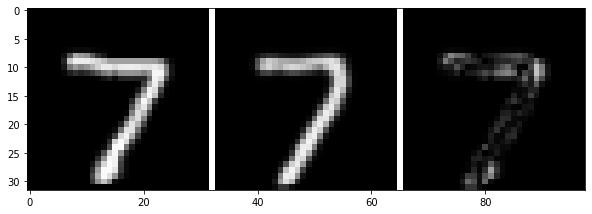

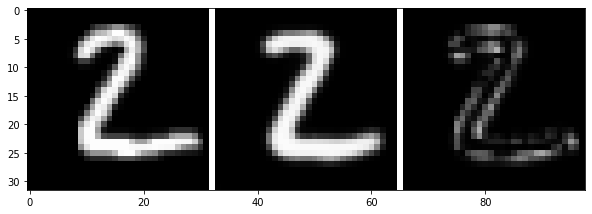

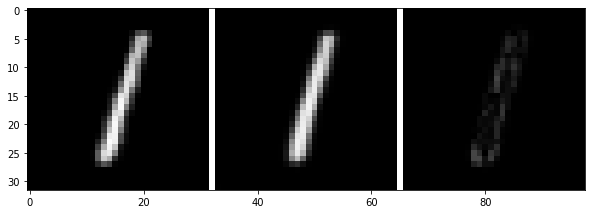

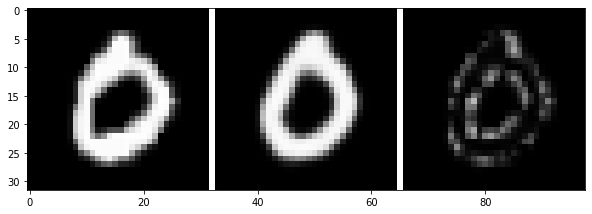

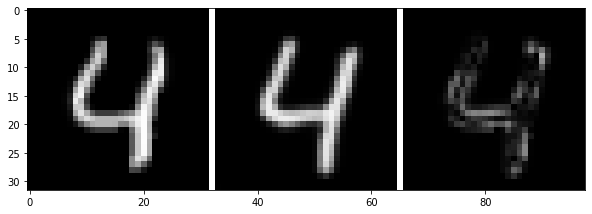

04/06/2020 12:15:34, epoch=71, step=8380, loss=0.08831, distortion=0.125, rate=0.026, -elbo=107.17796, nll=88.82507, KL=18.35289, commit_loss=1591.03101, bit_usage=0.97241, highest_prob=0.009, temp=0.35165
reset code 231
04/06/2020 12:15:34, epoch=71, step=8400, loss=0.09028, distortion=0.128, rate=0.026, -elbo=109.19645, nll=90.83502, KL=18.36143, commit_loss=1588.31604, bit_usage=0.97296, highest_prob=0.011, temp=0.35089
reset code 72
04/06/2020 12:15:35, epoch=71, step=8420, loss=0.09333, distortion=0.132, rate=0.026, -elbo=112.46986, nll=93.94288, KL=18.52698, commit_loss=1613.21960, bit_usage=0.97240, highest_prob=0.009, temp=0.35014
04/06/2020 12:15:35, epoch=71, step=8440, loss=0.08742, distortion=0.124, rate=0.026, -elbo=106.42561, nll=87.91498, KL=18.51063, commit_loss=1584.94922, bit_usage=0.96858, highest_prob=0.011, temp=0.34939
04/06/2020 12:15:36, epoch=71, step=8460, loss=0.09296, distortion=0.132, rate=0.026, -elbo=112.00729, nll=93.55888, KL=18.44841, commit_loss=1610.

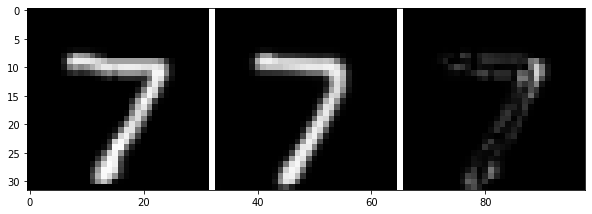

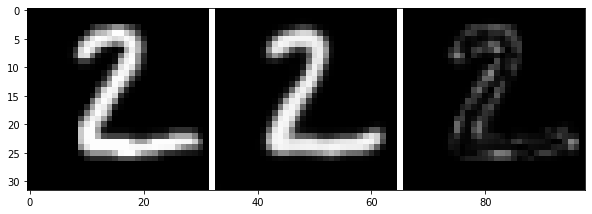

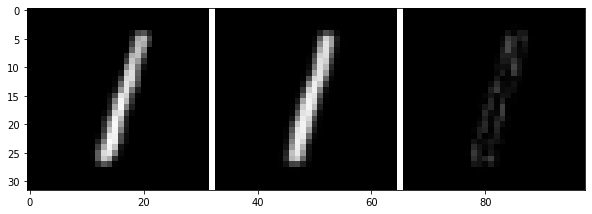

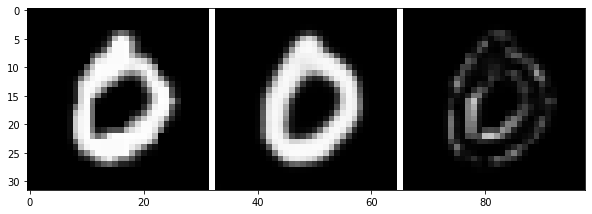

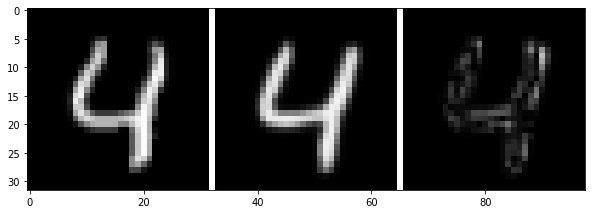

04/06/2020 12:15:53, epoch=76, step=8980, loss=0.09240, distortion=0.131, rate=0.026, -elbo=111.67538, nll=92.96153, KL=18.71385, commit_loss=1634.16150, bit_usage=0.96929, highest_prob=0.011, temp=0.32907
reset code 182
04/06/2020 12:15:53, epoch=76, step=9000, loss=0.09035, distortion=0.128, rate=0.026, -elbo=109.48735, nll=90.86404, KL=18.62331, commit_loss=1637.25281, bit_usage=0.97300, highest_prob=0.010, temp=0.32832
reset code 28
04/06/2020 12:15:54, epoch=76, step=9020, loss=0.09017, distortion=0.128, rate=0.026, -elbo=109.43911, nll=90.67274, KL=18.76637, commit_loss=1639.03687, bit_usage=0.97304, highest_prob=0.012, temp=0.32757
reset code 89
04/06/2020 12:15:55, epoch=76, step=9040, loss=0.09015, distortion=0.128, rate=0.026, -elbo=109.31122, nll=90.66024, KL=18.65097, commit_loss=1630.32373, bit_usage=0.96836, highest_prob=0.010, temp=0.32681
04/06/2020 12:15:55, epoch=76, step=9060, loss=0.09310, distortion=0.132, rate=0.026, -elbo=112.37634, nll=93.66484, KL=18.71150, com

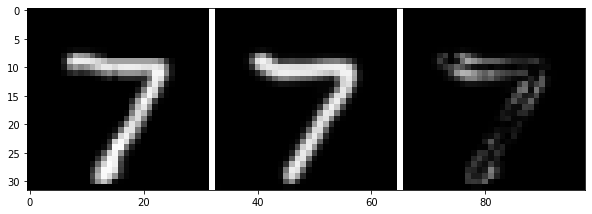

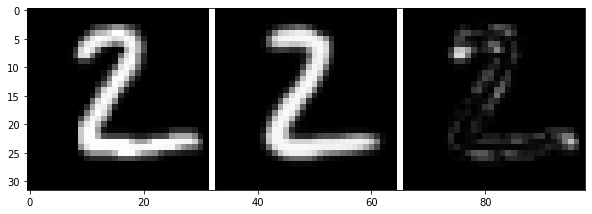

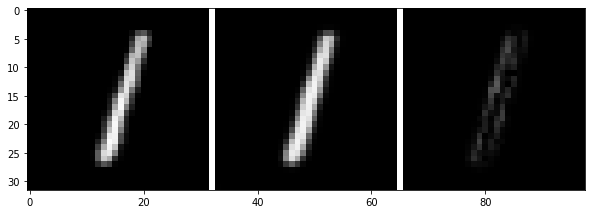

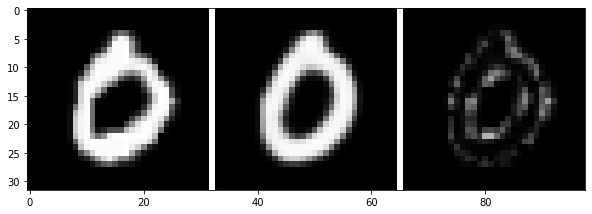

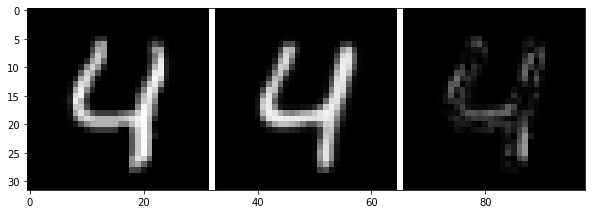

04/06/2020 12:16:11, epoch=81, step=9560, loss=0.08883, distortion=0.126, rate=0.026, -elbo=107.99976, nll=89.24474, KL=18.75502, commit_loss=1702.12646, bit_usage=0.97793, highest_prob=0.009, temp=0.30725
04/06/2020 12:16:12, epoch=81, step=9580, loss=0.09145, distortion=0.130, rate=0.027, -elbo=110.77838, nll=91.91802, KL=18.86036, commit_loss=1703.23120, bit_usage=0.97369, highest_prob=0.010, temp=0.30649
04/06/2020 12:16:12, epoch=81, step=9600, loss=0.08654, distortion=0.122, rate=0.027, -elbo=105.70970, nll=86.89262, KL=18.81708, commit_loss=1710.15295, bit_usage=0.97703, highest_prob=0.011, temp=0.30574
reset code 152
04/06/2020 12:16:13, epoch=81, step=9620, loss=0.09132, distortion=0.129, rate=0.027, -elbo=110.64939, nll=91.81306, KL=18.83633, commit_loss=1676.24072, bit_usage=0.97601, highest_prob=0.009, temp=0.30499
reset code 160
04/06/2020 12:16:14, epoch=81, step=9640, loss=0.08908, distortion=0.126, rate=0.026, -elbo=108.27110, nll=89.49476, KL=18.77635, commit_loss=1706

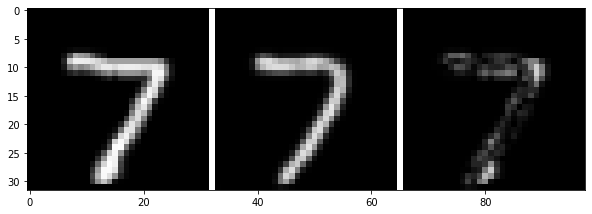

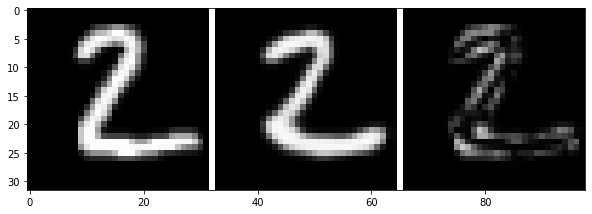

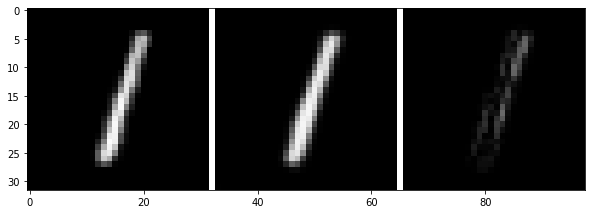

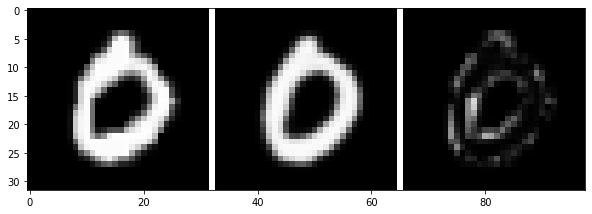

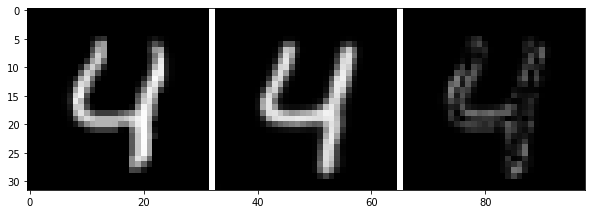

04/06/2020 12:16:30, epoch=86, step=10160, loss=0.08664, distortion=0.123, rate=0.027, -elbo=105.93265, nll=86.96378, KL=18.96887, commit_loss=1735.56299, bit_usage=0.97421, highest_prob=0.010, temp=0.28467
04/06/2020 12:16:31, epoch=86, step=10180, loss=0.08571, distortion=0.121, rate=0.027, -elbo=104.92807, nll=86.01173, KL=18.91634, commit_loss=1739.55762, bit_usage=0.97440, highest_prob=0.011, temp=0.28392
reset code 100
04/06/2020 12:16:32, epoch=86, step=10200, loss=0.08864, distortion=0.125, rate=0.027, -elbo=108.03285, nll=89.03769, KL=18.99516, commit_loss=1707.61646, bit_usage=0.97729, highest_prob=0.010, temp=0.28317
reset code 208
04/06/2020 12:16:32, epoch=86, step=10220, loss=0.08845, distortion=0.125, rate=0.027, -elbo=107.88474, nll=88.86160, KL=19.02313, commit_loss=1691.73462, bit_usage=0.97326, highest_prob=0.010, temp=0.28241
reset code 252
04/06/2020 12:16:33, epoch=86, step=10240, loss=0.09128, distortion=0.129, rate=0.027, -elbo=110.68724, nll=91.71471, KL=18.972

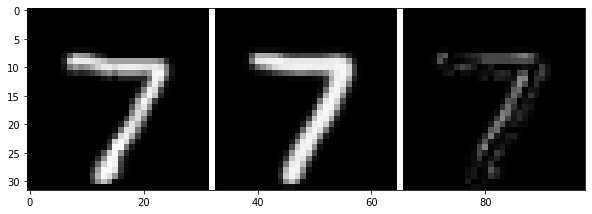

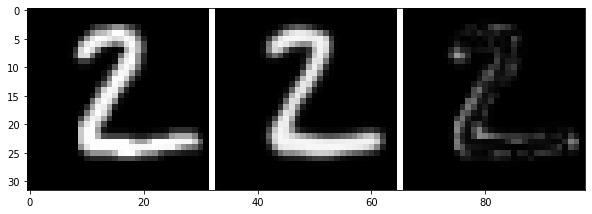

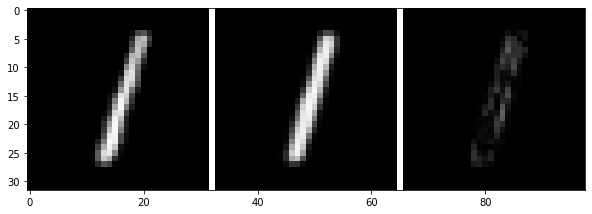

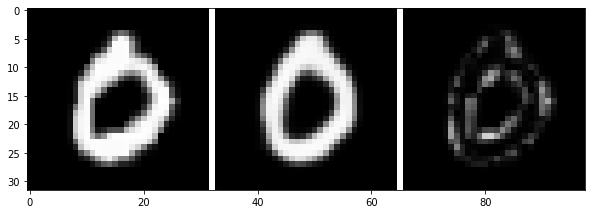

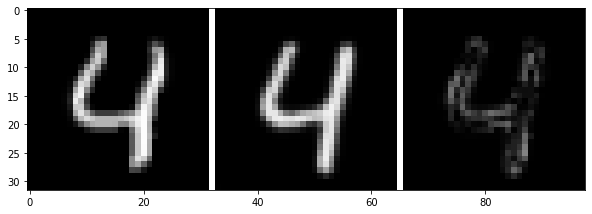

04/06/2020 12:16:49, epoch=91, step=10740, loss=0.08934, distortion=0.126, rate=0.027, -elbo=108.91624, nll=89.66887, KL=19.24737, commit_loss=1798.74976, bit_usage=0.97017, highest_prob=0.012, temp=0.26285
reset code 254
04/06/2020 12:16:50, epoch=91, step=10760, loss=0.08905, distortion=0.126, rate=0.027, -elbo=108.54187, nll=89.40369, KL=19.13819, commit_loss=1763.20190, bit_usage=0.97433, highest_prob=0.010, temp=0.26209
04/06/2020 12:16:50, epoch=91, step=10780, loss=0.08328, distortion=0.118, rate=0.027, -elbo=102.50864, nll=83.51826, KL=18.99037, commit_loss=1745.10718, bit_usage=0.97808, highest_prob=0.010, temp=0.26134
reset code 100
04/06/2020 12:16:51, epoch=91, step=10800, loss=0.08416, distortion=0.119, rate=0.027, -elbo=103.52349, nll=84.40424, KL=19.11925, commit_loss=1757.10034, bit_usage=0.97833, highest_prob=0.010, temp=0.26059
reset code 152
04/06/2020 12:16:51, epoch=91, step=10820, loss=0.08518, distortion=0.120, rate=0.027, -elbo=104.49547, nll=85.43195, KL=19.063

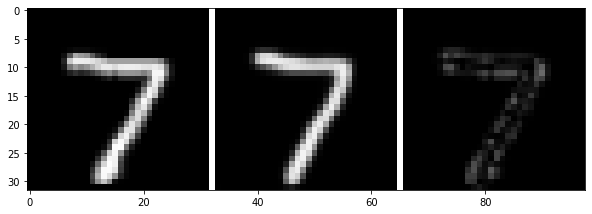

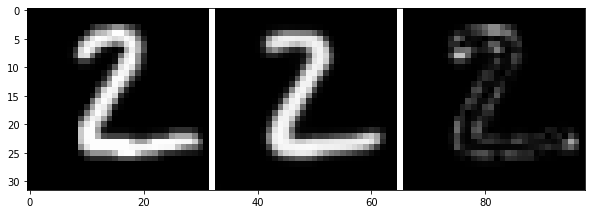

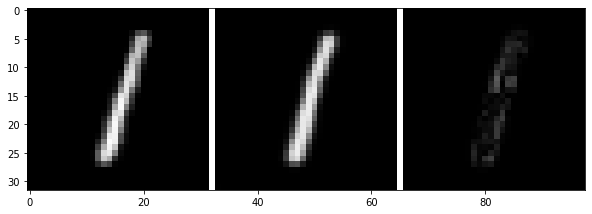

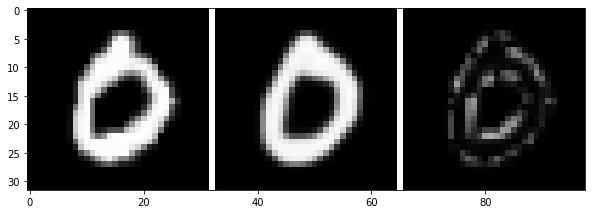

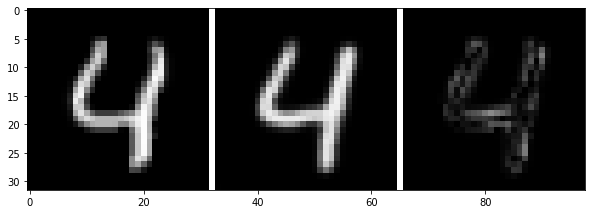

04/06/2020 12:17:08, epoch=96, step=11340, loss=0.08635, distortion=0.122, rate=0.027, -elbo=105.85422, nll=86.59566, KL=19.25856, commit_loss=1810.61194, bit_usage=0.97492, highest_prob=0.011, temp=0.24027
reset code 239
04/06/2020 12:17:09, epoch=96, step=11360, loss=0.08722, distortion=0.123, rate=0.027, -elbo=106.82253, nll=87.49513, KL=19.32740, commit_loss=1798.37720, bit_usage=0.97565, highest_prob=0.009, temp=0.23952
04/06/2020 12:17:10, epoch=96, step=11380, loss=0.08676, distortion=0.123, rate=0.027, -elbo=106.24443, nll=86.98971, KL=19.25472, commit_loss=1837.53076, bit_usage=0.97882, highest_prob=0.013, temp=0.23877
reset code 23
04/06/2020 12:17:10, epoch=96, step=11400, loss=0.08494, distortion=0.120, rate=0.027, -elbo=104.35055, nll=85.13600, KL=19.21454, commit_loss=1820.12158, bit_usage=0.97684, highest_prob=0.011, temp=0.23801
reset code 208
04/06/2020 12:17:11, epoch=96, step=11420, loss=0.08962, distortion=0.127, rate=0.027, -elbo=109.19456, nll=89.90985, KL=19.2847

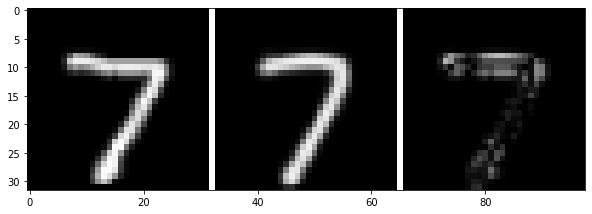

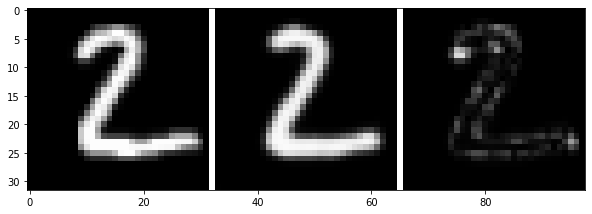

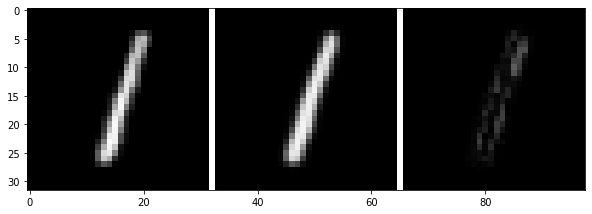

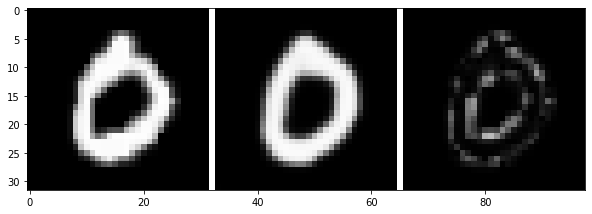

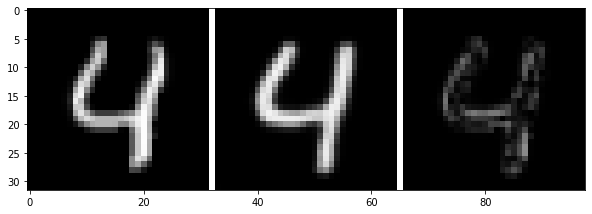

04/06/2020 12:17:28, epoch=101, step=11920, loss=0.08401, distortion=0.119, rate=0.027, -elbo=103.37166, nll=84.16976, KL=19.20190, commit_loss=1839.39429, bit_usage=0.97335, highest_prob=0.012, temp=0.21845
04/06/2020 12:17:29, epoch=101, step=11940, loss=0.08073, distortion=0.114, rate=0.027, -elbo=100.13689, nll=80.84949, KL=19.28739, commit_loss=1795.75818, bit_usage=0.97879, highest_prob=0.009, temp=0.21769
04/06/2020 12:17:29, epoch=101, step=11960, loss=0.08889, distortion=0.126, rate=0.027, -elbo=108.51947, nll=89.18452, KL=19.33494, commit_loss=1820.95117, bit_usage=0.97919, highest_prob=0.010, temp=0.21694
reset code 104
04/06/2020 12:17:30, epoch=101, step=11980, loss=0.08856, distortion=0.125, rate=0.027, -elbo=108.22295, nll=88.85072, KL=19.37223, commit_loss=1814.05444, bit_usage=0.97782, highest_prob=0.013, temp=0.21619
04/06/2020 12:17:31, epoch=101, step=12000, loss=0.08515, distortion=0.120, rate=0.027, -elbo=104.67159, nll=85.33306, KL=19.33853, commit_loss=1838.6904

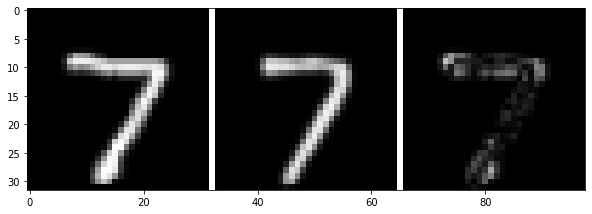

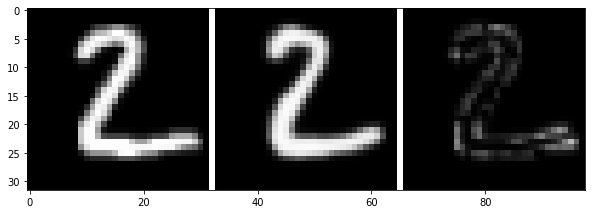

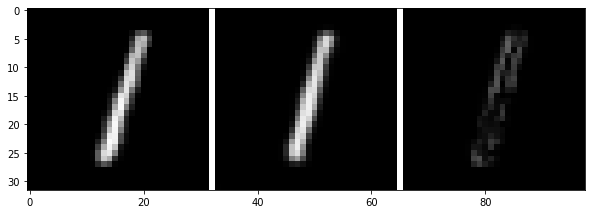

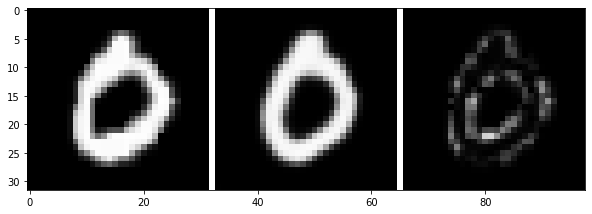

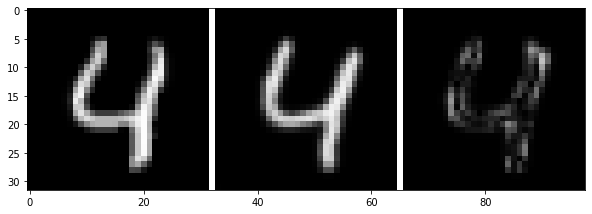

04/06/2020 12:17:49, epoch=106, step=12520, loss=0.08408, distortion=0.119, rate=0.027, -elbo=103.65585, nll=84.23430, KL=19.42155, commit_loss=1844.52539, bit_usage=0.97892, highest_prob=0.010, temp=0.19587
reset code 99
04/06/2020 12:17:49, epoch=106, step=12540, loss=0.08629, distortion=0.122, rate=0.027, -elbo=105.95935, nll=86.47810, KL=19.48125, commit_loss=1863.35083, bit_usage=0.97611, highest_prob=0.010, temp=0.19512
reset code 23
04/06/2020 12:17:50, epoch=106, step=12560, loss=0.08331, distortion=0.117, rate=0.027, -elbo=102.80576, nll=83.38407, KL=19.42169, commit_loss=1904.04919, bit_usage=0.98108, highest_prob=0.011, temp=0.19437
04/06/2020 12:17:51, epoch=106, step=12580, loss=0.08462, distortion=0.119, rate=0.027, -elbo=104.12424, nll=84.74329, KL=19.38095, commit_loss=1887.63037, bit_usage=0.98048, highest_prob=0.009, temp=0.19361
04/06/2020 12:17:51, epoch=106, step=12600, loss=0.08397, distortion=0.118, rate=0.027, -elbo=103.55897, nll=84.09766, KL=19.46131, commit_l

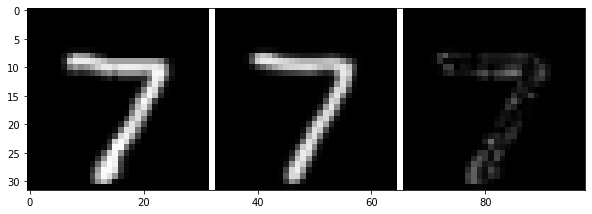

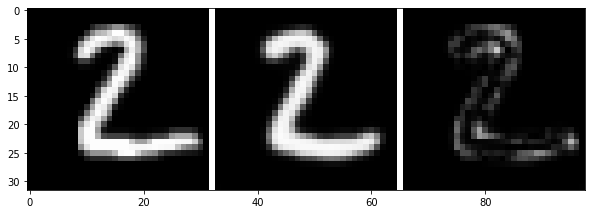

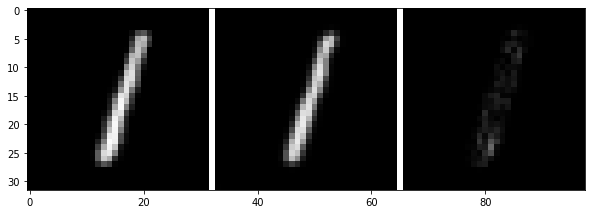

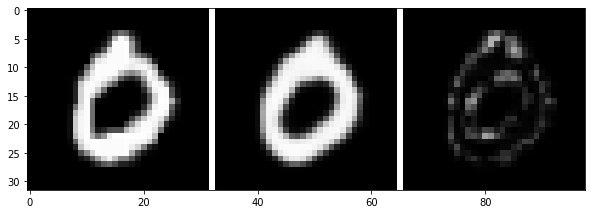

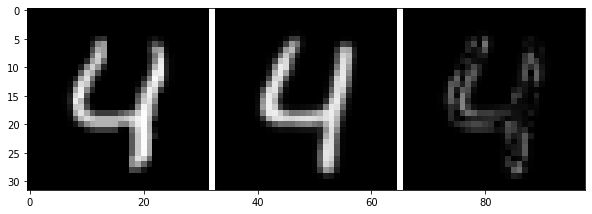

04/06/2020 12:18:10, epoch=111, step=13100, loss=0.08520, distortion=0.120, rate=0.027, -elbo=104.76907, nll=85.34286, KL=19.42621, commit_loss=1878.61157, bit_usage=0.97625, highest_prob=0.011, temp=0.17405
04/06/2020 12:18:10, epoch=111, step=13120, loss=0.08540, distortion=0.121, rate=0.028, -elbo=105.07061, nll=85.53501, KL=19.53560, commit_loss=1897.13208, bit_usage=0.97775, highest_prob=0.009, temp=0.17329
04/06/2020 12:18:11, epoch=111, step=13140, loss=0.08619, distortion=0.122, rate=0.027, -elbo=105.84862, nll=86.34695, KL=19.50167, commit_loss=1896.63867, bit_usage=0.97795, highest_prob=0.010, temp=0.17254
reset code 234
04/06/2020 12:18:12, epoch=111, step=13160, loss=0.08338, distortion=0.118, rate=0.027, -elbo=102.96364, nll=83.44830, KL=19.51533, commit_loss=1913.29309, bit_usage=0.97511, highest_prob=0.010, temp=0.17179
04/06/2020 12:18:12, epoch=111, step=13180, loss=0.08485, distortion=0.120, rate=0.028, -elbo=104.48688, nll=84.93878, KL=19.54809, commit_loss=1925.8851

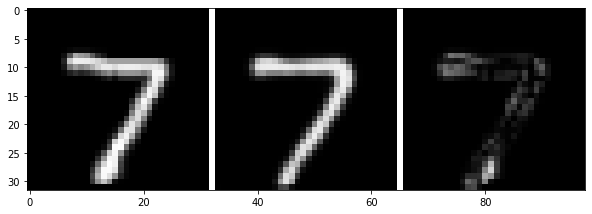

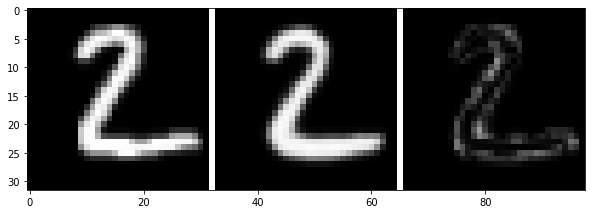

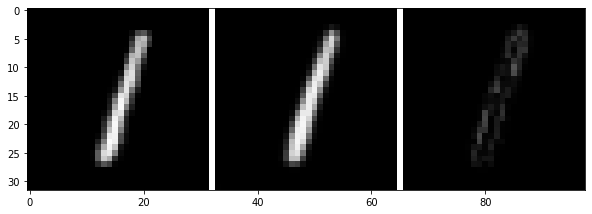

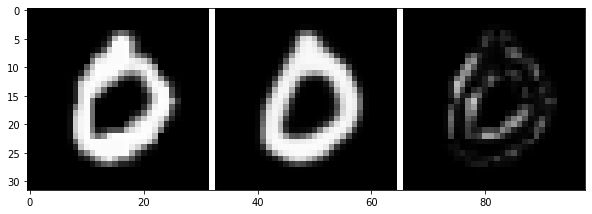

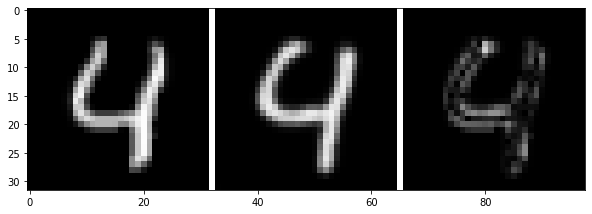

04/06/2020 12:18:31, epoch=116, step=13700, loss=0.08453, distortion=0.119, rate=0.028, -elbo=104.22095, nll=84.64446, KL=19.57649, commit_loss=1890.90063, bit_usage=0.98037, highest_prob=0.010, temp=0.15147
04/06/2020 12:18:32, epoch=116, step=13720, loss=0.08330, distortion=0.117, rate=0.028, -elbo=102.92718, nll=83.38993, KL=19.53725, commit_loss=1885.23267, bit_usage=0.97937, highest_prob=0.009, temp=0.15072
04/06/2020 12:18:33, epoch=116, step=13740, loss=0.08060, distortion=0.114, rate=0.028, -elbo=100.22389, nll=80.62467, KL=19.59922, commit_loss=1888.09448, bit_usage=0.97900, highest_prob=0.009, temp=0.14997
04/06/2020 12:18:33, epoch=116, step=13760, loss=0.08693, distortion=0.123, rate=0.028, -elbo=106.75575, nll=87.14190, KL=19.61386, commit_loss=1858.03564, bit_usage=0.97833, highest_prob=0.009, temp=0.14921
04/06/2020 12:18:34, epoch=116, step=13780, loss=0.08304, distortion=0.117, rate=0.028, -elbo=102.69138, nll=83.11806, KL=19.57331, commit_loss=1897.33533, bit_usage=0.

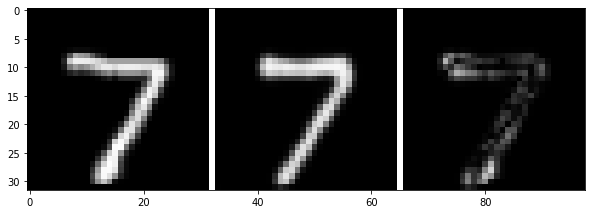

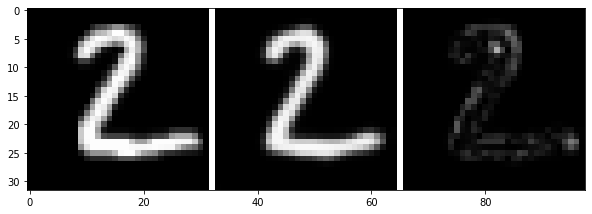

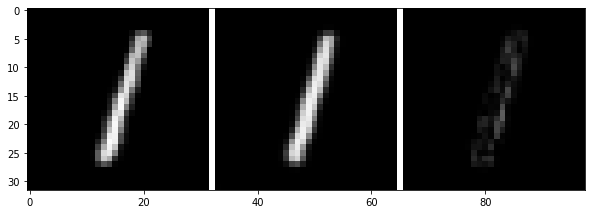

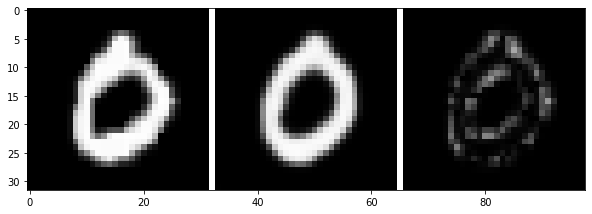

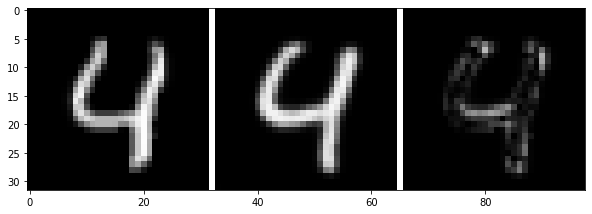

04/06/2020 12:18:56, epoch=121, step=14280, loss=0.07936, distortion=0.112, rate=0.028, -elbo=98.94447, nll=79.21716, KL=19.72731, commit_loss=2028.13391, bit_usage=0.97818, highest_prob=0.011, temp=0.12965
04/06/2020 12:18:56, epoch=121, step=14300, loss=0.07944, distortion=0.112, rate=0.028, -elbo=98.95052, nll=79.31284, KL=19.63768, commit_loss=2018.75549, bit_usage=0.98072, highest_prob=0.008, temp=0.12889
04/06/2020 12:18:57, epoch=121, step=14320, loss=0.08196, distortion=0.115, rate=0.028, -elbo=101.54701, nll=81.92418, KL=19.62284, commit_loss=1985.93066, bit_usage=0.97834, highest_prob=0.014, temp=0.12814
04/06/2020 12:18:57, epoch=121, step=14340, loss=0.08259, distortion=0.116, rate=0.028, -elbo=102.21701, nll=82.56280, KL=19.65421, commit_loss=1986.28613, bit_usage=0.97908, highest_prob=0.010, temp=0.12739
04/06/2020 12:18:58, epoch=121, step=14360, loss=0.08199, distortion=0.116, rate=0.028, -elbo=101.60157, nll=81.98050, KL=19.62107, commit_loss=1960.42480, bit_usage=0.97

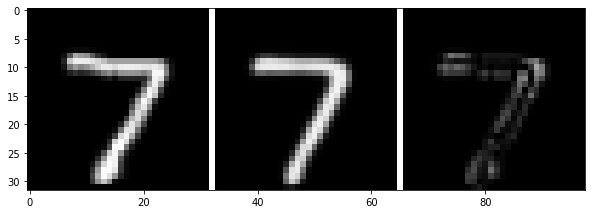

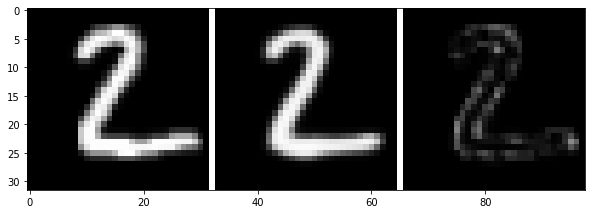

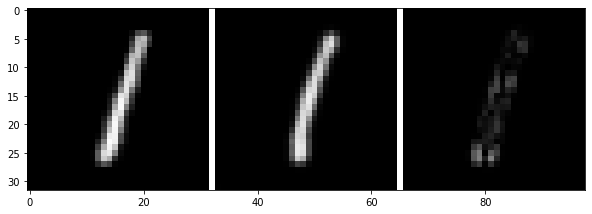

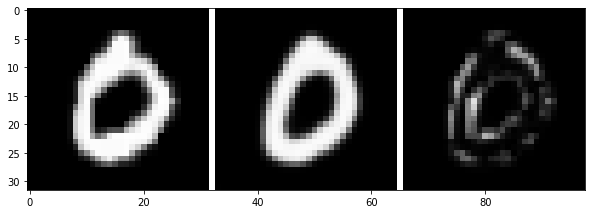

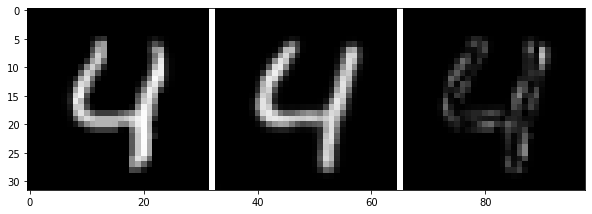

04/06/2020 12:19:15, epoch=126, step=14880, loss=0.07819, distortion=0.110, rate=0.028, -elbo=97.76028, nll=78.05975, KL=19.70053, commit_loss=1984.58643, bit_usage=0.97867, highest_prob=0.012, temp=0.10707
04/06/2020 12:19:15, epoch=126, step=14900, loss=0.07997, distortion=0.112, rate=0.028, -elbo=99.49516, nll=79.84554, KL=19.64962, commit_loss=2024.53479, bit_usage=0.97651, highest_prob=0.013, temp=0.10632
04/06/2020 12:19:16, epoch=126, step=14920, loss=0.07963, distortion=0.112, rate=0.028, -elbo=99.14028, nll=79.47701, KL=19.66327, commit_loss=2043.37256, bit_usage=0.97920, highest_prob=0.010, temp=0.10557
04/06/2020 12:19:16, epoch=126, step=14940, loss=0.08252, distortion=0.116, rate=0.028, -elbo=102.22467, nll=82.45827, KL=19.76640, commit_loss=2023.50195, bit_usage=0.97946, highest_prob=0.010, temp=0.10481
04/06/2020 12:19:17, epoch=126, step=14960, loss=0.08451, distortion=0.119, rate=0.028, -elbo=104.15797, nll=84.42426, KL=19.73371, commit_loss=2089.24023, bit_usage=0.980

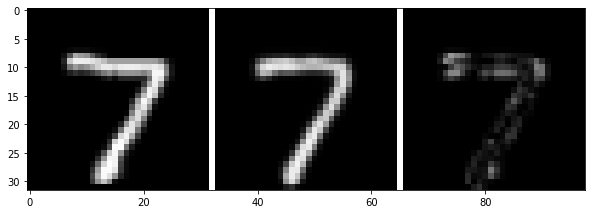

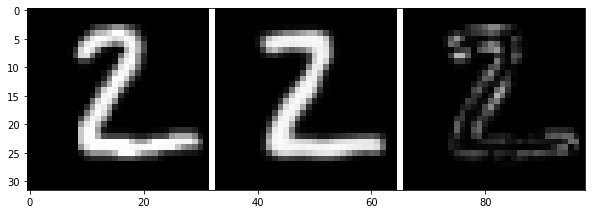

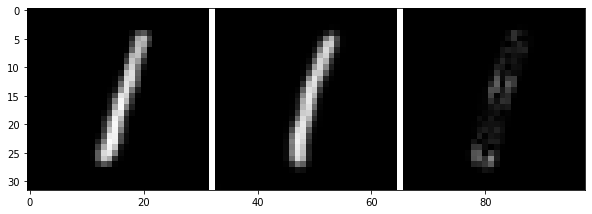

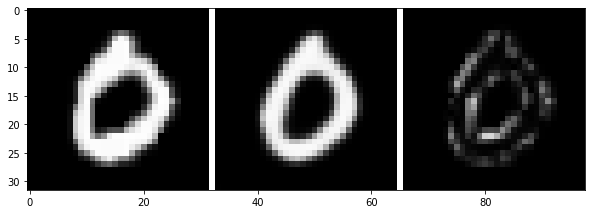

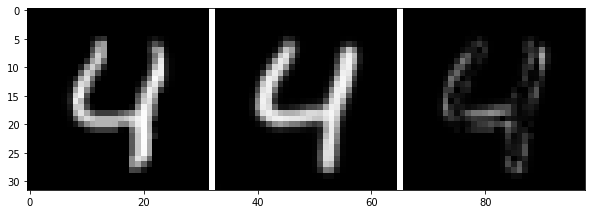

04/06/2020 12:19:33, epoch=131, step=15460, loss=0.07800, distortion=0.110, rate=0.028, -elbo=97.47981, nll=77.85392, KL=19.62589, commit_loss=1999.96606, bit_usage=0.98218, highest_prob=0.009, temp=0.08525
reset code 191
04/06/2020 12:19:34, epoch=131, step=15480, loss=0.08048, distortion=0.113, rate=0.028, -elbo=100.08250, nll=80.34347, KL=19.73904, commit_loss=2053.37744, bit_usage=0.97802, highest_prob=0.010, temp=0.08449
04/06/2020 12:19:34, epoch=131, step=15500, loss=0.07917, distortion=0.111, rate=0.028, -elbo=98.70651, nll=78.99300, KL=19.71351, commit_loss=2056.70654, bit_usage=0.97971, highest_prob=0.010, temp=0.08374
04/06/2020 12:19:35, epoch=131, step=15520, loss=0.07866, distortion=0.111, rate=0.028, -elbo=98.13567, nll=78.48201, KL=19.65366, commit_loss=2041.19446, bit_usage=0.98073, highest_prob=0.010, temp=0.08299
04/06/2020 12:19:35, epoch=131, step=15540, loss=0.07901, distortion=0.111, rate=0.028, -elbo=98.57780, nll=78.89130, KL=19.68650, commit_loss=1996.44592, b

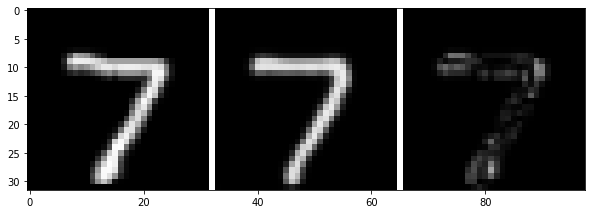

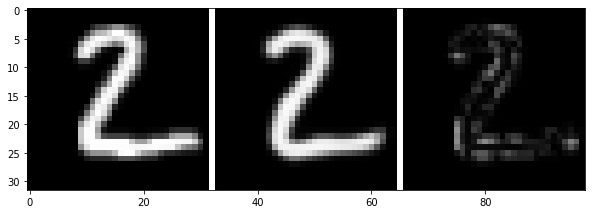

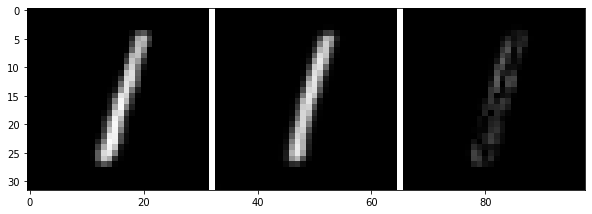

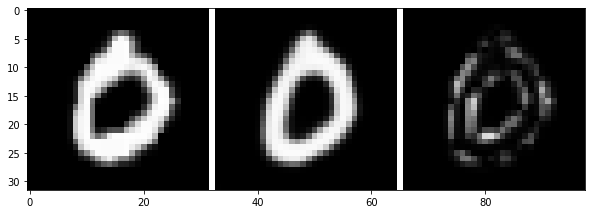

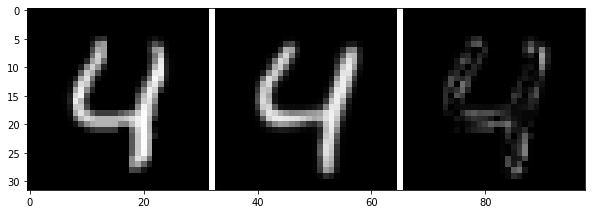

04/06/2020 12:19:52, epoch=136, step=16060, loss=0.07750, distortion=0.109, rate=0.028, -elbo=96.93887, nll=77.32239, KL=19.61649, commit_loss=2016.09802, bit_usage=0.98032, highest_prob=0.009, temp=0.06267
04/06/2020 12:19:53, epoch=136, step=16080, loss=0.07789, distortion=0.109, rate=0.028, -elbo=97.41736, nll=77.70319, KL=19.71418, commit_loss=2035.24683, bit_usage=0.98064, highest_prob=0.009, temp=0.06192
04/06/2020 12:19:53, epoch=136, step=16100, loss=0.07887, distortion=0.111, rate=0.028, -elbo=98.37843, nll=78.69907, KL=19.67936, commit_loss=2048.56152, bit_usage=0.98383, highest_prob=0.009, temp=0.06117
04/06/2020 12:19:54, epoch=136, step=16120, loss=0.07859, distortion=0.110, rate=0.028, -elbo=98.18219, nll=78.41943, KL=19.76276, commit_loss=2039.33130, bit_usage=0.98262, highest_prob=0.009, temp=0.06041
04/06/2020 12:19:55, epoch=136, step=16140, loss=0.07940, distortion=0.112, rate=0.028, -elbo=99.01167, nll=79.26669, KL=19.74499, commit_loss=2017.34143, bit_usage=0.98078

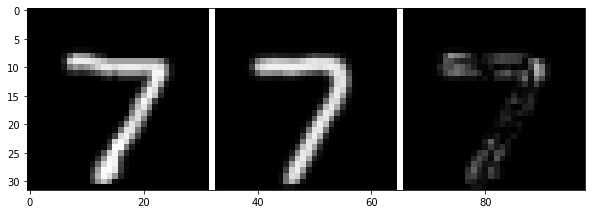

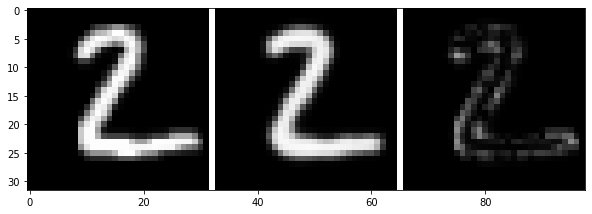

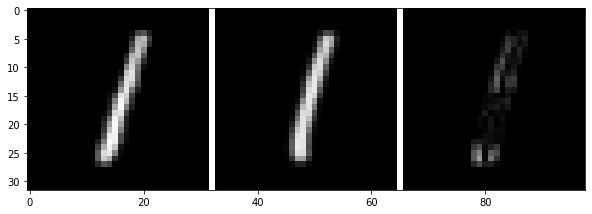

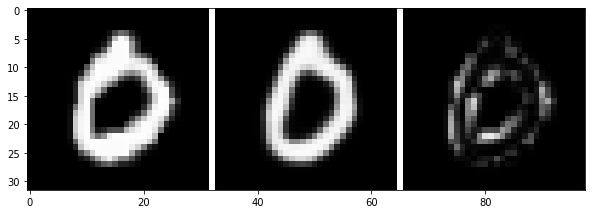

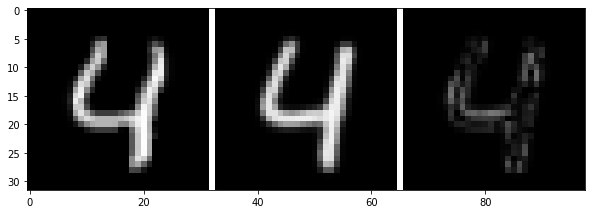

04/06/2020 12:20:11, epoch=141, step=16640, loss=0.07924, distortion=0.111, rate=0.028, -elbo=98.71555, nll=79.04248, KL=19.67307, commit_loss=2078.62354, bit_usage=0.98254, highest_prob=0.009, temp=0.04085
04/06/2020 12:20:12, epoch=141, step=16660, loss=0.08011, distortion=0.113, rate=0.028, -elbo=99.68672, nll=79.92805, KL=19.75868, commit_loss=2080.95996, bit_usage=0.98115, highest_prob=0.009, temp=0.04009
04/06/2020 12:20:12, epoch=141, step=16680, loss=0.07372, distortion=0.103, rate=0.028, -elbo=93.07678, nll=73.42287, KL=19.65392, commit_loss=2051.00049, bit_usage=0.98089, highest_prob=0.012, temp=0.03934
04/06/2020 12:20:13, epoch=141, step=16700, loss=0.07681, distortion=0.108, rate=0.028, -elbo=96.26139, nll=76.53352, KL=19.72787, commit_loss=2103.01440, bit_usage=0.98068, highest_prob=0.010, temp=0.03859
04/06/2020 12:20:13, epoch=141, step=16720, loss=0.07597, distortion=0.107, rate=0.028, -elbo=95.44915, nll=75.69915, KL=19.75000, commit_loss=2077.75391, bit_usage=0.98367

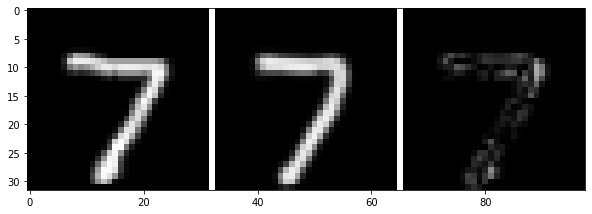

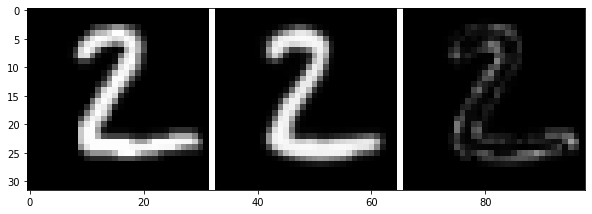

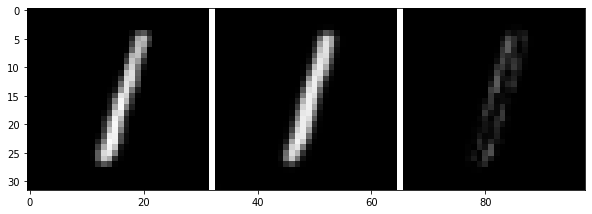

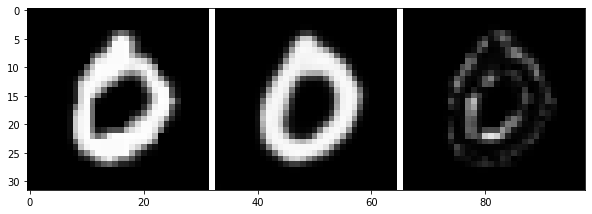

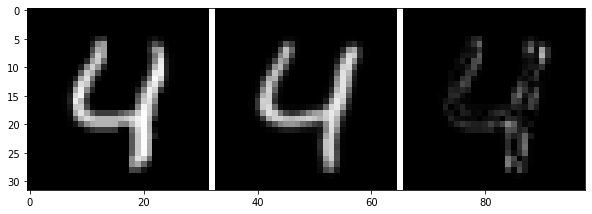

04/06/2020 12:20:30, epoch=146, step=17240, loss=0.07761, distortion=0.109, rate=0.028, -elbo=97.01843, nll=77.37072, KL=19.64771, commit_loss=2083.59399, bit_usage=0.97944, highest_prob=0.012, temp=0.01827
04/06/2020 12:20:31, epoch=146, step=17260, loss=0.08060, distortion=0.113, rate=0.028, -elbo=100.18894, nll=80.43795, KL=19.75099, commit_loss=2072.87793, bit_usage=0.97955, highest_prob=0.010, temp=0.01752
04/06/2020 12:20:31, epoch=146, step=17280, loss=0.07809, distortion=0.110, rate=0.028, -elbo=97.55235, nll=77.84285, KL=19.70950, commit_loss=2103.43286, bit_usage=0.98014, highest_prob=0.010, temp=0.01677
04/06/2020 12:20:32, epoch=146, step=17300, loss=0.07887, distortion=0.111, rate=0.028, -elbo=98.41943, nll=78.67360, KL=19.74583, commit_loss=2071.97412, bit_usage=0.98007, highest_prob=0.010, temp=0.01601
04/06/2020 12:20:32, epoch=146, step=17320, loss=0.07812, distortion=0.110, rate=0.028, -elbo=97.64081, nll=77.91830, KL=19.72250, commit_loss=2060.38110, bit_usage=0.9846

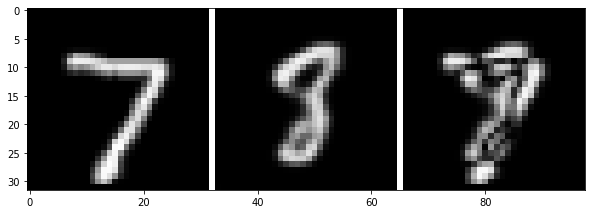

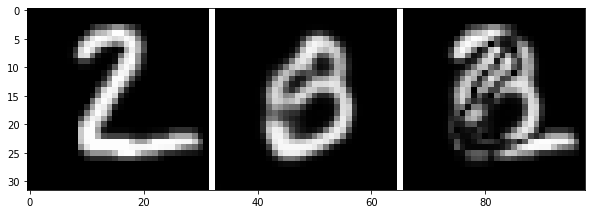

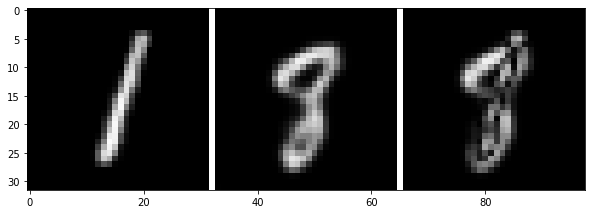

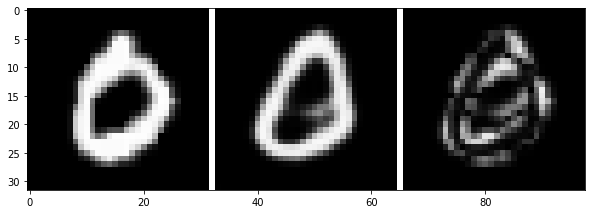

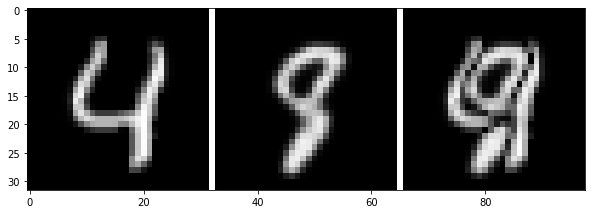

04/06/2020 12:20:59, epoch=1, step=120, loss=0.82598, distortion=1.191, rate=0.023, -elbo=215.49994, nll=211.41287, KL=4.08707, commit_loss=35.18599, bit_usage=0.36600, highest_prob=0.211, temp=0.66245
reset code 96
04/06/2020 12:21:01, epoch=1, step=140, loss=0.81867, distortion=1.181, rate=0.022, -elbo=213.49829, nll=209.54025, KL=3.95804, commit_loss=35.77315, bit_usage=0.39088, highest_prob=0.164, temp=0.66169
reset code 112
04/06/2020 12:21:03, epoch=1, step=160, loss=0.82193, distortion=1.186, rate=0.021, -elbo=214.14622, nll=210.37244, KL=3.77379, commit_loss=36.66678, bit_usage=0.42091, highest_prob=0.121, temp=0.66094
reset code 128
04/06/2020 12:21:05, epoch=1, step=180, loss=0.83159, distortion=1.200, rate=0.021, -elbo=216.56522, nll=212.84615, KL=3.71907, commit_loss=37.44577, bit_usage=0.44716, highest_prob=0.111, temp=0.66019
reset code 144
04/06/2020 12:21:07, epoch=1, step=200, loss=0.77817, distortion=1.122, rate=0.023, -elbo=203.23909, nll=199.17117, KL=4.06791, commi

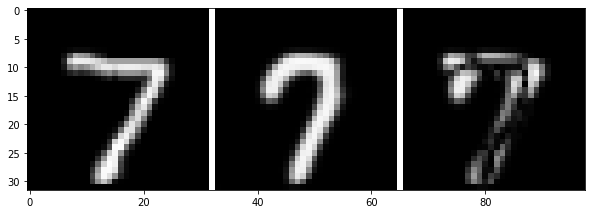

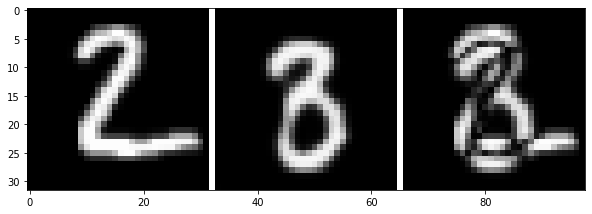

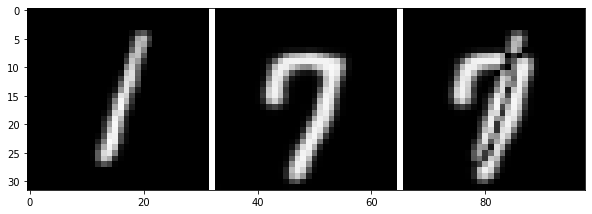

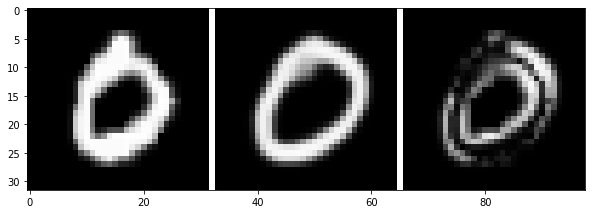

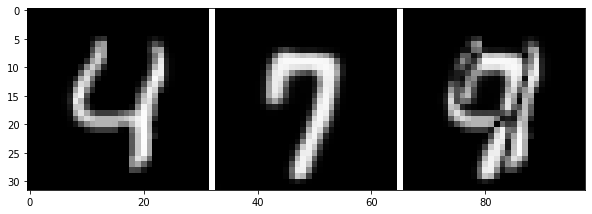

04/06/2020 12:22:04, epoch=6, step=720, loss=0.60412, distortion=0.871, rate=0.016, -elbo=157.54323, nll=154.61661, KL=2.92662, commit_loss=35.58886, bit_usage=0.65936, highest_prob=0.043, temp=0.63987
reset code 84
04/06/2020 12:22:06, epoch=6, step=740, loss=0.59456, distortion=0.858, rate=0.016, -elbo=155.04150, nll=152.16908, KL=2.87241, commit_loss=35.74572, bit_usage=0.65927, highest_prob=0.055, temp=0.63912
reset code 100
04/06/2020 12:22:08, epoch=6, step=760, loss=0.58248, distortion=0.840, rate=0.016, -elbo=151.94145, nll=149.07657, KL=2.86489, commit_loss=35.59360, bit_usage=0.66682, highest_prob=0.039, temp=0.63837
reset code 116
04/06/2020 12:22:10, epoch=6, step=780, loss=0.57562, distortion=0.830, rate=0.016, -elbo=150.16849, nll=147.31931, KL=2.84918, commit_loss=35.55967, bit_usage=0.66697, highest_prob=0.037, temp=0.63761
reset code 132
04/06/2020 12:22:13, epoch=6, step=800, loss=0.59377, distortion=0.856, rate=0.016, -elbo=154.78754, nll=151.96628, KL=2.82126, commi

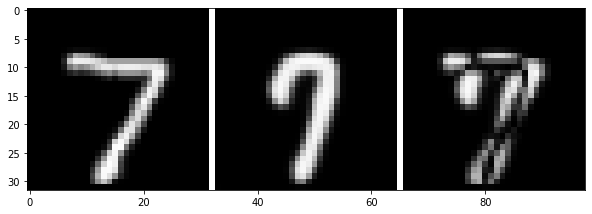

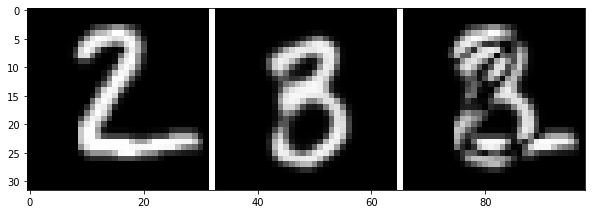

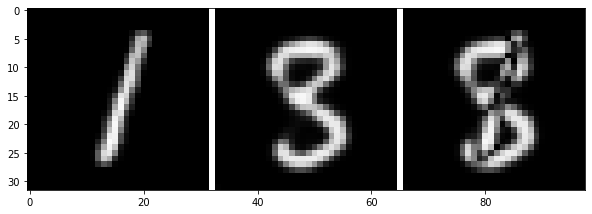

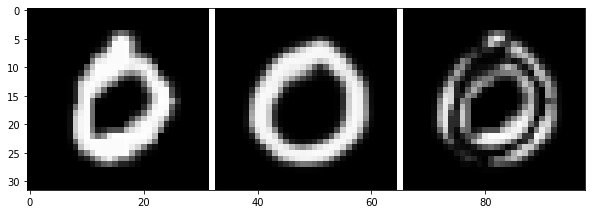

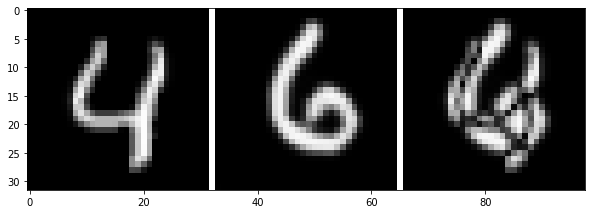

04/06/2020 12:23:07, epoch=11, step=1300, loss=0.54528, distortion=0.786, rate=0.013, -elbo=141.91608, nll=139.55467, KL=2.36141, commit_loss=35.27312, bit_usage=0.74607, highest_prob=0.035, temp=0.61805
reset code 34
04/06/2020 12:23:09, epoch=11, step=1320, loss=0.53454, distortion=0.771, rate=0.013, -elbo=139.13898, nll=136.80565, KL=2.33333, commit_loss=35.18356, bit_usage=0.74632, highest_prob=0.037, temp=0.61729
reset code 50
04/06/2020 12:23:13, epoch=11, step=1340, loss=0.53560, distortion=0.773, rate=0.013, -elbo=139.35416, nll=137.07709, KL=2.27707, commit_loss=35.36990, bit_usage=0.74973, highest_prob=0.033, temp=0.61654
reset code 66
04/06/2020 12:23:16, epoch=11, step=1360, loss=0.52281, distortion=0.754, rate=0.013, -elbo=136.10867, nll=133.80215, KL=2.30652, commit_loss=35.23819, bit_usage=0.75375, highest_prob=0.035, temp=0.61579
reset code 82
04/06/2020 12:23:18, epoch=11, step=1380, loss=0.52815, distortion=0.762, rate=0.013, -elbo=137.50661, nll=135.16869, KL=2.33792

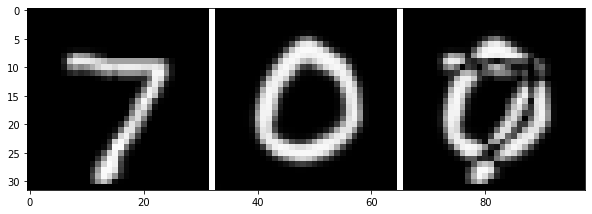

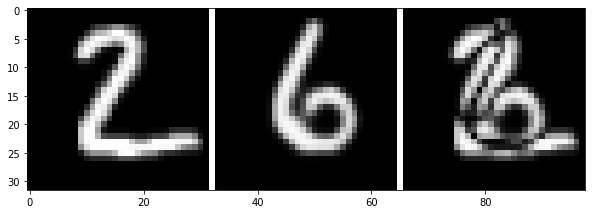

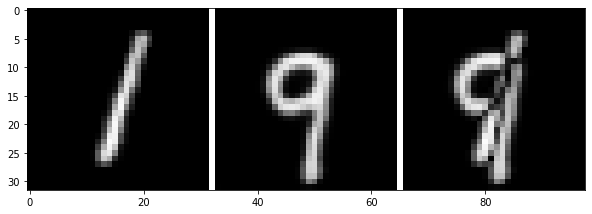

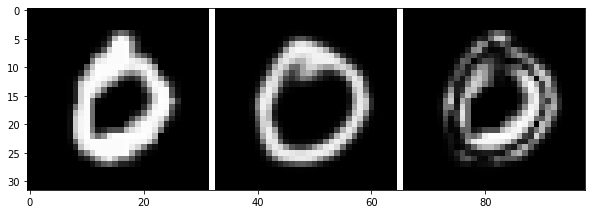

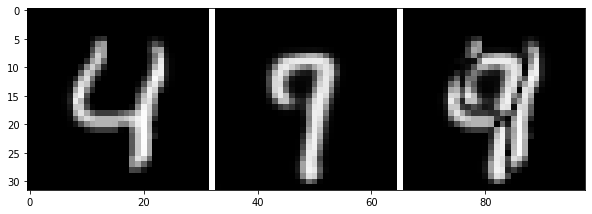

04/06/2020 12:24:14, epoch=16, step=1900, loss=0.52817, distortion=0.762, rate=0.011, -elbo=137.19719, nll=135.17522, KL=2.02198, commit_loss=35.00648, bit_usage=0.79810, highest_prob=0.035, temp=0.59547
reset code 6
04/06/2020 12:24:16, epoch=16, step=1920, loss=0.53921, distortion=0.778, rate=0.011, -elbo=139.98470, nll=137.99998, KL=1.98471, commit_loss=35.11762, bit_usage=0.79867, highest_prob=0.031, temp=0.59472
reset code 22
04/06/2020 12:24:18, epoch=16, step=1940, loss=0.52843, distortion=0.762, rate=0.011, -elbo=137.21095, nll=135.24097, KL=1.96999, commit_loss=35.14944, bit_usage=0.80656, highest_prob=0.027, temp=0.59397
reset code 38
04/06/2020 12:24:20, epoch=16, step=1960, loss=0.52163, distortion=0.752, rate=0.011, -elbo=135.47069, nll=133.50038, KL=1.97030, commit_loss=35.07937, bit_usage=0.80896, highest_prob=0.031, temp=0.59321
reset code 54
04/06/2020 12:24:22, epoch=16, step=1980, loss=0.55347, distortion=0.798, rate=0.011, -elbo=143.57161, nll=141.65222, KL=1.91939,

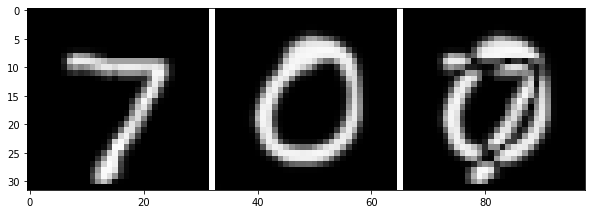

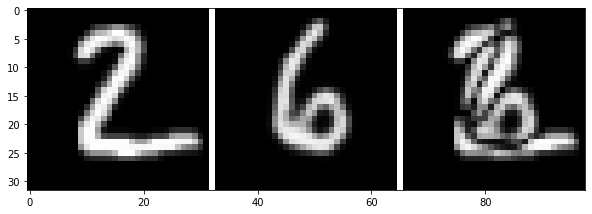

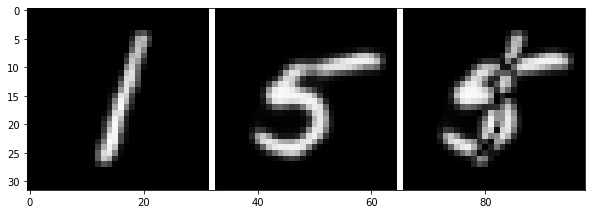

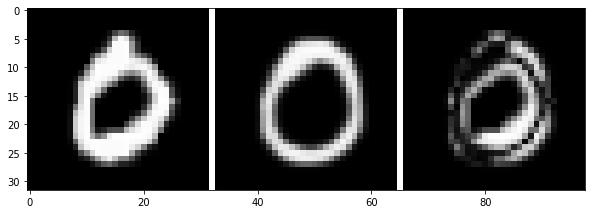

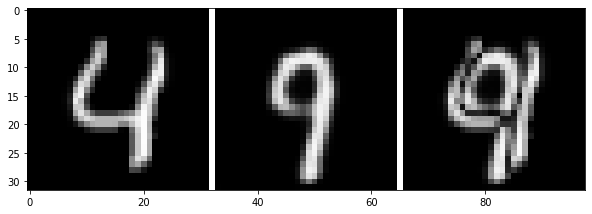

04/06/2020 12:25:17, epoch=21, step=2480, loss=0.52589, distortion=0.758, rate=0.010, -elbo=136.38710, nll=134.59146, KL=1.79565, commit_loss=34.74056, bit_usage=0.82702, highest_prob=0.027, temp=0.57365
reset code 222
04/06/2020 12:25:19, epoch=21, step=2500, loss=0.53465, distortion=0.771, rate=0.010, -elbo=138.61127, nll=136.83279, KL=1.77847, commit_loss=34.87504, bit_usage=0.83049, highest_prob=0.027, temp=0.57289
reset code 238
04/06/2020 12:25:22, epoch=21, step=2520, loss=0.53706, distortion=0.775, rate=0.010, -elbo=139.25027, nll=137.45029, KL=1.79998, commit_loss=34.81996, bit_usage=0.82670, highest_prob=0.031, temp=0.57214
reset code 254
04/06/2020 12:25:24, epoch=21, step=2540, loss=0.48636, distortion=0.701, rate=0.010, -elbo=126.24823, nll=124.47079, KL=1.77744, commit_loss=34.75749, bit_usage=0.82169, highest_prob=0.025, temp=0.57139
reset code 1
04/06/2020 12:25:26, epoch=21, step=2560, loss=0.51767, distortion=0.747, rate=0.010, -elbo=134.25940, nll=132.48608, KL=1.773

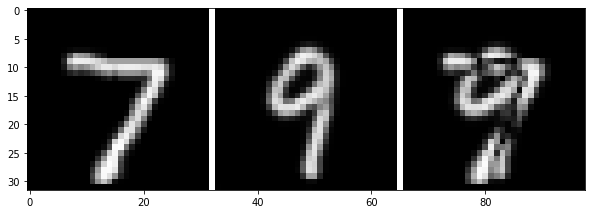

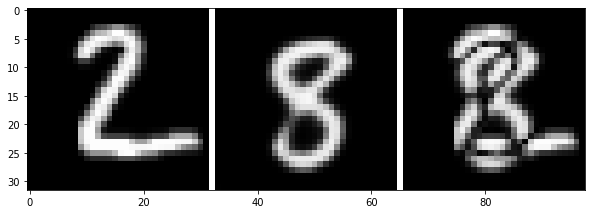

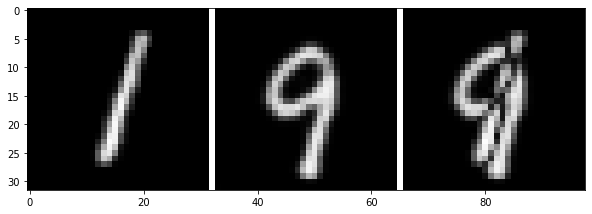

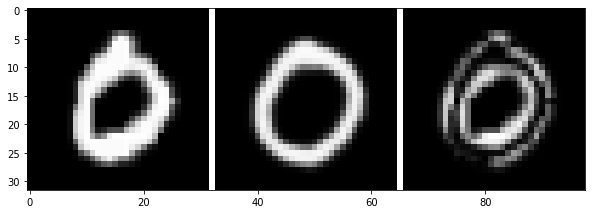

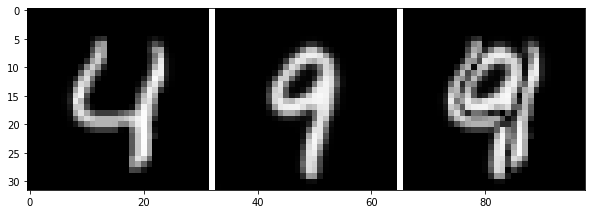

04/06/2020 12:26:22, epoch=26, step=3080, loss=0.53393, distortion=0.770, rate=0.009, -elbo=138.22795, nll=136.65067, KL=1.57729, commit_loss=34.58862, bit_usage=0.86512, highest_prob=0.025, temp=0.55107
reset code 185
04/06/2020 12:26:24, epoch=26, step=3100, loss=0.50151, distortion=0.723, rate=0.009, -elbo=129.92909, nll=128.34995, KL=1.57915, commit_loss=34.48835, bit_usage=0.86348, highest_prob=0.025, temp=0.55032
reset code 201
04/06/2020 12:26:26, epoch=26, step=3120, loss=0.53159, distortion=0.767, rate=0.009, -elbo=137.65202, nll=136.05185, KL=1.60017, commit_loss=34.49298, bit_usage=0.85456, highest_prob=0.037, temp=0.54957
reset code 217
04/06/2020 12:26:28, epoch=26, step=3140, loss=0.52869, distortion=0.763, rate=0.009, -elbo=136.97299, nll=135.30994, KL=1.66306, commit_loss=34.21298, bit_usage=0.85133, highest_prob=0.053, temp=0.54881
reset code 233
04/06/2020 12:26:30, epoch=26, step=3160, loss=0.50840, distortion=0.733, rate=0.009, -elbo=131.73860, nll=130.11484, KL=1.6

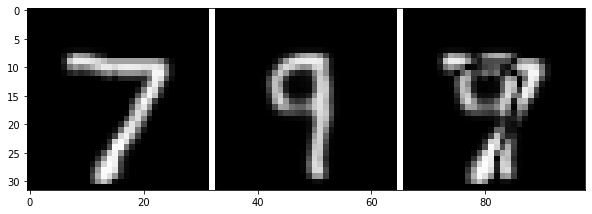

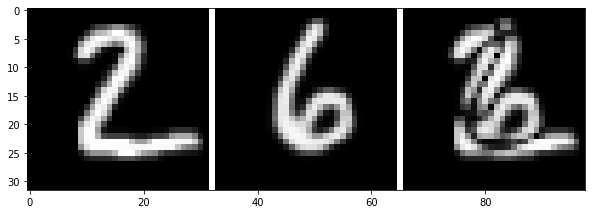

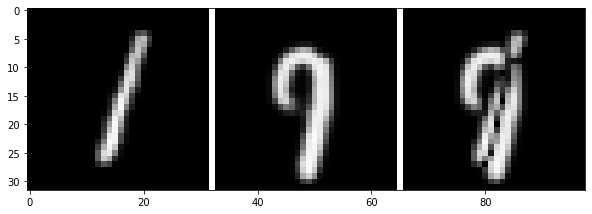

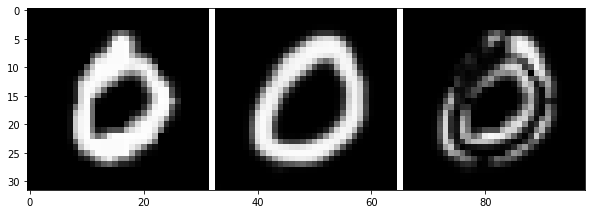

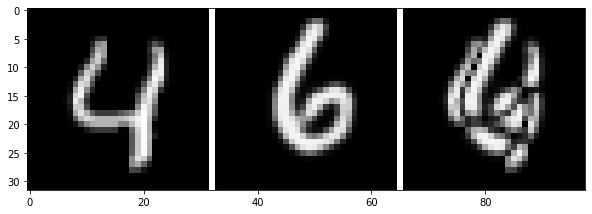

04/06/2020 12:27:24, epoch=31, step=3660, loss=0.54455, distortion=0.785, rate=0.009, -elbo=140.91408, nll=139.36792, KL=1.54615, commit_loss=34.11608, bit_usage=0.85339, highest_prob=0.035, temp=0.52925
reset code 189
04/06/2020 12:27:26, epoch=31, step=3680, loss=0.53389, distortion=0.770, rate=0.008, -elbo=138.13205, nll=136.63925, KL=1.49279, commit_loss=34.37379, bit_usage=0.85856, highest_prob=0.027, temp=0.52849
reset code 205
04/06/2020 12:27:29, epoch=31, step=3700, loss=0.52769, distortion=0.761, rate=0.008, -elbo=136.55289, nll=135.05183, KL=1.50105, commit_loss=34.26877, bit_usage=0.86051, highest_prob=0.027, temp=0.52774
reset code 32
04/06/2020 12:27:31, epoch=31, step=3720, loss=0.52237, distortion=0.753, rate=0.009, -elbo=135.21106, nll=133.69037, KL=1.52069, commit_loss=34.09663, bit_usage=0.86790, highest_prob=0.031, temp=0.52699
reset code 221
04/06/2020 12:27:33, epoch=31, step=3740, loss=0.52550, distortion=0.758, rate=0.009, -elbo=136.03737, nll=134.49203, KL=1.54

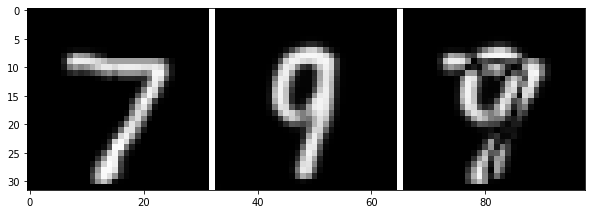

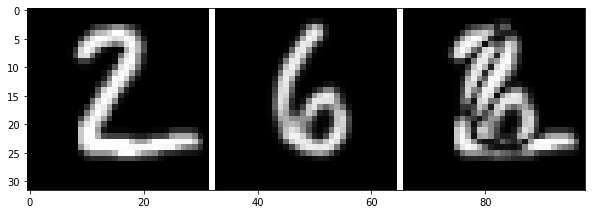

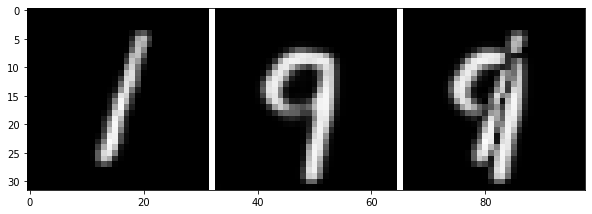

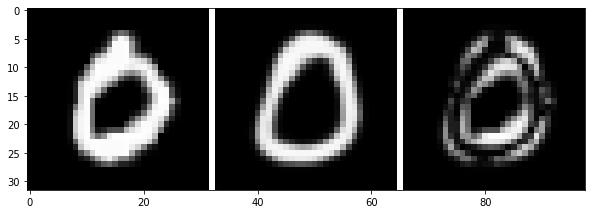

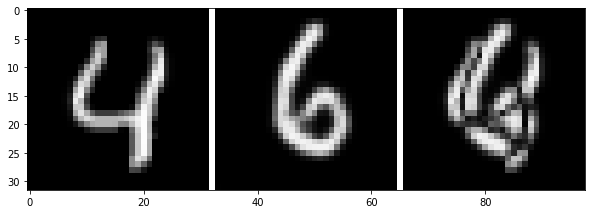

04/06/2020 12:28:31, epoch=36, step=4260, loss=0.51832, distortion=0.748, rate=0.008, -elbo=134.13058, nll=132.65372, KL=1.47686, commit_loss=34.24605, bit_usage=0.87987, highest_prob=0.021, temp=0.50667
reset code 224
04/06/2020 12:28:33, epoch=36, step=4280, loss=0.53703, distortion=0.775, rate=0.008, -elbo=138.88756, nll=137.44301, KL=1.44455, commit_loss=34.40346, bit_usage=0.87225, highest_prob=0.033, temp=0.50592
reset code 91
04/06/2020 12:28:35, epoch=36, step=4300, loss=0.52680, distortion=0.760, rate=0.008, -elbo=136.29814, nll=134.82527, KL=1.47287, commit_loss=34.45723, bit_usage=0.88055, highest_prob=0.023, temp=0.50517
reset code 107
04/06/2020 12:28:37, epoch=36, step=4320, loss=0.53119, distortion=0.766, rate=0.008, -elbo=137.39426, nll=135.94803, KL=1.44623, commit_loss=34.70323, bit_usage=0.87779, highest_prob=0.021, temp=0.50441
reset code 123
04/06/2020 12:28:39, epoch=36, step=4340, loss=0.52918, distortion=0.763, rate=0.008, -elbo=136.91953, nll=135.43497, KL=1.48

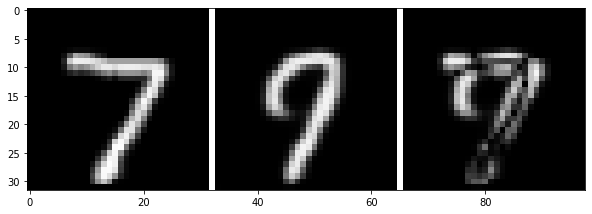

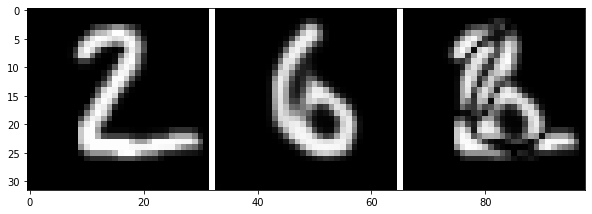

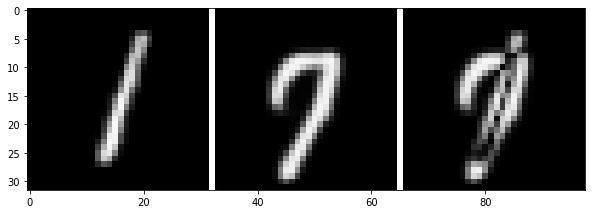

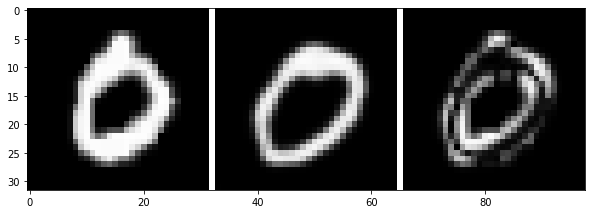

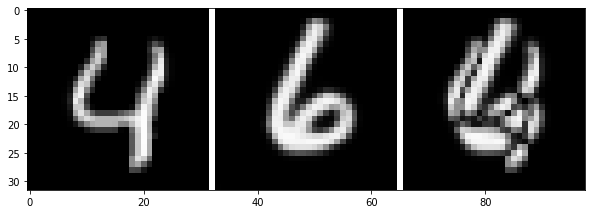

04/06/2020 12:29:33, epoch=41, step=4840, loss=0.47773, distortion=0.689, rate=0.011, -elbo=124.28271, nll=122.24493, KL=2.03778, commit_loss=51.20203, bit_usage=0.85147, highest_prob=0.041, temp=0.48485
reset code 228
04/06/2020 12:29:35, epoch=41, step=4860, loss=0.50966, distortion=0.735, rate=0.012, -elbo=132.53050, nll=130.41415, KL=2.11634, commit_loss=55.45397, bit_usage=0.85291, highest_prob=0.053, temp=0.48409
reset code 167
04/06/2020 12:29:37, epoch=41, step=4880, loss=0.46913, distortion=0.676, rate=0.012, -elbo=122.19248, nll=120.03891, KL=2.15357, commit_loss=57.36750, bit_usage=0.85840, highest_prob=0.049, temp=0.48334
reset code 183
04/06/2020 12:29:39, epoch=41, step=4900, loss=0.49994, distortion=0.721, rate=0.012, -elbo=130.04268, nll=127.92813, KL=2.11455, commit_loss=55.63789, bit_usage=0.85194, highest_prob=0.041, temp=0.48259
reset code 199
04/06/2020 12:29:41, epoch=41, step=4920, loss=0.49492, distortion=0.714, rate=0.012, -elbo=128.75807, nll=126.64413, KL=2.1

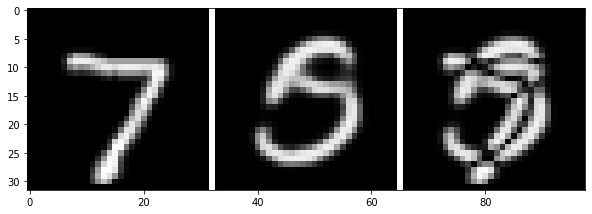

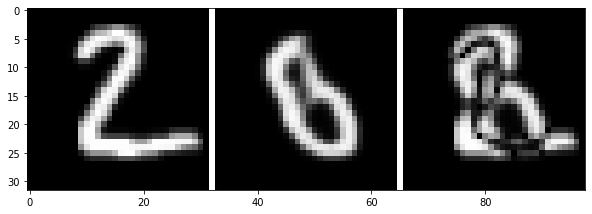

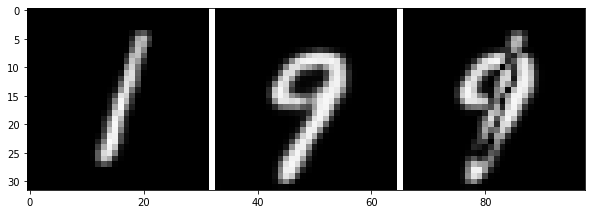

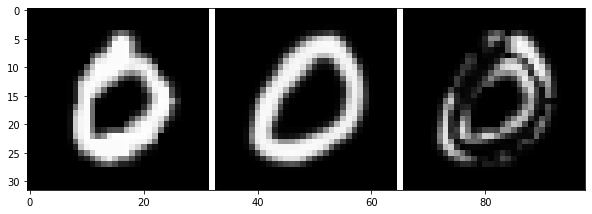

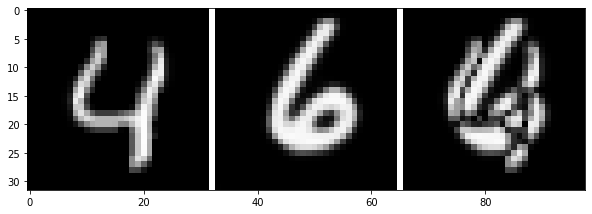

04/06/2020 12:30:38, epoch=46, step=5440, loss=0.47081, distortion=0.679, rate=0.014, -elbo=122.99477, nll=120.45950, KL=2.53527, commit_loss=65.97794, bit_usage=0.82344, highest_prob=0.049, temp=0.46227
reset code 123
04/06/2020 12:30:40, epoch=46, step=5460, loss=0.51091, distortion=0.737, rate=0.014, -elbo=133.14691, nll=130.72650, KL=2.42041, commit_loss=63.90274, bit_usage=0.83430, highest_prob=0.043, temp=0.46152
reset code 121
04/06/2020 12:30:42, epoch=46, step=5480, loss=0.48017, distortion=0.692, rate=0.014, -elbo=125.32642, nll=122.85570, KL=2.47073, commit_loss=65.17423, bit_usage=0.83515, highest_prob=0.041, temp=0.46077
reset code 207
04/06/2020 12:30:44, epoch=46, step=5500, loss=0.48796, distortion=0.704, rate=0.014, -elbo=127.37962, nll=124.84479, KL=2.53484, commit_loss=69.70843, bit_usage=0.83109, highest_prob=0.037, temp=0.46001
reset code 223
04/06/2020 12:30:46, epoch=46, step=5520, loss=0.47748, distortion=0.688, rate=0.014, -elbo=124.63793, nll=122.16921, KL=2.4

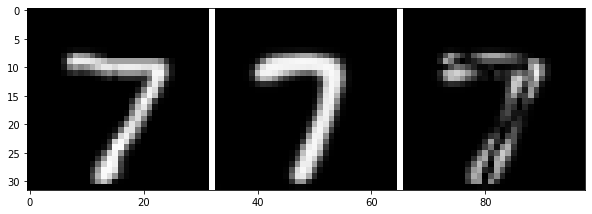

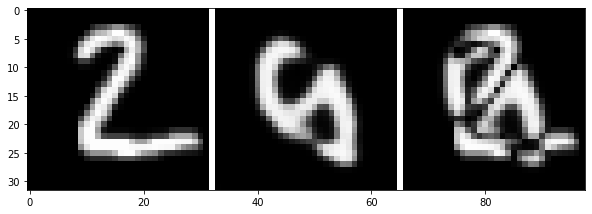

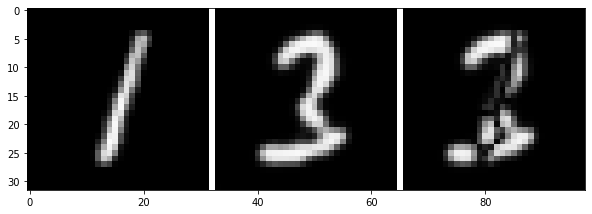

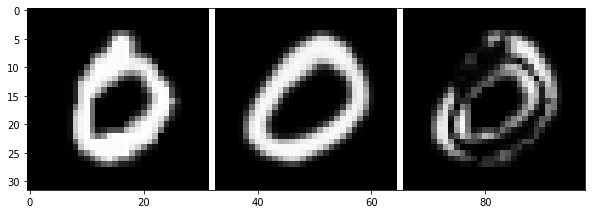

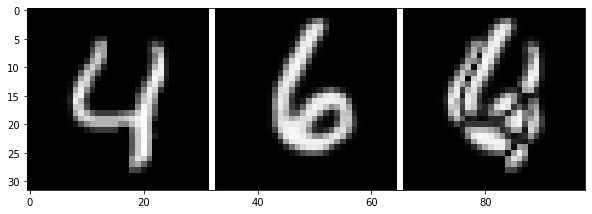

04/06/2020 12:31:41, epoch=51, step=6020, loss=0.44848, distortion=0.646, rate=0.019, -elbo=118.04137, nll=114.69867, KL=3.34271, commit_loss=108.59427, bit_usage=0.78745, highest_prob=0.041, temp=0.44045
reset code 47
04/06/2020 12:31:43, epoch=51, step=6040, loss=0.45288, distortion=0.653, rate=0.018, -elbo=119.09805, nll=115.82944, KL=3.26861, commit_loss=104.30212, bit_usage=0.78393, highest_prob=0.037, temp=0.43969
reset code 165
04/06/2020 12:31:45, epoch=51, step=6060, loss=0.46034, distortion=0.664, rate=0.018, -elbo=120.96581, nll=117.73856, KL=3.22725, commit_loss=104.30209, bit_usage=0.78890, highest_prob=0.035, temp=0.43894
reset code 136
04/06/2020 12:31:48, epoch=51, step=6080, loss=0.46389, distortion=0.669, rate=0.019, -elbo=121.96086, nll=118.64024, KL=3.32062, commit_loss=113.56552, bit_usage=0.77638, highest_prob=0.041, temp=0.43819
reset code 5
04/06/2020 12:31:50, epoch=51, step=6100, loss=0.46162, distortion=0.665, rate=0.019, -elbo=121.47963, nll=118.05246, KL=3.

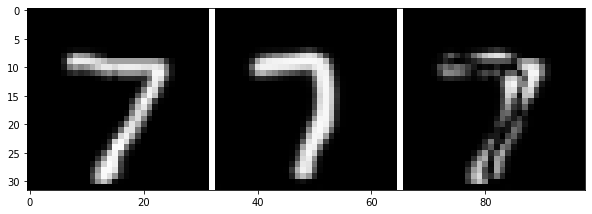

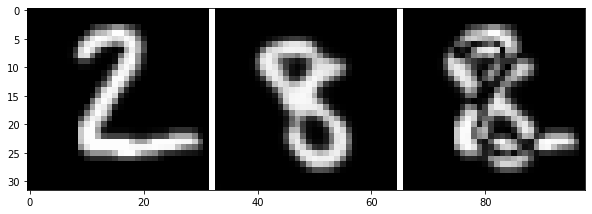

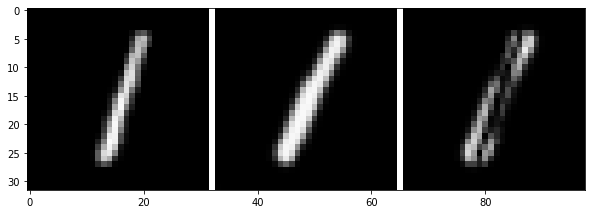

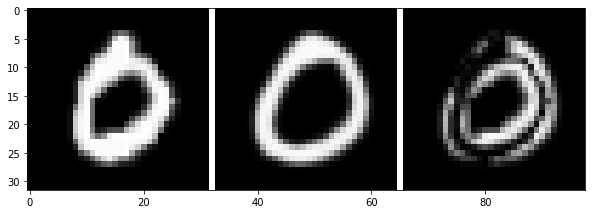

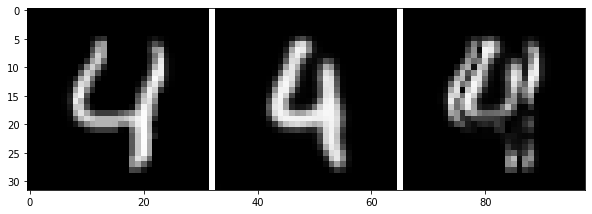

04/06/2020 12:32:46, epoch=56, step=6620, loss=0.39452, distortion=0.568, rate=0.024, -elbo=104.98428, nll=100.81088, KL=4.17339, commit_loss=182.61082, bit_usage=0.77625, highest_prob=0.039, temp=0.41787
reset code 108
04/06/2020 12:32:48, epoch=56, step=6640, loss=0.40530, distortion=0.584, rate=0.024, -elbo=107.78355, nll=103.55472, KL=4.22883, commit_loss=196.85904, bit_usage=0.76612, highest_prob=0.039, temp=0.41712
reset code 128
04/06/2020 12:32:50, epoch=56, step=6660, loss=0.41272, distortion=0.594, rate=0.023, -elbo=109.61568, nll=105.46661, KL=4.14906, commit_loss=185.08994, bit_usage=0.76412, highest_prob=0.047, temp=0.41637
reset code 104
04/06/2020 12:32:52, epoch=56, step=6680, loss=0.40356, distortion=0.581, rate=0.023, -elbo=107.28496, nll=103.11946, KL=4.16549, commit_loss=187.78555, bit_usage=0.77359, highest_prob=0.041, temp=0.41561
reset code 216
04/06/2020 12:32:54, epoch=56, step=6700, loss=0.41537, distortion=0.598, rate=0.024, -elbo=110.37251, nll=106.12567, KL

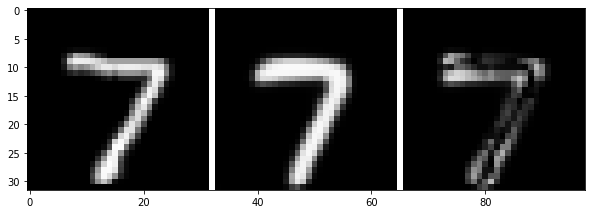

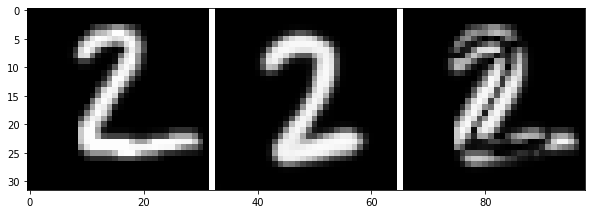

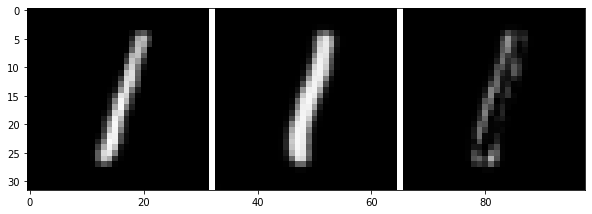

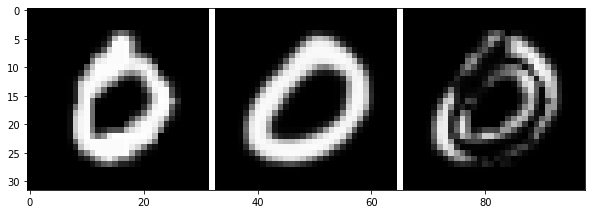

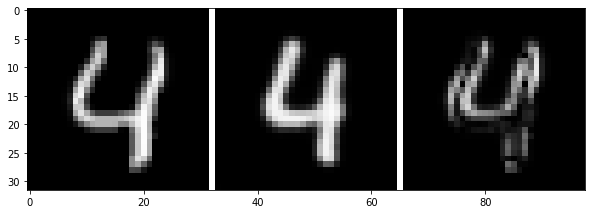

04/06/2020 12:33:49, epoch=61, step=7200, loss=0.37451, distortion=0.539, rate=0.026, -elbo=100.11031, nll=95.56087, KL=4.54944, commit_loss=309.52557, bit_usage=0.80863, highest_prob=0.027, temp=0.39605
reset code 44
04/06/2020 12:33:51, epoch=61, step=7220, loss=0.37880, distortion=0.545, rate=0.026, -elbo=101.27248, nll=96.66814, KL=4.60435, commit_loss=299.29337, bit_usage=0.78269, highest_prob=0.031, temp=0.39529
reset code 76
04/06/2020 12:33:53, epoch=61, step=7240, loss=0.36479, distortion=0.524, rate=0.026, -elbo=97.59018, nll=93.06166, KL=4.52852, commit_loss=320.19360, bit_usage=0.80669, highest_prob=0.029, temp=0.39454
reset code 74
04/06/2020 12:33:55, epoch=61, step=7260, loss=0.36752, distortion=0.528, rate=0.026, -elbo=98.28236, nll=93.73173, KL=4.55063, commit_loss=348.59119, bit_usage=0.80506, highest_prob=0.027, temp=0.39379
reset code 2
04/06/2020 12:33:57, epoch=61, step=7280, loss=0.37128, distortion=0.534, rate=0.026, -elbo=99.28165, nll=94.72334, KL=4.55831, com

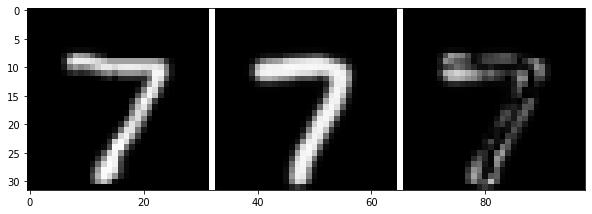

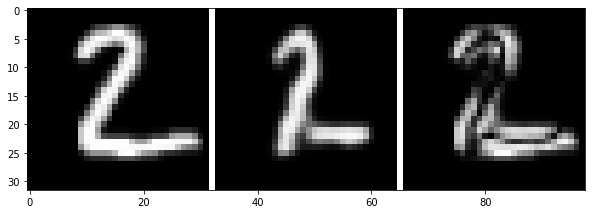

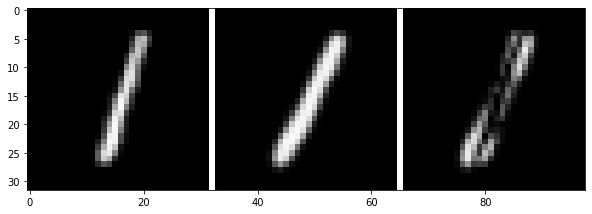

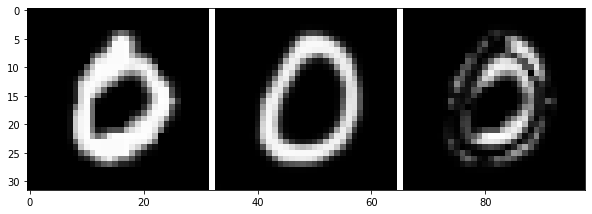

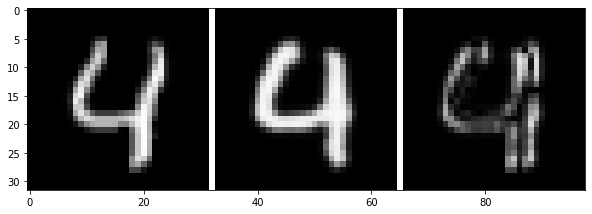

04/06/2020 12:34:54, epoch=66, step=7800, loss=0.33910, distortion=0.487, rate=0.026, -elbo=91.05195, nll=86.37285, KL=4.67910, commit_loss=431.15576, bit_usage=0.83090, highest_prob=0.027, temp=0.37347
reset code 42
04/06/2020 12:34:56, epoch=66, step=7820, loss=0.34934, distortion=0.501, rate=0.026, -elbo=93.67371, nll=88.97200, KL=4.70172, commit_loss=453.33389, bit_usage=0.82384, highest_prob=0.023, temp=0.37272
reset code 152
04/06/2020 12:34:58, epoch=66, step=7840, loss=0.35707, distortion=0.513, rate=0.027, -elbo=95.67782, nll=90.94476, KL=4.73306, commit_loss=459.30057, bit_usage=0.82620, highest_prob=0.031, temp=0.37197
reset code 72
04/06/2020 12:35:00, epoch=66, step=7860, loss=0.35535, distortion=0.510, rate=0.026, -elbo=95.19842, nll=90.51519, KL=4.68323, commit_loss=448.71106, bit_usage=0.83068, highest_prob=0.023, temp=0.37121
reset code 36
04/06/2020 12:35:02, epoch=66, step=7880, loss=0.35499, distortion=0.510, rate=0.027, -elbo=95.16167, nll=90.41139, KL=4.75028, com

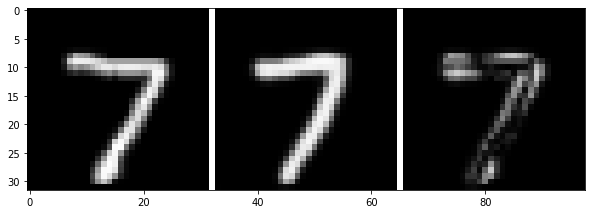

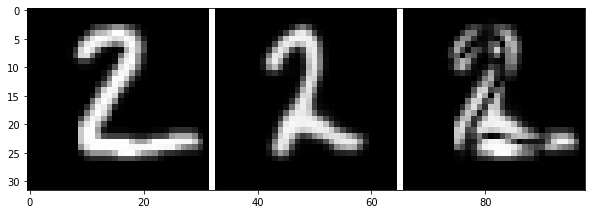

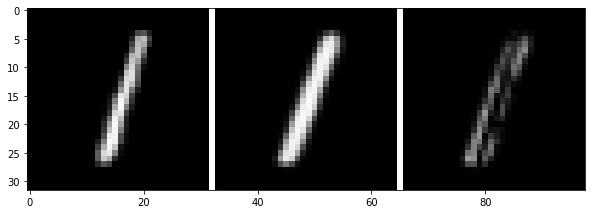

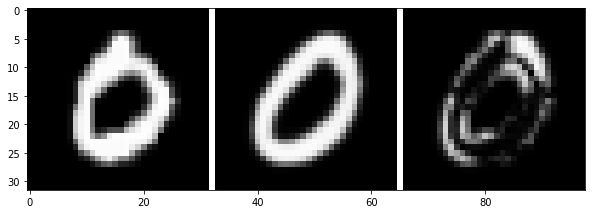

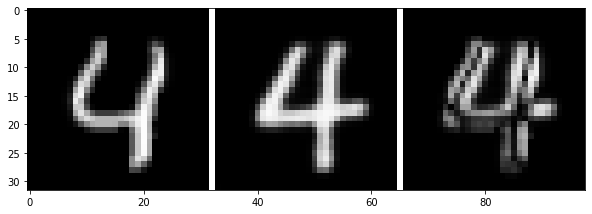

04/06/2020 12:35:57, epoch=71, step=8380, loss=0.35576, distortion=0.510, rate=0.027, -elbo=95.34904, nll=90.56213, KL=4.78690, commit_loss=508.67905, bit_usage=0.85736, highest_prob=0.023, temp=0.35165
reset code 176
04/06/2020 12:35:59, epoch=71, step=8400, loss=0.33915, distortion=0.486, rate=0.027, -elbo=91.05442, nll=86.31451, KL=4.73991, commit_loss=502.96765, bit_usage=0.85154, highest_prob=0.025, temp=0.35089
reset code 30
04/06/2020 12:36:01, epoch=71, step=8420, loss=0.34465, distortion=0.494, rate=0.027, -elbo=92.42213, nll=87.68225, KL=4.73988, commit_loss=542.19830, bit_usage=0.85104, highest_prob=0.021, temp=0.35014
reset code 6
04/06/2020 12:36:03, epoch=71, step=8440, loss=0.31936, distortion=0.458, rate=0.027, -elbo=86.00610, nll=81.19900, KL=4.80710, commit_loss=552.25049, bit_usage=0.84854, highest_prob=0.021, temp=0.34939
reset code 148
04/06/2020 12:36:05, epoch=71, step=8460, loss=0.34468, distortion=0.494, rate=0.027, -elbo=92.48357, nll=87.67872, KL=4.80485, com

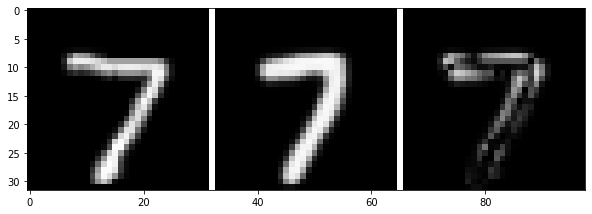

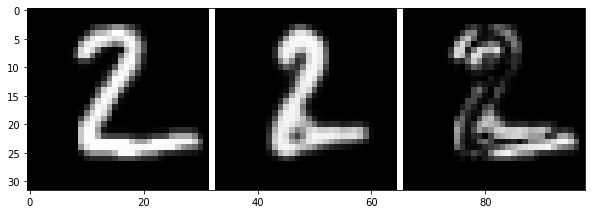

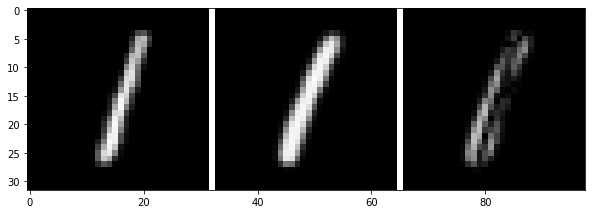

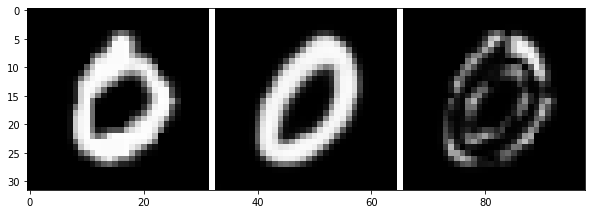

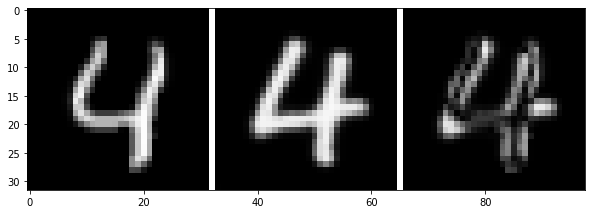

04/06/2020 12:37:02, epoch=76, step=8980, loss=0.32214, distortion=0.461, rate=0.027, -elbo=86.68668, nll=81.86377, KL=4.82292, commit_loss=600.14032, bit_usage=0.86930, highest_prob=0.031, temp=0.32907
reset code 17
04/06/2020 12:37:04, epoch=76, step=9000, loss=0.33391, distortion=0.478, rate=0.027, -elbo=89.72134, nll=84.86613, KL=4.85520, commit_loss=609.08105, bit_usage=0.87789, highest_prob=0.021, temp=0.32832
reset code 72
04/06/2020 12:37:06, epoch=76, step=9020, loss=0.34928, distortion=0.501, rate=0.027, -elbo=93.69990, nll=88.85199, KL=4.84791, commit_loss=560.12195, bit_usage=0.87363, highest_prob=0.020, temp=0.32757
reset code 209
04/06/2020 12:37:08, epoch=76, step=9040, loss=0.31621, distortion=0.453, rate=0.027, -elbo=85.21391, nll=80.37219, KL=4.84172, commit_loss=572.88470, bit_usage=0.85998, highest_prob=0.029, temp=0.32681
reset code 225
04/06/2020 12:37:11, epoch=76, step=9060, loss=0.32539, distortion=0.466, rate=0.027, -elbo=87.53783, nll=82.71764, KL=4.82020, co

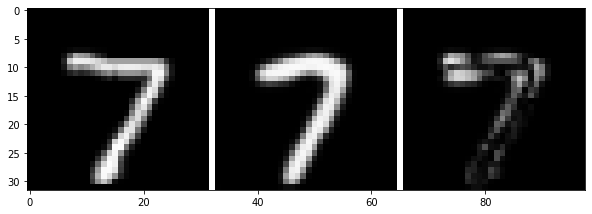

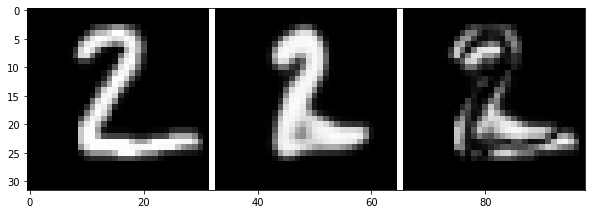

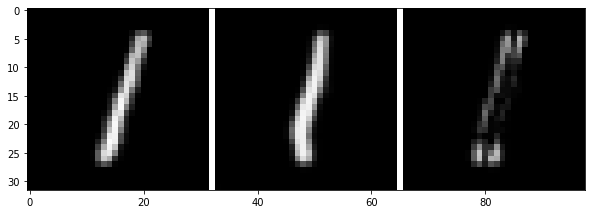

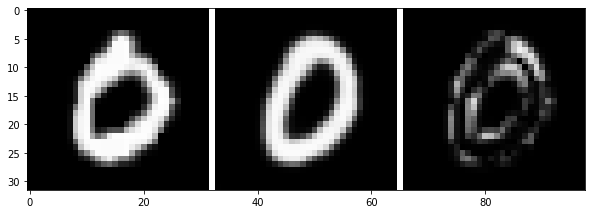

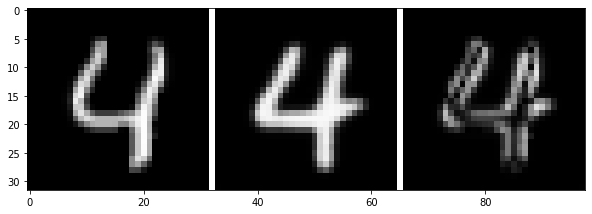

04/06/2020 12:38:05, epoch=81, step=9560, loss=0.31411, distortion=0.449, rate=0.027, -elbo=84.61310, nll=79.75062, KL=4.86248, commit_loss=657.43915, bit_usage=0.88841, highest_prob=0.020, temp=0.30725
reset code 85
04/06/2020 12:38:07, epoch=81, step=9580, loss=0.31929, distortion=0.457, rate=0.027, -elbo=85.95418, nll=81.09784, KL=4.85634, commit_loss=636.72949, bit_usage=0.89300, highest_prob=0.020, temp=0.30649
reset code 206
04/06/2020 12:38:10, epoch=81, step=9600, loss=0.32112, distortion=0.460, rate=0.027, -elbo=86.36756, nll=81.54463, KL=4.82293, commit_loss=657.41907, bit_usage=0.89325, highest_prob=0.020, temp=0.30574
reset code 101
04/06/2020 12:38:12, epoch=81, step=9620, loss=0.31114, distortion=0.445, rate=0.027, -elbo=83.83227, nll=78.97736, KL=4.85491, commit_loss=668.83984, bit_usage=0.89179, highest_prob=0.018, temp=0.30499
reset code 149
04/06/2020 12:38:14, epoch=81, step=9640, loss=0.32129, distortion=0.460, rate=0.027, -elbo=86.45724, nll=81.60622, KL=4.85102, c

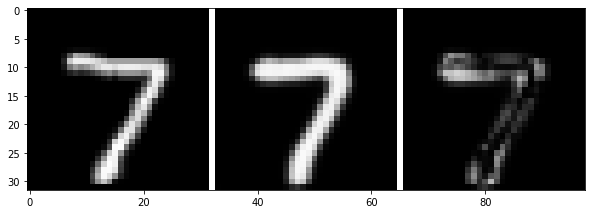

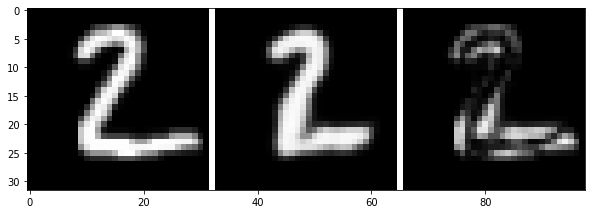

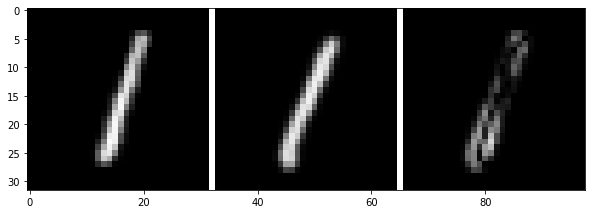

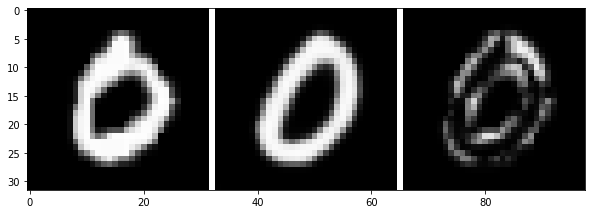

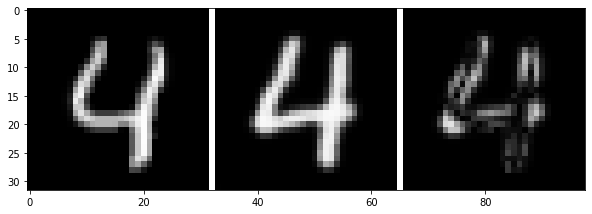

04/06/2020 12:39:10, epoch=86, step=10160, loss=0.31586, distortion=0.452, rate=0.027, -elbo=85.02200, nll=80.16905, KL=4.85295, commit_loss=686.61096, bit_usage=0.89893, highest_prob=0.018, temp=0.28467
reset code 176
04/06/2020 12:39:12, epoch=86, step=10180, loss=0.31659, distortion=0.453, rate=0.028, -elbo=85.26441, nll=80.36538, KL=4.89903, commit_loss=677.29407, bit_usage=0.91618, highest_prob=0.018, temp=0.28392
reset code 205
04/06/2020 12:39:14, epoch=86, step=10200, loss=0.31823, distortion=0.455, rate=0.028, -elbo=85.65714, nll=80.74900, KL=4.90815, commit_loss=712.99805, bit_usage=0.90476, highest_prob=0.016, temp=0.28317
reset code 154
04/06/2020 12:39:16, epoch=86, step=10220, loss=0.29969, distortion=0.428, rate=0.028, -elbo=80.89903, nll=76.00066, KL=4.89838, commit_loss=714.74170, bit_usage=0.90220, highest_prob=0.018, temp=0.28241
reset code 97
04/06/2020 12:39:18, epoch=86, step=10240, loss=0.30544, distortion=0.437, rate=0.027, -elbo=82.34088, nll=77.50441, KL=4.836

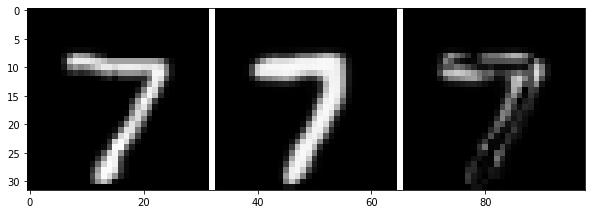

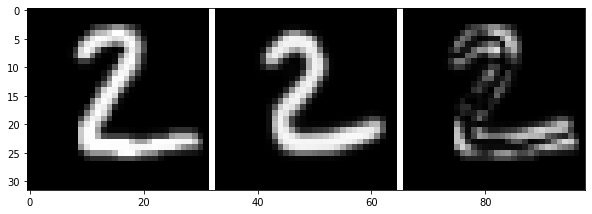

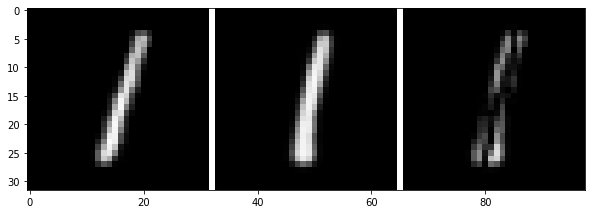

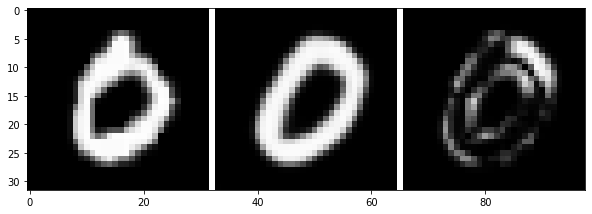

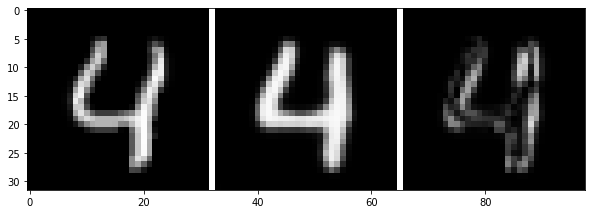

04/06/2020 12:40:13, epoch=91, step=10740, loss=0.31035, distortion=0.444, rate=0.027, -elbo=83.56252, nll=78.69852, KL=4.86400, commit_loss=745.58545, bit_usage=0.90747, highest_prob=0.018, temp=0.26285
reset code 3
04/06/2020 12:40:15, epoch=91, step=10760, loss=0.29921, distortion=0.428, rate=0.028, -elbo=80.82030, nll=75.88332, KL=4.93699, commit_loss=710.03412, bit_usage=0.91734, highest_prob=0.018, temp=0.26209
reset code 149
04/06/2020 12:40:17, epoch=91, step=10780, loss=0.29157, distortion=0.417, rate=0.028, -elbo=78.80914, nll=73.90997, KL=4.89917, commit_loss=727.05554, bit_usage=0.90933, highest_prob=0.016, temp=0.26134
reset code 220
04/06/2020 12:40:19, epoch=91, step=10800, loss=0.30073, distortion=0.430, rate=0.028, -elbo=81.20060, nll=76.26379, KL=4.93681, commit_loss=717.77759, bit_usage=0.91251, highest_prob=0.014, temp=0.26059
reset code 19
04/06/2020 12:40:21, epoch=91, step=10820, loss=0.30014, distortion=0.429, rate=0.028, -elbo=81.01035, nll=76.08075, KL=4.92961

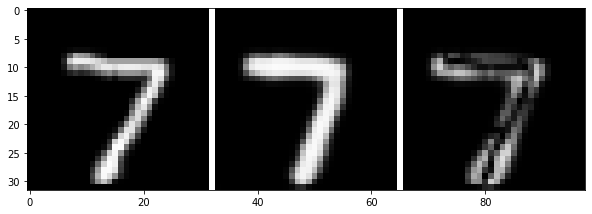

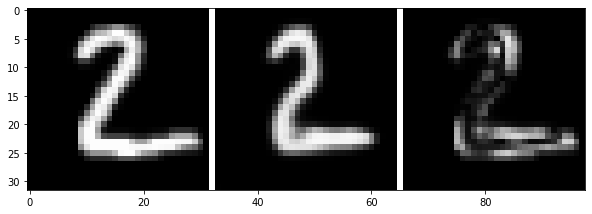

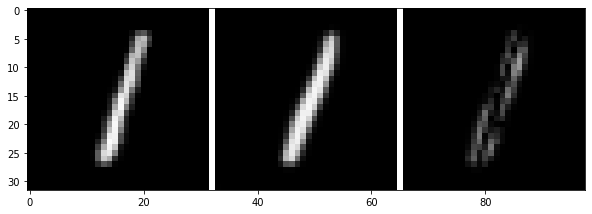

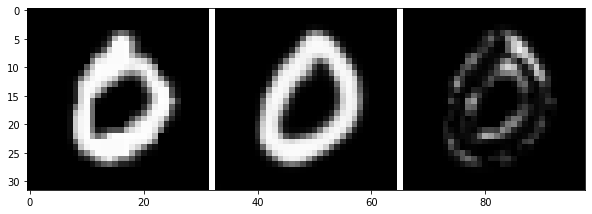

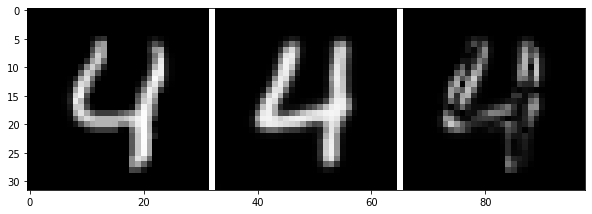

04/06/2020 12:41:18, epoch=96, step=11340, loss=0.30761, distortion=0.439, rate=0.028, -elbo=82.89055, nll=77.96129, KL=4.92926, commit_loss=781.91199, bit_usage=0.92075, highest_prob=0.018, temp=0.24027
reset code 71
04/06/2020 12:41:20, epoch=96, step=11360, loss=0.29322, distortion=0.419, rate=0.028, -elbo=79.22382, nll=74.30133, KL=4.92250, commit_loss=759.27283, bit_usage=0.92311, highest_prob=0.018, temp=0.23952
reset code 87
04/06/2020 12:41:22, epoch=96, step=11380, loss=0.30041, distortion=0.429, rate=0.028, -elbo=81.10252, nll=76.12274, KL=4.97978, commit_loss=778.32959, bit_usage=0.91629, highest_prob=0.021, temp=0.23877
reset code 67
04/06/2020 12:41:24, epoch=96, step=11400, loss=0.31477, distortion=0.450, rate=0.028, -elbo=84.73540, nll=79.80206, KL=4.93335, commit_loss=773.91663, bit_usage=0.92140, highest_prob=0.018, temp=0.23801
reset code 7
04/06/2020 12:41:27, epoch=96, step=11420, loss=0.29978, distortion=0.428, rate=0.028, -elbo=80.89512, nll=75.95190, KL=4.94321, 

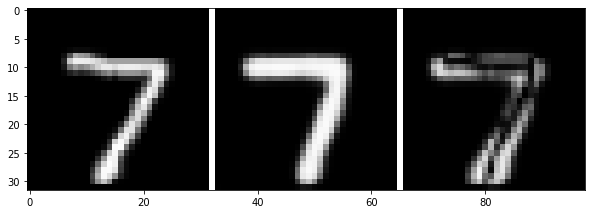

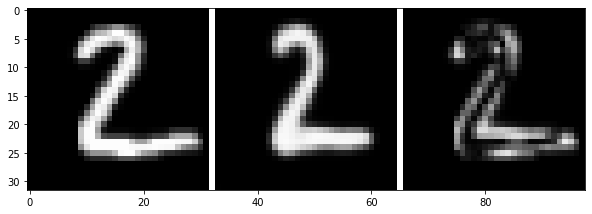

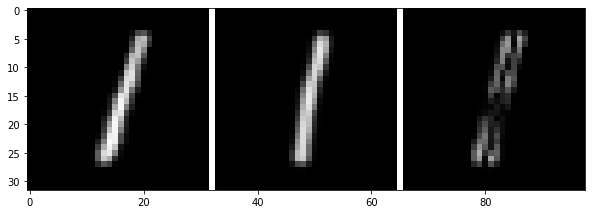

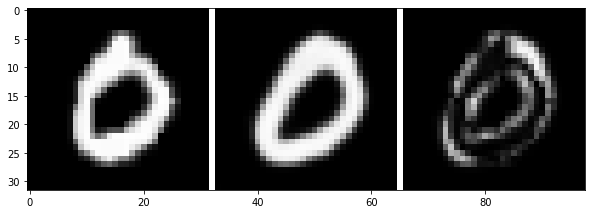

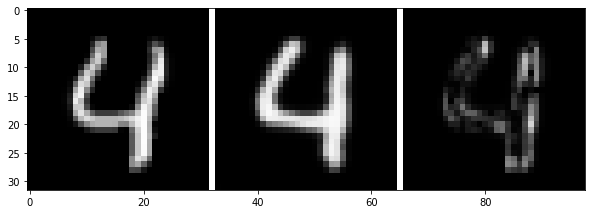

04/06/2020 12:42:21, epoch=101, step=11920, loss=0.30565, distortion=0.436, rate=0.028, -elbo=82.36842, nll=77.39636, KL=4.97205, commit_loss=843.82239, bit_usage=0.92551, highest_prob=0.016, temp=0.21845
reset code 111
04/06/2020 12:42:23, epoch=101, step=11940, loss=0.30381, distortion=0.433, rate=0.028, -elbo=81.86965, nll=76.91046, KL=4.95919, commit_loss=858.93732, bit_usage=0.91523, highest_prob=0.020, temp=0.21769
reset code 127
04/06/2020 12:42:25, epoch=101, step=11960, loss=0.29487, distortion=0.421, rate=0.028, -elbo=79.63521, nll=74.66415, KL=4.97106, commit_loss=816.81555, bit_usage=0.91598, highest_prob=0.018, temp=0.21694
reset code 122
04/06/2020 12:42:27, epoch=101, step=11980, loss=0.29077, distortion=0.415, rate=0.028, -elbo=78.61242, nll=73.65551, KL=4.95691, commit_loss=777.39771, bit_usage=0.92821, highest_prob=0.020, temp=0.21619
reset code 240
04/06/2020 12:42:29, epoch=101, step=12000, loss=0.29294, distortion=0.418, rate=0.028, -elbo=79.17077, nll=74.20368, KL

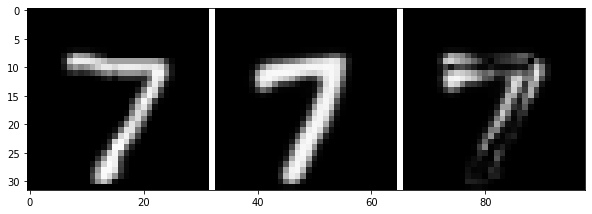

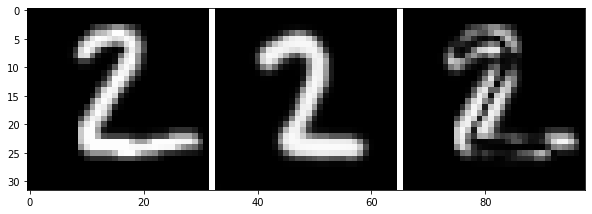

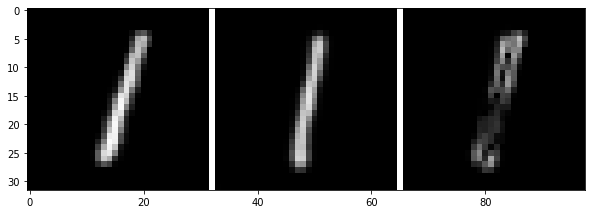

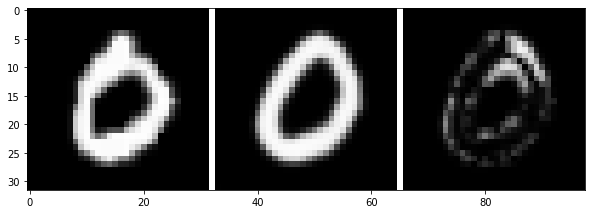

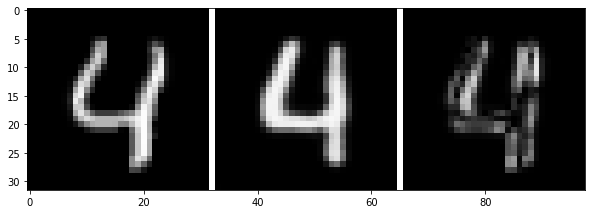

04/06/2020 12:43:26, epoch=106, step=12520, loss=0.28080, distortion=0.400, rate=0.028, -elbo=76.01902, nll=71.01997, KL=4.99904, commit_loss=860.43372, bit_usage=0.92715, highest_prob=0.016, temp=0.19587
04/06/2020 12:43:29, epoch=106, step=12540, loss=0.28037, distortion=0.400, rate=0.028, -elbo=75.93752, nll=70.93131, KL=5.00621, commit_loss=838.32251, bit_usage=0.93360, highest_prob=0.021, temp=0.19512
reset code 103
04/06/2020 12:43:31, epoch=106, step=12560, loss=0.28552, distortion=0.407, rate=0.028, -elbo=77.29623, nll=72.26355, KL=5.03268, commit_loss=824.02014, bit_usage=0.93776, highest_prob=0.020, temp=0.19437
04/06/2020 12:43:33, epoch=106, step=12580, loss=0.30147, distortion=0.430, rate=0.028, -elbo=81.36092, nll=76.34424, KL=5.01668, commit_loss=828.29968, bit_usage=0.93178, highest_prob=0.018, temp=0.19361
04/06/2020 12:43:35, epoch=106, step=12600, loss=0.28737, distortion=0.410, rate=0.028, -elbo=77.74238, nll=72.72152, KL=5.02086, commit_loss=841.07385, bit_usage=0.

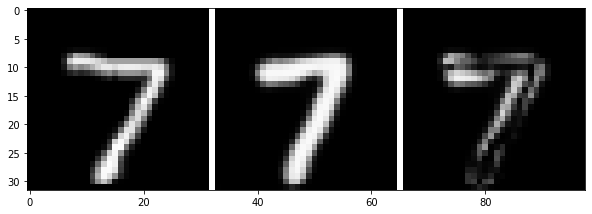

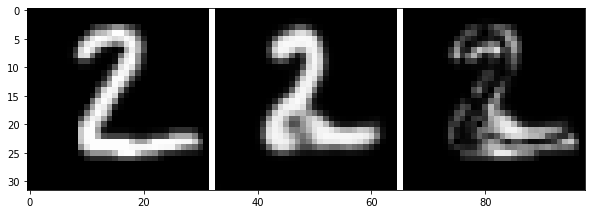

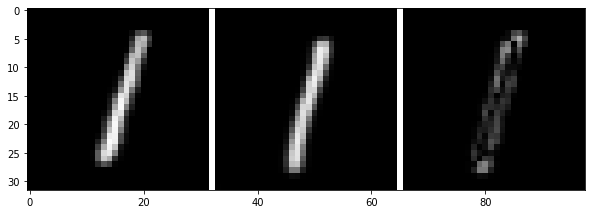

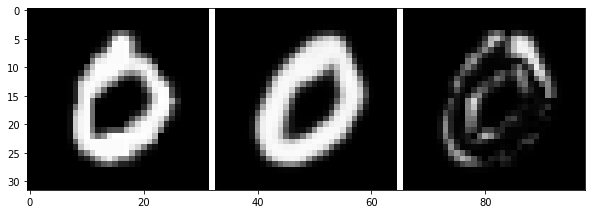

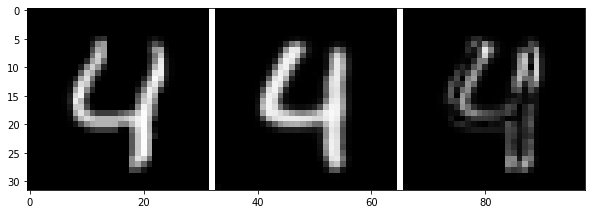

04/06/2020 12:44:32, epoch=111, step=13100, loss=0.28882, distortion=0.412, rate=0.029, -elbo=78.11243, nll=73.04157, KL=5.07086, commit_loss=890.48608, bit_usage=0.92751, highest_prob=0.016, temp=0.17405
04/06/2020 12:44:34, epoch=111, step=13120, loss=0.29948, distortion=0.427, rate=0.029, -elbo=80.80040, nll=75.73685, KL=5.06354, commit_loss=925.58905, bit_usage=0.92947, highest_prob=0.014, temp=0.17329
04/06/2020 12:44:36, epoch=111, step=13140, loss=0.29977, distortion=0.427, rate=0.028, -elbo=80.88152, nll=75.85275, KL=5.02877, commit_loss=882.97296, bit_usage=0.92966, highest_prob=0.018, temp=0.17254
reset code 23
04/06/2020 12:44:38, epoch=111, step=13160, loss=0.28232, distortion=0.402, rate=0.029, -elbo=76.43991, nll=71.37051, KL=5.06940, commit_loss=899.01825, bit_usage=0.92656, highest_prob=0.014, temp=0.17179
04/06/2020 12:44:40, epoch=111, step=13180, loss=0.29139, distortion=0.415, rate=0.028, -elbo=78.75662, nll=73.70130, KL=5.05532, commit_loss=890.04907, bit_usage=0.9

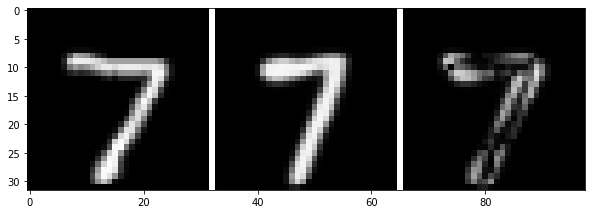

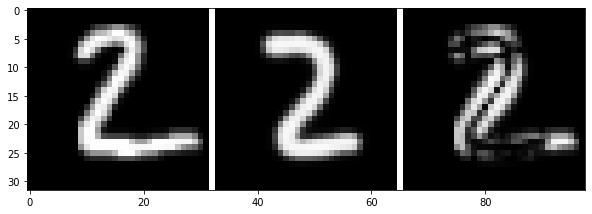

04/06/2020 12:45:36, epoch=116, step=13700, loss=0.27788, distortion=0.396, rate=0.029, -elbo=75.29121, nll=70.21680, KL=5.07441, commit_loss=914.21704, bit_usage=0.93097, highest_prob=0.020, temp=0.15147
04/06/2020 12:45:38, epoch=116, step=13720, loss=0.28663, distortion=0.408, rate=0.029, -elbo=77.52406, nll=72.45515, KL=5.06891, commit_loss=916.10645, bit_usage=0.92608, highest_prob=0.018, temp=0.15072
04/06/2020 12:45:40, epoch=116, step=13740, loss=0.28241, distortion=0.402, rate=0.029, -elbo=76.44744, nll=71.37853, KL=5.06891, commit_loss=912.25476, bit_usage=0.94472, highest_prob=0.014, temp=0.14997
04/06/2020 12:45:42, epoch=116, step=13760, loss=0.28442, distortion=0.405, rate=0.029, -elbo=77.00324, nll=71.91949, KL=5.08376, commit_loss=887.80139, bit_usage=0.92696, highest_prob=0.018, temp=0.14921
04/06/2020 12:45:44, epoch=116, step=13780, loss=0.27784, distortion=0.396, rate=0.028, -elbo=75.25860, nll=70.22702, KL=5.03158, commit_loss=895.88220, bit_usage=0.93574, highest_

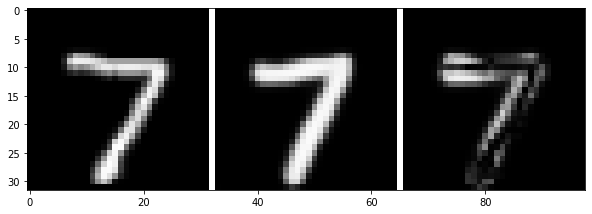

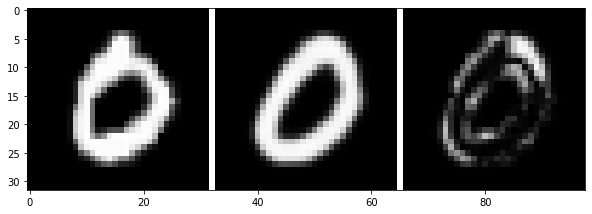

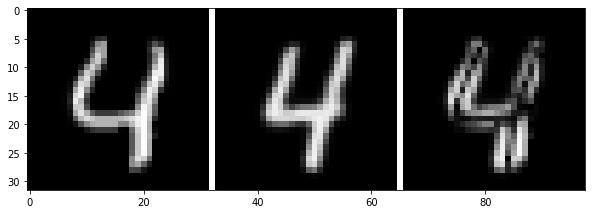

04/06/2020 12:46:38, epoch=121, step=14280, loss=0.28502, distortion=0.406, rate=0.029, -elbo=77.18053, nll=72.08087, KL=5.09966, commit_loss=879.91315, bit_usage=0.93468, highest_prob=0.016, temp=0.12965
04/06/2020 12:46:40, epoch=121, step=14300, loss=0.27381, distortion=0.390, rate=0.029, -elbo=74.34052, nll=69.22839, KL=5.11212, commit_loss=861.08179, bit_usage=0.92925, highest_prob=0.016, temp=0.12889
04/06/2020 12:46:42, epoch=121, step=14320, loss=0.29609, distortion=0.422, rate=0.029, -elbo=80.01555, nll=74.91083, KL=5.10472, commit_loss=882.22363, bit_usage=0.94361, highest_prob=0.018, temp=0.12814
04/06/2020 12:46:44, epoch=121, step=14340, loss=0.27899, distortion=0.398, rate=0.029, -elbo=75.65289, nll=70.54585, KL=5.10704, commit_loss=870.87537, bit_usage=0.94727, highest_prob=0.016, temp=0.12739
04/06/2020 12:46:46, epoch=121, step=14360, loss=0.28650, distortion=0.408, rate=0.029, -elbo=77.51561, nll=72.42152, KL=5.09408, commit_loss=916.95728, bit_usage=0.93187, highest_

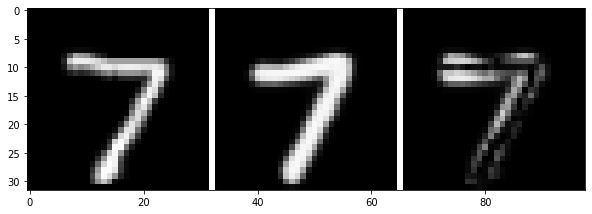

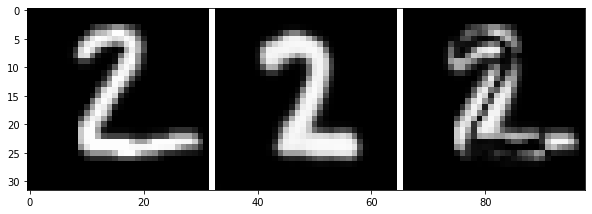

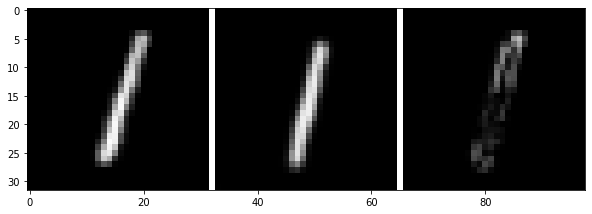

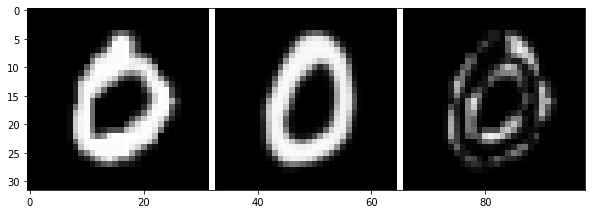

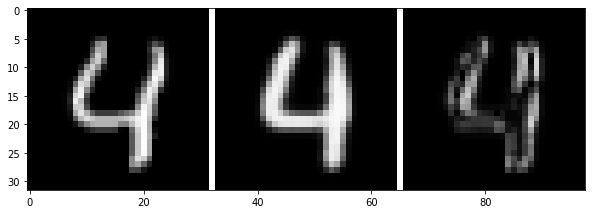

04/06/2020 12:47:44, epoch=126, step=14880, loss=0.27054, distortion=0.385, rate=0.029, -elbo=73.44512, nll=68.34280, KL=5.10232, commit_loss=909.56989, bit_usage=0.93611, highest_prob=0.021, temp=0.10707
04/06/2020 12:47:46, epoch=126, step=14900, loss=0.29222, distortion=0.416, rate=0.029, -elbo=78.98894, nll=73.87683, KL=5.11210, commit_loss=925.31433, bit_usage=0.94198, highest_prob=0.016, temp=0.10632
reset code 127
04/06/2020 12:47:48, epoch=126, step=14920, loss=0.29078, distortion=0.414, rate=0.029, -elbo=78.61671, nll=73.49945, KL=5.11726, commit_loss=935.36450, bit_usage=0.93504, highest_prob=0.020, temp=0.10557
04/06/2020 12:47:50, epoch=126, step=14940, loss=0.28066, distortion=0.400, rate=0.029, -elbo=76.03353, nll=70.91956, KL=5.11397, commit_loss=923.89740, bit_usage=0.92192, highest_prob=0.023, temp=0.10481
reset code 97
04/06/2020 12:47:52, epoch=126, step=14960, loss=0.29343, distortion=0.418, rate=0.029, -elbo=79.29963, nll=74.20867, KL=5.09096, commit_loss=903.36310

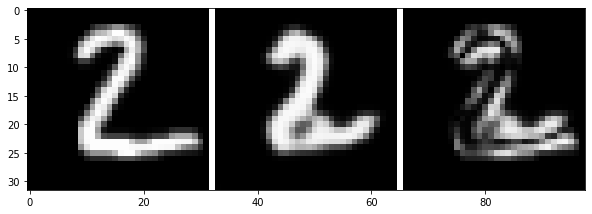

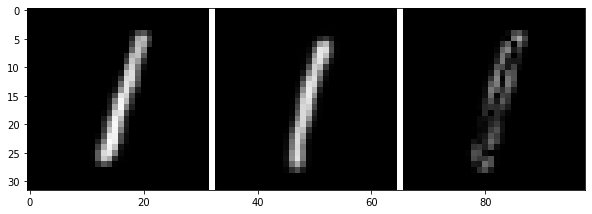

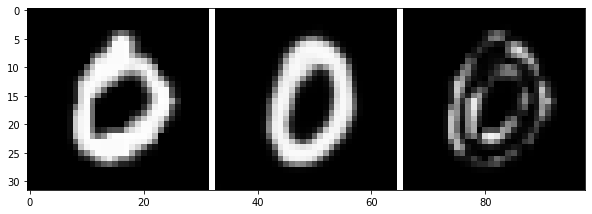

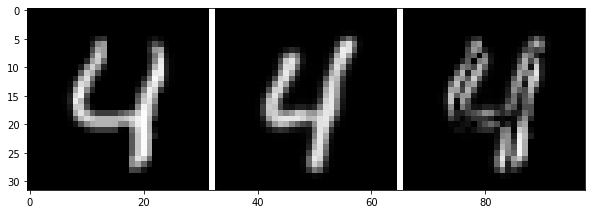

04/06/2020 12:48:52, epoch=131, step=15460, loss=0.28081, distortion=0.400, rate=0.029, -elbo=76.05512, nll=70.94656, KL=5.10856, commit_loss=935.57678, bit_usage=0.93293, highest_prob=0.020, temp=0.08525
04/06/2020 12:48:54, epoch=131, step=15480, loss=0.27484, distortion=0.391, rate=0.029, -elbo=74.50054, nll=69.42075, KL=5.07979, commit_loss=932.74438, bit_usage=0.93879, highest_prob=0.014, temp=0.08449
04/06/2020 12:48:56, epoch=131, step=15500, loss=0.27489, distortion=0.391, rate=0.029, -elbo=74.56474, nll=69.43497, KL=5.12977, commit_loss=931.77368, bit_usage=0.92411, highest_prob=0.018, temp=0.08374
reset code 164
04/06/2020 12:48:58, epoch=131, step=15520, loss=0.28196, distortion=0.402, rate=0.029, -elbo=76.40715, nll=71.26820, KL=5.13894, commit_loss=907.32520, bit_usage=0.93196, highest_prob=0.016, temp=0.08299
04/06/2020 12:49:00, epoch=131, step=15540, loss=0.28399, distortion=0.405, rate=0.029, -elbo=76.89938, nll=71.78671, KL=5.11267, commit_loss=908.51794, bit_usage=0.

04/06/2020 12:49:58, epoch=136, step=16060, loss=0.28029, distortion=0.399, rate=0.029, -elbo=75.94798, nll=70.83361, KL=5.11437, commit_loss=914.80859, bit_usage=0.94589, highest_prob=0.014, temp=0.06267
04/06/2020 12:50:00, epoch=136, step=16080, loss=0.27602, distortion=0.393, rate=0.029, -elbo=74.85490, nll=69.74695, KL=5.10795, commit_loss=908.45496, bit_usage=0.93423, highest_prob=0.016, temp=0.06192
04/06/2020 12:50:02, epoch=136, step=16100, loss=0.26871, distortion=0.382, rate=0.029, -elbo=72.99175, nll=67.87096, KL=5.12079, commit_loss=914.93518, bit_usage=0.92951, highest_prob=0.018, temp=0.06117
04/06/2020 12:50:04, epoch=136, step=16120, loss=0.27546, distortion=0.392, rate=0.029, -elbo=74.75999, nll=69.63290, KL=5.12709, commit_loss=879.91028, bit_usage=0.93577, highest_prob=0.016, temp=0.06041
04/06/2020 12:50:06, epoch=136, step=16140, loss=0.27660, distortion=0.394, rate=0.029, -elbo=74.99622, nll=69.88625, KL=5.10997, commit_loss=918.54517, bit_usage=0.93567, highest_

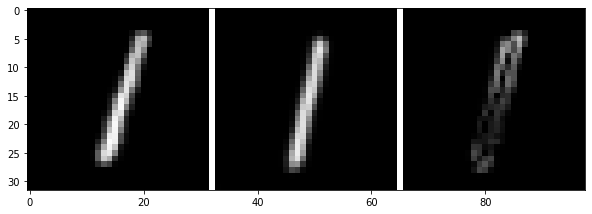

04/06/2020 12:50:59, epoch=141, step=16640, loss=0.27443, distortion=0.391, rate=0.029, -elbo=74.46027, nll=69.31854, KL=5.14172, commit_loss=929.44702, bit_usage=0.94196, highest_prob=0.016, temp=0.04085
04/06/2020 12:51:02, epoch=141, step=16660, loss=0.27415, distortion=0.390, rate=0.029, -elbo=74.36644, nll=69.24667, KL=5.11976, commit_loss=931.32349, bit_usage=0.94812, highest_prob=0.016, temp=0.04009
04/06/2020 12:51:04, epoch=141, step=16680, loss=0.27434, distortion=0.391, rate=0.029, -elbo=74.45260, nll=69.33326, KL=5.11934, commit_loss=892.10791, bit_usage=0.93714, highest_prob=0.016, temp=0.03934
04/06/2020 12:51:06, epoch=141, step=16700, loss=0.29146, distortion=0.415, rate=0.029, -elbo=78.80065, nll=73.69555, KL=5.10510, commit_loss=912.62433, bit_usage=0.93439, highest_prob=0.023, temp=0.03859
04/06/2020 12:51:08, epoch=141, step=16720, loss=0.27980, distortion=0.398, rate=0.029, -elbo=75.79884, nll=70.69228, KL=5.10657, commit_loss=930.54065, bit_usage=0.94628, highest_

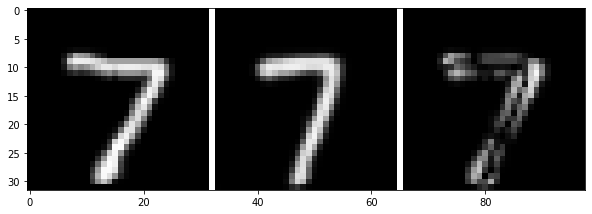

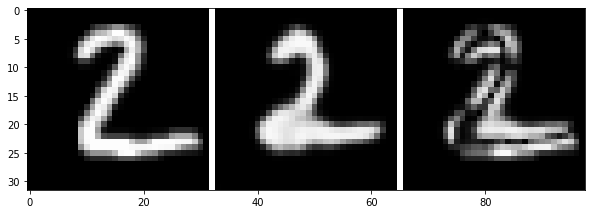

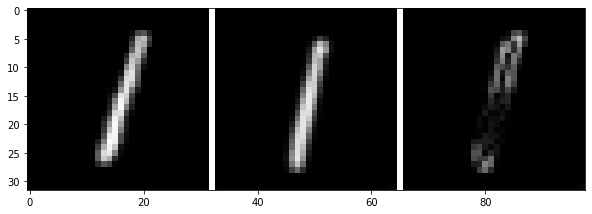

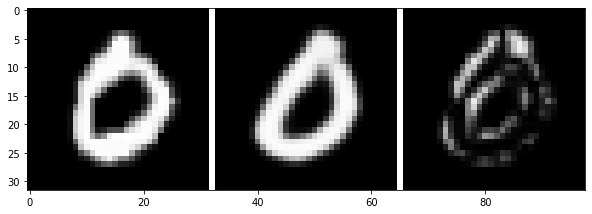

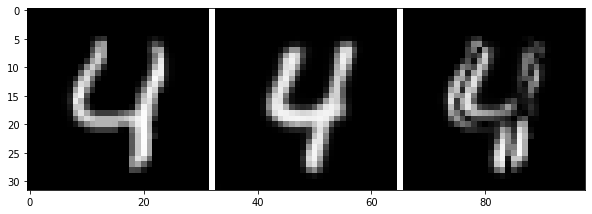

04/06/2020 12:52:03, epoch=146, step=17240, loss=0.27271, distortion=0.388, rate=0.029, -elbo=73.97881, nll=68.83688, KL=5.14193, commit_loss=971.96252, bit_usage=0.94779, highest_prob=0.016, temp=0.01827
04/06/2020 12:52:05, epoch=146, step=17260, loss=0.26905, distortion=0.383, rate=0.029, -elbo=73.06544, nll=67.92123, KL=5.14421, commit_loss=949.70325, bit_usage=0.94467, highest_prob=0.014, temp=0.01752
04/06/2020 12:52:08, epoch=146, step=17280, loss=0.28583, distortion=0.407, rate=0.029, -elbo=77.34962, nll=72.21969, KL=5.12993, commit_loss=946.52148, bit_usage=0.93675, highest_prob=0.014, temp=0.01677
04/06/2020 12:52:10, epoch=146, step=17300, loss=0.28105, distortion=0.400, rate=0.029, -elbo=76.12923, nll=71.00042, KL=5.12881, commit_loss=942.83899, bit_usage=0.93882, highest_prob=0.016, temp=0.01601
04/06/2020 12:52:12, epoch=146, step=17320, loss=0.28646, distortion=0.408, rate=0.029, -elbo=77.53139, nll=72.39556, KL=5.13583, commit_loss=932.01550, bit_usage=0.93252, highest_

/home/johnh/git/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type HQA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/johnh/git/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/johnh/git/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/johnh/git/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " 

In [12]:
# Train a HQA stack
model_name = "hqa_model"
models_dir = f"{os.getcwd()}/models"
os.makedirs(models_dir, exist_ok=True)


if not os.path.isfile(f"{models_dir}/{model_name}.pt"):
    hqa_model = train_full_stack(models_dir, model_name, epochs=150)
else:
    hqa_model = torch.load(f"{models_dir}/{model_name}.pt")

hqa_model.eval()
    
layer_names = ["Layer 0", "Layer 1", "Layer 2", "Layer 3", "Layer 4 Final"]
layer_descriptions = [
    "downsample 2 in each dimension, latent space size of 16x16",
    "downsample 4 in each dimension, latent space size of 8x8",
    "downsample 8 in each dimension, latent space size of 4x4",
    "downsample 16 in each dimension, latent space size of 2x2",
    "downsample 32 in each dimension, latent space size of 1x1",
]

### Layer Reconstructions
Final layer recons match HQA recons from Table 3

In [13]:
def recon_comparison(model, names, descriptions, indexes=[0, 4, 15, 16, 18]):
    images = []
    for idx in indexes:
        (image, label) = ds_test[idx]    
        img = image.to(device).squeeze()
        images.append(img.cpu().numpy())
    print("Original images to be reconstructed")
    output = np.hstack(images)
    show_image(output)
    
    for layer, name, description in zip(model, names, descriptions):
        images = []
        
        for idx in indexes:
            (image, label) = ds_test[idx]    
            img = image.to(device).squeeze()
            
            for_recon = img.unsqueeze(0).unsqueeze(0)
            layer.eval()
            recon = layer.reconstruct(for_recon).squeeze()
            images.append(recon.cpu().numpy())
        
        print(f"{name}: {description}")
        output = np.hstack(images)
        show_image(output)

Original images to be reconstructed


Layer 0: downsample 2 in each dimension, latent space size of 16x16


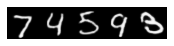

Layer 1: downsample 4 in each dimension, latent space size of 8x8


Layer 2: downsample 8 in each dimension, latent space size of 4x4


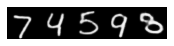

Layer 3: downsample 16 in each dimension, latent space size of 2x2


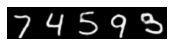

Layer 4 Final: downsample 32 in each dimension, latent space size of 1x1


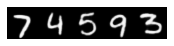

In [14]:
# Show reconstruction comparison over each layer in HQA
recon_comparison(hqa_model, layer_names, layer_descriptions)

### Distortions
HQA distortions in Figure 3

In [15]:
def get_rate_upper_bound(model, example_input):
    assert len(example_input.shape) == 4, "Expected (1, num_channels, x_h, x_w)"
    assert example_input.shape[0] == 1, "Please provide example with batch_size=1"
    
    z_e = model.encode(example_input)
    _, top_indices, _, _ = model.codebook(z_e)
        
    # assume worst case scenario: we have a uniform usage of all our codes
    rate_bound = top_indices[0].numel() * np.log2(model.codebook.codebook_slots)

    return rate_bound

def test(model):
    model.eval()
    total_nll = []
    total_kl = []
    
    for x, _ in dl_test:
        img = x.to(device)       
        recon, orig, z_q, z_e, indices, kl, _ = model.forward_full_stack(img)       
        recon_loss = model[0].recon_loss(img, recon)        
        total_nll.append(recon_loss.item())
        if kl != 0:
            total_kl.append(kl.item())
        else:
            total_kl.append(kl)
    
    dims = np.prod(x.shape[1:])
    kl_mean = np.mean(total_kl)
    nll_mean = np.mean(total_nll)
    distortion_bpd = nll_mean / dims / np.log(2)
    rate_bpd = kl_mean / dims / np.log(2)
    elbo = -(nll_mean + kl_mean)
    
    rate_bound = get_rate_upper_bound(model, img[0].unsqueeze(0))
    
    return distortion_bpd, rate_bound


def get_rd_data(model):
    dist = []
    rates = []
    
    for i, _ in enumerate(model):
        d, r = test(model[i])
        dist.append(float(d))
        rates.append(float(r))
    
    return dist, rates

In [16]:
# Layer distortions
distortions, rates = get_rd_data(hqa_model)
print("Name \t\t Distortion \t Rate")
for dist, rate, name in zip(distortions, rates, layer_names):
    print(f"{name} \t {dist:.4f} \t {int(rate)}")

Name 		 Distortion 	 Rate
Layer 0 	 0.0014 	 2048
Layer 1 	 0.0024 	 512
Layer 2 	 0.0064 	 128
Layer 3 	 0.0187 	 32
Layer 4 Final 	 0.0542 	 8


### "Free" Samples: enumerating over all 1x1 latents
Appendix Figure 4

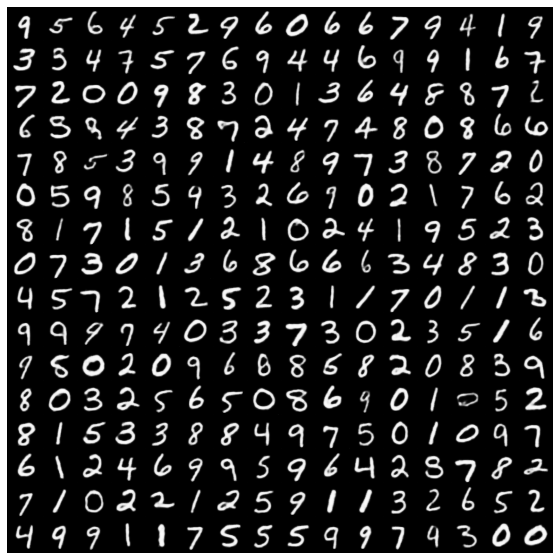

In [17]:
num_codes = hqa_model.codebook.codebook_slots
results = torch.Tensor(num_codes, 1, 32, 32).to(device)
count=0
for i in range(num_codes):
    codes = torch.LongTensor([i]).unsqueeze(0).unsqueeze(0).to(device)
    results[count] = hqa_model.reconstruct_from_codes(codes)
    count += 1
        
grid_img = make_grid(results.cpu(), nrow=16)
show_image(grid_img[0,:,:])

### Final Layer Interpolations
Appendix Figure 5

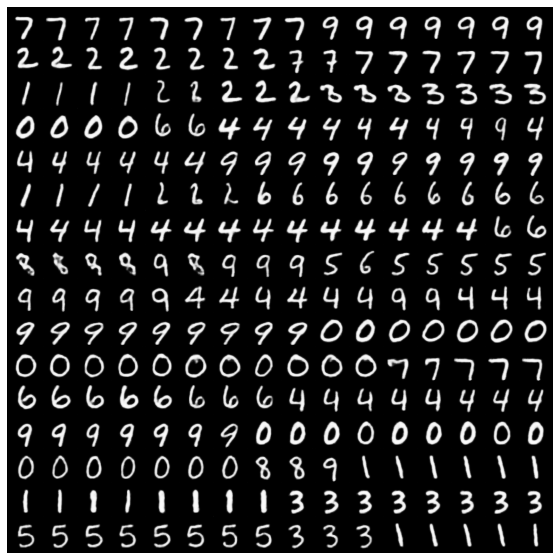

In [18]:
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)
i = 0

for j in range(grid_y):
    x_a,_ = ds_test[j]
    x_b,_ = ds_test[j+grid_y]
    point_1 = hqa_model.encode(x_a.unsqueeze(0).to(device)).cpu()
    point_2 = hqa_model.encode(x_b.unsqueeze(0).to(device)).cpu()
    interpolate_x = np.linspace(point_1[0], point_2[0], grid_x)

    for z_e_interpolated in interpolate_x:
        z_e_i = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = hqa_model.quantize(z_e_i)
        results[i] = hqa_model.decode(z_q).squeeze()
        i += 1
            
grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Stochastic Reconstructions
Appendix Figure 6

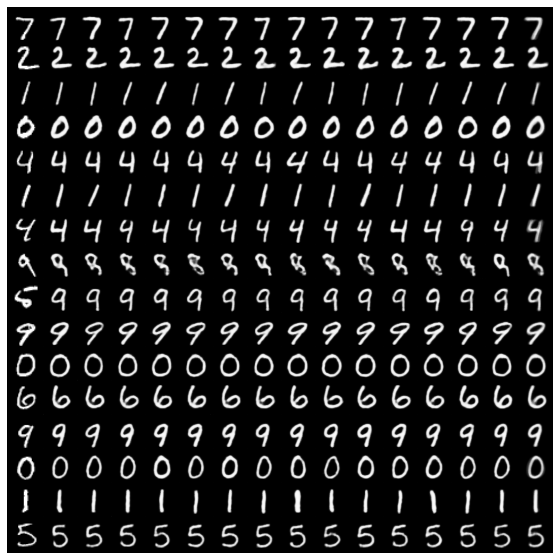

In [19]:
# Show held-out reconstructions: [ORIG, 14xSAMPLE, AVERAGED_10_SAMPLES]
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)

result_idx = 0
for test_idx in range(grid_y):
    x_a,_ = ds_test[test_idx]
    img = x_a.squeeze().to(device)
    img_ = img.unsqueeze(0).unsqueeze(0)
    num_examples = 5
    
    # ORIG
    results[result_idx] = img
    result_idx += 1
    
    # 14 RANDOM STOCHASTIC DECODES
    for _ in range(grid_x -2):
        results[result_idx] = hqa_model.reconstruct(img_).squeeze()
        result_idx += 1
    
    # AVERAGED SAMPLES
    results[result_idx] = hqa_model.reconstruct_average(img_, num_samples=14).squeeze()
    result_idx += 1

grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Layer-wise Interpolations
Appendix Table 7

Originals


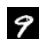

Layer 0 : downsample 2 in each dimension, latent space size of 16x16


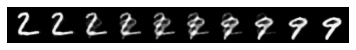

Layer 1 : downsample 4 in each dimension, latent space size of 8x8


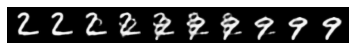

Layer 2 : downsample 8 in each dimension, latent space size of 4x4


Layer 3 : downsample 16 in each dimension, latent space size of 2x2


Layer 4 Final : downsample 32 in each dimension, latent space size of 1x1


In [20]:
def interpolate(a, b, vqvae, grid_x=16):
    images = []
    
    x_a,_ = ds_test[a]
    x_b,_ = ds_test[b]
    point_1 = vqvae.encode(x_a.unsqueeze(0).to(device))
    point_2 = vqvae.encode(x_b.unsqueeze(0).to(device))

    interpolate_x = np.linspace(point_1[0].cpu().numpy(), point_2[0].cpu().numpy(), grid_x)
    
    results = torch.Tensor(len(interpolate_x), 1, 32, 32)
    for i, z_e_interpolated in enumerate(interpolate_x):       
        z_e = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = vqvae.quantize(z_e)
        recon = vqvae.decode(z_q).squeeze() 
        results[i] = recon

    grid_img = make_grid(results.cpu(), nrow=grid_x)
    show_image(grid_img[0,:,:])

def show_original(idx):
    x, _ = ds_test[idx]
    image = x.squeeze()
    show_image(image)
    
print("Originals")
show_original(1)
show_original(9)
for layer, name, description in zip(hqa_model, layer_names, layer_descriptions):
    print(f"{name} : {description}")
    interpolate(1, 9, layer, grid_x=10)